In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
from math import *

class Simulation(object):
    """The numerical simulation"""
    def __setattr__(self,name,value):
        object.__setattr__(self, name, value)
        #used to allow attribute write access by other methods
    
    def __init__(self,parent):
        self.parent = parent #for reference to gui appframe
        #stage parameter lists
        self.burntime = ['']
        self.thrust0 = ['']
        self.Isp0 = ['']
        self.m0 = ['']
        self.fuelfraction = ['']
        self.fuelmass = ['']
        self.dMdt = ['']
        #results dict
        self.data = {'Time':[0],'Height':[0],'Mass':[0],'Velocity':[0],'Thrust':[0],'Drag':[0],'Gamma':[pi/2],'Range':[0]}
    
    def integrate(self,trajectory):
        t = 0.0     # time
        v = 0       # initial v
        h = 0.001   # initial h must be small but non-zero
        psi = 0     # range angle: range = psi * Rearth
        rho = 0.0   # air density at current altitude
        p_height = 0.0 # air pressure at current altitude
        gamma = self.to_radians(90) #launch angle, from horizontal
        
        
        #print "Start Simulation"
        # ref for printing results in GUI mode
        try:
            app = wx.GetTopLevelParent(self.parent)
        except NameError:
            pass
        self.trajectory = trajectory #make ref for eta function
        ##### SET INTEGRATION PARAMETERS
        tEND = 20000        #timeout value
        dtprint = 1         #time interval between printing output
        Htrans = 20000  #height [m] at which transition from laminar to turbulent heating occurs
        deltaend = .1       #time increment used for integration
        deltatinit = .01    #time increment for t < tinit + 1 sec
        mtot = 0.0
        burntimetot = 0.0
        tinit = burntimetot + 1 # integrate more carefully during burn
        #####
        apogee = 0.0
        Thrust = 0.0
        drag = 0.0
        ##### SET CONSTANTS
        Rearth = 6370000 #[m]
        g0 = 9.8066 #[m/s^2]
        #
        ##### INITIALIZE ROCKET MODEL
        
        for i in range(1,self.numstages+1):
            mtot += self.m0[i] #sum total mass
            self.burntime.append(self.Isp0[i]*9.81*self.fuelmass[i]/self.thrust0[i])
            burntimetot += self.burntime[i] #sum total burn time
        mtot += self.payload
        
        area_missile = (self.missilediam/2)**2 * pi #[m^2]
        area_rv = self.rvdiam/2**2 * pi #[m^2]
        #####
        
        ##### INTEGRATE
        #   
        #Initialize variables
        deltat = deltatinit
        flagdeltat = True
        m = mtot
        #
        dMdt0 = self.dMdt[1]
        tprint = dtprint #tprint is time at which printing of output will next occur
        flag = True # controls printing parameters at burnout of stages
        tlimit = self.burntime[1] # ditto
        nstage = 1  # used at burnout of stages
        gamma_half = gamma # angle of missile or RV w/ local horizon
        
        #set burnout angle to optimum for MET
        #uses Wheelon's form of the equations
        opt_burnout_angle = pi/2 - .25*(self.est_range/Rearth + pi)
        #use this optimum burnout angle to linearize turn angle, from horizontal

        
        #Integrate
        while t < tEND and h > 0: # big loop
            #save data to Results dict
            self.data['Time'].append(t) #in tenths seconds
            self.data['Height'].append(h) #in meters
            self.data['Mass'].append(m) #in kg
            self.data['Velocity'].append(v) #in meters/second
            self.data['Thrust'].append(Thrust) #in in kgf
            self.data['Drag'].append(drag) #in N
            self.data['Gamma'].append(gamma) #in degrees from horizontal
            self.data['Range'].append(Rearth*psi) #in meters
            
            if (t + deltat/5) >= tinit and flagdeltat == True:
                deltat = deltaend
                flagdeltat = False
            
            #
            # save old values
            psi_old = psi
            h_old = h
            gamma_old = gamma
            v_old = v
            m_old = m
            t_old = t
            #
            if (t + deltat/5) <= burntimetot: 
                m_half = m_old - (dMdt0 * deltat/2) #burn fuel
                area = area_missile
            else:
                area = area_rv
            #calculate drag
            rho = self.density(h)
            cd = self.Cdrag(v_old,h)
            drag = cd*area*rho*(v_old**2)/2
            
            # calculate thrust as function of altitude
            #NEW EQUATIONS, from Charles Vick
            h_vacuum = 160934 #~100 miles
            Thrust_ideal = self.Isp0[nstage]*self.dMdt[nstage]*9.81
            if (t + deltat/5) > burntimetot:
                Thrust_pct_increase = 0
                #out of fuel, no thrust
            elif h < h_vacuum:
                h_norm = h / h_vacuum
                Thrust_pct_increase = -.4339*(h_norm)**3+.6233*(h_norm)**2-.01*(h_norm)+1.004
                #3rd order polynomial line fit from Saturn-V data on thrust vs. height
                
            elif h > h_vacuum and nstage == 1:
                Thrust_pct_increase = 1.19
                Thrust = Thrust_ideal*Thrust_pct_increase
            elif nstage > 1:
                Thrust_pct_increase = 1
                #assuming that stage Isp is correct for vacuum
            Thrust = Thrust_ideal*Thrust_pct_increase
            Force = Thrust - drag
            #note that Force will be negative during reentry
            
            #OLD EQUATIONS, from David Wright
            #requires us to know nozzle area, which we don't
            #p0 = self.pressure(0)
            #p_height = self.pressure(h)
            #self.nozarea = .3 #[m^2] for TD-1
            #if (t + deltat/5) > burntimetot:
            #   Thrust = 0.0
            #elif nstage == 1:  
            #   Thrust = self.Isp0[1]*self.dMdt[1]*9.81 + self.nozarea*(p0-p_height)
            #elif nstage > 1:
            #   Thrust = self.Isp0[nstage]*self.dMdt[nstage]*9.81
    
                
            #
            g = g0*Rearth**2/(h+Rearth)**2 #calculate grav accel at height
            
            ETA_old = self.eta(h_old,t_old)
            #
            # Integration is variant of Runge-Kutta-2.
            # 1- Calculate values at midpoint, t = t_old + deltat/2
            #
            t_half = t_old + deltat/2
            d_psi = (v_old * cos(gamma_old)/(Rearth + h_old)) * deltat/2
            psi_half = psi_old + d_psi
            h_half = h_old + v_old*sin(gamma_old)*deltat/2
            #
            # calculate gamma
            
            vertical_flight_period = 5
            if t < vertical_flight_period:
                #force gamma to be constant early in flight
                dgamma = 0.0
            elif (t >= vertical_flight_period) and (t <= burntimetot):
                dgamma = ((opt_burnout_angle - pi/2)/(burntimetot - vertical_flight_period))
            else:
                dgamma = d_psi/(deltat/2) + Force*sin(ETA_old)/(v_old * m_old) - (g*cos(gamma_old)/v_old)
            
            #integrate it
            gamma_half = gamma_old + dgamma*deltat/2
            
            # calculate dv
            dv = (Force/m_old)*cos(ETA_old) - g*sin(gamma_old)
            
            v_half = v_old + dv*deltat/2
            #
            #
            # 2- Use derivatives at midpoint to calculate values at t + deltat
            ETA_half = self.eta(h_half,t_half)
            # Increment time
            t += deltat
            #
            d_psi_half = (v_half*cos(gamma_half))/(Rearth+h_half) * deltat
            psi = psi_old + d_psi_half
            h = h_old + v_half*sin(gamma_half)*deltat
            if h > h_old:
                apogee = h
                v_apogee = v

            vertical_flight_period = 5
            if t <= vertical_flight_period:
                dgamma_half = 0.0
            elif (t > vertical_flight_period) and (t <= burntimetot):
                dgamma_half = ((opt_burnout_angle - pi/2)/(burntimetot - vertical_flight_period))
            else:
                #use Wright's equation, hopefully not too disjoint with previous
                dgamma_half = d_psi_half/(deltat) + (Force/(v_half*m_half))*sin(ETA_half) - (g*cos(gamma_half)/v_half)
                
            gamma = gamma_old + dgamma_half*deltat

            if (t + deltat/5) <= burntimetot:
                m = m_old - dMdt0 * deltat
                #burn fuel mass 
    
            dv_half = (Force/m_half)*cos(ETA_half) - g*sin(gamma_half)
            v = v_old + dv_half*deltat
                        
            #Print data at stage burnout
            if (t + deltat / 5) > tlimit and flag == True:
                if __name__ == "__main__":
                    #Simple text printout
                    print("Stage %i burnout" % nstage)
                    print("Velocity (km/s): ",v/1000)
                    print("Angle (deg h): ",gamma*180/pi)
                    print("Range (km): ",Rearth*psi/1000)
                    print("Time (sec): ",t)
                else:
                    #GUI printout
                    app.Results.StageVelocityResult[nstage].SetValue("%4.2f" % float(v/1000))
                    app.Results.StageAngleResult[nstage].SetValue("%4.2f" % float(gamma*180/pi))
                    app.Results.StageHeightResult[nstage].SetValue("%4.2f" % float(h/1000))
                    app.Results.StageRangeResult[nstage].SetValue("%4.2f" % float(Rearth*psi/1000))
                    app.Results.StageTimeResult[nstage].SetValue("%4.2f" % t)
        
                m = mtot - self.m0[nstage]
                if nstage < self.numstages:
                    nstage += 1
                    tlimit += self.burntime[nstage] #set time to next print burnout
                    dMdt0 = self.dMdt[nstage]
                else:
                    flag = False
                
            #END BIG LOOP
    
        if t >= tEND:
            if __name__ == "__main__":
                print("Simulation exceeded time limit.")
            else:
                dlg = wx.MessageDialog(self.parent,"Exceeded time limit, results are likely invalid.","Simulation error",wx.OK | wx.ICON_INFORMATION)
                dlg.ShowModal()
                dlg.Destroy()


        #print "Done"
        if __name__ == "__main__":
            #print final results
            print("Final results: ")
            print("Range (km): ",psi*Rearth/1000)
            print("Apogee (km): ",apogee/1000)
            print("Time to target (sec): ",t)
        else:
            #put results in frame
            app.Results.ApogeeResult.SetValue("%4.2f" % float(apogee/1000))
            app.Results.ApogeeVelocityResult.SetValue("%4.3f" % float(v/1000))
            app.Results.RangeResult.SetValue("%4.3f" % float(Rearth*psi/1000))
            app.Results.FlightTimeResult.SetValue("%4.1f" % t)
            
        return (self.data)
            
                
    def eta(self,h,t):
         #for 11,000km MET, from <Gronlund and Wright, "Depressed Trajectory SLBMS", Science and Global Security, 1992, Vol 3, p101-159>
        # only used for Thrust Vector trajectories
        if self.trajectory == 'Thrust Vector':
            if t > self.TStartTurn and t < self.TEndTurn:
                eta = -self.to_radians(self.TurnAngle)
            else:
                eta = 0.0
        else:
            eta = 0.0
        return eta      
    
    def density(self,h):
        "Calculates air density at altitude"    
        rho0 = 1.225 #[kg/m^3] air density at sea level
        if h < 19200:
            #use barometric formula, where 8420 is effective height of atmosphere [m]
            rho = rho0 * exp(-h/8420)
        elif h > 19200 and h < 47000:
            #use 1976 Standard Atmosphere model
            #http://modelweb.gsfc.nasa.gov/atmos/us_standard.html
            #from http://scipp.ucsc.edu/outreach/balloon/glost/environment3.html
            rho = rho0 * (.857003 + h/57947)**-13.201
        else:
            #vacuum
            rho = 0.0
        return rho
        
    def temperature(self,h):
        "Calculates air temperature [Celsius] at altitude [m]"
        #from equations at 
        #   http://www.grc.nasa.gov/WWW/K-12/airplane/atmosmet.html
        if h <= 11000:
            #troposphere
            t = 15.04 - .00649*h
        elif h <= 25000:
            #lower stratosphere
            t = -56.46
        elif h > 25000:
            t = -131.21 + .00299*h
        return t
    
    def pressure(self,h):
        "Calculates air pressure [Pa] at altitude [m]"
        #from equations at 
        #   http://www.grc.nasa.gov/WWW/K-12/airplane/atmosmet.html
        
        t = self.temperature(h)
        
        if h <= 11000:
            #troposphere
            p = 101.29 * ((t+273.1)/288.08)**5.256
        elif h <= 25000:
            #lower stratosphere
            p = 22.65*exp(1.73-.000157*h)
        elif h > 25000:
            p = 2.488 * ((t+273.1)/288.08)**-11.388
        return p
        
    def Cdrag (self,v,h):
        t = self.temperature(h) + 273.15 #convert to kelvin
        a = sqrt(1.4*287*t) 
        mach = v/a
        
        #Drag function for V2
        #derived from Sutton, "Rocket Propulsion Elements", 7th ed, p108
        #probably not that relevant to other body types
        if mach > 5:
            cd = 0.15
        elif mach > 1.8 and mach <= 5:
            cd = -0.03125*mach + 0.30625
        elif mach > 1.2 and mach <= 1.8:
            cd = -0.25*mach + 0.7
        elif mach > 0.8 and mach <= 1.2:
            cd = 0.625*mach - 0.35
        elif mach <= 0.8:
            cd = 0.15
            
        #use nose cone formula
        #theta = self.to_radians(15)
        #cd = 2*sin(theta)**2
            
        return cd
        
    def to_radians(self,degree):
        return degree * pi/180

In [34]:
def basic_plot(x_string, y_string, results):
    fig, ax = plt.subplots()
    ax.plot(results[x_string], results[y_string])
    ax.set_xlabel(x_string)
    ax.set_ylabel(y_string)
    title_string = y_string + ' vs ' + x_string
    ax.set_title(title_string)
    plt.show()
    

def run_one_sim(numstages, fuelmass, drymass, thrust0, Isp0, payload, missilediam, rvdiam, est_range,
               output_path, simulation_output):
    sim = Simulation(None) #this simulation object has no parent
    sim.numstages = numstages
    sim.fuelmass = fuelmass # list
    sim.drymass = drymass 
    sim.m0 = [fm+dm for fm,dm in  zip(sim.fuelmass, sim.drymass)] 
    sim.fuelfraction = [0]
    sim.fuelfraction = sim.fuelfraction + ([fm/m0 for fm, m0 in zip(sim.fuelmass[1:], sim.m0[1:])])  
    sim.thrust0 = [x * 9.81 for x in thrust0] 
    sim.Isp0 = Isp0
    sim.dMdt = [0]
    sim.dMdt = sim.dMdt + ([t0/(i0 * 9.81) for t0, i0 in zip(sim.thrust0[1:], sim.Isp0[1:])]) 

    sim.payload = payload
    sim.missilediam = missilediam
    sim.rvdiam = rvdiam
    sim.est_range = est_range * 1000
    
    print('\n')
    sim.trajectory = "Minimum Energy"
    results = sim.integrate(sim.trajectory)
    print('\n')

    if wirte_output_txt:
        outfile = open(output_path,'w')
        for i in range(1,sim.numstages+1):
                    outfile.write("STAGE %i Parameters:\n" % i)
                    outfile.write("Fuel mass (kg): " + str(sim.fuelmass[i]) + '\n')
                    outfile.write("Dry mass (kg): " + str(sim.m0[i] - sim.fuelmass[i]) + '\n')
                    outfile.write("Fuel fract: " + str(sim.fuelfraction[i]) + '\n')
                    outfile.write("Isp @ SL: " + str(sim.Isp0[i]) + '\n')
                    outfile.write("Burn time (sec): " + str(sim.burntime[i]) + '\n')
                    outfile.write("Thrust (N): " + str(sim.thrust0[i]) + '\n')
                    outfile.write("dM/dt: " + str(sim.dMdt[i]) + '\n')

        outfile.write("\nTIME,HEIGHT,VELOCITY,MASS,THRUST,DRAG,GAMMA,RANGE\n")
        flat = list(zip(results['Time'],
                    results['Height'],
                    results['Velocity'],
                    results['Mass'],
                    results['Thrust'],
                    results['Drag'],
                    results['Gamma'],
                    results['Range']))
        ## TEMP ## plots
        basic_plot(x_string='Time', y_string='Range', results=results)
        basic_plot(x_string='Time', y_string='Height', results=results)
        basic_plot(x_string='Time', y_string='Gamma', results=results)
        basic_plot(x_string='Range', y_string='Height', results=results)
        ##
        
        for i in range(1,len(flat)):
            for n in range(0,len(flat[i])):
                outfile.write('%.3f' % flat[i][n])
                outfile.write(',')
            outfile.write('\n')
        print("Data written to '%s'" % output_path)
        outfile.close()
    
    if simulation_output=='range':
        return results['Range'][-1] / 1000.0
    else:
        print("WANRNING: Only range output implemented for now")
        return None



In [6]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [7]:
# We start considering missiles with only 1 stage

# 0. Only one param

In [8]:
param_1 = 'fuelmass'
domain_param_1 = [500, 6000] # [5000,15000]

space = ParameterSpace(
          [ContinuousParameter(param_1, *domain_param_1), 
          ])

custom_param_names = [param_1]

In [9]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

fuelmass: 3464.086094309234


Stage 1 burnout
Velocity (km/s):  1.6362088794519192
Angle (deg h):  43.654028098947926
Range (km):  25.6378503488212
Time (sec):  85.29999999999943
Final results: 
Range (km):  343.85198342997376
Apogee (km):  108.53909411945857
Time to target (sec):  359.00000000001313




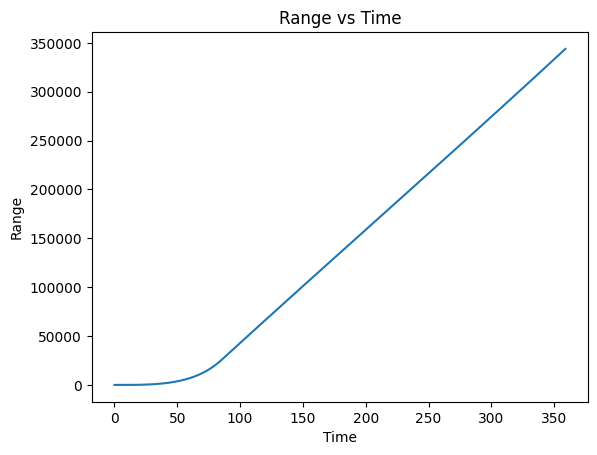

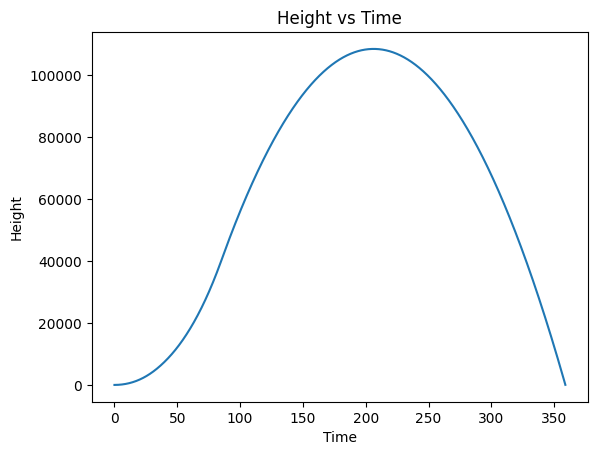

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 2181.105619176319


Stage 1 burnout
Velocity (km/s):  1.2061003392126408
Angle (deg h):  43.66153560753528
Range (km):  13.14360886715467
Time (sec):  53.70000000000049
Final results: 
Range (km):  184.1491756042831
Apogee (km):  58.35657619002098
Time to target (sec):  251.59999999999




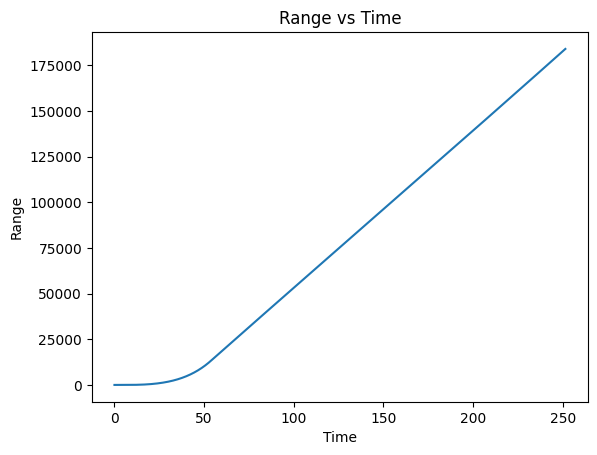

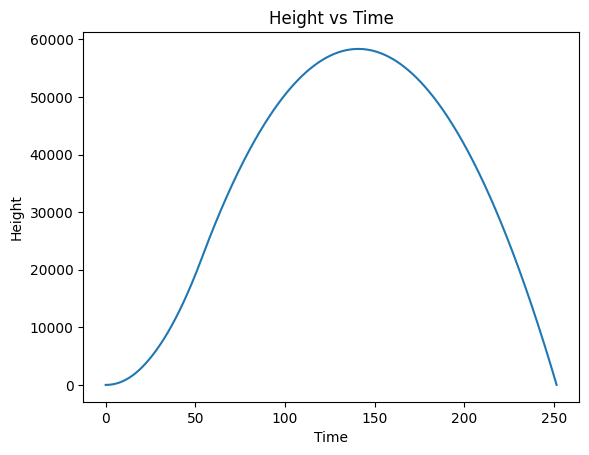

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 4237.658584525689


Stage 1 burnout
Velocity (km/s):  1.8208488771006706
Angle (deg h):  43.65579737865838
Range (km):  33.1040673902168
Time (sec):  104.39999999999834
Final results: 
Range (km):  430.18430219390706
Apogee (km):  136.0143337875295
Time to target (sec):  412.70000000002534




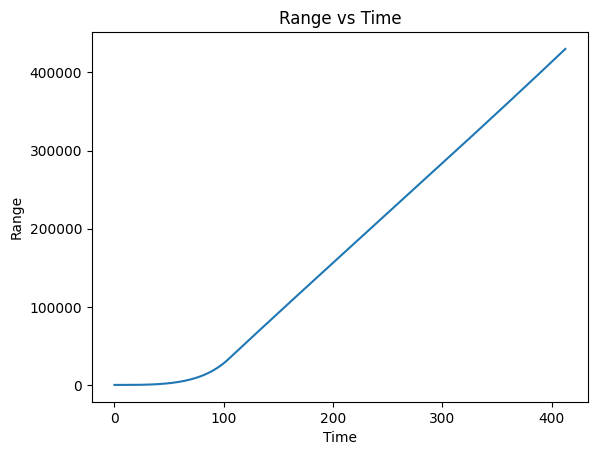

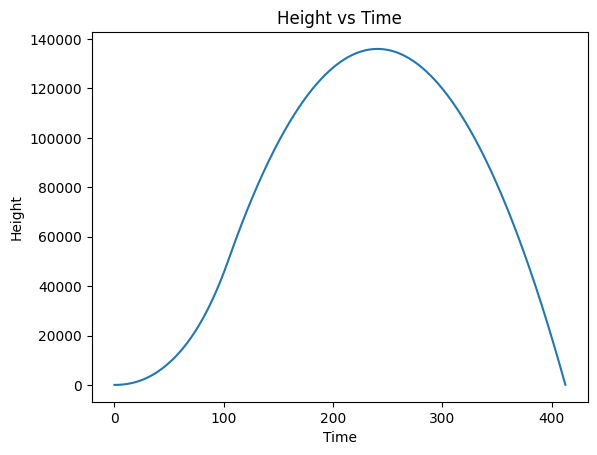

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1119.5220632138314


Stage 1 burnout
Velocity (km/s):  0.7527803825221526
Angle (deg h):  43.73909118469356
Range (km):  4.462871097685845
Time (sec):  27.600000000000126
Final results: 
Range (km):  70.24395873436453
Apogee (km):  22.280207374003872
Time to target (sec):  148.99999999999582




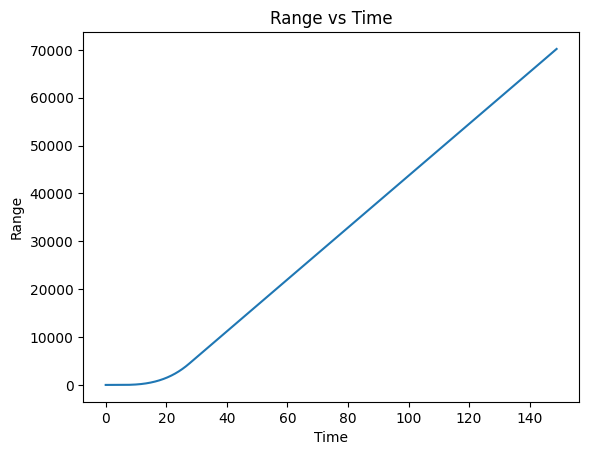

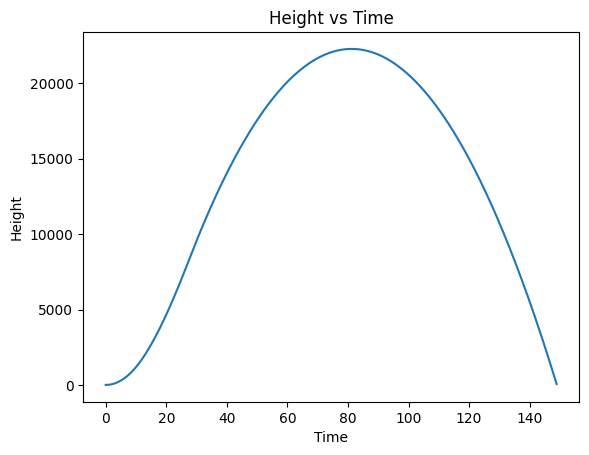

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 4276.124704183594


Stage 1 burnout
Velocity (km/s):  1.8263695366607926
Angle (deg h):  43.65201239436065
Range (km):  33.39669625126526
Time (sec):  105.29999999999829
Final results: 
Range (km):  433.0673210921122
Apogee (km):  136.96970481871062
Time to target (sec):  414.7000000000258




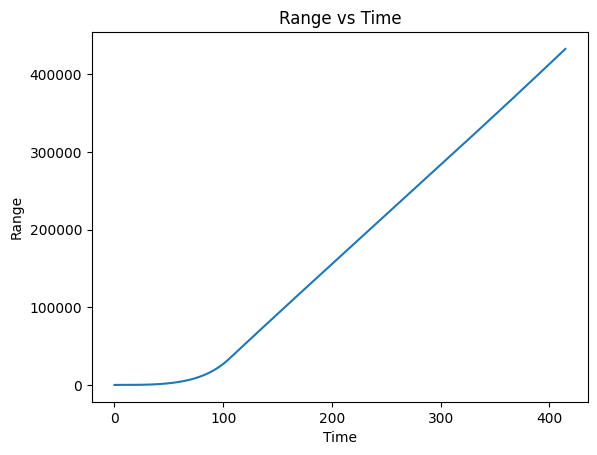

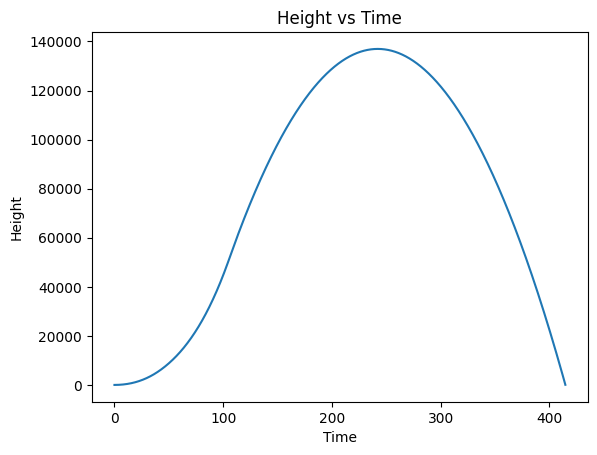

Data written to 'results/results_4.txt'


In [10]:
# Get true points (to build model)
wirte_output_txt = True
design = RandomDesign(space)
x = design.get_samples(5)
y = run_missile_sim(x)

In [11]:
# Build model
var_kernel = (100)**2 
lengthscale = 1 # 1
var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
var_noise = 1e-5 # small value
# In catapult: 1e-5

kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
kern = GPy.kern.RBF(input_dim=1, lengthscale=100 ) + \
    GPy.kern.Linear(input_dim=1)

model_gpy = GPRegression(x,y, kernel=kern)
model_gpy.kern.variance =  var_kernel 
model_gpy.likelihood.variance.fix(var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(model_gpy)



In [12]:
# Fit emulator
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()



In [13]:
display(model_gpy)

In [14]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False
nr_points_plot = 301
param_1_x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, nr_points_plot)[:, None]
param_1_y_plot = run_missile_sim(param_1_x_plot)




New simulation 

fuelmass: 500.0


Stage 1 burnout
Velocity (km/s):  0.4265056287972526
Angle (deg h):  43.732284489193205
Range (km):  0.9440400159604505
Time (sec):  12.299999999999974
Final results: 
Range (km):  21.661219962904816
Apogee (km):  6.737492515662497
Time to target (sec):  79.59999999999975



New simulation 

fuelmass: 518.3333333333334


Stage 1 burnout
Velocity (km/s):  0.43905877485586203
Angle (deg h):  43.94232680213815
Range (km):  1.037682082180261
Time (sec):  12.799999999999972
Final results: 
Range (km):  23.013791615632808
Apogee (km):  7.19665589314658
Time to target (sec):  82.3999999999996



New simulation 

fuelmass: 536.6666666666666


Stage 1 burnout
Velocity (km/s):  0.44799024767022866
Angle (deg h):  43.73993108354109
Range (km):  1.1013774296045882
Time (sec):  13.19999999999997
Final results: 
Range (km):  24.02034604907838
Apogee (km):  7.485179947127214
Time to target (sec):  84.0999999999995



New simulation 

fuelmass: 555.0


Stage 1 burno

Final results: 
Range (km):  60.971551920832134
Apogee (km):  19.288683336835767
Time to target (sec):  137.99999999999645



New simulation 

fuelmass: 1031.6666666666665


Stage 1 burnout
Velocity (km/s):  0.7097822549986649
Angle (deg h):  43.663355706859214
Range (km):  3.85474656537123
Time (sec):  25.400000000000095
Final results: 
Range (km):  62.247940528556676
Apogee (km):  19.684197662609044
Time to target (sec):  139.49999999999636



New simulation 

fuelmass: 1050.0


Stage 1 burnout
Velocity (km/s):  0.7202978297739892
Angle (deg h):  43.721497967193734
Range (km):  4.000609855124675
Time (sec):  25.9000000000001
Final results: 
Range (km):  64.18088861270505
Apogee (km):  20.309275138239624
Time to target (sec):  141.89999999999623



New simulation 

fuelmass: 1068.3333333333333


Stage 1 burnout
Velocity (km/s):  0.727200175156778
Angle (deg h):  43.66922481111436
Range (km):  4.095587026345635
Time (sec):  26.300000000000107
Final results: 
Range (km):  65.47851793270

Final results: 
Range (km):  119.86492019336323
Apogee (km):  38.06068898374947
Time to target (sec):  198.89999999999299



New simulation 

fuelmass: 1636.6666666666665


Stage 1 burnout
Velocity (km/s):  0.982633686195469
Angle (deg h):  43.65616268602385
Range (km):  8.36796009645822
Time (sec):  40.3000000000003
Final results: 
Range (km):  121.3192049160869
Apogee (km):  38.533221808098084
Time to target (sec):  200.1999999999929



New simulation 

fuelmass: 1655.0


Stage 1 burnout
Velocity (km/s):  0.9923770528046968
Angle (deg h):  43.682606616424465
Range (km):  8.554350534585899
Time (sec):  40.80000000000031
Final results: 
Range (km):  123.77229497864255
Apogee (km):  39.31368493723007
Time to target (sec):  202.3999999999928



New simulation 

fuelmass: 1673.3333333333333


Stage 1 burnout
Velocity (km/s):  0.9981656793815111
Angle (deg h):  43.65979613872028
Range (km):  8.66987308346248
Time (sec):  41.200000000000315
Final results: 
Range (km):  125.24056989745291
Ap

Final results: 
Range (km):  178.208267531545
Apogee (km):  56.57479268221408
Time to target (sec):  247.19999999999024



New simulation 

fuelmass: 2150.0


Stage 1 burnout
Velocity (km/s):  1.1965376825526428
Angle (deg h):  43.66154046735303
Range (km):  12.913740428148852
Time (sec):  53.00000000000048
Final results: 
Range (km):  181.13245531479143
Apogee (km):  57.38600238892058
Time to target (sec):  249.19999999999013



New simulation 

fuelmass: 2168.333333333333


Stage 1 burnout
Velocity (km/s):  1.201637233651066
Angle (deg h):  43.710602106921925
Range (km):  13.038274337593714
Time (sec):  53.40000000000049
Final results: 
Range (km):  182.6788267734642
Apogee (km):  57.978367542167184
Time to target (sec):  250.59999999999005



New simulation 

fuelmass: 2186.6666666666665


Stage 1 burnout
Velocity (km/s):  1.211067213871199
Angle (deg h):  43.66394580623868
Range (km):  13.25004685357554
Time (sec):  53.900000000000496
Final results: 
Range (km):  185.63348232888663

Final results: 
Range (km):  245.36599287562336
Apogee (km):  77.57237741568228
Time to target (sec):  295.0999999999986



New simulation 

fuelmass: 2681.6666666666665


Stage 1 burnout
Velocity (km/s):  1.3980361587510406
Angle (deg h):  43.65165920264045
Range (km):  17.992197615738306
Time (sec):  66.10000000000052
Final results: 
Range (km):  248.52460214916442
Apogee (km):  78.44646774405399
Time to target (sec):  296.99999999999903



New simulation 

fuelmass: 2700.0


Stage 1 burnout
Velocity (km/s):  1.4020705004649243
Angle (deg h):  43.69035123997309
Range (km):  18.119616680204892
Time (sec):  66.5000000000005
Final results: 
Range (km):  250.04699592949433
Apogee (km):  79.02506003982771
Time to target (sec):  298.29999999999933



New simulation 

fuelmass: 2718.333333333333


Stage 1 burnout
Velocity (km/s):  1.4106921016017802
Angle (deg h):  43.65371432274547
Range (km):  18.3483164790297
Time (sec):  67.00000000000047
Final results: 
Range (km):  253.11848562790732


Final results: 
Range (km):  307.64360321027067
Apogee (km):  97.11135139249802
Time to target (sec):  336.0000000000079



New simulation 

fuelmass: 3176.6666666666665


Stage 1 burnout
Velocity (km/s):  1.5587009034003818
Angle (deg h):  43.643497373717295
Range (km):  22.890687094740528
Time (sec):  78.29999999999983
Final results: 
Range (km):  310.74157784882686
Apogee (km):  97.99169992965831
Time to target (sec):  337.7000000000083



New simulation 

fuelmass: 3195.0


Stage 1 burnout
Velocity (km/s):  1.561687497973058
Angle (deg h):  43.67583548326796
Range (km):  23.014392187480034
Time (sec):  78.6999999999998
Final results: 
Range (km):  312.01440197308676
Apogee (km):  98.51642967147319
Time to target (sec):  338.80000000000854



New simulation 

fuelmass: 3213.333333333333


Stage 1 burnout
Velocity (km/s):  1.5693830831479707
Angle (deg h):  43.64531176249606
Range (km):  23.250529687953026
Time (sec):  79.19999999999978
Final results: 
Range (km):  315.23340155806363

Final results: 
Range (km):  373.67775427649
Apogee (km):  117.92227588667824
Time to target (sec):  377.3000000000173



New simulation 

fuelmass: 3726.6666666666665


Stage 1 burnout
Velocity (km/s):  1.7052149195551742
Angle (deg h):  43.6667221386163
Range (km):  28.24017899589675
Time (sec):  91.79999999999906
Final results: 
Range (km):  374.7474299756555
Apogee (km):  118.36965644858246
Time to target (sec):  378.3000000000175



New simulation 

fuelmass: 3745.0


Stage 1 burnout
Velocity (km/s):  1.7120353170230982
Angle (deg h):  43.640826984765546
Range (km):  28.477268374053
Time (sec):  92.29999999999903
Final results: 
Range (km):  377.8062639054711
Apogee (km):  119.22816570769305
Time to target (sec):  379.9000000000179



New simulation 

fuelmass: 3763.333333333333


Stage 1 burnout
Velocity (km/s):  1.7139988578684504
Angle (deg h):  43.66801323888249
Range (km):  28.59112490701802
Time (sec):  92.69999999999901
Final results: 
Range (km):  378.74441178709185
Apogee

Final results: 
Range (km):  428.35932314107947
Apogee (km):  135.46056650520958
Time to target (sec):  411.6000000000251



New simulation 

fuelmass: 4240.0


Stage 1 burnout
Velocity (km/s):  1.8185121188671796
Angle (deg h):  43.656873589495156
Range (km):  33.050371406448896
Time (sec):  104.39999999999834
Final results: 
Range (km):  429.11856982767335
Apogee (km):  135.74506834585645
Time to target (sec):  412.30000000002525



New simulation 

fuelmass: 4258.333333333333


Stage 1 burnout
Velocity (km/s):  1.8246285685877355
Angle (deg h):  43.65995449880955
Range (km):  33.28291758469607
Time (sec):  104.89999999999831
Final results: 
Range (km):  432.02000434249976
Apogee (km):  136.6478030478444
Time to target (sec):  413.9000000000256



New simulation 

fuelmass: 4276.666666666666


Stage 1 burnout
Velocity (km/s):  1.82582711384989
Angle (deg h):  43.65817861218147
Range (km):  33.38418707542493
Time (sec):  105.29999999999829
Final results: 
Range (km):  432.767594623476

Final results: 
Range (km):  473.8609235474401
Apogee (km):  150.1309742215728
Time to target (sec):  440.50000000003166



New simulation 

fuelmass: 4716.666666666666


Stage 1 burnout
Velocity (km/s):  1.9112277186983635
Angle (deg h):  43.65248845186084
Range (km):  37.402110196609705
Time (sec):  116.19999999999767
Final results: 
Range (km):  476.8057966920597
Apogee (km):  150.9150885698353
Time to target (sec):  442.000000000032



New simulation 

fuelmass: 4735.0


Stage 1 burnout
Velocity (km/s):  1.9118264722036735
Angle (deg h):  43.65194438617434
Range (km):  37.4899911678009
Time (sec):  116.59999999999765
Final results: 
Range (km):  477.15524814815024
Apogee (km):  151.1156479620061
Time to target (sec):  442.5000000000321



New simulation 

fuelmass: 4753.333333333333


Stage 1 burnout
Velocity (km/s):  1.9173471571838383
Angle (deg h):  43.65360713180984
Range (km):  37.71462361349822
Time (sec):  117.09999999999762
Final results: 
Range (km):  480.0644208000098
Apo

Stage 1 burnout
Velocity (km/s):  1.9843026209495855
Angle (deg h):  43.66572790175479
Range (km):  41.31085627736382
Time (sec):  127.89999999999701
Final results: 
Range (km):  516.7167326049256
Apogee (km):  163.8037804460192
Time to target (sec):  468.20000000003796



New simulation 

fuelmass: 5211.666666666666


Stage 1 burnout
Velocity (km/s):  1.989337901282404
Angle (deg h):  43.64741811489505
Range (km):  41.525434448624814
Time (sec):  128.399999999997
Final results: 
Range (km):  519.34264314737
Apogee (km):  164.53583262376424
Time to target (sec):  469.50000000003826



New simulation 

fuelmass: 5230.0


Stage 1 burnout
Velocity (km/s):  1.989362681002887
Angle (deg h):  43.666640324488895
Range (km):  41.59695439532111
Time (sec):  128.79999999999697
Final results: 
Range (km):  519.5367114103914
Apogee (km):  164.71973075097623
Time to target (sec):  470.1000000000384



New simulation 

fuelmass: 5248.333333333333


Stage 1 burnout
Velocity (km/s):  1.994360794953564

Stage 1 burnout
Velocity (km/s):  2.048745246631272
Angle (deg h):  43.659855324027944
Range (km):  45.052896596435914
Time (sec):  140.09999999999633
Final results: 
Range (km):  553.4411088153283
Apogee (km):  175.5032766468458
Time to target (sec):  493.20000000004364



New simulation 

fuelmass: 5706.666666666666


Stage 1 burnout
Velocity (km/s):  2.053301452536527
Angle (deg h):  43.64321115249556
Range (km):  45.25400084550494
Time (sec):  140.5999999999963
Final results: 
Range (km):  556.0126077988738
Apogee (km):  176.1767472510465
Time to target (sec):  494.50000000004394



New simulation 

fuelmass: 5725.0


Stage 1 burnout
Velocity (km/s):  2.052799425282958
Angle (deg h):  43.66072083569242
Range (km):  45.307419552055244
Time (sec):  140.99999999999628
Final results: 
Range (km):  555.9340042472603
Apogee (km):  176.2657308090352
Time to target (sec):  495.00000000004405



New simulation 

fuelmass: 5743.333333333333


Stage 1 burnout
Velocity (km/s):  2.0573213127653

In [15]:
# Get model prediction on param_1_x_plot
mu_plot, var_plot = model_emukit.predict(param_1_x_plot)



In [16]:
# Plot
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

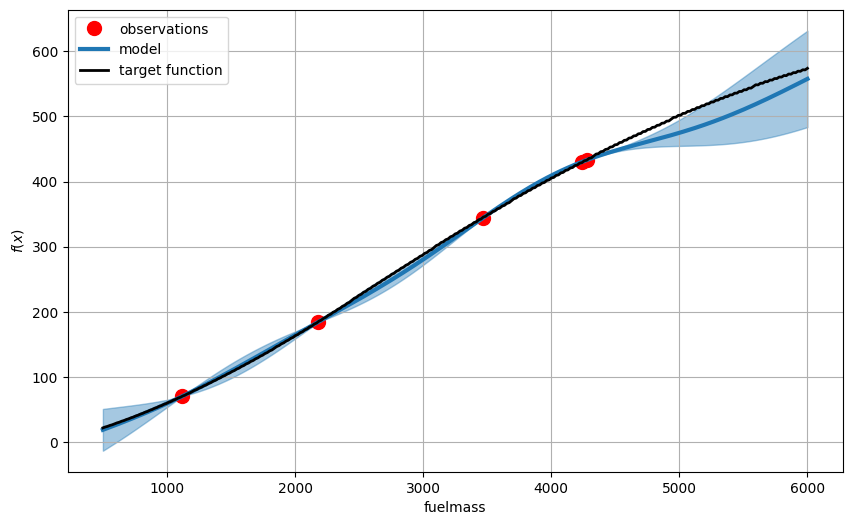

In [17]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=param_1_x_plot, y_plot=param_1_y_plot, 
                               mu_plot=mu_plot, var_plot=var_plot, 
                               model_emukit=model_emukit)

# 1. Two params

In [18]:
param_1 = 'fuelmass'
domain_param_1 = [500, 6000] # [5000,15000]
param_2 = 'Isp0'
domain_param_2 = [200, 300] # [224, 228]

space = ParameterSpace(
          [ContinuousParameter(param_1, *domain_param_1), 
           ContinuousParameter(param_2, *domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [param_1, param_2]

In [19]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## Experimental design


New simulation 

fuelmass: 5410.310837649653
Isp0: 231.06661601647


Stage 1 burnout
Velocity (km/s):  2.065781996603499
Angle (deg h):  43.65774659769829
Range (km):  45.02624175735854
Time (sec):  136.19999999999655
Final results: 
Range (km):  561.7809448495018
Apogee (km):  178.0172890252815
Time to target (sec):  492.30000000004344




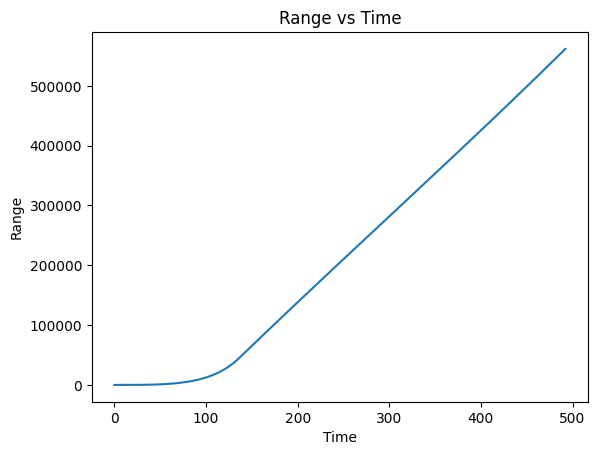

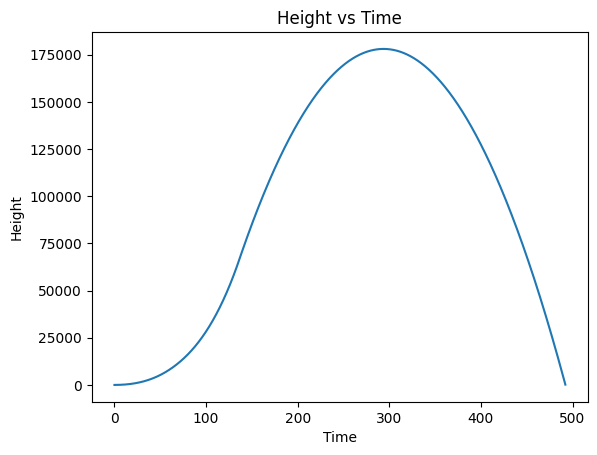

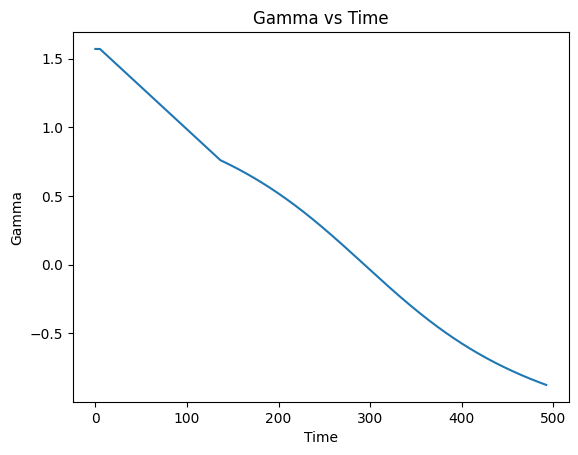

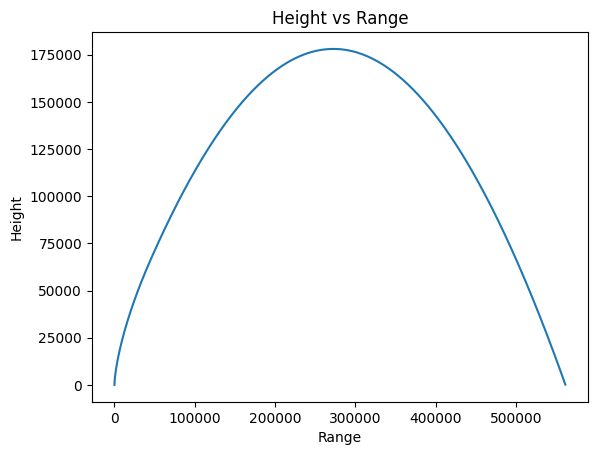

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5045.213516672459
Isp0: 283.0970391052808


Stage 1 burnout
Velocity (km/s):  2.5720958193966923
Angle (deg h):  43.646536219314115
Range (km):  64.98715435782299
Time (sec):  155.69999999999544
Final results: 
Range (km):  878.9718431750861
Apogee (km):  276.41799282726384
Time to target (sec):  613.700000000071




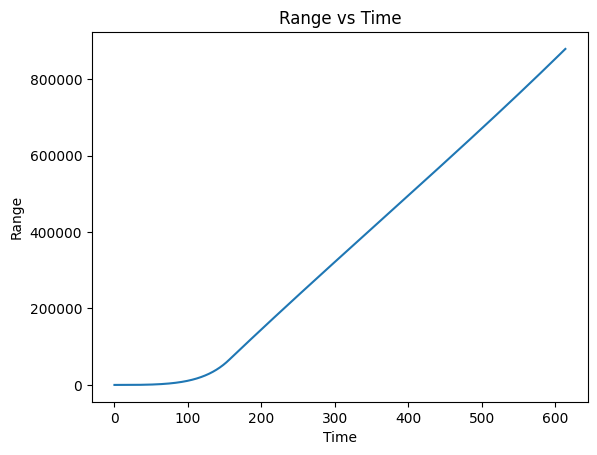

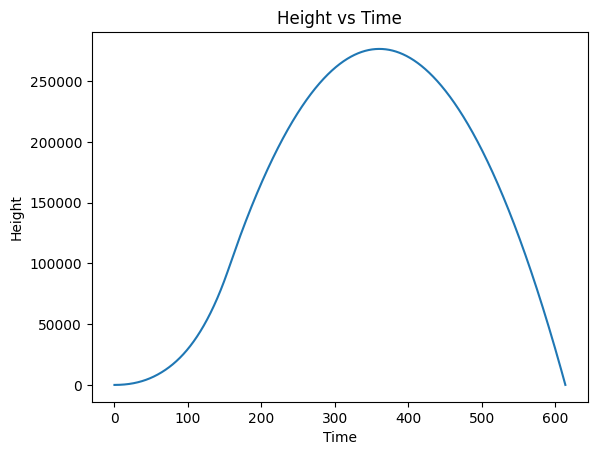

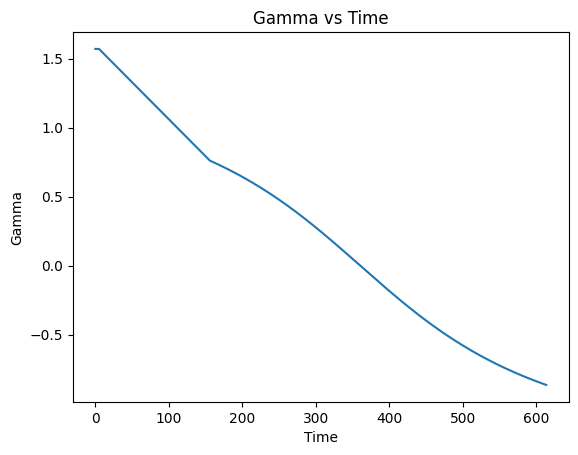

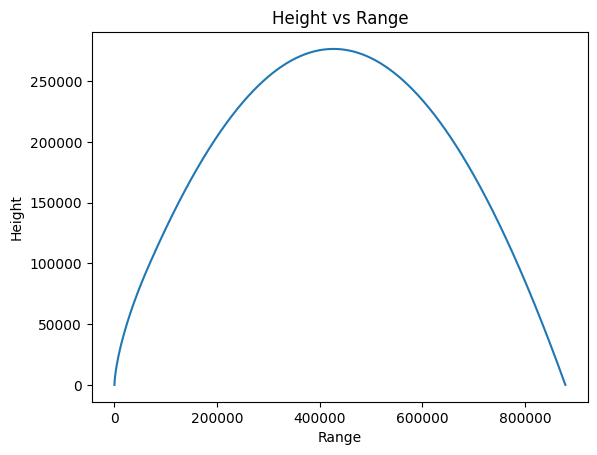

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 4452.850532141305
Isp0: 201.73886812657332


Stage 1 burnout
Velocity (km/s):  1.6302358872864613
Angle (deg h):  43.66871935265103
Range (km):  27.534576148382254
Time (sec):  97.89999999999871
Final results: 
Range (km):  345.0697191035178
Apogee (km):  109.76770019233446
Time to target (sec):  372.1000000000161




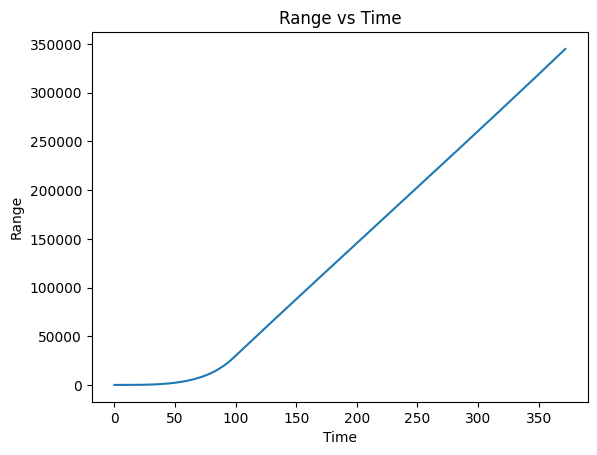

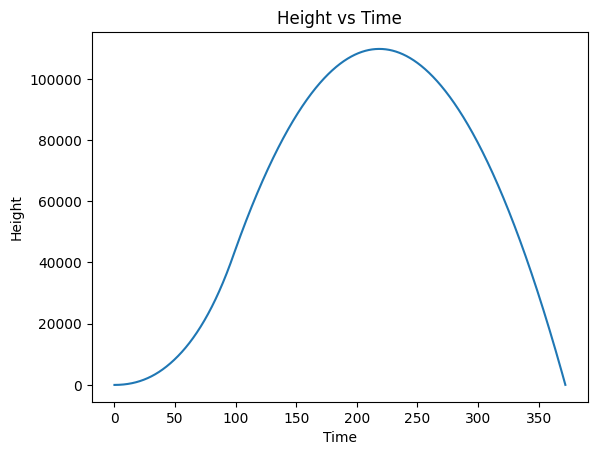

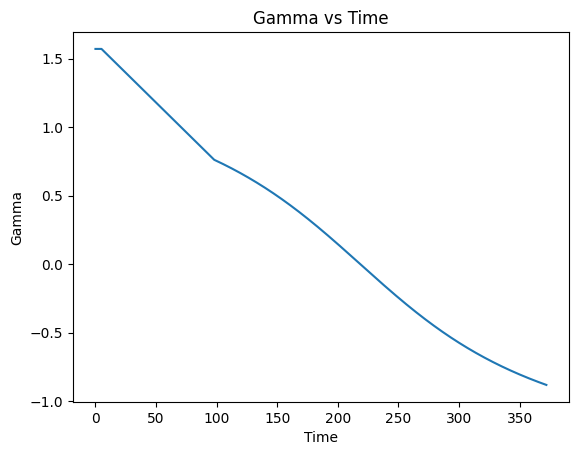

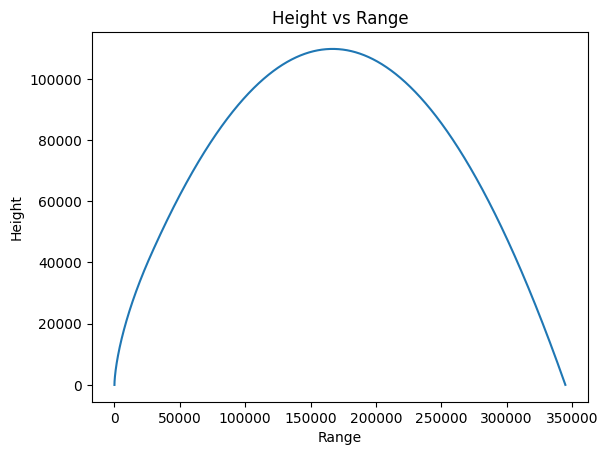

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 4158.842550992733
Isp0: 204.99069128709664


Stage 1 burnout
Velocity (km/s):  1.6078767636733284
Angle (deg h):  43.676338977713534
Range (km):  26.281223999320492
Time (sec):  92.899999999999
Final results: 
Range (km):  334.5610311725971
Apogee (km):  106.3360844814752
Time to target (sec):  362.700000000014




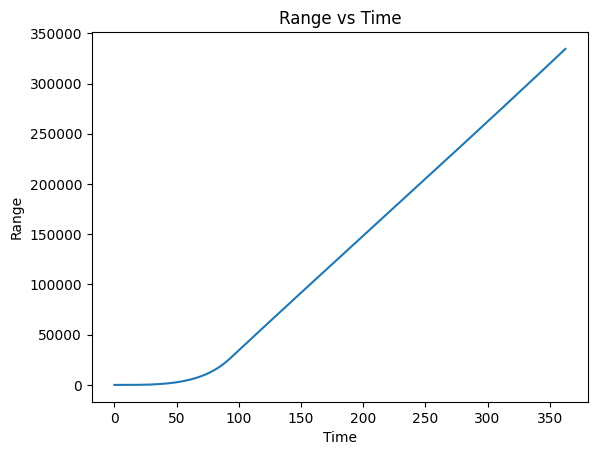

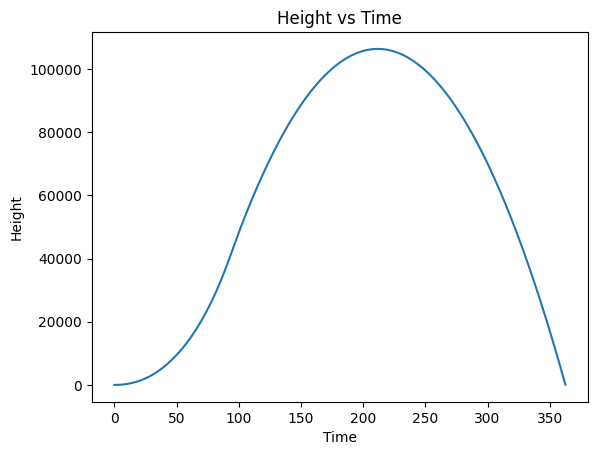

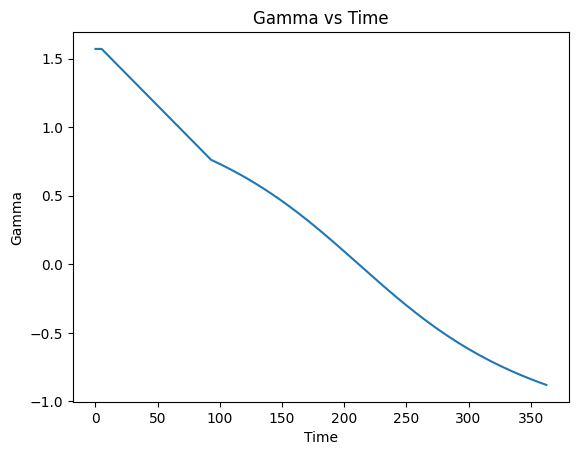

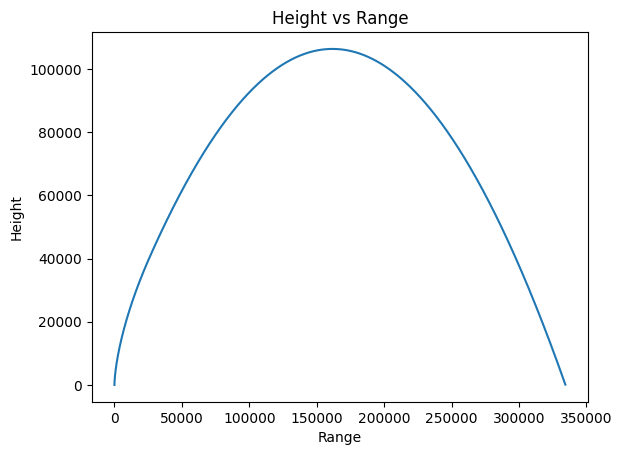

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 4284.335091960492
Isp0: 217.7735764050969


Stage 1 burnout
Velocity (km/s):  1.7521229625906125
Angle (deg h):  43.659929327944745
Range (km):  30.986222138371975
Time (sec):  101.6999999999985
Final results: 
Range (km):  398.17417183094454
Apogee (km):  126.14944555432693
Time to target (sec):  397.5000000000219




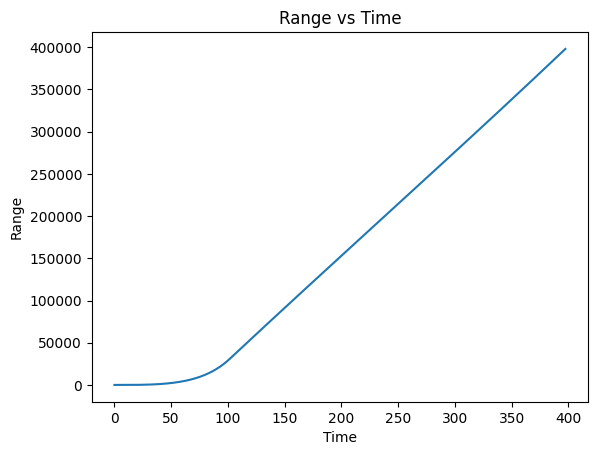

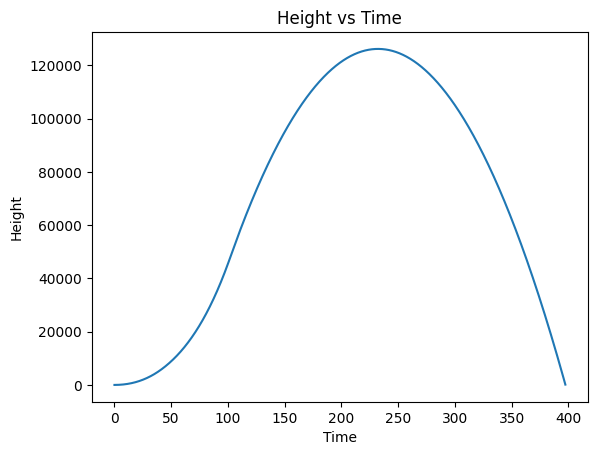

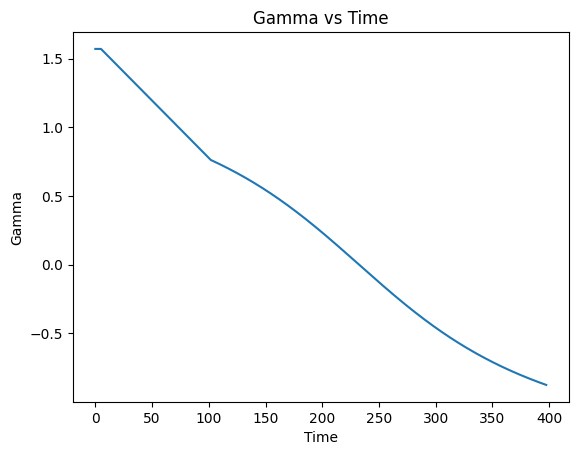

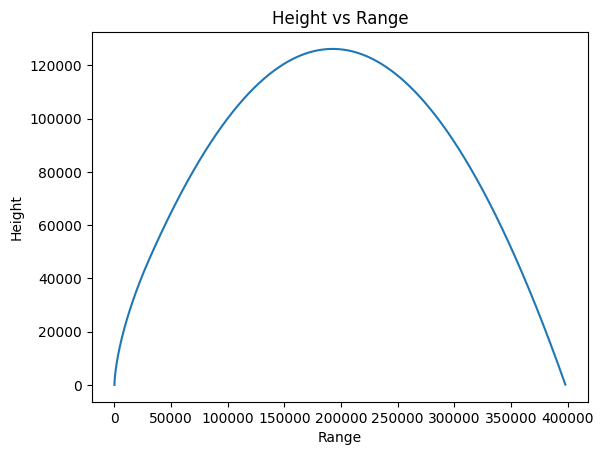

Data written to 'results/results_4.txt'


In [36]:
wirte_output_txt = True
design = RandomDesign(space)
x = design.get_samples(5)
y = run_missile_sim(x)

In [21]:
# Build model
var_kernel = (100)**2 
lengthscale = 1 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
kern = GPy.kern.RBF(input_dim=2, lengthscale=100 ) + \
    GPy.kern.Linear(input_dim=2)

model_gpy = GPRegression(x,y, kernel=kern)
model_gpy.kern.variance =  var_kernel 
model_gpy.likelihood.variance.fix(var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(model_gpy)




In [22]:
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


In [23]:
display(model_gpy)

In [24]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
param_1_x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, nr_points_plot)[:, None]
param_2_x_plot = np.linspace(space.parameters[1].min, space.parameters[1].max, nr_points_plot)[:, None]
x_plot_mesh, y_plot_mesh = np.meshgrid(param_1_x_plot, param_2_x_plot)
x_plot = np.array([x_plot_mesh, y_plot_mesh]).T.reshape(-1,2)
y_plot = run_missile_sim(x_plot)
Z = y_plot.reshape(x_plot_mesh.shape)

mu_plot, var_plot = model_emukit.predict(x_plot)
mu_plot = mu_plot.reshape(x_plot_mesh.shape)
var_plot = var_plot.reshape(x_plot_mesh.shape)




New simulation 

fuelmass: 500.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  0.3863951533111194
Angle (deg h):  44.303273558258816
Range (km):  0.7021541927471673
Time (sec):  10.899999999999979
Final results: 
Range (km):  17.636824612681625
Apogee (km):  5.550660716147016
Time to target (sec):  72.20000000000017



New simulation 

fuelmass: 500.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  0.38967604199687234
Angle (deg h):  43.94208082354192
Range (km):  0.7240062813757403
Time (sec):  10.999999999999979
Final results: 
Range (km):  17.96317033506219
Apogee (km):  5.594756677281375
Time to target (sec):  72.50000000000016



New simulation 

fuelmass: 500.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  0.3892973737911135
Angle (deg h):  43.69167768025086
Range (km):  0.7176808965590439
Time (sec):  10.999999999999979
Final results: 
Range (km):  17.95689831504086
Apogee (km):  5.5561922429727435
Time to target (sec):  72.30000000000017



New simulation 

fuelmass: 500.0

Final results: 
Range (km):  22.579106377677316
Apogee (km):  7.08290865918017
Time to target (sec):  81.69999999999963



New simulation 

fuelmass: 500.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  0.4383011437032569
Angle (deg h):  43.79906632943018
Range (km):  1.027834420276855
Time (sec):  12.699999999999973
Final results: 
Range (km):  22.924259532371646
Apogee (km):  7.135809132963735
Time to target (sec):  81.99999999999962



New simulation 

fuelmass: 500.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  0.43793916121921894
Angle (deg h):  44.12598296564955
Range (km):  1.0208046566455142
Time (sec):  12.699999999999973
Final results: 
Range (km):  22.873049849920843
Apogee (km):  7.186902299314828
Time to target (sec):  82.2999999999996



New simulation 

fuelmass: 500.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  0.44106191771652953
Angle (deg h):  43.84996227583207
Range (km):  1.0456407977052038
Time (sec):  12.799999999999972
Final results: 
Range (km):  23.219

Stage 1 burnout
Velocity (km/s):  0.47995771529117337
Angle (deg h):  43.7499099317351
Range (km):  1.3150757310817482
Time (sec):  14.199999999999967
Final results: 
Range (km):  27.660812603227264
Apogee (km):  8.630459961991017
Time to target (sec):  90.29999999999914



New simulation 

fuelmass: 500.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  0.4830614218209394
Angle (deg h):  43.93770596768864
Range (km):  1.3423182602364732
Time (sec):  14.299999999999967
Final results: 
Range (km):  28.017098727566363
Apogee (km):  8.779511903197113
Time to target (sec):  91.0999999999991



New simulation 

fuelmass: 500.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  0.48616765825945685
Angle (deg h):  43.70961111040158
Range (km):  1.3698122150613785
Time (sec):  14.399999999999967
Final results: 
Range (km):  28.388804636267004
Apogee (km):  8.842482238612046
Time to target (sec):  91.39999999999908



New simulation 

fuelmass: 500.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  

Apogee (km):  11.11430028487503
Time to target (sec):  102.69999999999844



New simulation 

fuelmass: 555.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  0.41556057159290155
Angle (deg h):  44.17351677722091
Range (km):  0.8943040306124005
Time (sec):  12.099999999999975
Final results: 
Range (km):  20.54394324763778
Apogee (km):  6.463341173840938
Time to target (sec):  78.09999999999984



New simulation 

fuelmass: 555.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  0.4186439701283229
Angle (deg h):  43.912555479523846
Range (km):  0.9170732965725135
Time (sec):  12.199999999999974
Final results: 
Range (km):  20.890148321465897
Apogee (km):  6.518344012815992
Time to target (sec):  78.49999999999982



New simulation 

fuelmass: 555.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  0.41821306321934776
Angle (deg h):  43.75279462407352
Range (km):  0.9095894660566533
Time (sec):  12.199999999999974
Final results: 
Range (km):  20.8558234832506
Apogee (km):  6.487431782252059
T

Final results: 
Range (km):  26.332457527688998
Apogee (km):  8.259234045846974
Time to target (sec):  88.39999999999925



New simulation 

fuelmass: 555.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  0.4716039777814468
Angle (deg h):  43.71910291994729
Range (km):  1.2849869514244538
Time (sec):  14.099999999999968
Final results: 
Range (km):  26.709937407568667
Apogee (km):  8.325038161320725
Time to target (sec):  88.79999999999923



New simulation 

fuelmass: 555.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  0.4711808845417389
Angle (deg h):  44.02677647409368
Range (km):  1.2766368236123937
Time (sec):  14.099999999999968
Final results: 
Range (km):  26.64918536453676
Apogee (km):  8.379570294761129
Time to target (sec):  89.09999999999921



New simulation 

fuelmass: 555.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  0.47422496583304
Angle (deg h):  43.823802303156256
Range (km):  1.3025536336384849
Time (sec):  14.199999999999967
Final results: 
Range (km):  27.0285

Final results: 
Range (km):  33.87061243332882
Apogee (km):  10.587202721441455
Time to target (sec):  100.29999999999858



New simulation 

fuelmass: 555.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  0.5324517640425721
Angle (deg h):  43.8531238956675
Range (km):  1.7598303390985053
Time (sec):  16.299999999999965
Final results: 
Range (km):  34.26012225078184
Apogee (km):  10.751319565962879
Time to target (sec):  101.09999999999853



New simulation 

fuelmass: 555.0
Isp0: 270.0


Stage 1 burnout
Velocity (km/s):  0.5355274261234011
Angle (deg h):  43.69015792185009
Range (km):  1.7892609486869604
Time (sec):  16.399999999999967
Final results: 
Range (km):  34.68205417925146
Apogee (km):  10.83125054035688
Time to target (sec):  101.49999999999851



New simulation 

fuelmass: 555.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  0.5351086553740809
Angle (deg h):  43.935916496247025
Range (km):  1.7799346440854131
Time (sec):  16.399999999999967
Final results: 
Range (km):  34.

Final results: 
Range (km):  24.209737058907105
Apogee (km):  7.540814473779253
Time to target (sec):  84.59999999999947



New simulation 

fuelmass: 610.0
Isp0: 203.0


Stage 1 burnout
Velocity (km/s):  0.4488089628535852
Angle (deg h):  44.06773271608576
Range (km):  1.13716980103774
Time (sec):  13.49999999999997
Final results: 
Range (km):  24.1320827430855
Apogee (km):  7.598300644088004
Time to target (sec):  84.89999999999945



New simulation 

fuelmass: 610.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  0.4517933753026819
Angle (deg h):  43.882543799832035
Range (km):  1.1609895109320647
Time (sec):  13.59999999999997
Final results: 
Range (km):  24.478446098448
Apogee (km):  7.665741226812134
Time to target (sec):  85.29999999999943



New simulation 

fuelmass: 610.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.4547776151574452
Angle (deg h):  43.70021473275814
Range (km):  1.1850139578927235
Time (sec):  13.699999999999969
Final results: 
Range (km):  24.8264801084

Final results: 
Range (km):  29.617376211097415
Apogee (km):  9.28085192769914
Time to target (sec):  93.99999999999893



New simulation 

fuelmass: 610.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  0.4984833776878274
Angle (deg h):  43.66481237086523
Range (km):  1.51543169270911
Time (sec):  15.299999999999963
Final results: 
Range (km):  29.993361900539043
Apogee (km):  9.35778493918062
Time to target (sec):  94.39999999999891



New simulation 

fuelmass: 610.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  0.4979917409568183
Angle (deg h):  43.96398259797888
Range (km):  1.505759234552989
Time (sec):  15.299999999999963
Final results: 
Range (km):  29.92046313839825
Apogee (km):  9.415737029257011
Time to target (sec):  94.6999999999989



New simulation 

fuelmass: 610.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  0.5009733789336518
Angle (deg h):  43.81163011185709
Range (km):  1.532291729444714
Time (sec):  15.399999999999963
Final results: 
Range (km):  30.2982682590

Final results: 
Range (km):  39.859590270631124
Apogee (km):  12.500446128664366
Time to target (sec):  109.29999999999806



New simulation 

fuelmass: 610.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  0.572576664401613
Angle (deg h):  43.69613700305068
Range (km):  2.13146538251473
Time (sec):  17.99999999999999
Final results: 
Range (km):  39.80699071885682
Apogee (km):  12.476257140017116
Time to target (sec):  109.19999999999807



New simulation 

fuelmass: 610.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  0.575646559575603
Angle (deg h):  43.86119962982588
Range (km):  2.162112601475868
Time (sec):  18.09999999999999
Final results: 
Range (km):  40.22356256249143
Apogee (km):  12.65568272846452
Time to target (sec):  109.99999999999802



New simulation 

fuelmass: 610.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  0.5787231524383533
Angle (deg h):  43.74179210831191
Range (km):  2.1929663822885264
Time (sec):  18.199999999999992
Final results: 
Range (km):  40.658940

Final results: 
Range (km):  46.914393472182596
Apogee (km):  14.747566935764509
Time to target (sec):  118.89999999999752



New simulation 

fuelmass: 610.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  0.623976511186245
Angle (deg h):  43.714500845822045
Range (km):  2.617403670905831
Time (sec):  19.800000000000015
Final results: 
Range (km):  47.424629402571526
Apogee (km):  14.852190728409516
Time to target (sec):  119.39999999999749



New simulation 

fuelmass: 610.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  0.6234967882756259
Angle (deg h):  43.67382130729929
Range (km):  2.605686298638218
Time (sec):  19.800000000000015
Final results: 
Range (km):  47.3193041112431
Apogee (km):  14.827733683627933
Time to target (sec):  119.1999999999975



New simulation 

fuelmass: 610.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  0.6265525292169335
Angle (deg h):  43.81636609462013
Range (km):  2.6391781107727432
Time (sec):  19.900000000000016
Final results: 
Range (km):  47.7

Final results: 
Range (km):  32.25000873136606
Apogee (km):  10.13468532694445
Time to target (sec):  98.39999999999868



New simulation 

fuelmass: 665.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  0.5191867323170359
Angle (deg h):  43.701220831311986
Range (km):  1.7084940179321306
Time (sec):  16.299999999999965
Final results: 
Range (km):  32.65840892543261
Apogee (km):  10.221344169968129
Time to target (sec):  98.89999999999866



New simulation 

fuelmass: 665.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  0.5186230204636065
Angle (deg h):  43.66571970011966
Range (km):  1.6975541010173598
Time (sec):  16.299999999999965
Final results: 
Range (km):  32.59519449912725
Apogee (km):  10.202425024448987
Time to target (sec):  98.79999999999866



New simulation 

fuelmass: 665.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  0.5215479006840178
Angle (deg h):  43.88320081661751
Range (km):  1.724264044990312
Time (sec):  16.399999999999967
Final results: 
Range (km):  32.944

Final results: 
Range (km):  39.19500246378562
Apogee (km):  12.305148344088511
Time to target (sec):  108.5999999999981



New simulation 

fuelmass: 665.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  0.5708419884430578
Angle (deg h):  43.887914092319086
Range (km):  2.1505267032412467
Time (sec):  18.199999999999992
Final results: 
Range (km):  39.63231640700264
Apogee (km):  12.48606217079898
Time to target (sec):  109.49999999999805



New simulation 

fuelmass: 665.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  0.5738391735606705
Angle (deg h):  43.790231534391054
Range (km):  2.180068938122398
Time (sec):  18.299999999999994
Final results: 
Range (km):  40.04374033585009
Apogee (km):  12.586116177920854
Time to target (sec):  109.89999999999803



New simulation 

fuelmass: 665.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  0.5768424669550548
Angle (deg h):  43.693613098157314
Range (km):  2.2097980367057786
Time (sec):  18.399999999999995
Final results: 
Range (km):  40

Final results: 
Range (km):  50.102155015024096
Apogee (km):  15.732546575324593
Time to target (sec):  123.09999999999728



New simulation 

fuelmass: 665.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  0.6437567719091363
Angle (deg h):  43.65789023944369
Range (km):  2.855376641446825
Time (sec):  20.80000000000003
Final results: 
Range (km):  50.60546120151453
Apogee (km):  15.846014099461813
Time to target (sec):  123.59999999999725



New simulation 

fuelmass: 665.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  0.6432081710097498
Angle (deg h):  43.87035211261912
Range (km):  2.8421790798357436
Time (sec):  20.80000000000003
Final results: 
Range (km):  50.474189679032584
Apogee (km):  15.91206085616677
Time to target (sec):  123.79999999999724



New simulation 

fuelmass: 665.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  0.6461904266338654
Angle (deg h):  43.78883657809986
Range (km):  2.8756370478513857
Time (sec):  20.90000000000003
Final results: 
Range (km):  50.97

Final results: 
Range (km):  34.28733253952556
Apogee (km):  10.768412062982215
Time to target (sec):  101.6999999999985



New simulation 

fuelmass: 720.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  0.5342274978504623
Angle (deg h):  43.66893405002114
Range (km):  1.863688702437772
Time (sec):  17.099999999999977
Final results: 
Range (km):  34.649669935752385
Apogee (km):  10.86313132018978
Time to target (sec):  102.09999999999847



New simulation 

fuelmass: 720.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  0.5335851319265429
Angle (deg h):  43.66184720423958
Range (km):  1.851495865738503
Time (sec):  17.099999999999977
Final results: 
Range (km):  34.602435037647574
Apogee (km):  10.848701265747799
Time to target (sec):  102.09999999999847



New simulation 

fuelmass: 720.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  0.5364518229396518
Angle (deg h):  43.88484402395839
Range (km):  1.8780359389149344
Time (sec):  17.199999999999978
Final results: 
Range (km):  34.9

Stage 1 burnout
Velocity (km/s):  0.5855367852235
Angle (deg h):  43.86602121889895
Range (km):  2.3167849716302995
Time (sec):  19.000000000000004
Final results: 
Range (km):  41.78406085227442
Apogee (km):  13.178384496697372
Time to target (sec):  112.69999999999787



New simulation 

fuelmass: 720.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  0.5884729789600767
Angle (deg h):  43.793696664436915
Range (km):  2.3460606051760013
Time (sec):  19.100000000000005
Final results: 
Range (km):  42.228212226668155
Apogee (km):  13.286446067814627
Time to target (sec):  113.19999999999784



New simulation 

fuelmass: 720.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  0.5914084502312166
Angle (deg h):  43.7221757851153
Range (km):  2.375508859034518
Time (sec):  19.200000000000006
Final results: 
Range (km):  42.631676641223194
Apogee (km):  13.394914394551359
Time to target (sec):  113.59999999999782



New simulation 

fuelmass: 720.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s): 

Stage 1 burnout
Velocity (km/s):  0.6622324432322759
Angle (deg h):  43.6786502471375
Range (km):  3.0791548342765944
Time (sec):  21.800000000000043
Final results: 
Range (km):  53.655211378839454
Apogee (km):  16.85784416052791
Time to target (sec):  127.69999999999702



New simulation 

fuelmass: 720.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  0.6651410093832009
Angle (deg h):  43.83320093723242
Range (km):  3.1124462083222117
Time (sec):  21.900000000000045
Final results: 
Range (km):  54.112295654328676
Apogee (km):  17.06519863715394
Time to target (sec):  128.499999999997



New simulation 

fuelmass: 720.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  0.668049841114195
Angle (deg h):  43.773427905477895
Range (km):  3.1459060608169014
Time (sec):  22.000000000000046
Final results: 
Range (km):  54.611479416159675
Apogee (km):  17.188672592414587
Time to target (sec):  128.99999999999696



New simulation 

fuelmass: 720.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  35.54239833011495
Apogee (km):  11.207169229628562
Time to target (sec):  103.89999999999837



New simulation 

fuelmass: 775.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  0.5433746184106907
Angle (deg h):  43.756955307626384
Range (km):  1.9694639853700497
Time (sec):  17.699999999999985
Final results: 
Range (km):  35.931378899004045
Apogee (km):  11.308455990791956
Time to target (sec):  104.39999999999834



New simulation 

fuelmass: 775.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  0.5461771176749736
Angle (deg h):  43.69946262567482
Range (km):  1.995551230040136
Time (sec):  17.799999999999986
Final results: 
Range (km):  36.3225087678275
Apogee (km):  11.410316998576912
Time to target (sec):  104.89999999999831



New simulation 

fuelmass: 775.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  0.5454530023497884
Angle (deg h):  43.7167138870855
Range (km):  1.9821442720888676
Time (sec):  17.799999999999986
Final results: 
Range (km):  36.

Final results: 
Range (km):  47.34539444688159
Apogee (km):  14.857861948466448
Time to target (sec):  119.99999999999746



New simulation 

fuelmass: 775.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  0.6214063114268644
Angle (deg h):  43.66555077526753
Range (km):  2.6954722864779126
Time (sec):  20.600000000000026
Final results: 
Range (km):  47.220752234048675
Apogee (km):  14.847329782830268
Time to target (sec):  119.89999999999746



New simulation 

fuelmass: 775.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  0.6242469460528496
Angle (deg h):  43.85026956160784
Range (km):  2.725490474653702
Time (sec):  20.700000000000028
Final results: 
Range (km):  47.67386986956639
Apogee (km):  15.046784271173003
Time to target (sec):  120.79999999999741



New simulation 

fuelmass: 775.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  0.6270869440201385
Angle (deg h):  43.80340256144448
Range (km):  2.755662245047255
Time (sec):  20.80000000000003
Final results: 
Range (km):  48.0

Final results: 
Range (km):  57.32537078452613
Apogee (km):  18.092127334201948
Time to target (sec):  132.59999999999675



New simulation 

fuelmass: 775.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  0.6866612388432104
Angle (deg h):  43.77124516677094
Range (km):  3.391484688378599
Time (sec):  23.00000000000006
Final results: 
Range (km):  57.81611700566627
Apogee (km):  18.223950244750103
Time to target (sec):  133.09999999999673



New simulation 

fuelmass: 775.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  0.6894981237716153
Angle (deg h):  43.73068501621447
Range (km):  3.424849639450166
Time (sec):  23.100000000000062
Final results: 
Range (km):  58.30888114123235
Apogee (km):  18.356303942911595
Time to target (sec):  133.5999999999967



New simulation 

fuelmass: 775.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  0.6923357690791316
Angle (deg h):  43.69050324368261
Range (km):  3.4583683938037924
Time (sec):  23.200000000000063
Final results: 
Range (km):  58.803

Stage 1 burnout
Velocity (km/s):  0.5469086522372296
Angle (deg h):  43.88817376819321
Range (km):  2.0262179092709354
Time (sec):  18.09999999999999
Final results: 
Range (km):  36.48684705001956
Apogee (km):  11.53382847569514
Time to target (sec):  105.69999999999827



New simulation 

fuelmass: 830.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  0.5496344590249911
Angle (deg h):  43.852742066841216
Range (km):  2.0514485990094675
Time (sec):  18.199999999999992
Final results: 
Range (km):  36.82238717371908
Apogee (km):  11.640619205946749
Time to target (sec):  106.09999999999825



New simulation 

fuelmass: 830.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  0.5523639806902115
Angle (deg h):  43.81779572004928
Range (km):  2.076816507680248
Time (sec):  18.299999999999994
Final results: 
Range (km):  37.199389024878876
Apogee (km):  11.748034789400357
Time to target (sec):  106.59999999999822



New simulation 

fuelmass: 830.0
Isp0: 203.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  47.326630291457505
Apogee (km):  14.96762483502702
Time to target (sec):  120.59999999999742



New simulation 

fuelmass: 830.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  0.6245391036625035
Angle (deg h):  43.823882233750396
Range (km):  2.7651230679512797
Time (sec):  21.000000000000032
Final results: 
Range (km):  47.754118122927466
Apogee (km):  15.09086364933798
Time to target (sec):  121.0999999999974



New simulation 

fuelmass: 830.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  0.6272990926575763
Angle (deg h):  43.7952340317643
Range (km):  2.7941715012492203
Time (sec):  21.100000000000033
Final results: 
Range (km):  48.18338253566045
Apogee (km):  15.214601898024009
Time to target (sec):  121.59999999999737



New simulation 

fuelmass: 830.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  0.6300585820935869
Angle (deg h):  43.76690737806321
Range (km):  2.823359919754129
Time (sec):  21.200000000000035
Final results: 
Range (km):  48.6

Final results: 
Range (km):  61.576403071222295
Apogee (km):  19.40423562590092
Time to target (sec):  137.69999999999646



New simulation 

fuelmass: 830.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  0.7104538138782084
Angle (deg h):  43.708668140984436
Range (km):  3.7087498865819466
Time (sec):  24.200000000000077
Final results: 
Range (km):  62.062180375443226
Apogee (km):  19.545323931509877
Time to target (sec):  138.19999999999644



New simulation 

fuelmass: 830.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  0.7132206942277712
Angle (deg h):  43.68529911465564
Range (km):  3.742053635000712
Time (sec):  24.30000000000008
Final results: 
Range (km):  62.54979966824083
Apogee (km):  19.686942076518687
Time to target (sec):  138.6999999999964



New simulation 

fuelmass: 830.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  0.7159888160515091
Angle (deg h):  43.66214943969027
Range (km):  3.7754985743380414
Time (sec):  24.40000000000008
Final results: 
Range (km):  63.0

Final results: 
Range (km):  42.325184105497165
Apogee (km):  13.363236555750595
Time to target (sec):  114.09999999999779



New simulation 

fuelmass: 885.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  0.5905385191579335
Angle (deg h):  43.77291243359059
Range (km):  2.4634563514923142
Time (sec):  20.000000000000018
Final results: 
Range (km):  42.71121745644482
Apogee (km):  13.483254449487788
Time to target (sec):  114.59999999999776



New simulation 

fuelmass: 885.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  0.593226240227959
Angle (deg h):  43.761014042427526
Range (km):  2.489741221978083
Time (sec):  20.10000000000002
Final results: 
Range (km):  43.098871851440705
Apogee (km):  13.603783259605246
Time to target (sec):  115.09999999999773



New simulation 

fuelmass: 885.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  0.5959120984810214
Angle (deg h):  43.74926815913113
Range (km):  2.516154065253194
Time (sec):  20.20000000000002
Final results: 
Range (km):  43.4

Final results: 
Range (km):  53.833754750164466
Apogee (km):  16.995873316265946
Time to target (sec):  128.89999999999696



New simulation 

fuelmass: 885.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  0.6646078424621292
Angle (deg h):  43.74163242548868
Range (km):  3.2295554359772405
Time (sec):  22.800000000000058
Final results: 
Range (km):  54.26665807544282
Apogee (km):  17.130809699842633
Time to target (sec):  129.39999999999694



New simulation 

fuelmass: 885.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  0.6672809625827684
Angle (deg h):  43.731791854984166
Range (km):  3.2593643379064416
Time (sec):  22.90000000000006
Final results: 
Range (km):  54.749539601006944
Apogee (km):  17.266300023241854
Time to target (sec):  129.9999999999969



New simulation 

fuelmass: 885.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  0.6699545364075653
Angle (deg h):  43.72205782768153
Range (km):  3.2893016985504544
Time (sec):  23.00000000000006
Final results: 
Range (km):  55

Final results: 
Range (km):  70.30257272897484
Apogee (km):  22.144077118819286
Time to target (sec):  147.4999999999959



New simulation 

fuelmass: 885.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  0.7578367124279957
Angle (deg h):  43.6623575751588
Range (km):  4.329017076706473
Time (sec):  26.300000000000107
Final results: 
Range (km):  70.85415847877228
Apogee (km):  22.299892228772798
Time to target (sec):  148.09999999999587



New simulation 

fuelmass: 885.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  0.7605514152093381
Angle (deg h):  43.65449955213589
Range (km):  4.363298264468794
Time (sec):  26.40000000000011
Final results: 
Range (km):  71.35293217128594
Apogee (km):  22.45634265083655
Time to target (sec):  148.59999999999584



New simulation 

fuelmass: 885.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  0.7632673720103897
Angle (deg h):  43.64671279107657
Range (km):  4.397707978350092
Time (sec):  26.50000000000011
Final results: 
Range (km):  71.8535154

Final results: 
Range (km):  48.37804830641242
Apogee (km):  15.268231432655568
Time to target (sec):  122.29999999999733



New simulation 

fuelmass: 940.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):  0.6299057578216792
Angle (deg h):  43.69665858615311
Range (km):  2.8890559881235034
Time (sec):  21.800000000000043
Final results: 
Range (km):  48.76842010334277
Apogee (km):  15.399330163341887
Time to target (sec):  122.7999999999973



New simulation 

fuelmass: 940.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  0.6324946020698514
Angle (deg h):  43.70302563942212
Range (km):  2.9160340045012783
Time (sec):  21.900000000000045
Final results: 
Range (km):  49.16041571311485
Apogee (km):  15.531002378078727
Time to target (sec):  123.29999999999727



New simulation 

fuelmass: 940.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  0.6386447509820224
Angle (deg h):  43.64592711779059
Range (km):  2.9892261314196658
Time (sec):  22.100000000000048
Final results: 
Range (km):  50.

Final results: 
Range (km):  60.9528847346181
Apogee (km):  19.295217646935978
Time to target (sec):  137.69999999999646



New simulation 

fuelmass: 940.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  0.7059797358928095
Angle (deg h):  43.792821800470406
Range (km):  3.7399360433745183
Time (sec):  24.700000000000085
Final results: 
Range (km):  61.442634402567506
Apogee (km):  19.442649081185195
Time to target (sec):  138.29999999999643



New simulation 

fuelmass: 940.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  0.7085789638258266
Angle (deg h):  43.797692020117616
Range (km):  3.77041067558245
Time (sec):  24.800000000000086
Final results: 
Range (km):  61.8832202118652
Apogee (km):  19.59068070719256
Time to target (sec):  138.7999999999964



New simulation 

fuelmass: 940.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  0.7111800099474536
Angle (deg h):  43.802512839752346
Range (km):  3.80100772116648
Time (sec):  24.900000000000087
Final results: 
Range (km):  62.376

Final results: 
Range (km):  76.76894411799715
Apogee (km):  24.23763674441999
Time to target (sec):  154.6999999999955



New simulation 

fuelmass: 940.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  0.7909260222830935
Angle (deg h):  43.721091355146044
Range (km):  4.797788008951678
Time (sec):  27.90000000000013
Final results: 
Range (km):  77.32319968894163
Apogee (km):  24.405318753383753
Time to target (sec):  155.29999999999546



New simulation 

fuelmass: 940.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  0.7935846593577033
Angle (deg h):  43.72562610372375
Range (km):  4.832205464386622
Time (sec):  28.00000000000013
Final results: 
Range (km):  77.82213984753416
Apogee (km):  24.57364239613299
Time to target (sec):  155.79999999999544



New simulation 

fuelmass: 940.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  0.7962458848444459
Angle (deg h):  43.73012111354484
Range (km):  4.866746328533042
Time (sec):  28.100000000000133
Final results: 
Range (km):  78.380530

Stage 1 burnout
Velocity (km/s):  0.630069026560464
Angle (deg h):  43.69785338096771
Range (km):  2.9261848599724627
Time (sec):  22.100000000000048
Final results: 
Range (km):  48.86171326561525
Apogee (km):  15.447957889134635
Time to target (sec):  123.19999999999727



New simulation 

fuelmass: 995.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.6361354846824336
Angle (deg h):  43.65657862410768
Range (km):  2.9978985514089
Time (sec):  22.30000000000005
Final results: 
Range (km):  49.81838157198288
Apogee (km):  15.715057489021909
Time to target (sec):  124.29999999999721



New simulation 

fuelmass: 995.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  0.6386293895928862
Angle (deg h):  43.67893205263229
Range (km):  3.023975841134328
Time (sec):  22.400000000000052
Final results: 
Range (km):  50.193620448789
Apogee (km):  15.850720803717193
Time to target (sec):  124.79999999999718



New simulation 

fuelmass: 995.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  0.641

Stage 1 burnout
Velocity (km/s):  0.713291861303134
Angle (deg h):  43.734996573079314
Range (km):  3.8720933023225976
Time (sec):  25.300000000000093
Final results: 
Range (km):  62.84136002457011
Apogee (km):  19.870027202958735
Time to target (sec):  140.09999999999633



New simulation 

fuelmass: 995.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  0.7158073165597832
Angle (deg h):  43.75362409474687
Range (km):  3.9015908765342204
Time (sec):  25.400000000000095
Final results: 
Range (km):  63.26489155371274
Apogee (km):  20.022788005582992
Time to target (sec):  140.5999999999963



New simulation 

fuelmass: 995.0
Isp0: 235.0


Stage 1 burnout
Velocity (km/s):  0.7183241915722682
Angle (deg h):  43.77205510660033
Range (km):  3.931202064700085
Time (sec):  25.500000000000096
Final results: 
Range (km):  63.74193768133862
Apogee (km):  20.176156732461045
Time to target (sec):  141.19999999999627



New simulation 

fuelmass: 995.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s): 

Stage 1 burnout
Velocity (km/s):  0.8029218710975832
Angle (deg h):  43.64479926880417
Range (km):  5.011151119097203
Time (sec):  28.70000000000014
Final results: 
Range (km):  79.82058079685595
Apogee (km):  25.16026331548069
Time to target (sec):  157.9999999999953



New simulation 

fuelmass: 995.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  0.8055041917147098
Angle (deg h):  43.66121920615591
Range (km):  5.044651965872057
Time (sec):  28.800000000000143
Final results: 
Range (km):  80.30385585280102
Apogee (km):  25.334784904229835
Time to target (sec):  158.49999999999528



New simulation 

fuelmass: 995.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  0.8080893219217576
Angle (deg h):  43.67749033942182
Range (km):  5.078268393299255
Time (sec):  28.900000000000144
Final results: 
Range (km):  80.8474108503535
Apogee (km):  25.510004064752838
Time to target (sec):  159.09999999999525



New simulation 

fuelmass: 995.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  0.81

Final results: 
Range (km):  100.42298748777411
Apogee (km):  31.624506145336845
Time to target (sec):  177.5999999999942



New simulation 

fuelmass: 995.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  0.902519539369714
Angle (deg h):  43.67977015195778
Range (km):  6.382870251817887
Time (sec):  32.40000000000019
Final results: 
Range (km):  100.97614459055035
Apogee (km):  31.82535113182801
Time to target (sec):  178.09999999999417



New simulation 

fuelmass: 995.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  0.908943992778347
Angle (deg h):  43.649736518007764
Range (km):  6.486421063852222
Time (sec):  32.60000000000019
Final results: 
Range (km):  102.44827826051504
Apogee (km):  32.22586102678018
Time to target (sec):  179.2999999999941



New simulation 

fuelmass: 1050.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  0.643347884441935
Angle (deg h):  43.80136803693211
Range (km):  3.107268646736638
Time (sec):  22.90000000000006
Final results: 
Range (km):  51.0352366

Stage 1 burnout
Velocity (km/s):  0.7457856752199731
Angle (deg h):  43.78045659143397
Range (km):  4.314245150927393
Time (sec):  26.900000000000116
Final results: 
Range (km):  68.85374122644872
Apogee (km):  21.824300591098545
Time to target (sec):  147.19999999999592



New simulation 

fuelmass: 1050.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  0.748230668780554
Angle (deg h):  43.65314723322792
Range (km):  4.34380407903115
Time (sec):  27.000000000000117
Final results: 
Range (km):  69.28582271627758
Apogee (km):  21.908849345744077
Time to target (sec):  147.3999999999959



New simulation 

fuelmass: 1050.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  0.7506780560016271
Angle (deg h):  43.6833383810645
Range (km):  4.373469444947647
Time (sec):  27.10000000000012
Final results: 
Range (km):  69.76386897454223
Apogee (km):  22.072690113231406
Time to target (sec):  147.99999999999588



New simulation 

fuelmass: 1050.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  0.

Final results: 
Range (km):  89.81625825670346
Apogee (km):  28.431686350443947
Time to target (sec):  168.39999999999472



New simulation 

fuelmass: 1050.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  0.8535709331071888
Angle (deg h):  43.66063251794657
Range (km):  5.748210788446737
Time (sec):  31.000000000000174
Final results: 
Range (km):  90.3733596908033
Apogee (km):  28.536254795609537
Time to target (sec):  168.6999999999947



New simulation 

fuelmass: 1050.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  0.8561200182836728
Angle (deg h):  43.686162323961085
Range (km):  5.78242341988561
Time (sec):  31.100000000000176
Final results: 
Range (km):  90.92958524692654
Apogee (km):  28.727356924301915
Time to target (sec):  169.29999999999467



New simulation 

fuelmass: 1050.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  0.862354313923232
Angle (deg h):  43.664920691132735
Range (km):  5.878934014034949
Time (sec):  31.30000000000018
Final results: 
Range (km):  92.29

Final results: 
Range (km):  108.72889642263468
Apogee (km):  34.3060866360958
Time to target (sec):  185.39999999999375



New simulation 

fuelmass: 1050.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  0.938516231753209
Angle (deg h):  43.75897111773421
Range (km):  6.978851333921546
Time (sec):  34.100000000000215
Final results: 
Range (km):  109.34872239388264
Apogee (km):  34.52018132030698
Time to target (sec):  185.99999999999372



New simulation 

fuelmass: 1050.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  0.9411602881794876
Angle (deg h):  43.665143028664886
Range (km):  7.016765930556892
Time (sec):  34.200000000000216
Final results: 
Range (km):  109.96951820179365
Apogee (km):  34.64240076839766
Time to target (sec):  186.2999999999937



New simulation 

fuelmass: 1050.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  0.9475948731298829
Angle (deg h):  43.64563445729032
Range (km):  7.123132720640968
Time (sec):  34.40000000000022
Final results: 
Range (km):  111.4

Final results: 
Range (km):  71.12993088245227
Apogee (km):  22.57646654809076
Time to target (sec):  149.99999999999577



New simulation 

fuelmass: 1105.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  0.7597995276832443
Angle (deg h):  43.6780971379022
Range (km):  4.537062774272234
Time (sec):  27.80000000000013
Final results: 
Range (km):  71.59744451915003
Apogee (km):  22.667250379374778
Time to target (sec):  150.29999999999575



New simulation 

fuelmass: 1105.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  0.7657591973741226
Angle (deg h):  43.66658520854488
Range (km):  4.6210374697707906
Time (sec):  28.00000000000013
Final results: 
Range (km):  72.71287805258399
Apogee (km):  22.997930400357692
Time to target (sec):  151.39999999999569



New simulation 

fuelmass: 1105.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  0.7681241415829478
Angle (deg h):  43.70745237818161
Range (km):  4.650012901086077
Time (sec):  28.100000000000133
Final results: 
Range (km):  73.18

Final results: 
Range (km):  92.92445450292396
Apogee (km):  29.412456922922495
Time to target (sec):  171.69999999999453



New simulation 

fuelmass: 1105.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  0.8672629990061489
Angle (deg h):  43.663182472642944
Range (km):  5.998806212010373
Time (sec):  31.900000000000187
Final results: 
Range (km):  93.46240882468838
Apogee (km):  29.524079820042378
Time to target (sec):  171.99999999999451



New simulation 

fuelmass: 1105.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  0.8734381321756268
Angle (deg h):  43.652172171186464
Range (km):  6.095004926935498
Time (sec):  32.100000000000186
Final results: 
Range (km):  94.75710792552894
Apogee (km):  29.911244952990547
Time to target (sec):  173.09999999999445



New simulation 

fuelmass: 1105.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  0.8759137483440688
Angle (deg h):  43.68695941368946
Range (km):  6.128456571346241
Time (sec):  32.20000000000019
Final results: 
Range (km):  9

Final results: 
Range (km):  114.63158369120005
Apogee (km):  36.170302631139606
Time to target (sec):  190.79999999999345



New simulation 

fuelmass: 1105.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  0.962895409569932
Angle (deg h):  43.760167965619715
Range (km):  7.414197576347219
Time (sec):  35.40000000000023
Final results: 
Range (km):  115.24229252639525
Apogee (km):  36.39405868265289
Time to target (sec):  191.3999999999934



New simulation 

fuelmass: 1105.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  0.9654725213582551
Angle (deg h):  43.680145570764594
Range (km):  7.451412926903469
Time (sec):  35.500000000000234
Final results: 
Range (km):  115.91921006812164
Apogee (km):  36.52584738619068
Time to target (sec):  191.7999999999934



New simulation 

fuelmass: 1105.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  0.9718803221284745
Angle (deg h):  43.66977969887911
Range (km):  7.558791739584733
Time (sec):  35.70000000000024
Final results: 
Range (km):  117.

Final results: 
Range (km):  74.86458224766042
Apogee (km):  23.732711633926186
Time to target (sec):  154.09999999999553



New simulation 

fuelmass: 1160.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  0.7822414602067297
Angle (deg h):  43.686495511686076
Range (km):  4.884719445303259
Time (sec):  29.000000000000146
Final results: 
Range (km):  75.9842304569283
Apogee (km):  24.0741400688051
Time to target (sec):  155.19999999999547



New simulation 

fuelmass: 1160.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  0.7845236445002552
Angle (deg h):  43.73706332721493
Range (km):  4.912904227122533
Time (sec):  29.100000000000147
Final results: 
Range (km):  76.43988582846461
Apogee (km):  24.251009985979138
Time to target (sec):  155.79999999999544



New simulation 

fuelmass: 1160.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  0.7868089727949448
Angle (deg h):  43.78710357276665
Range (km):  4.941186023470845
Time (sec):  29.20000000000015
Final results: 
Range (km):  76.89

Final results: 
Range (km):  97.19776134448763
Apogee (km):  30.74836862716755
Time to target (sec):  175.8999999999943



New simulation 

fuelmass: 1160.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  0.8862983473929251
Angle (deg h):  43.75422427923106
Range (km):  6.333407972744036
Time (sec):  33.0000000000002
Final results: 
Range (km):  97.72492448806076
Apogee (km):  30.95256309127614
Time to target (sec):  176.49999999999426



New simulation 

fuelmass: 1160.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  0.8886907837913405
Angle (deg h):  43.67740110694334
Range (km):  6.365755360663904
Time (sec):  33.1000000000002
Final results: 
Range (km):  98.24782733840125
Apogee (km):  31.072398573907215
Time to target (sec):  176.79999999999424



New simulation 

fuelmass: 1160.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  0.8948216385685414
Angle (deg h):  43.67581174654697
Range (km):  6.462710277984715
Time (sec):  33.3000000000002
Final results: 
Range (km):  99.61837537

Final results: 
Range (km):  118.60232235043088
Apogee (km):  37.43199721774062
Time to target (sec):  194.49999999999324



New simulation 

fuelmass: 1160.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  0.9787036780500243
Angle (deg h):  43.654446941538794
Range (km):  7.726536322971977
Time (sec):  36.40000000000025
Final results: 
Range (km):  119.2571362798849
Apogee (km):  37.57044171341466
Time to target (sec):  194.8999999999932



New simulation 

fuelmass: 1160.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  0.9850533371493364
Angle (deg h):  43.652683602926906
Range (km):  7.833621593222955
Time (sec):  36.60000000000025
Final results: 
Range (km):  120.79018234539704
Apogee (km):  38.02438675422009
Time to target (sec):  196.09999999999314



New simulation 

fuelmass: 1160.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  0.9875541072142817
Angle (deg h):  43.691298120375684
Range (km):  7.869932185738611
Time (sec):  36.70000000000025
Final results: 
Range (km):  121.

Final results: 
Range (km):  71.86716954637814
Apogee (km):  22.819985334590573
Time to target (sec):  151.2999999999957



New simulation 

fuelmass: 1215.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  0.762570752790358
Angle (deg h):  43.78730999576178
Range (km):  4.66792706866857
Time (sec):  28.60000000000014
Final results: 
Range (km):  72.28542936949914
Apogee (km):  22.993125222479208
Time to target (sec):  151.89999999999566



New simulation 

fuelmass: 1215.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  0.7683507406731215
Angle (deg h):  43.6544836201612
Range (km):  4.749324843535166
Time (sec):  28.800000000000143
Final results: 
Range (km):  73.41535606791366
Apogee (km):  23.25457201435516
Time to target (sec):  152.7999999999956



New simulation 

fuelmass: 1215.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  0.77051911386016
Angle (deg h):  43.71729599724979
Range (km):  4.775488843465807
Time (sec):  28.900000000000144
Final results: 
Range (km):  73.83858232

Final results: 
Range (km):  89.29491599362692
Apogee (km):  28.281683051049118
Time to target (sec):  168.7999999999947



New simulation 

fuelmass: 1215.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  0.8527854841241992
Angle (deg h):  43.66969858487556
Range (km):  5.911451946648397
Time (sec):  32.100000000000186
Final results: 
Range (km):  90.56809062759679
Apogee (km):  28.66230994403745
Time to target (sec):  169.99999999999463



New simulation 

fuelmass: 1215.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  0.8550392549470114
Angle (deg h):  43.72480158276627
Range (km):  5.94083221196408
Time (sec):  32.20000000000019
Final results: 
Range (km):  91.04784927214011
Apogee (km):  28.859746818472907
Time to target (sec):  170.5999999999946



New simulation 

fuelmass: 1215.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  0.8572965654736282
Angle (deg h):  43.65635130505623
Range (km):  5.970308323507237
Time (sec):  32.30000000000019
Final results: 
Range (km):  91.52146

Final results: 
Range (km):  112.7463161362993
Apogee (km):  35.58844198687767
Time to target (sec):  189.8999999999935



New simulation 

fuelmass: 1215.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  0.9534801305356057
Angle (deg h):  43.725700636711956
Range (km):  7.405371013946531
Time (sec):  35.90000000000024
Final results: 
Range (km):  113.29380326249819
Apogee (km):  35.8134797111995
Time to target (sec):  190.49999999999346



New simulation 

fuelmass: 1215.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  0.9558430529001003
Angle (deg h):  43.66604964033034
Range (km):  7.438636304273716
Time (sec):  36.00000000000024
Final results: 
Range (km):  113.83023719114935
Apogee (km):  35.95065729341291
Time to target (sec):  190.79999999999345



New simulation 

fuelmass: 1215.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  0.962039114376807
Angle (deg h):  43.67264188498983
Range (km):  7.541340148114775
Time (sec):  36.200000000000244
Final results: 
Range (km):  115.293

Final results: 
Range (km):  68.01493358351644
Apogee (km):  21.609903796655423
Time to target (sec):  147.3999999999959



New simulation 

fuelmass: 1270.0
Isp0: 203.0


Stage 1 burnout
Velocity (km/s):  0.7415257968934159
Angle (deg h):  43.780870483299886
Range (km):  4.439205025100369
Time (sec):  28.100000000000133
Final results: 
Range (km):  68.39763601163378
Apogee (km):  21.779349267186078
Time to target (sec):  147.99999999999588



New simulation 

fuelmass: 1270.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  0.747177730209222
Angle (deg h):  43.65714373156251
Range (km):  4.516856990068313
Time (sec):  28.300000000000136
Final results: 
Range (km):  69.47037880882962
Apogee (km):  22.034917518867847
Time to target (sec):  148.89999999999583



New simulation 

fuelmass: 1270.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.7492241341006175
Angle (deg h):  43.73313603583595
Range (km):  4.540783455205753
Time (sec):  28.400000000000137
Final results: 
Range (km):  69.

Stage 1 burnout
Velocity (km/s):  0.8581410148724999
Angle (deg h):  43.70206770046839
Range (km):  6.041732995465582
Time (sec):  32.700000000000195
Final results: 
Range (km):  91.79519583633804
Apogee (km):  29.112793902749665
Time to target (sec):  171.59999999999454



New simulation 

fuelmass: 1270.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  0.8602975132205148
Angle (deg h):  43.765752134362096
Range (km):  6.06969538683038
Time (sec):  32.800000000000196
Final results: 
Range (km):  92.25344095910785
Apogee (km):  29.313201511825763
Time to target (sec):  172.1999999999945



New simulation 

fuelmass: 1270.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  0.8661761511945227
Angle (deg h):  43.66296665093503
Range (km):  6.160212473518162
Time (sec):  33.0000000000002
Final results: 
Range (km):  93.51374938221977
Apogee (km):  29.623113682927176
Time to target (sec):  173.09999999999445



New simulation 

fuelmass: 1270.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  115.31377863415322
Apogee (km):  36.41054788107283
Time to target (sec):  192.39999999999336



New simulation 

fuelmass: 1270.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  0.9637232967177339
Angle (deg h):  43.71415332750713
Range (km):  7.630995563732667
Time (sec):  36.70000000000025
Final results: 
Range (km):  115.83992047986109
Apogee (km):  36.639970538712674
Time to target (sec):  192.99999999999332



New simulation 

fuelmass: 1270.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  0.9659907527112025
Angle (deg h):  43.66536153691511
Range (km):  7.66283776965837
Time (sec):  36.80000000000025
Final results: 
Range (km):  116.42097033921424
Apogee (km):  36.78238908811451
Time to target (sec):  193.3999999999933



New simulation 

fuelmass: 1270.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  0.9721132932322328
Angle (deg h):  43.67988841892823
Range (km):  7.764836328508218
Time (sec):  37.000000000000256
Final results: 
Range (km):  117.8

Final results: 
Range (km):  140.98330199391654
Apogee (km):  44.410035308974905
Time to target (sec):  212.99999999999218



New simulation 

fuelmass: 1270.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  1.0655386182104423
Angle (deg h):  43.66122377313351
Range (km):  9.272313695449865
Time (sec):  40.400000000000304
Final results: 
Range (km):  141.63568778363268
Apogee (km):  44.57408941954694
Time to target (sec):  213.39999999999216



New simulation 

fuelmass: 1270.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  1.0719118391479472
Angle (deg h):  43.67412114188978
Range (km):  9.385160068307433
Time (sec):  40.60000000000031
Final results: 
Range (km):  143.26849325373084
Apogee (km):  45.08600043913363
Time to target (sec):  214.5999999999921



New simulation 

fuelmass: 1270.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  1.074296091552266
Angle (deg h):  43.72385851151356
Range (km):  9.420993804017346
Time (sec):  40.70000000000031
Final results: 
Range (km):  143.9

Final results: 
Range (km):  87.0451354615456
Apogee (km):  27.69106359839255
Time to target (sec):  167.59999999999476



New simulation 

fuelmass: 1325.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  0.8408453005308413
Angle (deg h):  43.671384338027075
Range (km):  5.848030126385654
Time (sec):  32.40000000000019
Final results: 
Range (km):  88.2374802811115
Apogee (km):  27.991841689768208
Time to target (sec):  168.4999999999947



New simulation 

fuelmass: 1325.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  0.842874724028251
Angle (deg h):  43.74603844108128
Range (km):  5.873740607802877
Time (sec):  32.50000000000019
Final results: 
Range (km):  88.6594593243
Apogee (km):  28.188644268804545
Time to target (sec):  169.09999999999468



New simulation 

fuelmass: 1325.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  0.8486139260800598
Angle (deg h):  43.65223837077352
Range (km):  5.960748126314664
Time (sec):  32.700000000000195
Final results: 
Range (km):  89.864131390

Final results: 
Range (km):  113.23308439853515
Apogee (km):  35.86637098149905
Time to target (sec):  191.19999999999342



New simulation 

fuelmass: 1325.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  0.9544884733880543
Angle (deg h):  43.6740893103688
Range (km):  7.547861728499941
Time (sec):  36.80000000000025
Final results: 
Range (km):  113.7746902289054
Apogee (km):  36.009085496940344
Time to target (sec):  191.5999999999934



New simulation 

fuelmass: 1325.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  0.9604793867369866
Angle (deg h):  43.69673953348583
Range (km):  7.6467689043545555
Time (sec):  37.000000000000256
Final results: 
Range (km):  115.18164529225682
Apogee (km):  36.45416204474619
Time to target (sec):  192.79999999999333



New simulation 

fuelmass: 1325.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  0.9626329907279778
Angle (deg h):  43.65764246687571
Range (km):  7.676662982550292
Time (sec):  37.10000000000026
Final results: 
Range (km):  115.7

Final results: 
Range (km):  145.06269755304564
Apogee (km):  45.75210545749088
Time to target (sec):  216.59999999999198



New simulation 

fuelmass: 1325.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  1.0842639960235414
Angle (deg h):  43.6599610586079
Range (km):  9.672363915547395
Time (sec):  41.50000000000032
Final results: 
Range (km):  146.74077197368177
Apogee (km):  46.17772293039972
Time to target (sec):  217.59999999999192



New simulation 

fuelmass: 1325.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  1.0865469169845992
Angle (deg h):  43.716122692600194
Range (km):  9.706605787370606
Time (sec):  41.60000000000032
Final results: 
Range (km):  147.39669945540933
Apogee (km):  46.44501429208074
Time to target (sec):  218.29999999999188



New simulation 

fuelmass: 1325.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.0928665533452675
Angle (deg h):  43.64570034414679
Range (km):  9.81970956940597
Time (sec):  41.800000000000324
Final results: 
Range (km):  149.0

Final results: 
Range (km):  86.37150462707454
Apogee (km):  27.415773836334157
Time to target (sec):  166.9999999999948



New simulation 

fuelmass: 1380.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  0.8333650276230125
Angle (deg h):  43.73722778711511
Range (km):  5.790009088681361
Time (sec):  32.50000000000019
Final results: 
Range (km):  86.76302319744904
Apogee (km):  27.610883389288556
Time to target (sec):  167.59999999999476



New simulation 

fuelmass: 1380.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  0.8389802541802784
Angle (deg h):  43.65350594526435
Range (km):  5.874383156510238
Time (sec):  32.700000000000195
Final results: 
Range (km):  87.92563769789601
Apogee (km):  27.91325970369783
Time to target (sec):  168.4999999999947



New simulation 

fuelmass: 1380.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  0.8408970675780105
Angle (deg h):  43.73744858549239
Range (km):  5.898401801287173
Time (sec):  32.800000000000196
Final results: 
Range (km):  88.321

Final results: 
Range (km):  110.67949492449392
Apogee (km):  35.130557274479045
Time to target (sec):  189.49999999999352



New simulation 

fuelmass: 1380.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  0.9468729900291147
Angle (deg h):  43.66751920535914
Range (km):  7.498958657653429
Time (sec):  36.900000000000254
Final results: 
Range (km):  112.08229723973277
Apogee (km):  35.48581731130053
Time to target (sec):  190.49999999999346



New simulation 

fuelmass: 1380.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  0.9488986122416937
Angle (deg h):  43.74036379207664
Range (km):  7.5265505605670615
Time (sec):  37.000000000000256
Final results: 
Range (km):  112.54286426043559
Apogee (km):  35.71280119455575
Time to target (sec):  191.09999999999343



New simulation 

fuelmass: 1380.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  0.9547712173252079
Angle (deg h):  43.66839663450125
Range (km):  7.623055451145486
Time (sec):  37.20000000000026
Final results: 
Range (km):  1

Final results: 
Range (km):  140.44536684838815
Apogee (km):  44.29026164972281
Time to target (sec):  213.39999999999216



New simulation 

fuelmass: 1380.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.0621089683295317
Angle (deg h):  43.65235715000029
Range (km):  9.368676591372754
Time (sec):  41.200000000000315
Final results: 
Range (km):  141.02473179124064
Apogee (km):  44.458358275937336
Time to target (sec):  213.79999999999214



New simulation 

fuelmass: 1380.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.0682578378641363
Angle (deg h):  43.67933542084845
Range (km):  9.477098682679761
Time (sec):  41.40000000000032
Final results: 
Range (km):  142.66755881706428
Apogee (km):  44.970239733327176
Time to target (sec):  215.09999999999206



New simulation 

fuelmass: 1380.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  1.070407562358006
Angle (deg h):  43.65328244057541
Range (km):  9.508742781672343
Time (sec):  41.50000000000032
Final results: 
Range (km):  143

Final results: 
Range (km):  84.43061827207949
Apogee (km):  26.885977719607727
Time to target (sec):  165.59999999999488



New simulation 

fuelmass: 1435.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  0.8271901562040666
Angle (deg h):  43.64156565268145
Range (km):  5.75630311834837
Time (sec):  32.60000000000019
Final results: 
Range (km):  85.54852365259568
Apogee (km):  27.184940369945007
Time to target (sec):  166.49999999999483



New simulation 

fuelmass: 1435.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  0.8289812674309803
Angle (deg h):  43.73590600424796
Range (km):  5.778318278662226
Time (sec):  32.700000000000195
Final results: 
Range (km):  85.91305719006043
Apogee (km):  27.37945175745598
Time to target (sec):  167.0999999999948



New simulation 

fuelmass: 1435.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  0.8344805660359665
Angle (deg h):  43.66276601820283
Range (km):  5.860601411217264
Time (sec):  32.9000000000002
Final results: 
Range (km):  87.10231

Stage 1 burnout
Velocity (km/s):  0.95436963595977
Angle (deg h):  43.64732597811088
Range (km):  7.681373579298084
Time (sec):  37.600000000000264
Final results: 
Range (km):  114.01051994356928
Apogee (km):  36.0921747925588
Time to target (sec):  192.49999999999335



New simulation 

fuelmass: 1435.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  0.9562855860465624
Angle (deg h):  43.7272146218054
Range (km):  7.707354756598646
Time (sec):  37.700000000000266
Final results: 
Range (km):  114.44723872992
Apogee (km):  36.321593193936955
Time to target (sec):  193.09999999999332



New simulation 

fuelmass: 1435.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  0.9620663256077997
Angle (deg h):  43.66528051718243
Range (km):  7.802777111529019
Time (sec):  37.90000000000027
Final results: 
Range (km):  115.84573581596307
Apogee (km):  36.68681347650126
Time to target (sec):  194.09999999999326



New simulation 

fuelmass: 1435.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  0.96

Final results: 
Range (km):  140.7061912655243
Apogee (km):  44.490844481370296
Time to target (sec):  214.19999999999212



New simulation 

fuelmass: 1435.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  1.0665568643913337
Angle (deg h):  43.674993361628665
Range (km):  9.524194790275882
Time (sec):  41.800000000000324
Final results: 
Range (km):  142.36126827444363
Apogee (km):  44.911583428892
Time to target (sec):  215.29999999999205



New simulation 

fuelmass: 1435.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.0685843458363953
Angle (deg h):  43.65722942826916
Range (km):  9.553728043713619
Time (sec):  41.900000000000325
Final results: 
Range (km):  142.90941444679942
Apogee (km):  45.082803780141774
Time to target (sec):  215.69999999999203



New simulation 

fuelmass: 1435.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  1.0746345841914045
Angle (deg h):  43.69069182631481
Range (km):  9.660753419485177
Time (sec):  42.10000000000033
Final results: 
Range (km):  144

Final results: 
Range (km):  172.87720825989098
Apogee (km):  54.311170057318705
Time to target (sec):  237.2999999999908



New simulation 

fuelmass: 1435.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  1.177953793085234
Angle (deg h):  43.6669019711858
Range (km):  11.470456152547174
Time (sec):  45.80000000000038
Final results: 
Range (km):  173.49716253281727
Apogee (km):  54.5079336242072
Time to target (sec):  237.69999999999078



New simulation 

fuelmass: 1435.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  1.18431428220195
Angle (deg h):  43.69720872190627
Range (km):  11.5888169200054
Time (sec):  46.000000000000384
Final results: 
Range (km):  175.32397807240974
Apogee (km):  55.09847499932722
Time to target (sec):  238.9999999999907



New simulation 

fuelmass: 1435.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  1.1907004349979966
Angle (deg h):  43.64788857012833
Range (km):  11.70787949202467
Time (sec):  46.20000000000039
Final results: 
Range (km):  177.215683

Final results: 
Range (km):  100.10087742887666
Apogee (km):  31.83574207017772
Time to target (sec):  180.79999999999401



New simulation 

fuelmass: 1490.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  0.8994040545442539
Angle (deg h):  43.727171191335465
Range (km):  6.879717457860914
Time (sec):  35.90000000000024
Final results: 
Range (km):  101.32786029350366
Apogee (km):  32.24803680351883
Time to target (sec):  181.99999999999395



New simulation 

fuelmass: 1490.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  0.9049427326475188
Angle (deg h):  43.670573025744964
Range (km):  6.967492152785292
Time (sec):  36.10000000000024
Final results: 
Range (km):  102.60260521979346
Apogee (km):  32.586388599945444
Time to target (sec):  182.9999999999939



New simulation 

fuelmass: 1490.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  0.906692961613143
Angle (deg h):  43.65859372363771
Range (km):  6.990171894116703
Time (sec):  36.200000000000244
Final results: 
Range (km):  103

Final results: 
Range (km):  130.64672242388102
Apogee (km):  41.408011227338946
Time to target (sec):  206.79999999999254



New simulation 

fuelmass: 1490.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  1.0271271058868328
Angle (deg h):  43.67837694924152
Range (km):  8.931854626695953
Time (sec):  40.80000000000031
Final results: 
Range (km):  132.123458979313
Apogee (km):  41.80923601201763
Time to target (sec):  207.79999999999248



New simulation 

fuelmass: 1490.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.0289954211318946
Angle (deg h):  43.66829119980431
Range (km):  8.958156684756373
Time (sec):  40.90000000000031
Final results: 
Range (km):  132.6878816093051
Apogee (km):  41.97333140478264
Time to target (sec):  208.29999999999245



New simulation 

fuelmass: 1490.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.0348355764694477
Angle (deg h):  43.709849550015385
Range (km):  9.059072378855598
Time (sec):  41.100000000000314
Final results: 
Range (km):  134.1

Final results: 
Range (km):  167.26587867940552
Apogee (km):  52.64305858727677
Time to target (sec):  233.899999999991



New simulation 

fuelmass: 1490.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  1.1620625951043793
Angle (deg h):  43.641640398237485
Range (km):  11.280417431198408
Time (sec):  45.70000000000038
Final results: 
Range (km):  169.06068936858705
Apogee (km):  53.11895578415334
Time to target (sec):  234.99999999999093



New simulation 

fuelmass: 1490.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.1640609030398494
Angle (deg h):  43.71250720839508
Range (km):  11.310718034261082
Time (sec):  45.80000000000038
Final results: 
Range (km):  169.58408979834266
Apogee (km):  53.4106402932957
Time to target (sec):  235.5999999999909



New simulation 

fuelmass: 1490.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  1.1702478527807763
Angle (deg h):  43.66968163572907
Range (km):  11.425396776675026
Time (sec):  46.000000000000384
Final results: 
Range (km):  171.

Stage 1 burnout
Velocity (km/s):  0.8542788811763863
Angle (deg h):  43.66872339661523
Range (km):  6.250197239525295
Time (sec):  34.50000000000022
Final results: 
Range (km):  91.54418234460958
Apogee (km):  29.153520482941026
Time to target (sec):  173.19999999999445



New simulation 

fuelmass: 1545.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  0.8596089793926045
Angle (deg h):  43.728719632225605
Range (km):  6.331676840063824
Time (sec):  34.70000000000022
Final results: 
Range (km):  92.62196263818028
Apogee (km):  29.54412426309737
Time to target (sec):  174.29999999999438



New simulation 

fuelmass: 1545.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  0.8649505631889162
Angle (deg h):  43.679126255859735
Range (km):  6.413710473222108
Time (sec):  34.900000000000226
Final results: 
Range (km):  93.80555098515852
Apogee (km):  29.86472288430797
Time to target (sec):  175.29999999999433



New simulation 

fuelmass: 1545.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  121.36241102669723
Apogee (km):  38.51314795860794
Time to target (sec):  199.59999999999295



New simulation 

fuelmass: 1545.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  0.9893828169519149
Angle (deg h):  43.65075748512171
Range (km):  8.375593912074955
Time (sec):  39.800000000000296
Final results: 
Range (km):  122.74445881657061
Apogee (km):  38.89560929471621
Time to target (sec):  200.5999999999929



New simulation 

fuelmass: 1545.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  0.9910899699409725
Angle (deg h):  43.74147112365701
Range (km):  8.39881421212906
Time (sec):  39.9000000000003
Final results: 
Range (km):  123.21437417720311
Apogee (km):  39.13455846055895
Time to target (sec):  201.29999999999285



New simulation 

fuelmass: 1545.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  0.9967230693956014
Angle (deg h):  43.69921613002745
Range (km):  8.493929306227304
Time (sec):  40.1000000000003
Final results: 
Range (km):  124.6086

Stage 1 burnout
Velocity (km/s):  1.101219387130946
Angle (deg h):  43.661051292423096
Range (km):  10.277254953348777
Time (sec):  44.000000000000355
Final results: 
Range (km):  151.9770646243069
Apogee (km):  47.96137474249592
Time to target (sec):  223.2999999999916



New simulation 

fuelmass: 1545.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  1.103026504178686
Angle (deg h):  43.659414377920854
Range (km):  10.303606858997375
Time (sec):  44.10000000000036
Final results: 
Range (km):  152.55322819404793
Apogee (km):  48.142257087480864
Time to target (sec):  223.79999999999157



New simulation 

fuelmass: 1545.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  1.108918437556464
Angle (deg h):  43.704249329881584
Range (km):  10.409888067541027
Time (sec):  44.30000000000036
Final results: 
Range (km):  154.0932949645903
Apogee (km):  48.68010111350431
Time to target (sec):  224.9999999999915



New simulation 

fuelmass: 1545.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  188.56803613279726
Apogee (km):  59.253104286360454
Time to target (sec):  248.89999999999014



New simulation 

fuelmass: 1545.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.23354203029606
Angle (deg h):  43.67473617929906
Range (km):  12.665529428071883
Time (sec):  48.70000000000042
Final results: 
Range (km):  190.46725646252307
Apogee (km):  59.77794275981095
Time to target (sec):  249.99999999999008



New simulation 

fuelmass: 1545.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  1.2398497609987977
Angle (deg h):  43.64119864275117
Range (km):  12.784931164039735
Time (sec):  48.900000000000425
Final results: 
Range (km):  192.4685284534475
Apogee (km):  60.306352001839045
Time to target (sec):  251.19999999999



New simulation 

fuelmass: 1545.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  1.2418271252640471
Angle (deg h):  43.71322092174836
Range (km):  12.815194618603503
Time (sec):  49.000000000000426
Final results: 
Range (km):  193.

Stage 1 burnout
Velocity (km/s):  0.960006586330529
Angle (deg h):  43.68057768702265
Range (km):  7.958226445909706
Time (sec):  39.100000000000286
Final results: 
Range (km):  115.74291071998736
Apogee (km):  36.76487573742348
Time to target (sec):  195.2999999999932



New simulation 

fuelmass: 1600.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  0.9654498516965986
Angle (deg h):  43.64568740955438
Range (km):  8.048363758604683
Time (sec):  39.30000000000029
Final results: 
Range (km):  117.0558867977736
Apogee (km):  37.13608082608572
Time to target (sec):  196.29999999999313



New simulation 

fuelmass: 1600.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  0.967009648957825
Angle (deg h):  43.652338495464114
Range (km):  8.0690149758641
Time (sec):  39.40000000000029
Final results: 
Range (km):  117.4467022483384
Apogee (km):  37.288853263071104
Time to target (sec):  196.6999999999931



New simulation 

fuelmass: 1600.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  0.972

Final results: 
Range (km):  145.57718219499588
Apogee (km):  46.09586658878932
Time to target (sec):  219.19999999999183



New simulation 

fuelmass: 1600.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  1.0827690891850597
Angle (deg h):  43.68545531467005
Range (km):  10.02876183145782
Time (sec):  43.80000000000035
Final results: 
Range (km):  147.15792840469894
Apogee (km):  46.5292778092104
Time to target (sec):  220.29999999999177



New simulation 

fuelmass: 1600.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.0884918295149224
Angle (deg h):  43.654774035292576
Range (km):  10.130903786141511
Time (sec):  44.000000000000355
Final results: 
Range (km):  148.66980217077156
Apogee (km):  46.96551402987222
Time to target (sec):  221.2999999999917



New simulation 

fuelmass: 1600.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.09015804114882
Angle (deg h):  43.66070551492834
Range (km):  10.154760848712256
Time (sec):  44.10000000000036
Final results: 
Range (km):  149.1

Final results: 
Range (km):  182.4825445644254
Apogee (km):  57.45536300104452
Time to target (sec):  245.39999999999034



New simulation 

fuelmass: 1600.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  1.2126188074574138
Angle (deg h):  43.6895584409306
Range (km):  12.369115773635118
Time (sec):  48.50000000000042
Final results: 
Range (km):  184.30228582506845
Apogee (km):  57.96762514605572
Time to target (sec):  246.49999999999028



New simulation 

fuelmass: 1600.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  1.2187367119784438
Angle (deg h):  43.66218122962149
Range (km):  12.484024922765508
Time (sec):  48.70000000000042
Final results: 
Range (km):  186.1337028764721
Apogee (km):  58.483535355446804
Time to target (sec):  247.59999999999022



New simulation 

fuelmass: 1600.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  1.2205572151933526
Angle (deg h):  43.667274754953674
Range (km):  12.51132229046734
Time (sec):  48.80000000000042
Final results: 
Range (km):  186.

Stage 1 burnout
Velocity (km/s):  0.9191456095001306
Angle (deg h):  43.70626826246895
Range (km):  7.361256475007333
Time (sec):  37.90000000000027
Final results: 
Range (km):  106.20453008518052
Apogee (km):  33.83995606220702
Time to target (sec):  187.49999999999363



New simulation 

fuelmass: 1655.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  0.9243765358673335
Angle (deg h):  43.678384671571415
Range (km):  7.4455404040378745
Time (sec):  38.10000000000027
Final results: 
Range (km):  107.42356504136193
Apogee (km):  34.19146810802973
Time to target (sec):  188.49999999999358



New simulation 

fuelmass: 1655.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  0.929618209333202
Angle (deg h):  43.650804407551604
Range (km):  7.530327324744226
Time (sec):  38.300000000000274
Final results: 
Range (km):  108.65059225373601
Apogee (km):  34.5453576796008
Time to target (sec):  189.49999999999352



New simulation 

fuelmass: 1655.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  137.41852658492465
Apogee (km):  43.58012363130359
Time to target (sec):  213.29999999999217



New simulation 

fuelmass: 1655.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.0513525493055302
Angle (deg h):  43.734509763981706
Range (km):  9.55307862982374
Time (sec):  43.10000000000034
Final results: 
Range (km):  138.8798039918076
Apogee (km):  44.080690461311775
Time to target (sec):  214.5999999999921



New simulation 

fuelmass: 1655.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.0568790746683305
Angle (deg h):  43.71031808009646
Range (km):  9.650030348233217
Time (sec):  43.300000000000345
Final results: 
Range (km):  140.30616302129454
Apogee (km):  44.50087775101204
Time to target (sec):  215.59999999999204



New simulation 

fuelmass: 1655.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.0624173552368725
Angle (deg h):  43.68635368790322
Range (km):  9.747513403524792
Time (sec):  43.50000000000035
Final results: 
Range (km):  141.8

Final results: 
Range (km):  172.48520190226643
Apogee (km):  54.38296513068004
Time to target (sec):  238.8999999999907



New simulation 

fuelmass: 1655.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  1.1781556095513182
Angle (deg h):  43.713203016795276
Range (km):  11.821572442148549
Time (sec):  47.80000000000041
Final results: 
Range (km):  174.24928891074288
Apogee (km):  54.96681369919392
Time to target (sec):  240.29999999999063



New simulation 

fuelmass: 1655.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  1.1840303851252827
Angle (deg h):  43.69175160564601
Range (km):  11.930731163791489
Time (sec):  48.00000000000041
Final results: 
Range (km):  175.97637828684188
Apogee (km):  55.46096037360721
Time to target (sec):  241.39999999999057



New simulation 

fuelmass: 1655.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  1.1899251303035876
Angle (deg h):  43.67047999259283
Range (km):  12.0404599526176
Time (sec):  48.200000000000415
Final results: 
Range (km):  177

Stage 1 burnout
Velocity (km/s):  1.313849298679693
Angle (deg h):  43.696354604809144
Range (km):  14.371832721603683
Time (sec):  52.500000000000476
Final results: 
Range (km):  216.29031471373958
Apogee (km):  67.76600101784172
Time to target (sec):  267.4999999999923



New simulation 

fuelmass: 1655.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  1.3200658562973633
Angle (deg h):  43.677084513115915
Range (km):  14.4941091421505
Time (sec):  52.70000000000048
Final results: 
Range (km):  218.35724670690863
Apogee (km):  68.34340577430136
Time to target (sec):  268.6999999999926



New simulation 

fuelmass: 1655.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  1.3262932150009228
Angle (deg h):  43.657959828973745
Range (km):  14.616992368736828
Time (sec):  52.90000000000048
Final results: 
Range (km):  220.43551652435505
Apogee (km):  68.92422057229615
Time to target (sec):  269.8999999999929



New simulation 

fuelmass: 1655.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  116.87130643960721
Apogee (km):  37.19265607966106
Time to target (sec):  197.0999999999931



New simulation 

fuelmass: 1710.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  0.9688881930761151
Angle (deg h):  43.6709745134879
Range (km):  8.22851128908773
Time (sec):  40.3000000000003
Final results: 
Range (km):  118.12851475753946
Apogee (km):  37.56690613444687
Time to target (sec):  198.09999999999303



New simulation 

fuelmass: 1710.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  0.974103735490401
Angle (deg h):  43.652984004998885
Range (km):  8.315605446357091
Time (sec):  40.500000000000306
Final results: 
Range (km):  119.3935456480474
Apogee (km):  37.9436307715093
Time to target (sec):  199.09999999999297



New simulation 

fuelmass: 1710.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  0.9754112141862862
Angle (deg h):  43.675981528564925
Range (km):  8.332588148489275
Time (sec):  40.60000000000031
Final results: 
Range (km):  119.72473

Final results: 
Range (km):  148.43200158938203
Apogee (km):  46.992853547268716
Time to target (sec):  222.09999999999167



New simulation 

fuelmass: 1710.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  1.091871923758681
Angle (deg h):  43.71988412222103
Range (km):  10.33784068278604
Time (sec):  45.10000000000037
Final results: 
Range (km):  149.84913267152206
Apogee (km):  47.51685981869065
Time to target (sec):  223.2999999999916



New simulation 

fuelmass: 1710.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  1.097357338523179
Angle (deg h):  43.7038437156106
Range (km):  10.436491482443145
Time (sec):  45.300000000000374
Final results: 
Range (km):  151.38431716907314
Apogee (km):  47.958774150364654
Time to target (sec):  224.39999999999154



New simulation 

fuelmass: 1710.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  1.1028545545463015
Angle (deg h):  43.68795143867529
Range (km):  10.535663492864437
Time (sec):  45.50000000000038
Final results: 
Range (km):  152.

Stage 1 burnout
Velocity (km/s):  1.2458479155967508
Angle (deg h):  43.701374031712234
Range (km):  13.16721143719223
Time (sec):  50.70000000000045
Final results: 
Range (km):  194.84980960919845
Apogee (km):  61.29650536483389
Time to target (sec):  254.49999999998983



New simulation 

fuelmass: 1710.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  1.251786263029053
Angle (deg h):  43.687376056039085
Range (km):  13.28043045347954
Time (sec):  50.90000000000045
Final results: 
Range (km):  196.66059611180754
Apogee (km):  61.8328011408234
Time to target (sec):  255.59999999998976



New simulation 

fuelmass: 1710.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.2577383529074513
Angle (deg h):  43.67349161324978
Range (km):  13.394214562235057
Time (sec):  51.100000000000456
Final results: 
Range (km):  198.57286358534623
Apogee (km):  62.372517436991615
Time to target (sec):  256.7999999999899



New simulation 

fuelmass: 1710.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  0.9388637796699576
Angle (deg h):  43.64272285183679
Range (km):  7.79714831404596
Time (sec):  39.50000000000029
Final results: 
Range (km):  111.00441521801721
Apogee (km):  35.34933104114341
Time to target (sec):  192.29999999999336



New simulation 

fuelmass: 1765.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  0.9400088885391809
Angle (deg h):  43.674871576553
Range (km):  7.81145007796858
Time (sec):  39.60000000000029
Final results: 
Range (km):  111.28980212690733
Apogee (km):  35.49699470718101
Time to target (sec):  192.69999999999334



New simulation 

fuelmass: 1765.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  0.9450337522204043
Angle (deg h):  43.66451320805819
Range (km):  7.893890883113728
Time (sec):  39.800000000000296
Final results: 
Range (km):  112.48067302373079
Apogee (km):  35.859360341719
Time to target (sec):  193.69999999999328



New simulation 

fuelmass: 1765.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  0.950

Final results: 
Range (km):  142.71032593831507
Apogee (km):  45.233126727822835
Time to target (sec):  218.0999999999919



New simulation 

fuelmass: 1765.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1.0661442938434398
Angle (deg h):  43.672216602479686
Range (km):  9.953926232917748
Time (sec):  44.600000000000364
Final results: 
Range (km):  143.12272970324437
Apogee (km):  45.40596960174011
Time to target (sec):  218.59999999999187



New simulation 

fuelmass: 1765.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.0714428808816692
Angle (deg h):  43.663172100273954
Range (km):  10.047994795876223
Time (sec):  44.80000000000037
Final results: 
Range (km):  144.50407272300293
Apogee (km):  45.83356007070916
Time to target (sec):  219.5999999999918



New simulation 

fuelmass: 1765.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  1.076752372419507
Angle (deg h):  43.65421456372365
Range (km):  10.142549375065895
Time (sec):  45.00000000000037
Final results: 
Range (km):  14

Stage 1 burnout
Velocity (km/s):  1.2110829978168955
Angle (deg h):  43.654172483524064
Range (km):  12.601506134171446
Time (sec):  50.00000000000044
Final results: 
Range (km):  184.41964226808977
Apogee (km):  58.0946105806676
Time to target (sec):  247.9999999999902



New simulation 

fuelmass: 1765.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.2167930418298245
Angle (deg h):  43.71640316138251
Range (km):  12.708979727389513
Time (sec):  50.20000000000044
Final results: 
Range (km):  186.09715508343896
Apogee (km):  58.70257928537728
Time to target (sec):  249.29999999999012



New simulation 

fuelmass: 1765.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  1.2225173590824177
Angle (deg h):  43.70830219951006
Range (km):  12.81698127674731
Time (sec):  50.400000000000446
Final results: 
Range (km):  187.81615475552528
Apogee (km):  59.22028687808507
Time to target (sec):  250.39999999999006



New simulation 

fuelmass: 1765.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  230.22355642336322
Apogee (km):  72.0420478271779
Time to target (sec):  276.89999999999446



New simulation 

fuelmass: 1765.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  1.3605061840140784
Angle (deg h):  43.7105843596137
Range (km):  15.49642242671495
Time (sec):  55.200000000000514
Final results: 
Range (km):  232.2288016812902
Apogee (km):  72.7466324349927
Time to target (sec):  278.2999999999948



New simulation 

fuelmass: 1765.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  1.3664939851343412
Angle (deg h):  43.703314481823895
Range (km):  15.617745094538352
Time (sec):  55.40000000000052
Final results: 
Range (km):  234.28389616285153
Apogee (km):  73.34792019902109
Time to target (sec):  279.49999999999505



New simulation 

fuelmass: 1765.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.3724884427844724
Angle (deg h):  43.69609995608335
Range (km):  15.73961658631223
Time (sec):  55.60000000000052
Final results: 
Range (km):  236.348

Final results: 
Range (km):  127.9444351143333
Apogee (km):  40.677471481745556
Time to target (sec):  206.99999999999253



New simulation 

fuelmass: 1820.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.0124262258489807
Angle (deg h):  43.65509789193807
Range (km):  9.090963606284605
Time (sec):  42.90000000000034
Final results: 
Range (km):  129.2039959716474
Apogee (km):  41.07343352548231
Time to target (sec):  207.99999999999247



New simulation 

fuelmass: 1820.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.0174770866342493
Angle (deg h):  43.65301740623417
Range (km):  9.178028602339193
Time (sec):  43.10000000000034
Final results: 
Range (km):  130.47105588599914
Apogee (km):  41.4720613698702
Time to target (sec):  208.9999999999924



New simulation 

fuelmass: 1820.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  1.022537982333358
Angle (deg h):  43.65095905180055
Range (km):  9.265542654431231
Time (sec):  43.300000000000345
Final results: 
Range (km):  131.7453

Final results: 
Range (km):  170.75156828963992
Apogee (km):  54.01696065037712
Time to target (sec):  239.2999999999907



New simulation 

fuelmass: 1820.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.1699850704176487
Angle (deg h):  43.70484952257484
Range (km):  11.921377443820896
Time (sec):  49.000000000000426
Final results: 
Range (km):  172.33954236021015
Apogee (km):  54.50078721003119
Time to target (sec):  240.39999999999063



New simulation 

fuelmass: 1820.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  1.1754312088193908
Angle (deg h):  43.702850148944236
Range (km):  12.02266412192187
Time (sec):  49.20000000000043
Final results: 
Range (km):  173.93733757162516
Apogee (km):  54.988124261775646
Time to target (sec):  241.49999999999056



New simulation 

fuelmass: 1820.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  1.1808955558082113
Angle (deg h):  43.700869189827664
Range (km):  12.124446671947844
Time (sec):  49.40000000000043
Final results: 
Range (km):  

Final results: 
Range (km):  217.697491466084
Apogee (km):  68.26741465873036
Time to target (sec):  269.79999999999285



New simulation 

fuelmass: 1820.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.3220890731829527
Angle (deg h):  43.656631556427264
Range (km):  14.833966016364789
Time (sec):  54.4000000000005
Final results: 
Range (km):  219.63475918428082
Apogee (km):  68.84148176824108
Time to target (sec):  270.9999999999931



New simulation 

fuelmass: 1820.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.327877226794842
Angle (deg h):  43.655049168735275
Range (km):  14.949069276991356
Time (sec):  54.600000000000506
Final results: 
Range (km):  221.48513397190516
Apogee (km):  69.41875333025241
Time to target (sec):  272.0999999999934



New simulation 

fuelmass: 1820.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  1.3336726758730284
Angle (deg h):  43.65347951961125
Range (km):  15.064690681567692
Time (sec):  54.80000000000051
Final results: 
Range (km):  223.4

Stage 1 burnout
Velocity (km/s):  1.469959397898125
Angle (deg h):  43.704259594664975
Range (km):  17.891548779628696
Time (sec):  59.500000000000576
Final results: 
Range (km):  271.0928541816016
Apogee (km):  84.59486634350468
Time to target (sec):  301.2



New simulation 

fuelmass: 1875.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  0.9520383557304714
Angle (deg h):  43.68798824735048
Range (km):  8.130375361857675
Time (sec):  40.90000000000031
Final results: 
Range (km):  114.39845553389134
Apogee (km):  36.51566252255673
Time to target (sec):  196.19999999999314



New simulation 

fuelmass: 1875.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  0.956827882020202
Angle (deg h):  43.693296088052655
Range (km):  8.210025870494542
Time (sec):  41.100000000000314
Final results: 
Range (km):  115.5467371883731
Apogee (km):  36.88317570219137
Time to target (sec):  197.19999999999308



New simulation 

fuelmass: 1875.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  0.9616266521

Final results: 
Range (km):  148.13030101194823
Apogee (km):  47.06391309939923
Time to target (sec):  223.2999999999916



New simulation 

fuelmass: 1875.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.0890158074703837
Angle (deg h):  43.701165774812615
Range (km):  10.510026469396808
Time (sec):  46.40000000000039
Final results: 
Range (km):  149.5472246727035
Apogee (km):  47.49917258128232
Time to target (sec):  224.39999999999154



New simulation 

fuelmass: 1875.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.094087838589473
Angle (deg h):  43.705719483279466
Range (km):  10.601751334265957
Time (sec):  46.60000000000039
Final results: 
Range (km):  150.8927556105897
Apogee (km):  47.93714111005445
Time to target (sec):  225.39999999999148



New simulation 

fuelmass: 1875.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  1.0991697453937825
Angle (deg h):  43.710229106985395
Range (km):  10.693921021520367
Time (sec):  46.800000000000395
Final results: 
Range (km):  15

Stage 1 burnout
Velocity (km/s):  1.2299042647145686
Angle (deg h):  43.707563032350144
Range (km):  13.132235337671748
Time (sec):  51.700000000000465
Final results: 
Range (km):  190.39888956185177
Apogee (km):  60.108265408732194
Time to target (sec):  253.0999999999899



New simulation 

fuelmass: 1875.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.235375630780333
Angle (deg h):  43.71158540094447
Range (km):  13.236455718063393
Time (sec):  51.90000000000047
Final results: 
Range (km):  192.14865255749734
Apogee (km):  60.630893153170014
Time to target (sec):  254.29999999998984



New simulation 

fuelmass: 1875.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  1.2408588432645586
Angle (deg h):  43.71557318905361
Range (km):  13.341156425819948
Time (sec):  52.10000000000047
Final results: 
Range (km):  193.81791320324552
Apogee (km):  61.15674172092041
Time to target (sec):  255.39999999998977



New simulation 

fuelmass: 1875.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/

Stage 1 burnout
Velocity (km/s):  1.3912786142889342
Angle (deg h):  43.65969429464901
Range (km):  16.336848314636995
Time (sec):  57.400000000000546
Final results: 
Range (km):  243.3035014888857
Apogee (km):  76.11455056380545
Time to target (sec):  285.7999999999965



New simulation 

fuelmass: 1875.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.3969858075289499
Angle (deg h):  43.66345323717279
Range (km):  16.45534714151259
Time (sec):  57.60000000000055
Final results: 
Range (km):  245.21119476766987
Apogee (km):  76.72699089982078
Time to target (sec):  286.89999999999674



New simulation 

fuelmass: 1875.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  1.4026979242187834
Angle (deg h):  43.667183099996876
Range (km):  16.574347323020717
Time (sec):  57.80000000000055
Final results: 
Range (km):  247.22876167057893
Apogee (km):  77.3425102377877
Time to target (sec):  288.099999999997



New simulation 

fuelmass: 1875.0
Isp0: 284.0


Stage 1 burnout
Velocity (km/s):  1

Final results: 
Range (km):  129.48946620613987
Apogee (km):  41.24315093515714
Time to target (sec):  209.0999999999924



New simulation 

fuelmass: 1930.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.0173958852455145
Angle (deg h):  43.67413950272439
Range (km):  9.30704170169073
Time (sec):  44.000000000000355
Final results: 
Range (km):  130.6916570677017
Apogee (km):  41.63997594907417
Time to target (sec):  210.09999999999235



New simulation 

fuelmass: 1930.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.0221831343296743
Angle (deg h):  43.68619251609545
Range (km):  9.39033128665984
Time (sec):  44.20000000000036
Final results: 
Range (km):  131.97454003612305
Apogee (km):  42.03925707669434
Time to target (sec):  211.1999999999923



New simulation 

fuelmass: 1930.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.0269805557043579
Angle (deg h):  43.69811739234745
Range (km):  9.474036238995096
Time (sec):  44.40000000000036
Final results: 
Range (km):  133.19035

Stage 1 burnout
Velocity (km/s):  1.1731978914451582
Angle (deg h):  43.66976136688903
Range (km):  12.145820612231173
Time (sec):  50.10000000000044
Final results: 
Range (km):  173.59410283918513
Apogee (km):  54.913118075134236
Time to target (sec):  242.09999999999053



New simulation 

fuelmass: 1930.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.1783706190767385
Angle (deg h):  43.68022579185966
Range (km):  12.242560196245527
Time (sec):  50.300000000000445
Final results: 
Range (km):  175.1209468632721
Apogee (km):  55.399100588181724
Time to target (sec):  243.19999999999047



New simulation 

fuelmass: 1930.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.1835601080332168
Angle (deg h):  43.69059398521883
Range (km):  12.339759637469234
Time (sec):  50.50000000000045
Final results: 
Range (km):  176.6566250509612
Apogee (km):  55.88842190291552
Time to target (sec):  244.2999999999904



New simulation 

fuelmass: 1930.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  219.5633414767617
Apogee (km):  68.99809915516245
Time to target (sec):  272.0999999999934



New simulation 

fuelmass: 1930.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  1.330805951992316
Angle (deg h):  43.64806256221625
Range (km):  15.20570885627085
Time (sec):  55.80000000000052
Final results: 
Range (km):  222.87376683018215
Apogee (km):  69.92157894445734
Time to target (sec):  273.9999999999938



New simulation 

fuelmass: 1930.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  1.336293343725095
Angle (deg h):  43.657457923257496
Range (km):  15.31613392947654
Time (sec):  56.000000000000526
Final results: 
Range (km):  224.64616475411458
Apogee (km):  70.49813752822497
Time to target (sec):  275.09999999999405



New simulation 

fuelmass: 1930.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  1.341787872116194
Angle (deg h):  43.66677619434176
Range (km):  15.427048191310035
Time (sec):  56.20000000000053
Final results: 
Range (km):  226.5239

Stage 1 burnout
Velocity (km/s):  1.4899562740611638
Angle (deg h):  43.65686188138259
Range (km):  18.56795647045719
Time (sec):  61.4000000000006
Final results: 
Range (km):  279.033416061473
Apogee (km):  87.03085586693614
Time to target (sec):  306.6000000000012



New simulation 

fuelmass: 1930.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  1.4955655869154827
Angle (deg h):  43.6652706812452
Range (km):  18.69201364863356
Time (sec):  61.600000000000605
Final results: 
Range (km):  281.1376728681367
Apogee (km):  87.69155368502393
Time to target (sec):  307.8000000000015



New simulation 

fuelmass: 1930.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  1.5058357806124958
Angle (deg h):  43.647808038911776
Range (km):  18.924832391786204
Time (sec):  61.90000000000061
Final results: 
Range (km):  285.02519693134576
Apogee (km):  88.77109611891959
Time to target (sec):  309.80000000000194



New simulation 

fuelmass: 1930.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  1.51

Final results: 
Range (km):  147.6403217590593
Apogee (km):  46.91062954114939
Time to target (sec):  223.69999999999158



New simulation 

fuelmass: 1985.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  1.0857633402599995
Angle (deg h):  43.67105381714794
Range (km):  10.596800832786299
Time (sec):  47.2000000000004
Final results: 
Range (km):  148.90384318661216
Apogee (km):  47.34080866680165
Time to target (sec):  224.69999999999152



New simulation 

fuelmass: 1985.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.0905429115682037
Angle (deg h):  43.68876608118049
Range (km):  10.683716606458638
Time (sec):  47.400000000000404
Final results: 
Range (km):  150.25294949421635
Apogee (km):  47.77356186451651
Time to target (sec):  225.79999999999146



New simulation 

fuelmass: 1985.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.0953312920621443
Angle (deg h):  43.70629890017072
Range (km):  10.771032757769266
Time (sec):  47.600000000000406
Final results: 
Range (km):  15

Final results: 
Range (km):  189.79372064738132
Apogee (km):  59.93833104706903
Time to target (sec):  253.59999999998988



New simulation 

fuelmass: 1985.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  1.2318236405151028
Angle (deg h):  43.69183403779251
Range (km):  13.343640498154253
Time (sec):  52.80000000000048
Final results: 
Range (km):  191.36712072363704
Apogee (km):  60.454051980383994
Time to target (sec):  254.6999999999898



New simulation 

fuelmass: 1985.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  1.236998774269776
Angle (deg h):  43.70739026775241
Range (km):  13.4429403587372
Time (sec):  53.00000000000048
Final results: 
Range (km):  192.94847340788158
Apogee (km):  60.97288318192598
Time to target (sec):  255.79999999998975



New simulation 

fuelmass: 1985.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.2421840340428891
Angle (deg h):  43.65838222018126
Range (km):  13.54267389670677
Time (sec):  53.200000000000486
Final results: 
Range (km):  194.5

Final results: 
Range (km):  244.14343578063767
Apogee (km):  76.51445639066978
Time to target (sec):  287.39999999999685



New simulation 

fuelmass: 1985.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  1.402643055337601
Angle (deg h):  43.65002933852135
Range (km):  16.793187093523148
Time (sec):  58.90000000000057
Final results: 
Range (km):  247.60197799352824
Apogee (km):  77.49913768121978
Time to target (sec):  289.2999999999973



New simulation 

fuelmass: 1985.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  1.408033721579525
Angle (deg h):  43.664014443143195
Range (km):  16.90687765069617
Time (sec):  59.10000000000057
Final results: 
Range (km):  249.53019104515656
Apogee (km):  78.11010942249466
Time to target (sec):  290.49999999999756



New simulation 

fuelmass: 1985.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.4134282278279513
Angle (deg h):  43.67788816121351
Range (km):  17.02102199850242
Time (sec):  59.30000000000057
Final results: 
Range (km):  251.46

Final results: 
Range (km):  309.31102314064185
Apogee (km):  96.29999528973552
Time to target (sec):  323.6000000000051



New simulation 

fuelmass: 1985.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  1.5734443487594094
Angle (deg h):  43.69407496327004
Range (km):  20.597245051492706
Time (sec):  64.90000000000059
Final results: 
Range (km):  311.46992347453494
Apogee (km):  96.99643914190425
Time to target (sec):  324.80000000000535



New simulation 

fuelmass: 2040.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.0077890898028978
Angle (deg h):  43.67824159432365
Range (km):  9.26720712552927
Time (sec):  44.50000000000036
Final results: 
Range (km):  128.49779931071583
Apogee (km):  41.02273078265541
Time to target (sec):  209.1999999999924



New simulation 

fuelmass: 2040.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.0122749638668014
Angle (deg h):  43.70409763126654
Range (km):  9.345445958747709
Time (sec):  44.700000000000365
Final results: 
Range (km):  129.62

Final results: 
Range (km):  163.93260528251966
Apogee (km):  52.08502116358441
Time to target (sec):  236.39999999999085



New simulation 

fuelmass: 2040.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  1.1435683449730465
Angle (deg h):  43.66539116400858
Range (km):  11.744454335144638
Time (sec):  50.00000000000044
Final results: 
Range (km):  165.25800649987863
Apogee (km):  52.46476240928328
Time to target (sec):  237.1999999999908



New simulation 

fuelmass: 2040.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.152584124806118
Angle (deg h):  43.6537754891071
Range (km):  11.916866804693873
Time (sec):  50.300000000000445
Final results: 
Range (km):  167.89101633915632
Apogee (km):  53.213252244401765
Time to target (sec):  238.9999999999907



New simulation 

fuelmass: 2040.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.1573979590701755
Angle (deg h):  43.67647861498701
Range (km):  12.006988408544188
Time (sec):  50.50000000000045
Final results: 
Range (km):  169.

Final results: 
Range (km):  211.21030771550534
Apogee (km):  66.54335734798326
Time to target (sec):  267.99999999999244



New simulation 

fuelmass: 2040.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  1.2991442373347029
Angle (deg h):  43.705952535219566
Range (km):  14.757393670216308
Time (sec):  55.80000000000052
Final results: 
Range (km):  212.8405390309067
Apogee (km):  67.09353158340755
Time to target (sec):  269.0999999999927



New simulation 

fuelmass: 2040.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.3042741086718852
Angle (deg h):  43.665219625088774
Range (km):  14.859695633539644
Time (sec):  56.000000000000526
Final results: 
Range (km):  214.49758683578548
Apogee (km):  67.5526709222845
Time to target (sec):  269.9999999999929



New simulation 

fuelmass: 2040.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.3139060998539562
Angle (deg h):  43.655409095415834
Range (km):  15.056977007568332
Time (sec):  56.30000000000053
Final results: 
Range (km):  21

Final results: 
Range (km):  267.08850872453934
Apogee (km):  83.52595854216538
Time to target (sec):  301.09999999999997



New simulation 

fuelmass: 2040.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  1.4617532766804096
Angle (deg h):  43.683967978144864
Range (km):  18.180616721773646
Time (sec):  61.600000000000605
Final results: 
Range (km):  269.0416126013363
Apogee (km):  84.16024061501277
Time to target (sec):  302.30000000000024



New simulation 

fuelmass: 2040.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  1.467011238601629
Angle (deg h):  43.70203240064671
Range (km):  18.296199363753292
Time (sec):  61.80000000000061
Final results: 
Range (km):  271.0021100479934
Apogee (km):  84.79741926130346
Time to target (sec):  303.5000000000005



New simulation 

fuelmass: 2040.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  1.4722711015883607
Angle (deg h):  43.66508419872974
Range (km):  18.412208929812238
Time (sec):  62.00000000000061
Final results: 
Range (km):  272.

Final results: 
Range (km):  138.92793394875943
Apogee (km):  44.33203925793127
Time to target (sec):  217.9999999999919



New simulation 

fuelmass: 2095.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.052013165193678
Angle (deg h):  43.72059855104835
Range (km):  10.120375507295199
Time (sec):  46.800000000000395
Final results: 
Range (km):  140.15411635533235
Apogee (km):  44.74107276314185
Time to target (sec):  219.09999999999184



New simulation 

fuelmass: 2095.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.060513784404086
Angle (deg h):  43.64118013500853
Range (km):  10.276438785422906
Time (sec):  47.1000000000004
Final results: 
Range (km):  142.3588589960761
Apogee (km):  45.331759794698485
Time to target (sec):  220.49999999999176



New simulation 

fuelmass: 2095.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.0649516549178415
Angle (deg h):  43.672232002519294
Range (km):  10.356747333923265
Time (sec):  47.3000000000004
Final results: 
Range (km):  143.6

Final results: 
Range (km):  184.89870711854678
Apogee (km):  58.54356779265611
Time to target (sec):  251.29999999999



New simulation 

fuelmass: 2095.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.214531756331945
Angle (deg h):  43.70373137800071
Range (km):  13.17857603476171
Time (sec):  53.200000000000486
Final results: 
Range (km):  186.36515613848243
Apogee (km):  59.04340819143272
Time to target (sec):  252.39999999998994



New simulation 

fuelmass: 2095.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  1.2193600091751025
Angle (deg h):  43.667165721225636
Range (km):  13.27130220026409
Time (sec):  53.40000000000049
Final results: 
Range (km):  187.85184176677552
Apogee (km):  59.460679685328095
Time to target (sec):  253.2999999999899



New simulation 

fuelmass: 2095.0
Isp0: 235.0


Stage 1 burnout
Velocity (km/s):  1.228579420043669
Angle (deg h):  43.66190847532533
Range (km):  13.452869287352183
Time (sec):  53.70000000000049
Final results: 
Range (km):  190.663

Final results: 
Range (km):  241.49750938912288
Apogee (km):  75.80626200225822
Time to target (sec):  286.89999999999674



New simulation 

fuelmass: 2095.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.389098425864433
Angle (deg h):  43.69109998072451
Range (km):  16.71517633010301
Time (sec):  59.60000000000058
Final results: 
Range (km):  243.30251181178346
Apogee (km):  76.3988688281716
Time to target (sec):  288.099999999997



New simulation 

fuelmass: 2095.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  1.3941436610472167
Angle (deg h):  43.65831379174698
Range (km):  16.821920792241535
Time (sec):  59.80000000000058
Final results: 
Range (km):  245.13531854393975
Apogee (km):  76.89397170241867
Time to target (sec):  289.09999999999724



New simulation 

fuelmass: 2095.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  1.4037821287550791
Angle (deg h):  43.65424719045245
Range (km):  17.03005421107231
Time (sec):  60.100000000000584
Final results: 
Range (km):  248.400

Final results: 
Range (km):  308.1228623578146
Apogee (km):  96.00673184511783
Time to target (sec):  324.1000000000052



New simulation 

fuelmass: 2095.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.5687217724808733
Angle (deg h):  43.68117580154919
Range (km):  20.748311601424145
Time (sec):  66.00000000000053
Final results: 
Range (km):  310.0497411273339
Apogee (km):  96.68929067097417
Time to target (sec):  325.20000000000545



New simulation 

fuelmass: 2095.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  1.5738410941643228
Angle (deg h):  43.65131085066171
Range (km):  20.86917874173193
Time (sec):  66.20000000000051
Final results: 
Range (km):  312.1283794075075
Apogee (km):  97.25818189130618
Time to target (sec):  326.2000000000057



New simulation 

fuelmass: 2095.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  1.583673889140983
Angle (deg h):  43.64823090520213
Range (km):  21.104282380517464
Time (sec):  66.5000000000005
Final results: 
Range (km):  316.056862

Final results: 
Range (km):  157.92226268584335
Apogee (km):  50.31112472354622
Time to target (sec):  232.99999999999105



New simulation 

fuelmass: 2150.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.125164112765875
Angle (deg h):  43.65048584651615
Range (km):  11.550354189576426
Time (sec):  50.20000000000044
Final results: 
Range (km):  160.33055298785942
Apogee (km):  50.95105327359478
Time to target (sec):  234.49999999999096



New simulation 

fuelmass: 2150.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.129584738490288
Angle (deg h):  43.6854835928663
Range (km):  11.633433203536406
Time (sec):  50.400000000000446
Final results: 
Range (km):  161.5472695973863
Apogee (km):  51.39735463044702
Time to target (sec):  235.4999999999909



New simulation 

fuelmass: 2150.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.1340240329918123
Angle (deg h):  43.65341502685973
Range (km):  11.71687937298015
Time (sec):  50.60000000000045
Final results: 
Range (km):  162.861

Stage 1 burnout
Velocity (km/s):  1.3081651348816128
Angle (deg h):  43.6760033370036
Range (km):  15.127712498464737
Time (sec):  57.20000000000054
Final results: 
Range (km):  216.15028083022617
Apogee (km):  68.13522256975733
Time to target (sec):  272.0999999999934



New simulation 

fuelmass: 2150.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  1.3129742839645724
Angle (deg h):  43.70620535140222
Range (km):  15.225209160132078
Time (sec):  57.400000000000546
Final results: 
Range (km):  217.71035690110858
Apogee (km):  68.68435673291539
Time to target (sec):  273.1999999999936



New simulation 

fuelmass: 2150.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.3223033085420974
Angle (deg h):  43.648138548514815
Range (km):  15.418257957864434
Time (sec):  57.70000000000055
Final results: 
Range (km):  220.8360796417543
Apogee (km):  69.49422058227366
Time to target (sec):  274.899999999994



New simulation 

fuelmass: 2150.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1

Final results: 
Range (km):  281.98806298496277
Apogee (km):  88.18734169834313
Time to target (sec):  310.6000000000021



New simulation 

fuelmass: 2150.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.500344418512677
Angle (deg h):  43.69562409322276
Range (km):  19.281222359889135
Time (sec):  64.20000000000063
Final results: 
Range (km):  283.88768320431035
Apogee (km):  88.8300783288951
Time to target (sec):  311.8000000000024



New simulation 

fuelmass: 2150.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.5099392902425848
Angle (deg h):  43.644236521357165
Range (km):  19.502153374836677
Time (sec):  64.50000000000061
Final results: 
Range (km):  287.4913395194159
Apogee (km):  89.7852448245196
Time to target (sec):  313.5000000000028



New simulation 

fuelmass: 2150.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  1.5148640164835732
Angle (deg h):  43.670889871038355
Range (km):  19.615210613955508
Time (sec):  64.7000000000006
Final results: 
Range (km):  289.4090

Final results: 
Range (km):  350.2645203121062
Apogee (km):  108.92149642424666
Time to target (sec):  346.40000000001027



New simulation 

fuelmass: 2150.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  1.6712802725021894
Angle (deg h):  43.685577222537
Range (km):  23.39272571309096
Time (sec):  70.30000000000028
Final results: 
Range (km):  352.3753303775449
Apogee (km):  109.64861769894803
Time to target (sec):  347.60000000001054



New simulation 

fuelmass: 2205.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.0618083555867424
Angle (deg h):  43.67021427261191
Range (km):  10.434917935457683
Time (sec):  48.10000000000041
Final results: 
Range (km):  142.99081731434572
Apogee (km):  45.631325206984336
Time to target (sec):  221.99999999999167



New simulation 

fuelmass: 2205.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.0659456575414423
Angle (deg h):  43.713184558606464
Range (km):  10.510783158678102
Time (sec):  48.300000000000416
Final results: 
Range (km):  14

Stage 1 burnout
Velocity (km/s):  1.2295364824348223
Angle (deg h):  43.69341976243272
Range (km):  13.639213763332187
Time (sec):  54.80000000000051
Final results: 
Range (km):  191.3277435925819
Apogee (km):  60.61888043618534
Time to target (sec):  256.69999999998987



New simulation 

fuelmass: 2205.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  1.2384821533720125
Angle (deg h):  43.63792598343685
Range (km):  13.817098700658708
Time (sec):  55.10000000000051
Final results: 
Range (km):  194.09480836910936
Apogee (km):  61.357496820560705
Time to target (sec):  258.29999999999023



New simulation 

fuelmass: 2205.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  1.2430306284522346
Angle (deg h):  43.67510980346999
Range (km):  13.906450651697401
Time (sec):  55.300000000000516
Final results: 
Range (km):  195.51947825234114
Apogee (km):  61.86517805940878
Time to target (sec):  259.3999999999905



New simulation 

fuelmass: 2205.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  247.38332083567187
Apogee (km):  77.63786762421756
Time to target (sec):  291.39999999999776



New simulation 

fuelmass: 2205.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  1.4043262456336034
Angle (deg h):  43.67846187602153
Range (km):  17.251826136335428
Time (sec):  61.3000000000006
Final results: 
Range (km):  249.00944122754254
Apogee (km):  78.22750250074927
Time to target (sec):  292.499999999998



New simulation 

fuelmass: 2205.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  1.4090341851466917
Angle (deg h):  43.657053125002044
Range (km):  17.353807147568382
Time (sec):  61.500000000000604
Final results: 
Range (km):  250.75829041916012
Apogee (km):  78.72121741514168
Time to target (sec):  293.49999999999824



New simulation 

fuelmass: 2205.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  1.418352300719267
Angle (deg h):  43.662378748974895
Range (km):  17.55816265318433
Time (sec):  61.80000000000061
Final results: 
Range (km):  253.

Final results: 
Range (km):  316.5315537158645
Apogee (km):  98.73703313662138
Time to target (sec):  329.8000000000065



New simulation 

fuelmass: 2205.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  1.5883210967839831
Angle (deg h):  43.69620476253281
Range (km):  21.478635624252885
Time (sec):  68.00000000000041
Final results: 
Range (km):  318.4839598773985
Apogee (km):  99.41601116095622
Time to target (sec):  331.00000000000676



New simulation 

fuelmass: 2205.0
Isp0: 284.0


Stage 1 burnout
Velocity (km/s):  1.5978067112370156
Angle (deg h):  43.65229695113248
Range (km):  21.709095635663285
Time (sec):  68.3000000000004
Final results: 
Range (km):  322.2446049833691
Apogee (km):  100.43352949905197
Time to target (sec):  332.70000000000715



New simulation 

fuelmass: 2205.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  1.6025696644822385
Angle (deg h):  43.68169195140109
Range (km):  21.825401270420432
Time (sec):  68.50000000000038
Final results: 
Range (km):  324.21

Final results: 
Range (km):  162.72042313746257
Apogee (km):  51.82461212454085
Time to target (sec):  237.2999999999908



New simulation 

fuelmass: 2260.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.1367577481918894
Angle (deg h):  43.66468961520353
Range (km):  11.918300876015012
Time (sec):  51.700000000000465
Final results: 
Range (km):  163.9604538791842
Apogee (km):  52.19388157083182
Time to target (sec):  238.19999999999075



New simulation 

fuelmass: 2260.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.1451571846345303
Angle (deg h):  43.675676525060716
Range (km):  12.07989828121605
Time (sec):  52.00000000000047
Final results: 
Range (km):  166.3473604843245
Apogee (km):  52.92501934764778
Time to target (sec):  239.89999999999065



New simulation 

fuelmass: 2260.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.1493392442091026
Angle (deg h):  43.65719493129214
Range (km):  12.15965259143015
Time (sec):  52.20000000000047
Final results: 
Range (km):  167.5

Final results: 
Range (km):  214.46770692752958
Apogee (km):  67.73403818085902
Time to target (sec):  272.0999999999934



New simulation 

fuelmass: 2260.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  1.310930435896719
Angle (deg h):  43.675504255744144
Range (km):  15.370094895211583
Time (sec):  58.40000000000056
Final results: 
Range (km):  217.36751435848106
Apogee (km):  68.61684256813282
Time to target (sec):  273.8999999999938



New simulation 

fuelmass: 2260.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  1.3154027030140392
Angle (deg h):  43.65875312411365
Range (km):  15.462201456315444
Time (sec):  58.60000000000056
Final results: 
Range (km):  218.94411318939098
Apogee (km):  69.06829520398246
Time to target (sec):  274.899999999994



New simulation 

fuelmass: 2260.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.3244013504633376
Angle (deg h):  43.668885330636016
Range (km):  15.649936973134182
Time (sec):  58.90000000000057
Final results: 
Range (km):  221.8

Final results: 
Range (km):  274.6896789456147
Apogee (km):  86.09136829254959
Time to target (sec):  307.8000000000015



New simulation 

fuelmass: 2260.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  1.4836095210047866
Angle (deg h):  43.67548290903237
Range (km):  19.1319536651848
Time (sec):  64.8000000000006
Final results: 
Range (km):  278.1030285957699
Apogee (km):  87.12027062065228
Time to target (sec):  309.7000000000019



New simulation 

fuelmass: 2260.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  1.488166994102621
Angle (deg h):  43.659978828833104
Range (km):  19.236657424417213
Time (sec):  65.00000000000058
Final results: 
Range (km):  279.7897120814606
Apogee (km):  87.64060567591532
Time to target (sec):  310.6000000000021



New simulation 

fuelmass: 2260.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  1.497391979362429
Angle (deg h):  43.66956996620863
Range (km):  19.449339909063497
Time (sec):  65.30000000000057
Final results: 
Range (km):  283.23528706

Final results: 
Range (km):  347.8467876333683
Apogee (km):  108.3705374208467
Time to target (sec):  346.6000000000103



New simulation 

fuelmass: 2260.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  1.663654932053299
Angle (deg h):  43.66096820583093
Range (km):  23.487250481322373
Time (sec):  71.40000000000022
Final results: 
Range (km):  349.85438427432797
Apogee (km):  108.95939020485645
Time to target (sec):  347.60000000001054



New simulation 

fuelmass: 2260.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  1.673003479411781
Angle (deg h):  43.6701345611233
Range (km):  23.72498201573996
Time (sec):  71.7000000000002
Final results: 
Range (km):  353.70628305402516
Apogee (km):  110.14809837194305
Time to target (sec):  349.50000000001097



New simulation 

fuelmass: 2260.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  1.6775929597347305
Angle (deg h):  43.65570770089892
Range (km):  23.843202052607438
Time (sec):  71.90000000000019
Final results: 
Range (km):  355.730

Stage 1 burnout
Velocity (km/s):  1.2289965411989703
Angle (deg h):  43.66187169562816
Range (km):  13.79526283866067
Time (sec):  55.80000000000052
Final results: 
Range (km):  191.499898137243
Apogee (km):  60.68776436892438
Time to target (sec):  257.6999999999901



New simulation 

fuelmass: 2315.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  1.2331980798981024
Angle (deg h):  43.70928586082145
Range (km):  13.878604157628324
Time (sec):  56.000000000000526
Final results: 
Range (km):  192.73990968111096
Apogee (km):  61.18131354262605
Time to target (sec):  258.6999999999903



New simulation 

fuelmass: 2315.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.241829700893713
Angle (deg h):  43.66587143070824
Range (km):  14.051651255829249
Time (sec):  56.30000000000053
Final results: 
Range (km):  195.42866867834184
Apogee (km):  61.9171519867817
Time to target (sec):  260.2999999999907



New simulation 

fuelmass: 2315.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.24

Final results: 
Range (km):  261.9996963240175
Apogee (km):  82.2742026256415
Time to target (sec):  301.2



New simulation 

fuelmass: 2315.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.4481649200984703
Angle (deg h):  43.68001650325955
Range (km):  18.437399803990296
Time (sec):  64.10000000000063
Final results: 
Range (km):  265.1742479551412
Apogee (km):  83.26704609064797
Time to target (sec):  303.0000000000004



New simulation 

fuelmass: 2315.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  1.4571753210143692
Angle (deg h):  43.642635262554236
Range (km):  18.64121058307188
Time (sec):  64.40000000000062
Final results: 
Range (km):  268.4854134723365
Apogee (km):  84.16812634347444
Time to target (sec):  304.7000000000008



New simulation 

fuelmass: 2315.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  1.4615418823028503
Angle (deg h):  43.683311761402614
Range (km):  18.74081501635372
Time (sec):  64.6000000000006
Final results: 
Range (km):  270.0753846993045
Apog

Final results: 
Range (km):  331.25842435404263
Apogee (km):  103.43416419920905
Time to target (sec):  338.80000000000854



New simulation 

fuelmass: 2315.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  1.6278458074740323
Angle (deg h):  43.64833404661637
Range (km):  22.71968547184716
Time (sec):  70.70000000000026
Final results: 
Range (km):  335.0868034844024
Apogee (km):  104.46263473571243
Time to target (sec):  340.60000000000895



New simulation 

fuelmass: 2315.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  1.6322398057453078
Angle (deg h):  43.685097210256686
Range (km):  22.8311440919902
Time (sec):  70.90000000000025
Final results: 
Range (km):  336.85517687536606
Apogee (km):  105.14696538465992
Time to target (sec):  341.7000000000092



New simulation 

fuelmass: 2315.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.6413846845595552
Angle (deg h):  43.65154446413352
Range (km):  23.060862689618787
Time (sec):  71.20000000000023
Final results: 
Range (km):  340

Final results: 
Range (km):  164.41052747115066
Apogee (km):  52.45505382182667
Time to target (sec):  239.49999999999068



New simulation 

fuelmass: 2370.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.1457811735017238
Angle (deg h):  43.65472898272205
Range (km):  12.240614893463926
Time (sec):  53.00000000000048
Final results: 
Range (km):  166.80750920650115
Apogee (km):  53.106317805987565
Time to target (sec):  241.0999999999906



New simulation 

fuelmass: 2370.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.1496429307452496
Angle (deg h):  43.71068670020556
Range (km):  12.315404027244965
Time (sec):  53.200000000000486
Final results: 
Range (km):  167.90563732264934
Apogee (km):  53.550234769339745
Time to target (sec):  242.09999999999053



New simulation 

fuelmass: 2370.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.1577997693592765
Angle (deg h):  43.67047578675634
Range (km):  12.473861281219387
Time (sec):  53.50000000000049
Final results: 
Range (km):  

Stage 1 burnout
Velocity (km/s):  1.3076716426086121
Angle (deg h):  43.70249692199882
Range (km):  15.485547801231077
Time (sec):  59.400000000000574
Final results: 
Range (km):  216.70950561980732
Apogee (km):  68.55167907389475
Time to target (sec):  274.69999999999396



New simulation 

fuelmass: 2370.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  1.3163122709414357
Angle (deg h):  43.66689226374364
Range (km):  15.666444962632562
Time (sec):  59.70000000000058
Final results: 
Range (km):  219.53620066185363
Apogee (km):  69.34242839839895
Time to target (sec):  276.2999999999943



New simulation 

fuelmass: 2370.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1.3204363696032175
Angle (deg h):  43.66126663145771
Range (km):  15.75321415652463
Time (sec):  59.90000000000058
Final results: 
Range (km):  220.92689057808406
Apogee (km):  69.78713736843665
Time to target (sec):  277.19999999999453



New simulation 

fuelmass: 2370.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  1.4936592785243703
Angle (deg h):  43.67650206524051
Range (km):  19.594647379851995
Time (sec):  66.4000000000005
Final results: 
Range (km):  282.27886177734257
Apogee (km):  88.53240525089834
Time to target (sec):  313.2000000000027



New simulation 

fuelmass: 2370.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  1.50252644153837
Angle (deg h):  43.64503419636254
Range (km):  19.80160181474108
Time (sec):  66.70000000000049
Final results: 
Range (km):  285.6413841776063
Apogee (km):  89.46144509996489
Time to target (sec):  314.9000000000031



New simulation 

fuelmass: 2370.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  1.5067166955748406
Angle (deg h):  43.68866979245604
Range (km):  19.901094397597987
Time (sec):  66.90000000000047
Final results: 
Range (km):  287.2258135445593
Apogee (km):  90.07926879601753
Time to target (sec):  316.00000000000335



New simulation 

fuelmass: 2370.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  1.515

Stage 1 burnout
Velocity (km/s):  1.6868899583907488
Angle (deg h):  43.695147020879425
Range (km):  24.372529072917306
Time (sec):  73.6000000000001
Final results: 
Range (km):  360.18484245609324
Apogee (km):  112.38381672000875
Time to target (sec):  354.20000000001204



New simulation 

fuelmass: 2370.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  1.695875281949361
Angle (deg h):  43.66691209097123
Range (km):  24.606167073992424
Time (sec):  73.90000000000008
Final results: 
Range (km):  364.1105357348516
Apogee (km):  113.45709200475561
Time to target (sec):  356.00000000001245



New simulation 

fuelmass: 2370.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  1.7000863566689406
Angle (deg h):  43.66137627984893
Range (km):  24.718601859380865
Time (sec):  74.10000000000007
Final results: 
Range (km):  366.030950744302
Apogee (km):  114.04606639486121
Time to target (sec):  357.0000000000127



New simulation 

fuelmass: 2370.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  181.23669443201038
Apogee (km):  57.68866003073423
Time to target (sec):  251.89999999998997



New simulation 

fuelmass: 2425.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.2025113228897768
Angle (deg h):  43.66709017662519
Range (km):  13.429344011098454
Time (sec):  55.80000000000052
Final results: 
Range (km):  183.65467120680427
Apogee (km):  58.38530317681688
Time to target (sec):  253.3999999999899



New simulation 

fuelmass: 2425.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.206330018180838
Angle (deg h):  43.66719884310857
Range (km):  13.505497111521938
Time (sec):  56.000000000000526
Final results: 
Range (km):  184.86549858956187
Apogee (km):  58.77809620340366
Time to target (sec):  254.29999999998984



New simulation 

fuelmass: 2425.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):  1.2145454973360645
Angle (deg h):  43.69267647441211
Range (km):  13.669342094747222
Time (sec):  56.30000000000053
Final results: 
Range (km):  187

Stage 1 burnout
Velocity (km/s):  1.3972469200374744
Angle (deg h):  43.66401947236079
Range (km):  17.509443300948917
Time (sec):  63.40000000000063
Final results: 
Range (km):  247.37747084148376
Apogee (km):  77.92896563620627
Time to target (sec):  293.7999999999983



New simulation 

fuelmass: 2425.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.4058376345944903
Angle (deg h):  43.68691367711414
Range (km):  17.699851326155315
Time (sec):  63.700000000000635
Final results: 
Range (km):  250.35924900537282
Apogee (km):  78.87348448106304
Time to target (sec):  295.5999999999987



New simulation 

fuelmass: 2425.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  1.4144390940744902
Angle (deg h):  43.65867539022102
Range (km):  17.891440933758567
Time (sec):  64.00000000000064
Final results: 
Range (km):  253.46464089624402
Apogee (km):  79.7322742956758
Time to target (sec):  297.2999999999991



New simulation 

fuelmass: 2425.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  316.31305647700384
Apogee (km):  99.02959638881741
Time to target (sec):  332.30000000000706



New simulation 

fuelmass: 2425.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  1.5893249211124805
Angle (deg h):  43.66258082692318
Range (km):  22.021575989967943
Time (sec):  70.60000000000026
Final results: 
Range (km):  319.8142998483714
Apogee (km):  100.01613041071553
Time to target (sec):  334.00000000000745



New simulation 

fuelmass: 2425.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.5933347275890568
Angle (deg h):  43.6615549182565
Range (km):  22.123419299186732
Time (sec):  70.80000000000025
Final results: 
Range (km):  321.55449909544126
Apogee (km):  100.55741208887606
Time to target (sec):  335.0000000000077



New simulation 

fuelmass: 2425.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  1.602077228191367
Angle (deg h):  43.68248524238758
Range (km):  22.34064611586749
Time (sec):  71.10000000000024
Final results: 
Range (km):  325.0

Stage 1 burnout
Velocity (km/s):  1.7748980662144038
Angle (deg h):  43.64286335194151
Range (km):  26.877241859371246
Time (sec):  77.49999999999987
Final results: 
Range (km):  399.4257007256665
Apogee (km):  124.2220184987541
Time to target (sec):  373.7000000000165



New simulation 

fuelmass: 2425.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  1.7789227345720764
Angle (deg h):  43.683845536001805
Range (km):  26.99096176306794
Time (sec):  77.69999999999986
Final results: 
Range (km):  401.3439900592733
Apogee (km):  124.95721912691191
Time to target (sec):  374.90000000001675



New simulation 

fuelmass: 2425.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  1.787767317082774
Angle (deg h):  43.66103710885065
Range (km):  27.233291005101393
Time (sec):  77.99999999999984
Final results: 
Range (km):  405.28706944645063
Apogee (km):  126.09300809440138
Time to target (sec):  376.60000000001713



New simulation 

fuelmass: 2425.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  202.47209785521176
Apogee (km):  64.18404688585755
Time to target (sec):  266.3999999999921



New simulation 

fuelmass: 2480.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  1.266452882761094
Angle (deg h):  43.6593439501985
Range (km):  14.806170963653162
Time (sec):  58.90000000000057
Final results: 
Range (km):  203.7081007761023
Apogee (km):  64.59742217906698
Time to target (sec):  267.2999999999923



New simulation 

fuelmass: 2480.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.2746606347669696
Angle (deg h):  43.688513251498534
Range (km):  14.975618555735025
Time (sec):  59.20000000000057
Final results: 
Range (km):  206.35012031216414
Apogee (km):  65.42740654388712
Time to target (sec):  269.0999999999927



New simulation 

fuelmass: 2480.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.2828886482570967
Angle (deg h):  43.66302955289694
Range (km):  15.146203151178677
Time (sec):  59.500000000000576
Final results: 
Range (km):  208.91

Final results: 
Range (km):  274.7409692345105
Apogee (km):  86.2816783603412
Time to target (sec):  310.100000000002



New simulation 

fuelmass: 2480.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  1.4760400161299398
Angle (deg h):  43.66336315644846
Range (km):  19.41059013823809
Time (sec):  67.00000000000047
Final results: 
Range (km):  276.19164644267687
Apogee (km):  86.77334419115589
Time to target (sec):  311.0000000000022



New simulation 

fuelmass: 2480.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  1.4845176762295778
Angle (deg h):  43.68938396062979
Range (km):  19.608542750853747
Time (sec):  67.30000000000045
Final results: 
Range (km):  279.29313882093834
Apogee (km):  87.77387295032976
Time to target (sec):  312.8000000000026



New simulation 

fuelmass: 2480.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  1.493002689251219
Angle (deg h):  43.66719938247742
Range (km):  19.807633348651898
Time (sec):  67.60000000000043
Final results: 
Range (km):  282.522794

Final results: 
Range (km):  351.3985888637049
Apogee (km):  109.69219373264764
Time to target (sec):  350.9000000000113



New simulation 

fuelmass: 2480.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.6687227169858123
Angle (deg h):  43.65948964964231
Range (km):  24.182910284179197
Time (sec):  74.30000000000005
Final results: 
Range (km):  353.0342088750016
Apogee (km):  110.25332650491148
Time to target (sec):  351.8000000000115



New simulation 

fuelmass: 2480.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  1.677311760587392
Angle (deg h):  43.68335286419613
Range (km):  24.406635118963354
Time (sec):  74.60000000000004
Final results: 
Range (km):  356.65683922607735
Apogee (km):  111.40992998365577
Time to target (sec):  353.7000000000119



New simulation 

fuelmass: 2480.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  1.6859065821612473
Angle (deg h):  43.66350752756616
Range (km):  24.631508089832526
Time (sec):  74.90000000000002
Final results: 
Range (km):  360.4

Final results: 
Range (km):  184.23208369933698
Apogee (km):  58.63322679271023
Time to target (sec):  254.7999999999898



New simulation 

fuelmass: 2535.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.2111467400321718
Angle (deg h):  43.68746358979601
Range (km):  13.759860888065852
Time (sec):  57.20000000000054
Final results: 
Range (km):  186.59647544139327
Apogee (km):  59.40309481159917
Time to target (sec):  256.4999999999898



New simulation 

fuelmass: 2535.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  1.2190396456043227
Angle (deg h):  43.66630084381726
Range (km):  13.91898633258654
Time (sec):  57.50000000000055
Final results: 
Range (km):  189.0582333754702
Apogee (km):  60.104811317790194
Time to target (sec):  258.0999999999902



New simulation 

fuelmass: 2535.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.2269568951400023
Angle (deg h):  43.64536019148666
Range (km):  14.079184209863996
Time (sec):  57.80000000000055
Final results: 
Range (km):  191.45

Final results: 
Range (km):  256.6936133178461
Apogee (km):  80.86315793005205
Time to target (sec):  300.3999999999998



New simulation 

fuelmass: 2535.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  1.4305934088747658
Angle (deg h):  43.65469550426099
Range (km):  18.464885863988428
Time (sec):  65.80000000000054
Final results: 
Range (km):  259.6277231947184
Apogee (km):  81.72129794959007
Time to target (sec):  302.00000000000017



New simulation 

fuelmass: 2535.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.4342064294876324
Angle (deg h):  43.663767550238774
Range (km):  18.550008172682823
Time (sec):  66.00000000000053
Final results: 
Range (km):  260.9833945204375
Apogee (km):  82.19115287074762
Time to target (sec):  302.9000000000004



New simulation 

fuelmass: 2535.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.4424616367208314
Angle (deg h):  43.69433406097838
Range (km):  18.739097597432334
Time (sec):  66.30000000000051
Final results: 
Range (km):  263.94

Final results: 
Range (km):  337.30537298783713
Apogee (km):  105.52756968780348
Time to target (sec):  344.50000000000983



New simulation 

fuelmass: 2535.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  1.6389952746210417
Angle (deg h):  43.66188955055299
Range (km):  23.54371307992737
Time (sec):  73.80000000000008
Final results: 
Range (km):  340.79414802323754
Apogee (km):  106.53488499293375
Time to target (sec):  346.2000000000102



New simulation 

fuelmass: 2535.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.6473768589601656
Angle (deg h):  43.645911877998124
Range (km):  23.759808990764846
Time (sec):  74.10000000000007
Final results: 
Range (km):  344.30109713772634
Apogee (km):  107.54796325436598
Time to target (sec):  347.9000000000106



New simulation 

fuelmass: 2535.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  1.6509969856361781
Angle (deg h):  43.65329661509168
Range (km):  23.8580350523347
Time (sec):  74.30000000000005
Final results: 
Range (km):  345

Final results: 
Range (km):  430.94604360987324
Apogee (km):  134.20211972411792
Time to target (sec):  390.2000000000202



New simulation 

fuelmass: 2535.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.8498913692295493
Angle (deg h):  43.667584164009895
Range (km):  29.315074662550042
Time (sec):  81.79999999999963
Final results: 
Range (km):  435.02527320727245
Apogee (km):  135.37047475967697
Time to target (sec):  392.00000000002063



New simulation 

fuelmass: 2535.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  1.8584069029668964
Angle (deg h):  43.65324717755287
Range (km):  29.5586769966203
Time (sec):  82.09999999999961
Final results: 
Range (km):  439.12364183795626
Apogee (km):  136.54504572643802
Time to target (sec):  393.80000000002104



New simulation 

fuelmass: 2535.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  1.8620693789285412
Angle (deg h):  43.659296451604206
Range (km):  29.66943873797005
Time (sec):  82.2999999999996
Final results: 
Range (km):  44

Final results: 
Range (km):  226.86001162122017
Apogee (km):  71.75569554009519
Time to target (sec):  282.99999999999585



New simulation 

fuelmass: 2590.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.344070982936079
Angle (deg h):  43.64878521358234
Range (km):  16.629546077046392
Time (sec):  63.000000000000625
Final results: 
Range (km):  229.55857177983316
Apogee (km):  72.54549896812141
Time to target (sec):  284.5999999999962



New simulation 

fuelmass: 2590.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.347474795195915
Angle (deg h):  43.66367286072519
Range (km):  16.70627835670769
Time (sec):  63.20000000000063
Final results: 
Range (km):  230.68334025180764
Apogee (km):  72.97795732576952
Time to target (sec):  285.3999999999964



New simulation 

fuelmass: 2590.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  1.3554537342074024
Angle (deg h):  43.69986083186736
Range (km):  16.880749661897173
Time (sec):  63.50000000000063
Final results: 
Range (km):  233.41

Final results: 
Range (km):  297.2918323625492
Apogee (km):  93.35126296635082
Time to target (sec):  323.90000000000515



New simulation 

fuelmass: 2590.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  1.5385685267266553
Angle (deg h):  43.66362402637204
Range (km):  21.137563573953454
Time (sec):  70.60000000000026
Final results: 
Range (km):  300.3957114723067
Apogee (km):  94.27872409183732
Time to target (sec):  325.5000000000055



New simulation 

fuelmass: 2590.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  1.5467046544765035
Angle (deg h):  43.6510806042076
Range (km):  21.33699544698857
Time (sec):  70.90000000000025
Final results: 
Range (km):  303.6287075088909
Apogee (km):  95.21180177409666
Time to target (sec):  327.2000000000059



New simulation 

fuelmass: 2590.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.5501282772627403
Angle (deg h):  43.663551231542
Range (km):  21.42570886155936
Time (sec):  71.10000000000024
Final results: 
Range (km):  305.03308345

Final results: 
Range (km):  375.45248833479036
Apogee (km):  117.24357294448848
Time to target (sec):  364.30000000001434



New simulation 

fuelmass: 2590.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  1.7274210368455447
Angle (deg h):  43.686751673810015
Range (km):  26.03773846937017
Time (sec):  77.89999999999985
Final results: 
Range (km):  379.05797445927936
Apogee (km):  118.42057718874261
Time to target (sec):  366.20000000001477



New simulation 

fuelmass: 2590.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  1.7356451129296304
Angle (deg h):  43.67537618496223
Range (km):  26.261487317044924
Time (sec):  78.19999999999983
Final results: 
Range (km):  382.6866926724901
Apogee (km):  119.48987229593399
Time to target (sec):  367.90000000001515



New simulation 

fuelmass: 2590.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  1.7438737604397019
Angle (deg h):  43.66408806497945
Range (km):  26.486289138440608
Time (sec):  78.49999999999982
Final results: 
Range (km):  

Final results: 
Range (km):  190.94730994831608
Apogee (km):  60.85515913331628
Time to target (sec):  260.49999999999073



New simulation 

fuelmass: 2645.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.2320173871441402
Angle (deg h):  43.68962418779116
Range (km):  14.343674163164703
Time (sec):  59.10000000000057
Final results: 
Range (km):  193.35341313000532
Apogee (km):  61.557356755253736
Time to target (sec):  262.0999999999911



New simulation 

fuelmass: 2645.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.2396146060565463
Angle (deg h):  43.67939967494346
Range (km):  14.500046296003987
Time (sec):  59.400000000000574
Final results: 
Range (km):  195.68699488984342
Apogee (km):  62.26514877103479
Time to target (sec):  263.59999999999144



New simulation 

fuelmass: 2645.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.2472297321193473
Angle (deg h):  43.66928326732712
Range (km):  14.657407066790583
Time (sec):  59.70000000000058
Final results: 
Range (km):  1

Final results: 
Range (km):  267.5821982902175
Apogee (km):  84.23453562798615
Time to target (sec):  307.70000000000147



New simulation 

fuelmass: 2645.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  1.4545558559252734
Angle (deg h):  43.6633722023671
Range (km):  19.234673332031512
Time (sec):  68.00000000000041
Final results: 
Range (km):  268.84753868508307
Apogee (km):  84.69667073571327
Time to target (sec):  308.60000000000167



New simulation 

fuelmass: 2645.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  1.4624446860807692
Angle (deg h):  43.654681429435875
Range (km):  19.419889508234117
Time (sec):  68.3000000000004
Final results: 
Range (km):  271.7413528228849
Apogee (km):  85.56314883410451
Time to target (sec):  310.20000000000203



New simulation 

fuelmass: 2645.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  1.4703383143988376
Angle (deg h):  43.69249836614518
Range (km):  19.606103435763
Time (sec):  68.60000000000038
Final results: 
Range (km):  274.6590

Stage 1 burnout
Velocity (km/s):  1.6548192455283497
Angle (deg h):  43.692198921378434
Range (km):  24.22985913615096
Time (sec):  75.79999999999997
Final results: 
Range (km):  347.89453859130833
Apogee (km):  108.98535544230843
Time to target (sec):  351.3000000000114



New simulation 

fuelmass: 2645.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  1.6628096868172129
Angle (deg h):  43.68436984608054
Range (km):  24.440527635982512
Time (sec):  76.09999999999995
Final results: 
Range (km):  351.3077710737728
Apogee (km):  109.99244249301898
Time to target (sec):  353.00000000001177



New simulation 

fuelmass: 2645.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  1.6708033094321149
Angle (deg h):  43.6766039499621
Range (km):  24.652190524245817
Time (sec):  76.39999999999993
Final results: 
Range (km):  354.7375207648226
Apogee (km):  111.00503725138462
Time to target (sec):  354.70000000001215



New simulation 

fuelmass: 2645.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  1.8574261018128362
Angle (deg h):  43.67779266518968
Range (km):  29.869139779024486
Time (sec):  83.59999999999953
Final results: 
Range (km):  439.29910942281356
Apogee (km):  136.90393967638485
Time to target (sec):  395.50000000002143



New simulation 

fuelmass: 2645.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  1.8655493822296423
Angle (deg h):  43.67078895567501
Range (km):  30.105292523580175
Time (sec):  83.89999999999951
Final results: 
Range (km):  443.13581816916223
Apogee (km):  138.06409272519605
Time to target (sec):  397.2000000000218



New simulation 

fuelmass: 2645.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  1.8736759927921167
Angle (deg h):  43.663836222132346
Range (km):  30.342464371165274
Time (sec):  84.19999999999949
Final results: 
Range (km):  447.1253910686322
Apogee (km):  139.23022474448655
Time to target (sec):  399.0000000000222



New simulation 

fuelmass: 2645.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s


New simulation 

fuelmass: 2700.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.322901487594245
Angle (deg h):  43.66347010409221
Range (km):  16.350668480509192
Time (sec):  63.30000000000063
Final results: 
Range (km):  222.7310008361285
Apogee (km):  70.59316572011763
Time to target (sec):  281.4999999999955



New simulation 

fuelmass: 2700.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.3304767936537805
Angle (deg h):  43.65884561319082
Range (km):  16.51586013846279
Time (sec):  63.600000000000634
Final results: 
Range (km):  225.30396511039606
Apogee (km):  71.36054781783477
Time to target (sec):  283.0999999999959



New simulation 

fuelmass: 2700.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.3380610340241148
Angle (deg h):  43.65426742841391
Range (km):  16.68200511899106
Time (sec):  63.90000000000064
Final results: 
Range (km):  227.8927353851177
Apogee (km):  72.13312797217746
Time to target (sec):  284.69999999999624



New simulation 

fuelmass: 2700.0
Is

Stage 1 burnout
Velocity (km/s):  1.5282401999585318
Angle (deg h):  43.68876531853673
Range (km):  21.12006303222182
Time (sec):  71.50000000000021
Final results: 
Range (km):  296.91368611174727
Apogee (km):  93.38818297574556
Time to target (sec):  325.0000000000054



New simulation 

fuelmass: 2700.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  1.5359750768793403
Angle (deg h):  43.684600291583045
Range (km):  21.311181382115603
Time (sec):  71.8000000000002
Final results: 
Range (km):  299.89762229224976
Apogee (km):  94.2975975143996
Time to target (sec):  326.60000000000576



New simulation 

fuelmass: 2700.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  1.543713499171632
Angle (deg h):  43.68047176466266
Range (km):  21.503259122732697
Time (sec):  72.10000000000018
Final results: 
Range (km):  302.89650140566795
Apogee (km):  95.21223853844923
Time to target (sec):  328.2000000000061



New simulation 

fuelmass: 2700.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  382.39425580021384
Apogee (km):  119.42158880581216
Time to target (sec):  369.0000000000154



New simulation 

fuelmass: 2700.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  1.7413039573534523
Angle (deg h):  43.64651051641594
Range (km):  26.710290966960198
Time (sec):  79.79999999999974
Final results: 
Range (km):  385.7763527919095
Apogee (km):  120.47438070211233
Time to target (sec):  370.60000000001577



New simulation 

fuelmass: 2700.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  1.7491309200738747
Angle (deg h):  43.64296810790633
Range (km):  26.92784108134797
Time (sec):  80.09999999999972
Final results: 
Range (km):  389.300497510151
Apogee (km):  121.53271312635624
Time to target (sec):  372.30000000001615



New simulation 

fuelmass: 2700.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  1.7521465182879896
Angle (deg h):  43.66118457189754
Range (km):  27.02023022245383
Time (sec):  80.29999999999971
Final results: 
Range (km):  390.7

Final results: 
Range (km):  474.4730773197154
Apogee (km):  147.7950477102347
Time to target (sec):  412.2000000000252



New simulation 

fuelmass: 2700.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  1.936668837572839
Angle (deg h):  43.675088801392135
Range (km):  32.402413011302514
Time (sec):  87.39999999999931
Final results: 
Range (km):  478.52070614911537
Apogee (km):  148.99790155931075
Time to target (sec):  414.00000000002564



New simulation 

fuelmass: 2700.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  1.944620430085412
Angle (deg h):  43.671773082149436
Range (km):  32.64407411999503
Time (sec):  87.69999999999929
Final results: 
Range (km):  482.58508541876216
Apogee (km):  150.2067899336271
Time to target (sec):  415.80000000002605



New simulation 

fuelmass: 2700.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  1.9525652624330574
Angle (deg h):  43.66848076417986
Range (km):  32.88667860712152
Time (sec):  87.99999999999928
Final results: 
Range (km):  486.5

Stage 1 burnout
Velocity (km/s):  1.400795556004145
Angle (deg h):  43.65526922780946
Range (km):  18.186793893293824
Time (sec):  67.00000000000047
Final results: 
Range (km):  249.74511040258074
Apogee (km):  78.89675860127038
Time to target (sec):  298.4999999999994



New simulation 

fuelmass: 2755.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.4082572570299123
Angle (deg h):  43.6554176731593
Range (km):  18.358648559012963
Time (sec):  67.30000000000045
Final results: 
Range (km):  252.42508045072498
Apogee (km):  79.71049025380174
Time to target (sec):  300.09999999999974



New simulation 

fuelmass: 2755.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  1.4157242953524212
Angle (deg h):  43.65556471405925
Range (km):  18.531424402389213
Time (sec):  67.60000000000043
Final results: 
Range (km):  255.1197734214248
Apogee (km):  80.5292557282741
Time to target (sec):  301.7000000000001



New simulation 

fuelmass: 2755.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.4

Final results: 
Range (km):  324.1527881617425
Apogee (km):  101.70384792863423
Time to target (sec):  340.10000000000883



New simulation 

fuelmass: 2755.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  1.6037935835141064
Angle (deg h):  43.65883257695133
Range (km):  23.151503935528414
Time (sec):  75.10000000000001
Final results: 
Range (km):  327.2082996653967
Apogee (km):  102.6501173713488
Time to target (sec):  341.7000000000092



New simulation 

fuelmass: 2755.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  1.6113604242302701
Angle (deg h):  43.658948724462874
Range (km):  23.348324741334448
Time (sec):  75.39999999999999
Final results: 
Range (km):  330.278014890015
Apogee (km):  103.60159456404016
Time to target (sec):  343.30000000000956



New simulation 

fuelmass: 2755.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.6189298631121822
Angle (deg h):  43.65906387347118
Range (km):  23.54606383436993
Time (sec):  75.69999999999997
Final results: 
Range (km):  333.4

Final results: 
Range (km):  420.73534848478323
Apogee (km):  131.30217823965123
Time to target (sec):  388.20000000001977



New simulation 

fuelmass: 2755.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  1.8244627114053569
Angle (deg h):  43.66184183772339
Range (km):  29.234048000857133
Time (sec):  83.79999999999951
Final results: 
Range (km):  424.34141574120645
Apogee (km):  132.40492810278312
Time to target (sec):  389.90000000002016



New simulation 

fuelmass: 2755.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  1.8321354939596832
Angle (deg h):  43.66193402338272
Range (km):  29.457647670598796
Time (sec):  84.0999999999995
Final results: 
Range (km):  427.96515584763614
Apogee (km):  133.51457181705806
Time to target (sec):  391.60000000002054



New simulation 

fuelmass: 2755.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  1.8398363272739477
Angle (deg h):  43.66202591664616
Range (km):  29.682177853438414
Time (sec):  84.39999999999948
Final results: 
Range (km):  

Final results: 
Range (km):  205.3929620927726
Apogee (km):  65.33832557940974
Time to target (sec):  271.49999999999324



New simulation 

fuelmass: 2810.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.2759343480420462
Angle (deg h):  43.67008727114776
Range (km):  15.508956707768206
Time (sec):  62.50000000000062
Final results: 
Range (km):  207.6680571144172
Apogee (km):  66.05413959111478
Time to target (sec):  272.9999999999936



New simulation 

fuelmass: 2810.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.2830659058226583
Angle (deg h):  43.67497129703564
Range (km):  15.662258338602156
Time (sec):  62.80000000000062
Final results: 
Range (km):  209.9570735139171
Apogee (km):  66.77501381431365
Time to target (sec):  274.4999999999939



New simulation 

fuelmass: 2810.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.2902075599381124
Angle (deg h):  43.67980401468675
Range (km):  15.816436752931923
Time (sec):  63.10000000000063
Final results: 
Range (km):  212.353

Final results: 
Range (km):  276.27269585229556
Apogee (km):  87.04890287948307
Time to target (sec):  314.400000000003



New simulation 

fuelmass: 2810.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  1.4805106234916345
Angle (deg h):  43.64510977877867
Range (km):  20.171467119369694
Time (sec):  70.80000000000025
Final results: 
Range (km):  279.03791159104986
Apogee (km):  87.90260436927001
Time to target (sec):  316.00000000000335



New simulation 

fuelmass: 2810.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1.487823776004735
Angle (deg h):  43.64949990409235
Range (km):  20.349733417362785
Time (sec):  71.10000000000024
Final results: 
Range (km):  281.8170920760337
Apogee (km):  88.76129393501664
Time to target (sec):  317.6000000000037



New simulation 

fuelmass: 2810.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.4951393348243345
Angle (deg h):  43.653849507884765
Range (km):  20.52887273917102
Time (sec):  71.40000000000022
Final results: 
Range (km):  284.609

Stage 1 burnout
Velocity (km/s):  1.6763676242164176
Angle (deg h):  43.68455150875064
Range (km):  25.214256296594208
Time (sec):  78.6999999999998
Final results: 
Range (km):  357.9639774225181
Apogee (km):  112.22541409948629
Time to target (sec):  358.400000000013



New simulation 

fuelmass: 2810.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  1.683756211263981
Angle (deg h):  43.688306328261696
Range (km):  25.416044082112013
Time (sec):  78.99999999999979
Final results: 
Range (km):  361.10684614853466
Apogee (km):  113.21693171109963
Time to target (sec):  360.00000000001336



New simulation 

fuelmass: 2810.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  1.6911470203233583
Angle (deg h):  43.65231340258779
Range (km):  25.61870862073614
Time (sec):  79.29999999999977
Final results: 
Range (km):  364.37664774921154
Apogee (km):  114.10875566643075
Time to target (sec):  361.5000000000137



New simulation 

fuelmass: 2810.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  458.2161666288744
Apogee (km):  142.91828596054793
Time to target (sec):  406.3000000000239



New simulation 

fuelmass: 2810.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  1.9019212826723895
Angle (deg h):  43.66996038935349
Range (km):  31.697606194058647
Time (sec):  87.5999999999993
Final results: 
Range (km):  461.9069166854935
Apogee (km):  144.0692514253332
Time to target (sec):  408.0000000000243



New simulation 

fuelmass: 2810.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  1.9094259805577514
Angle (deg h):  43.67336757863336
Range (km):  31.92615974854781
Time (sec):  87.89999999999928
Final results: 
Range (km):  465.6096586764688
Apogee (km):  145.2247382014816
Time to target (sec):  409.70000000002466



New simulation 

fuelmass: 2810.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  1.9169452213334903
Angle (deg h):  43.67674984508278
Range (km):  32.155630905492906
Time (sec):  88.19999999999926
Final results: 
Range (km):  469.3291

Stage 1 burnout
Velocity (km/s):  1.3985014260268618
Angle (deg h):  43.6634541147936
Range (km):  18.329692149496047
Time (sec):  68.1000000000004
Final results: 
Range (km):  249.28159801381614
Apogee (km):  78.8781614316651
Time to target (sec):  299.3999999999996



New simulation 

fuelmass: 2865.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.405566633096187
Angle (deg h):  43.672319205611814
Range (km):  18.49476139408432
Time (sec):  68.40000000000039
Final results: 
Range (km):  251.85295637815543
Apogee (km):  79.67401399439076
Time to target (sec):  300.99999999999994



New simulation 

fuelmass: 2865.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.4126357955979574
Angle (deg h):  43.68109744082203
Range (km):  18.660671157155367
Time (sec):  68.70000000000037
Final results: 
Range (km):  254.33502906274757
Apogee (km):  80.47458511878416
Time to target (sec):  302.5000000000003



New simulation 

fuelmass: 2865.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.4

Final results: 
Range (km):  328.09448159557854
Apogee (km):  103.12008398584491
Time to target (sec):  343.60000000000963



New simulation 

fuelmass: 2865.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.6118450524652437
Angle (deg h):  43.68903919553464
Range (km):  23.61841100032332
Time (sec):  76.79999999999991
Final results: 
Range (km):  331.0436849809416
Apogee (km):  104.0520878605328
Time to target (sec):  345.20000000001



New simulation 

fuelmass: 2865.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.6190041940722981
Angle (deg h):  43.65623099701785
Range (km):  23.808732502818
Time (sec):  77.0999999999999
Final results: 
Range (km):  333.9902556952953
Apogee (km):  104.89136241038992
Time to target (sec):  346.6000000000103



New simulation 

fuelmass: 2865.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  1.6309294921777353
Angle (deg h):  43.64038462559075
Range (km):  24.117059851500365
Time (sec):  77.49999999999987
Final results: 
Range (km):  338.9086674

Stage 1 burnout
Velocity (km/s):  1.813271418514295
Angle (deg h):  43.65830998662709
Range (km):  29.230422071625256
Time (sec):  84.89999999999945
Final results: 
Range (km):  419.71993541541843
Apogee (km):  131.19442876060165
Time to target (sec):  389.20000000002



New simulation 

fuelmass: 2865.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  1.8253702687373625
Angle (deg h):  43.64451425183067
Range (km):  29.575224344336792
Time (sec):  85.29999999999943
Final results: 
Range (km):  425.3633060245618
Apogee (km):  132.81030289262574
Time to target (sec):  391.70000000002057



New simulation 

fuelmass: 2865.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.832648187951699
Angle (deg h):  43.651564354921604
Range (km):  29.790408994358806
Time (sec):  85.59999999999941
Final results: 
Range (km):  428.7189399900877
Apogee (km):  133.89800396154376
Time to target (sec):  393.30000000002093



New simulation 

fuelmass: 2865.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  531.8201829985384
Apogee (km):  165.57820802172947
Time to target (sec):  439.50000000003143



New simulation 

fuelmass: 2920.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.2789773226876326
Angle (deg h):  43.64737233664475
Range (km):  15.738320303840236
Time (sec):  63.700000000000635
Final results: 
Range (km):  208.96663558322598
Apogee (km):  66.4774270749108
Time to target (sec):  274.799999999994



New simulation 

fuelmass: 2920.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.2857309971686
Angle (deg h):  43.661692735085666
Range (km):  15.88600058980621
Time (sec):  64.00000000000064
Final results: 
Range (km):  211.16893118653456
Apogee (km):  67.18566366517145
Time to target (sec):  276.2999999999943



New simulation 

fuelmass: 2920.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  1.2924926298572614
Angle (deg h):  43.67585961110967
Range (km):  16.034487986844464
Time (sec):  64.30000000000062
Final results: 
Range (km):  213.3836

Final results: 
Range (km):  274.93261896452924
Apogee (km):  86.86207596778617
Time to target (sec):  315.10000000000315



New simulation 

fuelmass: 2920.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.475265689457117
Angle (deg h):  43.65570770089892
Range (km):  20.264167563188582
Time (sec):  71.90000000000019
Final results: 
Range (km):  277.5560286097986
Apogee (km):  87.60921653429484
Time to target (sec):  316.50000000000347



New simulation 

fuelmass: 2920.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.486858943495821
Angle (deg h):  43.642063088550564
Range (km):  20.541821764681806
Time (sec):  72.30000000000017
Final results: 
Range (km):  281.8724711428892
Apogee (km):  88.85847108504423
Time to target (sec):  318.800000000004



New simulation 

fuelmass: 2920.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.4937682131413033
Angle (deg h):  43.65458937633847
Range (km):  20.713878505728374
Time (sec):  72.60000000000015
Final results: 
Range (km):  284.442

Final results: 
Range (km):  356.74651408906334
Apogee (km):  111.92305544183998
Time to target (sec):  359.00000000001313



New simulation 

fuelmass: 2920.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.6793515523412796
Angle (deg h):  43.67701854286067
Range (km):  25.566387924769337
Time (sec):  80.19999999999972
Final results: 
Range (km):  359.7538942168319
Apogee (km):  112.88893793476343
Time to target (sec):  360.6000000000135



New simulation 

fuelmass: 2920.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.6863239469928881
Angle (deg h):  43.68807847130717
Range (km):  25.76064661525806
Time (sec):  80.4999999999997
Final results: 
Range (km):  362.77356933766407
Apogee (km):  113.85969099762903
Time to target (sec):  362.20000000001386



New simulation 

fuelmass: 2920.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.693299022712428
Angle (deg h):  43.66053671732761
Range (km):  25.955718055910676
Time (sec):  80.79999999999968
Final results: 
Range (km):  365.

Final results: 
Range (km):  458.3395914804818
Apogee (km):  143.12335119048257
Time to target (sec):  407.90000000002425



New simulation 

fuelmass: 2920.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  1.9002161789478467
Angle (deg h):  43.67968583560308
Range (km):  31.989102180705824
Time (sec):  89.09999999999921
Final results: 
Range (km):  461.7426018396816
Apogee (km):  144.24646511440764
Time to target (sec):  409.5000000000246



New simulation 

fuelmass: 2920.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  1.9073060215015236
Angle (deg h):  43.65442217155185
Range (km):  32.20859393864358
Time (sec):  89.3999999999992
Final results: 
Range (km):  465.2905151222519
Apogee (km):  145.2559013692938
Time to target (sec):  411.00000000002495



New simulation 

fuelmass: 2920.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.91928819214338
Angle (deg h):  43.6447132135845
Range (km):  32.566481486378294
Time (sec):  89.79999999999917
Final results: 
Range (km):  471.15453

Final results: 
Range (km):  231.12503482207967
Apogee (km):  73.38335302702312
Time to target (sec):  289.4999999999973



New simulation 

fuelmass: 2975.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  1.3563331508986953
Angle (deg h):  43.641592735936406
Range (km):  17.544575767438467
Time (sec):  67.50000000000044
Final results: 
Range (km):  234.9015785221298
Apogee (km):  74.49306001882329
Time to target (sec):  291.69999999999783



New simulation 

fuelmass: 2975.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.3629687533135966
Angle (deg h):  43.659500939476956
Range (km):  17.698187389937825
Time (sec):  67.80000000000042
Final results: 
Range (km):  237.19415764642739
Apogee (km):  75.24393691989548
Time to target (sec):  293.19999999999817



New simulation 

fuelmass: 2975.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.3696083576937998
Angle (deg h):  43.67722521144434
Range (km):  17.852569978781098
Time (sec):  68.1000000000004
Final results: 
Range (km):  239

Stage 1 burnout
Velocity (km/s):  1.571686468735443
Angle (deg h):  43.65284706526036
Range (km):  22.81163759123628
Time (sec):  76.49999999999993
Final results: 
Range (km):  315.1829077093993
Apogee (km):  99.22125577763725
Time to target (sec):  337.90000000000833



New simulation 

fuelmass: 2975.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  1.583160439498154
Angle (deg h):  43.64402590876122
Range (km):  23.103580263546103
Time (sec):  76.8999999999999
Final results: 
Range (km):  319.72389646853185
Apogee (km):  100.55722076485353
Time to target (sec):  340.20000000000886



New simulation 

fuelmass: 2975.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  1.5898932021439705
Angle (deg h):  43.65959135639076
Range (km):  23.282998692729535
Time (sec):  77.19999999999989
Final results: 
Range (km):  322.5134489872228
Apogee (km):  101.45271832486395
Time to target (sec):  341.8000000000092



New simulation 

fuelmass: 2975.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  400.0492225016343
Apogee (km):  125.2789858451663
Time to target (sec):  381.2000000000182



New simulation 

fuelmass: 2975.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  1.7809711130270236
Angle (deg h):  43.64765871880785
Range (km):  28.58268466692289
Time (sec):  84.99999999999945
Final results: 
Range (km):  405.28867354877053
Apogee (km):  126.82005270222585
Time to target (sec):  383.6000000000187



New simulation 

fuelmass: 2975.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  1.7877677441174993
Angle (deg h):  43.66163871139875
Range (km):  28.784293224029376
Time (sec):  85.29999999999943
Final results: 
Range (km):  408.41907628190023
Apogee (km):  127.84702929716389
Time to target (sec):  385.2000000000191



New simulation 

fuelmass: 2975.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  1.7945670394134723
Angle (deg h):  43.67550630019527
Range (km):  28.98667424639222
Time (sec):  85.59999999999941
Final results: 
Range (km):  411.56

Stage 1 burnout
Velocity (km/s):  1.988666026824059
Angle (deg h):  43.663325460992986
Range (km):  34.92731870418625
Time (sec):  93.39999999999897
Final results: 
Range (km):  506.86312860806845
Apogee (km):  158.11111215254783
Time to target (sec):  430.30000000002934



New simulation 

fuelmass: 2975.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.9955815298665784
Angle (deg h):  43.675921163129566
Range (km):  35.152140222801904
Time (sec):  93.69999999999895
Final results: 
Range (km):  510.5028388341142
Apogee (km):  159.29000533106563
Time to target (sec):  432.00000000002973



New simulation 

fuelmass: 2975.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  2.002501037607135
Angle (deg h):  43.6550273112386
Range (km):  35.37774801062785
Time (sec):  93.99999999999893
Final results: 
Range (km):  514.1503003142576
Apogee (km):  160.34898782952322
Time to target (sec):  433.50000000003007



New simulation 

fuelmass: 2975.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  254.47443119332593
Apogee (km):  80.5442930138766
Time to target (sec):  304.10000000000065



New simulation 

fuelmass: 3030.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.4179851287709908
Angle (deg h):  43.6614005895557
Range (km):  19.079907183618896
Time (sec):  70.70000000000026
Final results: 
Range (km):  256.8091480787857
Apogee (km):  81.32088785788405
Time to target (sec):  305.600000000001



New simulation 

fuelmass: 3030.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.424453636150484
Angle (deg h):  43.682539813406656
Range (km):  19.237227528486994
Time (sec):  71.00000000000024
Final results: 
Range (km):  259.15458152873293
Apogee (km):  82.10172368701792
Time to target (sec):  307.10000000000133



New simulation 

fuelmass: 3030.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.4309262394033615
Angle (deg h):  43.66081145118149
Range (km):  19.395315231646528
Time (sec):  71.30000000000022
Final results: 
Range (km):  261.586

Final results: 
Range (km):  337.1078901945156
Apogee (km):  105.9661852415708
Time to target (sec):  350.1000000000111



New simulation 

fuelmass: 3030.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.6313303140682347
Angle (deg h):  43.66965451390919
Range (km):  24.515492078860373
Time (sec):  79.59999999999975
Final results: 
Range (km):  339.9073754826291
Apogee (km):  106.8770721791203
Time to target (sec):  351.70000000001147



New simulation 

fuelmass: 3030.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  1.6378660018700324
Angle (deg h):  43.6882428142908
Range (km):  24.696491454178087
Time (sec):  79.89999999999974
Final results: 
Range (km):  342.59902905853886
Apogee (km):  107.79246420839546
Time to target (sec):  353.2000000000118



New simulation 

fuelmass: 3030.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  1.649179727164908
Angle (deg h):  43.6451076805756
Range (km):  24.996670072102948
Time (sec):  80.29999999999971
Final results: 
Range (km):  347.3639


New simulation 

fuelmass: 3030.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  1.8407188973483284
Angle (deg h):  43.659427215602214
Range (km):  30.507355431394945
Time (sec):  88.19999999999926
Final results: 
Range (km):  433.51099728272675
Apogee (km):  135.64083856614272
Time to target (sec):  397.80000000002195



New simulation 

fuelmass: 3030.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.8473554087891755
Angle (deg h):  43.67614633844926
Range (km):  30.711262372833882
Time (sec):  88.49999999999925
Final results: 
Range (km):  436.67952170112306
Apogee (km):  136.69876026788987
Time to target (sec):  399.4000000000223



New simulation 

fuelmass: 3030.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  1.853982876909945
Angle (deg h):  43.65784873927047
Range (km):  30.91592231094989
Time (sec):  88.79999999999923
Final results: 
Range (km):  439.97541501093576
Apogee (km):  137.64894421503305
Time to target (sec):  400.90000000002266



New simulation 

fuelmass: 30

Final results: 
Range (km):  545.2193917701796
Apogee (km):  170.0135712949468
Time to target (sec):  447.7000000000333



New simulation 

fuelmass: 3030.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.0670654682911067
Angle (deg h):  43.68140564388196
Range (km):  37.673434859840214
Time (sec):  97.39999999999874
Final results: 
Range (km):  548.909145796311
Apogee (km):  171.23126838513502
Time to target (sec):  449.4000000000337



New simulation 

fuelmass: 3030.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.0787853267775755
Angle (deg h):  43.646431997138144
Range (km):  38.050965814776674
Time (sec):  97.79999999999872
Final results: 
Range (km):  555.2532307729592
Apogee (km):  172.9707747136095
Time to target (sec):  451.80000000003423



New simulation 

fuelmass: 3030.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.085527856248641
Angle (deg h):  43.661478577875585
Range (km):  38.28078949853608
Time (sec):  98.0999999999987
Final results: 
Range (km):  558.9737

Final results: 
Range (km):  276.46075999353445
Apogee (km):  87.46030147811128
Time to target (sec):  317.70000000000374



New simulation 

fuelmass: 3085.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.481860302193686
Angle (deg h):  43.6604692509912
Range (km):  20.739899614138327
Time (sec):  74.00000000000007
Final results: 
Range (km):  280.5989882119002
Apogee (km):  88.67533848289538
Time to target (sec):  320.00000000000426



New simulation 

fuelmass: 3085.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.4881456278516054
Angle (deg h):  43.684609682723774
Range (km):  20.900810741958146
Time (sec):  74.30000000000005
Final results: 
Range (km):  282.993641474102
Apogee (km):  89.48559768028883
Time to target (sec):  321.5000000000046



New simulation 

fuelmass: 3085.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  1.4991350930857261
Angle (deg h):  43.64200772639575
Range (km):  21.170192964237668
Time (sec):  74.70000000000003
Final results: 
Range (km):  287.150

Final results: 
Range (km):  361.8336858074814
Apogee (km):  113.66194456327634
Time to target (sec):  363.6000000000142



New simulation 

fuelmass: 3085.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.6886612399874565
Angle (deg h):  43.683801338265276
Range (km):  26.231543142814125
Time (sec):  82.69999999999958
Final results: 
Range (km):  364.54243469493827
Apogee (km):  114.59750633846065
Time to target (sec):  365.1000000000145



New simulation 

fuelmass: 3085.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.6997987266336227
Angle (deg h):  43.64578785668849
Range (km):  26.536838054380055
Time (sec):  83.09999999999955
Final results: 
Range (km):  369.3888862805268
Apogee (km):  115.9308318969744
Time to target (sec):  367.300000000015



New simulation 

fuelmass: 3085.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  1.7061375206500868
Angle (deg h):  43.66719691394816
Range (km):  26.72123879169283
Time (sec):  83.39999999999954
Final results: 
Range (km):  372.24

Final results: 
Range (km):  467.43408115542314
Apogee (km):  146.16726726976808
Time to target (sec):  414.3000000000257



New simulation 

fuelmass: 3085.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  1.9159659682237078
Angle (deg h):  43.653789458402265
Range (km):  32.9869299800018
Time (sec):  92.09999999999904
Final results: 
Range (km):  470.62413072716004
Apogee (km):  147.1421163410745
Time to target (sec):  415.700000000026



New simulation 

fuelmass: 3085.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.9273177891378999
Angle (deg h):  43.65340489450218
Range (km):  33.33268644369725
Time (sec):  92.49999999999902
Final results: 
Range (km):  476.295318488941
Apogee (km):  148.818899980114
Time to target (sec):  418.2000000000266



New simulation 

fuelmass: 3085.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  1.9337645269531052
Angle (deg h):  43.672491224478684
Range (km):  33.54142214824438
Time (sec):  92.799999999999
Final results: 
Range (km):  479.53352936

Final results: 
Range (km):  580.0918805024352
Apogee (km):  180.81259734240822
Time to target (sec):  463.2000000000368



New simulation 

fuelmass: 3085.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.134382060964725
Angle (deg h):  43.65551056368652
Range (km):  40.128211825856496
Time (sec):  100.89999999999854
Final results: 
Range (km):  586.3748535339869
Apogee (km):  182.7330956240955
Time to target (sec):  465.7000000000374



New simulation 

fuelmass: 3140.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.338971584458611
Angle (deg h):  43.642681178264645
Range (km):  17.413754145718894
Time (sec):  68.50000000000038
Final results: 
Range (km):  229.46077773923008
Apogee (km):  72.94483522184824
Time to target (sec):  289.99999999999744



New simulation 

fuelmass: 3140.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.3449864950047663
Angle (deg h):  43.67335487798338
Range (km):  17.555751787426527
Time (sec):  68.80000000000037
Final results: 
Range (km):  231.5

Final results: 
Range (km):  306.365932848597
Apogee (km):  96.58177809054158
Time to target (sec):  334.90000000000765



New simulation 

fuelmass: 3140.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.5539689748043801
Angle (deg h):  43.668563544565416
Range (km):  22.69499045377779
Time (sec):  77.69999999999986
Final results: 
Range (km):  308.8060512478797
Apogee (km):  97.42097429648273
Time to target (sec):  336.400000000008



New simulation 

fuelmass: 3140.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.5600602605571512
Angle (deg h):  43.6565334681007
Range (km):  22.85998794223066
Time (sec):  77.99999999999984
Final results: 
Range (km):  311.22350095775727
Apogee (km):  98.17763626337586
Time to target (sec):  337.7000000000083



New simulation 

fuelmass: 3140.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  1.5708932249244345
Angle (deg h):  43.65853006977846
Range (km):  23.138511741615893
Time (sec):  78.39999999999982
Final results: 
Range (km):  315.554424

Final results: 
Range (km):  401.9037500274485
Apogee (km):  126.08574218442963
Time to target (sec):  384.20000000001886



New simulation 

fuelmass: 3140.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  1.7826883467478793
Angle (deg h):  43.65589328373752
Range (km):  29.080665596272116
Time (sec):  87.29999999999932
Final results: 
Range (km):  406.9464663275046
Apogee (km):  127.58887978142407
Time to target (sec):  386.6000000000194



New simulation 

fuelmass: 3140.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  1.7888365181679968
Angle (deg h):  43.679527539405356
Range (km):  29.269653352321995
Time (sec):  87.5999999999993
Final results: 
Range (km):  409.74350841158525
Apogee (km):  128.57599663012508
Time to target (sec):  388.10000000001975



New simulation 

fuelmass: 3140.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  1.7998340346876973
Angle (deg h):  43.647122626398556
Range (km):  29.588447646602923
Time (sec):  87.99999999999928
Final results: 
Range (km):  4

Stage 1 burnout
Velocity (km/s):  2.021692310179856
Angle (deg h):  43.667100335199834
Range (km):  36.550950109359
Time (sec):  97.19999999999875
Final results: 
Range (km):  525.3625502537266
Apogee (km):  164.078822439884
Time to target (sec):  440.80000000003173



New simulation 

fuelmass: 3140.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.0279667521894007
Angle (deg h):  43.65645607688642
Range (km):  36.76493802687008
Time (sec):  97.49999999999874
Final results: 
Range (km):  528.6630581221515
Apogee (km):  165.11150387218993
Time to target (sec):  442.20000000003205



New simulation 

fuelmass: 3140.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  2.039203358870255
Angle (deg h):  43.65918603858305
Range (km):  37.12565181952873
Time (sec):  97.89999999999871
Final results: 
Range (km):  534.5854418817569
Apogee (km):  166.90010318949436
Time to target (sec):  444.7000000000326



New simulation 

fuelmass: 3140.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.0454

Final results: 
Range (km):  265.6737568842944
Apogee (km):  84.18081245923968
Time to target (sec):  312.6000000000026



New simulation 

fuelmass: 3195.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.4466027359825195
Angle (deg h):  43.6543202531883
Range (km):  20.075942493485794
Time (sec):  73.80000000000008
Final results: 
Range (km):  267.85877704670185
Apogee (km):  84.86734989760981
Time to target (sec):  313.9000000000029



New simulation 

fuelmass: 3195.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):  1.457134958507191
Angle (deg h):  43.65984601668382
Range (km):  20.33080198823368
Time (sec):  74.20000000000006
Final results: 
Range (km):  271.71466456502964
Apogee (km):  86.03744995544312
Time to target (sec):  316.1000000000034



New simulation 

fuelmass: 3195.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.4629915714693849
Angle (deg h):  43.65180133758773
Range (km):  20.48197337945752
Time (sec):  74.50000000000004
Final results: 
Range (km):  273.924341

Stage 1 burnout
Velocity (km/s):  1.6833980013030043
Angle (deg h):  43.65151887658935
Range (km):  26.35088251516586
Time (sec):  83.89999999999951
Final results: 
Range (km):  362.87153511279286
Apogee (km):  114.10265529256952
Time to target (sec):  365.5000000000146



New simulation 

fuelmass: 3195.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  1.6940995099083713
Angle (deg h):  43.657045610907296
Range (km):  26.647050950262884
Time (sec):  84.29999999999949
Final results: 
Range (km):  367.477977989345
Apogee (km):  115.50174444252275
Time to target (sec):  367.80000000001513



New simulation 

fuelmass: 3195.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  1.7000029280799025
Angle (deg h):  43.685048791587626
Range (km):  26.822658852767482
Time (sec):  84.59999999999947
Final results: 
Range (km):  370.0753331874256
Apogee (km):  116.41812113394329
Time to target (sec):  369.3000000000155



New simulation 

fuelmass: 3195.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  1.9069702467052094
Angle (deg h):  43.651296552098
Range (km):  33.03872018635573
Time (sec):  93.29999999999897
Final results: 
Range (km):  466.8440478730559
Apogee (km):  146.11751931494766
Time to target (sec):  415.500000000026



New simulation 

fuelmass: 3195.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  1.9178643214156141
Angle (deg h):  43.65681933950208
Range (km):  33.37357616604045
Time (sec):  93.69999999999895
Final results: 
Range (km):  472.2000607607647
Apogee (km):  147.75189307199278
Time to target (sec):  417.9000000000265



New simulation 

fuelmass: 3195.0
Isp0: 270.0


Stage 1 burnout
Velocity (km/s):  1.9238651583581245
Angle (deg h):  43.68186827837805
Range (km):  33.57204743335536
Time (sec):  93.99999999999893
Final results: 
Range (km):  475.27407515645075
Apogee (km):  148.81652437151394
Time to target (sec):  419.5000000000269



New simulation 

fuelmass: 3195.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  1.934

Final results: 
Range (km):  593.6387795014975
Apogee (km):  185.18263006579483
Time to target (sec):  470.40000000003846



New simulation 

fuelmass: 3195.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.151919730462254
Angle (deg h):  43.679318433589685
Range (km):  41.15095671567257
Time (sec):  103.3999999999984
Final results: 
Range (km):  597.2274137795328
Apogee (km):  186.41159199804122
Time to target (sec):  472.10000000003885



New simulation 

fuelmass: 3195.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.163076065241638
Angle (deg h):  43.654913087562974
Range (km):  41.52811166153125
Time (sec):  103.79999999999838
Final results: 
Range (km):  603.5761654848903
Apogee (km):  188.2006636634348
Time to target (sec):  474.5000000000394



New simulation 

fuelmass: 3195.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.169217295064982
Angle (deg h):  43.67741914455637
Range (km):  41.75155916841657
Time (sec):  104.09999999999836
Final results: 
Range (km):  607.03

Final results: 
Range (km):  315.41227935829914
Apogee (km):  99.60419427658425
Time to target (sec):  341.3000000000091



New simulation 

fuelmass: 3250.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.5799274847071405
Angle (deg h):  43.64708220753839
Range (km):  23.610143463859504
Time (sec):  80.09999999999972
Final results: 
Range (km):  319.6135197313673
Apogee (km):  100.79444827914536
Time to target (sec):  343.4000000000096



New simulation 

fuelmass: 3250.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.5855905475098753
Angle (deg h):  43.68037557112895
Range (km):  23.770144669071577
Time (sec):  80.39999999999971
Final results: 
Range (km):  321.8666129469242
Apogee (km):  101.62824200788167
Time to target (sec):  344.8000000000099



New simulation 

fuelmass: 3250.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.59601403118173
Angle (deg h):  43.652218711652246
Range (km):  24.045435716854502
Time (sec):  80.79999999999968
Final results: 
Range (km):  326.11

Final results: 
Range (km):  408.2406070543275
Apogee (km):  128.24885224764685
Time to target (sec):  388.8000000000199



New simulation 

fuelmass: 3250.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.7949279218583243
Angle (deg h):  43.65214819116738
Range (km):  29.740244566699808
Time (sec):  89.2999999999992
Final results: 
Range (km):  413.14973733562863
Apogee (km):  129.6357561181426
Time to target (sec):  391.0000000000204



New simulation 

fuelmass: 3250.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.8006629544380977
Angle (deg h):  43.681799351105724
Range (km):  29.921750995857693
Time (sec):  89.59999999999918
Final results: 
Range (km):  415.83180477139786
Apogee (km):  130.60352226822
Time to target (sec):  392.50000000002075



New simulation 

fuelmass: 3250.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.8112654111403146
Angle (deg h):  43.65668695603285
Range (km):  30.233816702181368
Time (sec):  89.99999999999916
Final results: 
Range (km):  420.79

Final results: 
Range (km):  521.7091619710573
Apogee (km):  163.10476543058942
Time to target (sec):  440.7000000000317



New simulation 

fuelmass: 3250.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  2.0194562481122094
Angle (deg h):  43.65203768791853
Range (km):  36.850954695902985
Time (sec):  98.79999999999866
Final results: 
Range (km):  524.8290867269712
Apogee (km):  164.09933628597994
Time to target (sec):  442.100000000032



New simulation 

fuelmass: 3250.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.030239098051051
Angle (deg h):  43.66030054530989
Range (km):  37.200312848943334
Time (sec):  99.19999999999864
Final results: 
Range (km):  530.5705279030913
Apogee (km):  165.84327671823016
Time to target (sec):  444.6000000000326



New simulation 

fuelmass: 3250.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.0360602397673864
Angle (deg h):  43.65608004246233
Range (km):  37.405241671255595
Time (sec):  99.49999999999862
Final results: 
Range (km):  533.717

Final results: 
Range (km):  252.05474603273066
Apogee (km):  80.09792277741134
Time to target (sec):  305.700000000001



New simulation 

fuelmass: 3305.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.4122984004496832
Angle (deg h):  43.667341305701804
Range (km):  19.4241289580366
Time (sec):  73.5000000000001
Final results: 
Range (km):  255.68671076538686
Apogee (km):  81.2047048959029
Time to target (sec):  307.9000000000015



New simulation 

fuelmass: 3305.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.422380330135625
Angle (deg h):  43.64045611695682
Range (km):  19.666000696734617
Time (sec):  73.90000000000008
Final results: 
Range (km):  259.30393504796655
Apogee (km):  82.2474249551244
Time to target (sec):  309.90000000000197



New simulation 

fuelmass: 3305.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.4278020680101347
Angle (deg h):  43.68077764957398
Range (km):  19.806553038481187
Time (sec):  74.20000000000006
Final results: 
Range (km):  261.286949

Final results: 
Range (km):  340.19177602417534
Apogee (km):  107.16665959983
Time to target (sec):  355.0000000000122



New simulation 

fuelmass: 3305.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  1.6346642063602703
Angle (deg h):  43.67978963246161
Range (km):  25.23598452049477
Time (sec):  83.19999999999955
Final results: 
Range (km):  342.4497732015032
Apogee (km):  108.0162038168989
Time to target (sec):  356.40000000001254



New simulation 

fuelmass: 3305.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1.6448991883951456
Angle (deg h):  43.6561726788501
Range (km):  25.515651239624308
Time (sec):  83.59999999999953
Final results: 
Range (km):  346.7606912718913
Apogee (km):  109.25248978375826
Time to target (sec):  358.500000000013



New simulation 

fuelmass: 3305.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.6503538768707147
Angle (deg h):  43.65599898186812
Range (km):  25.678157305824243
Time (sec):  83.89999999999951
Final results: 
Range (km):  349.120761

Final results: 
Range (km):  441.63543317154546
Apogee (km):  138.52042610724436
Time to target (sec):  405.30000000002366



New simulation 

fuelmass: 3305.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  1.8600317161501707
Angle (deg h):  43.657098670529294
Range (km):  31.894018200313084
Time (sec):  92.899999999999
Final results: 
Range (km):  444.43222447152516
Apogee (km):  139.40564285684783
Time to target (sec):  406.700000000024



New simulation 

fuelmass: 3305.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  1.8704558334056807
Angle (deg h):  43.668429913461594
Range (km):  32.21163585804692
Time (sec):  93.29999999999897
Final results: 
Range (km):  449.3808389140898
Apogee (km):  140.9591404548306
Time to target (sec):  409.0000000000245



New simulation 

fuelmass: 3305.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  1.8808787059474559
Angle (deg h):  43.64754484649623
Range (km):  32.530973853241896
Time (sec):  93.69999999999895
Final results: 
Range (km):  454.4

Final results: 
Range (km):  559.9687095762168
Apogee (km):  175.05151236423083
Time to target (sec):  458.10000000003566



New simulation 

fuelmass: 3305.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.094495391844718
Angle (deg h):  43.649837092384885
Range (km):  39.556555538263126
Time (sec):  102.69999999999844
Final results: 
Range (km):  565.7892495959838
Apogee (km):  176.72937115025778
Time to target (sec):  460.4000000000362



New simulation 

fuelmass: 3305.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  2.10013552094582
Angle (deg h):  43.67827785579446
Range (km):  39.76276781584356
Time (sec):  102.99999999999842
Final results: 
Range (km):  568.9775283726971
Apogee (km):  177.88247113003885
Time to target (sec):  462.00000000003655



New simulation 

fuelmass: 3305.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.1107708141197525
Angle (deg h):  43.6594213743883
Range (km):  40.12059346341949
Time (sec):  103.3999999999984
Final results: 
Range (km):  574.84

Final results: 
Range (km):  282.7984224646439
Apogee (km):  89.57421511928767
Time to target (sec):  324.30000000000524



New simulation 

fuelmass: 3360.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.4902426724133468
Angle (deg h):  43.6614995462373
Range (km):  21.483134933824036
Time (sec):  77.59999999999987
Final results: 
Range (km):  284.7665882131097
Apogee (km):  90.25201177436301
Time to target (sec):  325.5000000000055



New simulation 

fuelmass: 3360.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):  1.500168059442799
Angle (deg h):  43.677561317136
Range (km):  21.734629329763273
Time (sec):  77.99999999999984
Final results: 
Range (km):  288.5712665645948
Apogee (km):  91.42831219305799
Time to target (sec):  327.700000000006



New simulation 

fuelmass: 3360.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.5101028137133146
Angle (deg h):  43.65606482617729
Range (km):  21.98778322926499
Time (sec):  78.39999999999982
Final results: 
Range (km):  292.357928093

Final results: 
Range (km):  382.88466884522006
Apogee (km):  120.48596993319238
Time to target (sec):  377.7000000000174



New simulation 

fuelmass: 3360.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.7373001323499297
Angle (deg h):  43.647824967864246
Range (km):  28.304272070311566
Time (sec):  88.29999999999926
Final results: 
Range (km):  387.3716567939244
Apogee (km):  121.79209732674136
Time to target (sec):  379.80000000001786



New simulation 

fuelmass: 3360.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  1.7425489098364364
Angle (deg h):  43.65094838954066
Range (km):  28.47146618982208
Time (sec):  88.59999999999924
Final results: 
Range (km):  389.7925312053819
Apogee (km):  122.59716117475998
Time to target (sec):  381.10000000001816



New simulation 

fuelmass: 3360.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  1.752630283078321
Angle (deg h):  43.665675886337446
Range (km):  28.76498941389284
Time (sec):  88.99999999999922
Final results: 
Range (km):  394

Stage 1 burnout
Velocity (km/s):  1.9633119962491563
Angle (deg h):  43.66040874007406
Range (km):  35.35849354030429
Time (sec):  98.0999999999987
Final results: 
Range (km):  496.3015852472255
Apogee (km):  155.49784098170784
Time to target (sec):  431.20000000002955



New simulation 

fuelmass: 3360.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  1.9735900310599908
Angle (deg h):  43.67415979091954
Range (km):  35.688587418567465
Time (sec):  98.49999999999868
Final results: 
Range (km):  501.5887926029911
Apogee (km):  157.14379555049905
Time to target (sec):  433.6000000000301



New simulation 

fuelmass: 3360.0
Isp0: 270.0


Stage 1 burnout
Velocity (km/s):  1.983878368209076
Angle (deg h):  43.65737057645836
Range (km):  36.02036250072505
Time (sec):  98.89999999999866
Final results: 
Range (km):  506.871162420549
Apogee (km):  158.68909071528884
Time to target (sec):  435.8000000000306



New simulation 

fuelmass: 3360.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  1.98

Final results: 
Range (km):  625.5396496198086
Apogee (km):  195.34096616235874
Time to target (sec):  486.10000000004203



New simulation 

fuelmass: 3360.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.2094596504512087
Angle (deg h):  43.66583477276874
Range (km):  43.79785184872527
Time (sec):  108.39999999999812
Final results: 
Range (km):  631.6220358960121
Apogee (km):  197.25942677791485
Time to target (sec):  488.6000000000426



New simulation 

fuelmass: 3360.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.220007113627542
Angle (deg h):  43.65067540646584
Range (km):  44.16859068776918
Time (sec):  108.7999999999981
Final results: 
Range (km):  637.8757032234199
Apogee (km):  199.05987768894224
Time to target (sec):  491.00000000004314



New simulation 

fuelmass: 3360.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.225495548961665
Angle (deg h):  43.65205066925619
Range (km):  44.381431705073396
Time (sec):  109.09999999999808
Final results: 
Range (km):  641.1

Final results: 
Range (km):  324.068011074995
Apogee (km):  102.3835414102613
Time to target (sec):  347.9000000000106



New simulation 

fuelmass: 3415.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.5987692971164413
Angle (deg h):  43.67451575485903
Range (km):  24.481002338957218
Time (sec):  82.99999999999956
Final results: 
Range (km):  327.945945249716
Apogee (km):  103.63767943993251
Time to target (sec):  350.0000000000111



New simulation 

fuelmass: 3415.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.6085432988710062
Angle (deg h):  43.657945885147456
Range (km):  24.74663386422799
Time (sec):  83.39999999999954
Final results: 
Range (km):  332.03551413946957
Apogee (km):  104.8175725939102
Time to target (sec):  352.10000000001156



New simulation 

fuelmass: 3415.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  1.6183239752424736
Angle (deg h):  43.64153251791481
Range (km):  25.01384761163236
Time (sec):  83.79999999999951
Final results: 
Range (km):  336.0329

Final results: 
Range (km):  430.99702218505564
Apogee (km):  135.28675641400946
Time to target (sec):  401.70000000002284



New simulation 

fuelmass: 3415.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  1.8359610326630642
Angle (deg h):  43.682358486235756
Range (km):  31.4510096892802
Time (sec):  93.39999999999897
Final results: 
Range (km):  433.38601301505247
Apogee (km):  136.22942001772591
Time to target (sec):  403.10000000002316



New simulation 

fuelmass: 3415.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.8459090037636592
Angle (deg h):  43.66769978267558
Range (km):  31.75541046926131
Time (sec):  93.79999999999895
Final results: 
Range (km):  438.08758718291506
Apogee (km):  137.62458379006497
Time to target (sec):  405.20000000002364



New simulation 

fuelmass: 3415.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.855875130187768
Angle (deg h):  43.65316352177798
Range (km):  32.06143738960451
Time (sec):  94.19999999999892
Final results: 
Range (km):  442

Final results: 
Range (km):  548.887567655885
Apogee (km):  171.8314363529087
Time to target (sec):  455.00000000003496



New simulation 

fuelmass: 3415.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  2.0725016321210377
Angle (deg h):  43.654767770981245
Range (km):  39.18497053487264
Time (sec):  103.4999999999984
Final results: 
Range (km):  554.477191241643
Apogee (km):  173.45004804448985
Time to target (sec):  457.3000000000355



New simulation 

fuelmass: 3415.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  2.0776695305581576
Angle (deg h):  43.65953905157959
Range (km):  39.378787144004754
Time (sec):  103.79999999999838
Final results: 
Range (km):  557.4393883366283
Apogee (km):  174.43065619913727
Time to target (sec):  458.7000000000358



New simulation 

fuelmass: 3415.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.0878231941865133
Angle (deg h):  43.675428558756025
Range (km):  39.72253176251472
Time (sec):  104.19999999999835
Final results: 
Range (km):  562.9

Final results: 
Range (km):  268.24404158022014
Apogee (km):  85.17240622258437
Time to target (sec):  317.1000000000036



New simulation 

fuelmass: 3470.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.4546285294034822
Angle (deg h):  43.64521003979142
Range (km):  20.762122555610624
Time (sec):  77.19999999999989
Final results: 
Range (km):  271.6727077669991
Apogee (km):  86.21115933990723
Time to target (sec):  319.00000000000404



New simulation 

fuelmass: 3470.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.459405075551638
Angle (deg h):  43.65787524860925
Range (km):  20.89504770759215
Time (sec):  77.49999999999987
Final results: 
Range (km):  273.4864658789447
Apogee (km):  86.85158909748594
Time to target (sec):  320.2000000000043



New simulation 

fuelmass: 3470.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.4688766635512263
Angle (deg h):  43.68102996673277
Range (km):  21.134077738148413
Time (sec):  77.89999999999985
Final results: 
Range (km):  276.9971

Final results: 
Range (km):  359.9021259046589
Apogee (km):  113.5132167760366
Time to target (sec):  367.40000000001504



New simulation 

fuelmass: 3470.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  1.6835169739089737
Angle (deg h):  43.65151556958659
Range (km):  26.99552603617548
Time (sec):  87.39999999999931
Final results: 
Range (km):  364.11713790421237
Apogee (km):  114.74450367243497
Time to target (sec):  369.5000000000155



New simulation 

fuelmass: 3470.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1.6883068249265887
Angle (deg h):  43.66191883711775
Range (km):  27.149225885774275
Time (sec):  87.69999999999929
Final results: 
Range (km):  366.20667548450376
Apogee (km):  115.4943589466494
Time to target (sec):  370.7000000000158



New simulation 

fuelmass: 3470.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.6979051703129977
Angle (deg h):  43.68287994980364
Range (km):  27.425293383450697
Time (sec):  88.09999999999927
Final results: 
Range (km):  370.3

Final results: 
Range (km):  463.0408951857292
Apogee (km):  145.45028367443996
Time to target (sec):  417.7000000000265



New simulation 

fuelmass: 3470.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  1.9061117873413265
Angle (deg h):  43.66743899321679
Range (km):  33.82248144606354
Time (sec):  97.19999999999875
Final results: 
Range (km):  467.95936378471794
Apogee (km):  146.88606071983057
Time to target (sec):  419.900000000027



New simulation 

fuelmass: 3470.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  1.9158894103039101
Angle (deg h):  43.65643700325916
Range (km):  34.13353438167002
Time (sec):  97.59999999999873
Final results: 
Range (km):  472.76634054061964
Apogee (km):  148.33188659849304
Time to target (sec):  422.00000000002746



New simulation 

fuelmass: 3470.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  1.9256650098293484
Angle (deg h):  43.64552440046439
Range (km):  34.44610435403713
Time (sec):  97.9999999999987
Final results: 
Range (km):  477.736

Final results: 
Range (km):  585.5820023260856
Apogee (km):  183.08235051201265
Time to target (sec):  471.20000000003864



New simulation 

fuelmass: 3470.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  2.132909226864626
Angle (deg h):  43.652202054491895
Range (km):  41.49152895538343
Time (sec):  106.9999999999982
Final results: 
Range (km):  588.5364573739932
Apogee (km):  184.07679814167116
Time to target (sec):  472.60000000003896



New simulation 

fuelmass: 3470.0
Isp0: 284.0


Stage 1 burnout
Velocity (km/s):  2.1429024197728106
Angle (deg h):  43.67032551776843
Range (km):  41.838975675673765
Time (sec):  107.39999999999817
Final results: 
Range (km):  594.1141086130744
Apogee (km):  185.87429805464896
Time to target (sec):  475.0000000000395



New simulation 

fuelmass: 3470.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.152899199701299
Angle (deg h):  43.66040653376139
Range (km):  42.18792578095547
Time (sec):  107.79999999999815
Final results: 
Range (km):  599.

Stage 1 burnout
Velocity (km/s):  1.4990207538228488
Angle (deg h):  43.68179594894978
Range (km):  22.018289897359313
Time (sec):  79.89999999999974
Final results: 
Range (km):  288.73686668734945
Apogee (km):  91.62494438703706
Time to target (sec):  329.70000000000647



New simulation 

fuelmass: 3525.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.5082967901639395
Angle (deg h):  43.67188314150828
Range (km):  22.259959568421714
Time (sec):  80.29999999999971
Final results: 
Range (km):  292.23448375601663
Apogee (km):  92.69668297235022
Time to target (sec):  331.6000000000069



New simulation 

fuelmass: 3525.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.5175782132861297
Angle (deg h):  43.662070861521606
Range (km):  22.50309266422372
Time (sec):  80.69999999999969
Final results: 
Range (km):  295.86370430427723
Apogee (km):  93.77578521655349
Time to target (sec):  333.60000000000736



New simulation 

fuelmass: 3525.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  396.42868130552995
Apogee (km):  124.85804503748788
Time to target (sec):  386.6000000000194



New simulation 

fuelmass: 3525.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.7647459038807918
Angle (deg h):  43.682013976139395
Range (km):  29.554838780165902
Time (sec):  91.79999999999906
Final results: 
Range (km):  400.57016750369587
Apogee (km):  126.23811248702374
Time to target (sec):  388.7000000000199



New simulation 

fuelmass: 3525.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.7741657297057947
Angle (deg h):  43.67345286126389
Range (km):  29.838718435186795
Time (sec):  92.19999999999904
Final results: 
Range (km):  404.94240498602335
Apogee (km):  127.53521913211124
Time to target (sec):  390.80000000002036



New simulation 

fuelmass: 3525.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.783605149568631
Angle (deg h):  43.66496691001634
Range (km):  30.124095171890165
Time (sec):  92.59999999999901
Final results: 
Range (km):  4

Final results: 
Range (km):  512.4703664198677
Apogee (km):  160.76998132255147
Time to target (sec):  440.80000000003173



New simulation 

fuelmass: 3525.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  2.0023352237352987
Angle (deg h):  43.66526527733847
Range (km):  37.16417537008026
Time (sec):  102.19999999999847
Final results: 
Range (km):  517.56082424216
Apogee (km):  162.28187225275968
Time to target (sec):  443.00000000003223



New simulation 

fuelmass: 3525.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.011961973427017
Angle (deg h):  43.657680763147056
Range (km):  37.48559445419065
Time (sec):  102.59999999999845
Final results: 
Range (km):  522.6785170824256
Apogee (km):  163.80402577716202
Time to target (sec):  445.20000000003273



New simulation 

fuelmass: 3525.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.021588743601378
Angle (deg h):  43.65015565833285
Range (km):  37.808456071307795
Time (sec):  102.99999999999842
Final results: 
Range (km):  527.

Stage 1 burnout
Velocity (km/s):  2.2354872885452046
Angle (deg h):  43.65863195109091
Range (km):  45.36951346841959
Time (sec):  112.1999999999979
Final results: 
Range (km):  648.272962523693
Apogee (km):  202.6456121439676
Time to target (sec):  497.9000000000447



New simulation 

fuelmass: 3525.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  2.2453705531803605
Angle (deg h):  43.65177661265849
Range (km):  45.72773622873452
Time (sec):  112.59999999999788
Final results: 
Range (km):  654.1654658012498
Apogee (km):  204.4149541933443
Time to target (sec):  500.20000000004524



New simulation 

fuelmass: 3525.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.255259239722587
Angle (deg h):  43.644970054930454
Range (km):  46.08742579594191
Time (sec):  112.99999999999785
Final results: 
Range (km):  660.0831410642783
Apogee (km):  206.1942088255724
Time to target (sec):  502.50000000004576



New simulation 

fuelmass: 3525.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.2

Stage 1 burnout
Velocity (km/s):  1.6098439582992006
Angle (deg h):  43.643815395223
Range (km):  25.13167370182603
Time (sec):  85.49999999999942
Final results: 
Range (km):  333.18204322664104
Apogee (km):  105.28869536741949
Time to target (sec):  354.60000000001213



New simulation 

fuelmass: 3580.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.6141761043988458
Angle (deg h):  43.66199642020937
Range (km):  25.270594582016937
Time (sec):  85.7999999999994
Final results: 
Range (km):  335.0546383742142
Apogee (km):  105.97572442594263
Time to target (sec):  355.8000000000124



New simulation 

fuelmass: 3580.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.623285254779054
Angle (deg h):  43.65628593446251
Range (km):  25.526535158336163
Time (sec):  86.19999999999938
Final results: 
Range (km):  338.8738322275016
Apogee (km):  107.12890696985654
Time to target (sec):  357.80000000001286



New simulation 

fuelmass: 3580.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  1.

Final results: 
Range (km):  428.84601208521354
Apogee (km):  134.9804985878038
Time to target (sec):  403.10000000002316



New simulation 

fuelmass: 3580.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  1.8339071867775298
Angle (deg h):  43.66684330676856
Range (km):  31.830289379287624
Time (sec):  95.59999999999884
Final results: 
Range (km):  433.2995133606797
Apogee (km):  136.31780528136042
Time to target (sec):  405.20000000002364



New simulation 

fuelmass: 3580.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.8431795852439843
Angle (deg h):  43.66175277489618
Range (km):  32.120446654536885
Time (sec):  95.99999999999882
Final results: 
Range (km):  437.64348899315183
Apogee (km):  137.6642762472316
Time to target (sec):  407.2000000000241



New simulation 

fuelmass: 3580.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.8524458940852337
Angle (deg h):  43.65670555778587
Range (km):  32.412003271148656
Time (sec):  96.3999999999988
Final results: 
Range (km):  442.

Final results: 
Range (km):  549.8656298063167
Apogee (km):  172.3758883063295
Time to target (sec):  457.9000000000356



New simulation 

fuelmass: 3580.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  2.071489260855517
Angle (deg h):  43.65269700601531
Range (km):  39.72150491582312
Time (sec):  106.09999999999825
Final results: 
Range (km):  555.0532856228283
Apogee (km):  173.9383014510548
Time to target (sec):  460.1000000000361



New simulation 

fuelmass: 3580.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.0809506959259756
Angle (deg h):  43.67599167241435
Range (km):  40.04862338098862
Time (sec):  106.49999999999822
Final results: 
Range (km):  560.1579357341565
Apogee (km):  175.6246416933368
Time to target (sec):  462.40000000003664



New simulation 

fuelmass: 3580.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.0904133353023004
Angle (deg h):  43.67141253400138
Range (km):  40.37712692322814
Time (sec):  106.8999999999982
Final results: 
Range (km):  565.39357

Stage 1 burnout
Velocity (km/s):  2.3203870453462945
Angle (deg h):  43.65032463828508
Range (km):  48.73693764332557
Time (sec):  116.69999999999764
Final results: 
Range (km):  700.4298164252634
Apogee (km):  218.78234349804293
Time to target (sec):  519.4000000000495



New simulation 

fuelmass: 3580.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.3301433975486048
Angle (deg h):  43.64625097908978
Range (km):  49.10269608358622
Time (sec):  117.09999999999762
Final results: 
Range (km):  706.4588072771058
Apogee (km):  220.62691294416527
Time to target (sec):  521.7000000000501



New simulation 

fuelmass: 3635.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.4547409056917355
Angle (deg h):  43.66100775587805
Range (km):  21.06956605107009
Time (sec):  79.19999999999978
Final results: 
Range (km):  272.33853599652804
Apogee (km):  86.61540830491806
Time to target (sec):  321.4000000000046



New simulation 

fuelmass: 3635.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1

Final results: 
Range (km):  359.6258841912801
Apogee (km):  113.61340412386586
Time to target (sec):  369.4000000000155



New simulation 

fuelmass: 3635.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.6803407260438015
Angle (deg h):  43.65873562355769
Range (km):  27.298394095929936
Time (sec):  89.49999999999919
Final results: 
Range (km):  363.5133497346289
Apogee (km):  114.7999293872533
Time to target (sec):  371.40000000001595



New simulation 

fuelmass: 3635.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.689255611558259
Angle (deg h):  43.65655978210207
Range (km):  27.560367459189102
Time (sec):  89.89999999999917
Final results: 
Range (km):  367.29846643753444
Apogee (km):  115.9938367445727
Time to target (sec):  373.3000000000164



New simulation 

fuelmass: 3635.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.6981754181567192
Angle (deg h):  43.654404145671116
Range (km):  27.823714316858528
Time (sec):  90.29999999999914
Final results: 
Range (km):  371.2

Stage 1 burnout
Velocity (km/s):  1.9003190724988925
Angle (deg h):  43.6589063833213
Range (km):  34.1218369193682
Time (sec):  99.39999999999863
Final results: 
Range (km):  465.9708850328488
Apogee (km):  146.51613140160708
Time to target (sec):  421.3000000000273



New simulation 

fuelmass: 3635.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  1.9093894300994234
Angle (deg h):  43.6569570691686
Range (km):  34.41748379008461
Time (sec):  99.7999999999986
Final results: 
Range (km):  470.53191981077896
Apogee (km):  147.9044350288107
Time to target (sec):  423.4000000000278



New simulation 

fuelmass: 3635.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  1.9184656587212443
Angle (deg h):  43.655023973868666
Range (km):  34.71449688049264
Time (sec):  100.19999999999858
Final results: 
Range (km):  475.11480558383374
Apogee (km):  149.30093230319247
Time to target (sec):  425.50000000002825



New simulation 

fuelmass: 3635.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.9

Final results: 
Range (km):  595.2999066315724
Apogee (km):  186.49756044068886
Time to target (sec):  478.0000000000402



New simulation 

fuelmass: 3635.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  2.152328699982254
Angle (deg h):  43.653787974656545
Range (km):  42.771806822763885
Time (sec):  110.499999999998
Final results: 
Range (km):  600.6114027485143
Apogee (km):  188.12459339112362
Time to target (sec):  480.2000000000407



New simulation 

fuelmass: 3635.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.1616346410337357
Angle (deg h):  43.65206193831565
Range (km):  43.10592718605834
Time (sec):  110.89999999999797
Final results: 
Range (km):  605.9448861525416
Apogee (km):  189.76041875410993
Time to target (sec):  482.4000000000412



New simulation 

fuelmass: 3635.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.1709586518352784
Angle (deg h):  43.67699465396303
Range (km):  43.4415396715033
Time (sec):  111.29999999999795
Final results: 
Range (km):  611.345

Stage 1 burnout
Velocity (km/s):  1.5491142391208228
Angle (deg h):  43.64552827914381
Range (km):  23.668656154963873
Time (sec):  84.0999999999995
Final results: 
Range (km):  308.8864785434677
Apogee (km):  97.87800973523845
Time to target (sec):  342.7000000000094



New simulation 

fuelmass: 3690.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.5577431744038739
Angle (deg h):  43.64679215877182
Range (km):  23.90637586345213
Time (sec):  84.49999999999947
Final results: 
Range (km):  312.3176094380143
Apogee (km):  98.95081315666839
Time to target (sec):  344.60000000000986



New simulation 

fuelmass: 3690.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.5663766719684553
Angle (deg h):  43.64804330924747
Range (km):  24.145424490778275
Time (sec):  84.89999999999945
Final results: 
Range (km):  315.7676649101722
Apogee (km):  100.0305712595118
Time to target (sec):  346.5000000000103



New simulation 

fuelmass: 3690.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.57


New simulation 

fuelmass: 3690.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  1.7835245876135277
Angle (deg h):  43.67568466888558
Range (km):  30.54749540774003
Time (sec):  94.89999999999888
Final results: 
Range (km):  410.0383064188687
Apogee (km):  129.31851394450555
Time to target (sec):  395.50000000002143



New simulation 

fuelmass: 3690.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  1.792298798059264
Angle (deg h):  43.676662896447354
Range (km):  30.820653377797093
Time (sec):  95.29999999999886
Final results: 
Range (km):  414.11939421943913
Apogee (km):  130.58761323653786
Time to target (sec):  397.5000000000219



New simulation 

fuelmass: 3690.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  1.8010763007565136
Angle (deg h):  43.67763245053688
Range (km):  31.095131632196487
Time (sec):  95.69999999999884
Final results: 
Range (km):  418.2200405535693
Apogee (km):  131.86411736086575
Time to target (sec):  399.50000000002234



New simulation 

fuelmass: 3690

Final results: 
Range (km):  527.0250465531077
Apogee (km):  165.3728079822591
Time to target (sec):  449.5000000000337



New simulation 

fuelmass: 3690.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  2.027296674257227
Angle (deg h):  43.65339808885459
Range (km):  38.53430909457601
Time (sec):  105.79999999999826
Final results: 
Range (km):  531.7898985076841
Apogee (km):  166.85298069394597
Time to target (sec):  451.6000000000342



New simulation 

fuelmass: 3690.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  2.036244961454277
Angle (deg h):  43.65436084414525
Range (km):  38.844103814053625
Time (sec):  106.19999999999824
Final results: 
Range (km):  536.5782173178559
Apogee (km):  168.3429116370071
Time to target (sec):  453.70000000003466



New simulation 

fuelmass: 3690.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  2.0451929360321572
Angle (deg h):  43.655315948933584
Range (km):  39.15517772886288
Time (sec):  106.59999999999822
Final results: 
Range (km):  541.38


New simulation 

fuelmass: 3690.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  2.272100544568259
Angle (deg h):  43.65149186257402
Range (km):  47.37471808408702
Time (sec):  116.59999999999765
Final results: 
Range (km):  671.6996906632361
Apogee (km):  210.16337726756151
Time to target (sec):  510.00000000004746



New simulation 

fuelmass: 3690.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  2.281318799550599
Angle (deg h):  43.65234793281187
Range (km):  47.72142697525972
Time (sec):  116.99999999999763
Final results: 
Range (km):  677.2485051714872
Apogee (km):  211.90766982354205
Time to target (sec):  512.2000000000479



New simulation 

fuelmass: 3690.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  2.290541321332386
Angle (deg h):  43.65319787872624
Range (km):  48.069428829596866
Time (sec):  117.3999999999976
Final results: 
Range (km):  682.9859727500562
Apogee (km):  213.66117388738684
Time to target (sec):  514.5000000000484



New simulation 

fuelmass: 3690.0
I

Final results: 
Range (km):  346.306657790557
Apogee (km):  109.57458101743391
Time to target (sec):  363.7000000000142



New simulation 

fuelmass: 3745.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.6480447292913096
Angle (deg h):  43.66419312677215
Range (km):  26.5886511776609
Time (sec):  89.3999999999992
Final results: 
Range (km):  349.99020550112186
Apogee (km):  110.70527994147032
Time to target (sec):  365.70000000001465



New simulation 

fuelmass: 3745.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.6564862971171135
Angle (deg h):  43.66856167380063
Range (km):  26.837123146007354
Time (sec):  89.79999999999917
Final results: 
Range (km):  353.5724109556863
Apogee (km):  111.84290695375707
Time to target (sec):  367.6000000000151



New simulation 

fuelmass: 3745.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.6649307928984318
Angle (deg h):  43.67288838311045
Range (km):  27.086844766583333
Time (sec):  90.19999999999915
Final results: 
Range (km):  357.172

Final results: 
Range (km):  455.9957605069524
Apogee (km):  143.5656189917145
Time to target (sec):  418.2000000000266



New simulation 

fuelmass: 3745.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.887655944317662
Angle (deg h):  43.671943628078644
Range (km):  34.01146114676698
Time (sec):  100.39999999999857
Final results: 
Range (km):  460.2168062919742
Apogee (km):  144.89927263292805
Time to target (sec):  420.20000000002705



New simulation 

fuelmass: 3745.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.8962494727335035
Angle (deg h):  43.675777760722916
Range (km):  34.29539062162353
Time (sec):  100.79999999999855
Final results: 
Range (km):  464.4570555419623
Apogee (km):  146.24069089843593
Time to target (sec):  422.2000000000275



New simulation 

fuelmass: 3745.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  1.9048582556837728
Angle (deg h):  43.65117960672664
Range (km):  34.580630247483064
Time (sec):  101.19999999999852
Final results: 
Range (km):  468

Final results: 
Range (km):  584.9827262224951
Apogee (km):  183.53160658395277
Time to target (sec):  475.5000000000396



New simulation 

fuelmass: 3745.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.1322621330969604
Angle (deg h):  43.65188042097417
Range (km):  42.43458495293023
Time (sec):  111.39999999999795
Final results: 
Range (km):  590.0216391744747
Apogee (km):  184.9844920217851
Time to target (sec):  477.5000000000401



New simulation 

fuelmass: 3745.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.1410709796655327
Angle (deg h):  43.655377176321245
Range (km):  42.75465543959658
Time (sec):  111.79999999999792
Final results: 
Range (km):  594.9755045899605
Apogee (km):  186.5572998209311
Time to target (sec):  479.60000000004055



New simulation 

fuelmass: 3745.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.1498970982108903
Angle (deg h):  43.65884731478724
Range (km):  43.07611400000797
Time (sec):  112.1999999999979
Final results: 
Range (km):  599.95

Final results: 
Range (km):  291.252573238661
Apogee (km):  92.50866637959119
Time to target (sec):  334.00000000000745



New simulation 

fuelmass: 3800.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  1.5115851175406843
Angle (deg h):  43.64886211529489
Range (km):  22.85597590870102
Time (sec):  83.69999999999952
Final results: 
Range (km):  294.4653042674541
Apogee (km):  93.51889933857387
Time to target (sec):  335.9000000000079



New simulation 

fuelmass: 3800.0
Isp0: 203.0


Stage 1 burnout
Velocity (km/s):  1.5197446240699142
Angle (deg h):  43.657136425707044
Range (km):  23.08018023242686
Time (sec):  84.0999999999995
Final results: 
Range (km):  297.6956611273826
Apogee (km):  94.53561148900108
Time to target (sec):  337.8000000000083



New simulation 

fuelmass: 3800.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.5279058872031157
Angle (deg h):  43.665324530960795
Range (km):  23.305578483654912
Time (sec):  84.49999999999947
Final results: 
Range (km):  300.83198

Stage 1 burnout
Velocity (km/s):  1.7474104217403403
Angle (deg h):  43.66106624402228
Range (km):  29.709853295022217
Time (sec):  94.79999999999889
Final results: 
Range (km):  393.99879415985794
Apogee (km):  124.4448619409039
Time to target (sec):  389.00000000001995



New simulation 

fuelmass: 3800.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  1.7605126117067054
Angle (deg h):  43.64658466449517
Range (km):  30.09484800110707
Time (sec):  95.29999999999886
Final results: 
Range (km):  399.9659123446838
Apogee (km):  126.1635459284944
Time to target (sec):  391.8000000000206



New simulation 

fuelmass: 3800.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  1.7687876190356644
Angle (deg h):  43.653811766493305
Range (km):  30.355330699094527
Time (sec):  95.69999999999884
Final results: 
Range (km):  403.7217560984743
Apogee (km):  127.37740330198694
Time to target (sec):  393.700000000021



New simulation 

fuelmass: 3800.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1

Stage 1 burnout
Velocity (km/s):  1.9924934556952232
Angle (deg h):  43.67770541534835
Range (km):  37.69350216832862
Time (sec):  105.99999999999825
Final results: 
Range (km):  514.0298847162499
Apogee (km):  161.65584218287376
Time to target (sec):  445.6000000000328



New simulation 

fuelmass: 3800.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  2.0009293646052053
Angle (deg h):  43.65701284999897
Range (km):  37.98775677469659
Time (sec):  106.39999999999823
Final results: 
Range (km):  518.5139903890531
Apogee (km):  162.97187555032033
Time to target (sec):  447.50000000003325



New simulation 

fuelmass: 3800.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  2.0143493269191985
Angle (deg h):  43.64484470395548
Range (km):  38.42755062037141
Time (sec):  106.8999999999982
Final results: 
Range (km):  525.5060533131467
Apogee (km):  165.01849442560788
Time to target (sec):  450.4000000000339



New simulation 

fuelmass: 3800.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  2.2435910325300203
Angle (deg h):  43.667217978721986
Range (km):  46.71790765301444
Time (sec):  117.19999999999762
Final results: 
Range (km):  655.2643694929235
Apogee (km):  205.31867356529946
Time to target (sec):  505.3000000000464



New simulation 

fuelmass: 3800.0
Isp0: 284.0


Stage 1 burnout
Velocity (km/s):  2.252293304677424
Angle (deg h):  43.67296421878395
Range (km):  47.048706571921805
Time (sec):  117.59999999999759
Final results: 
Range (km):  660.3941591417702
Apogee (km):  206.98588035624493
Time to target (sec):  507.4000000000469



New simulation 

fuelmass: 3800.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.2609985219656465
Angle (deg h):  43.65379115150334
Range (km):  47.380681943917175
Time (sec):  117.99999999999757
Final results: 
Range (km):  665.8241544396674
Apogee (km):  208.54066292803634
Time to target (sec):  509.50000000004735



New simulation 

fuelmass: 3800.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  319.92904349822385
Apogee (km):  101.51159805313792
Time to target (sec):  350.9000000000113



New simulation 

fuelmass: 3855.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.5829766203735705
Angle (deg h):  43.6774860955538
Range (km):  24.951772441812107
Time (sec):  87.79999999999929
Final results: 
Range (km):  323.230330408302
Apogee (km):  102.56247453063722
Time to target (sec):  352.8000000000117



New simulation 

fuelmass: 3855.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.5909302779644676
Angle (deg h):  43.65707664718199
Range (km):  25.182343256324028
Time (sec):  88.19999999999926
Final results: 
Range (km):  326.48251422589306
Apogee (km):  103.5463975362579
Time to target (sec):  354.5000000000121



New simulation 

fuelmass: 3855.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.603663414703235
Angle (deg h):  43.64411450059593
Range (km):  25.529251124158353
Time (sec):  88.69999999999924
Final results: 
Range (km):  331.737

Final results: 
Range (km):  439.66949594463176
Apogee (km):  138.6256111704698
Time to target (sec):  412.0000000000252



New simulation 

fuelmass: 3855.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  1.852515073885827
Angle (deg h):  43.67547739606039
Range (km):  33.16777210450784
Time (sec):  100.39999999999857
Final results: 
Range (km):  443.6659391697771
Apogee (km):  139.8934140996707
Time to target (sec):  414.00000000002564



New simulation 

fuelmass: 3855.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.8606153455094834
Angle (deg h):  43.6570298981118
Range (km):  33.43685138739881
Time (sec):  100.79999999999855
Final results: 
Range (km):  447.61536928280583
Apogee (km):  141.07780691972434
Time to target (sec):  415.80000000002605



New simulation 

fuelmass: 3855.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.873635800245126
Angle (deg h):  43.64649131506677
Range (km):  33.84145466442611
Time (sec):  101.29999999999852
Final results: 
Range (km):  453.90

Final results: 
Range (km):  562.4329048106198
Apogee (km):  176.7067375468881
Time to target (sec):  467.6000000000378



New simulation 

fuelmass: 3855.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  2.090041324415229
Angle (deg h):  43.65699940635721
Range (km):  41.2942189070842
Time (sec):  111.29999999999795
Final results: 
Range (km):  567.0408658119294
Apogee (km):  178.08208329142786
Time to target (sec):  469.50000000003826



New simulation 

fuelmass: 3855.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  2.103341166042702
Angle (deg h):  43.64806700033863
Range (km):  41.747690360386294
Time (sec):  111.79999999999792
Final results: 
Range (km):  574.4171147709045
Apogee (km):  180.23096616099633
Time to target (sec):  472.50000000003894



New simulation 

fuelmass: 3855.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.1116462691276583
Angle (deg h):  43.65676807036529
Range (km):  42.052501844712005
Time (sec):  112.1999999999979
Final results: 
Range (km):  578.97

Stage 1 burnout
Velocity (km/s):  2.3393725830109244
Angle (deg h):  43.64939935369156
Range (km):  50.56608986751876
Time (sec):  122.29999999999733
Final results: 
Range (km):  714.455457403809
Apogee (km):  223.61563670482806
Time to target (sec):  529.5000000000518



New simulation 

fuelmass: 3855.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  2.347946165700733
Angle (deg h):  43.65732128212678
Range (km):  50.90468509561559
Time (sec):  122.6999999999973
Final results: 
Range (km):  719.8865588129866
Apogee (km):  225.36092530556908
Time to target (sec):  531.7000000000523



New simulation 

fuelmass: 3855.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  2.3565247955359965
Angle (deg h):  43.665186902715185
Range (km):  51.244448339270235
Time (sec):  123.09999999999728
Final results: 
Range (km):  725.3365215783327
Apogee (km):  227.11505926516222
Time to target (sec):  533.9000000000528



New simulation 

fuelmass: 3855.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  359.34277876393537
Apogee (km):  113.74178114042591
Time to target (sec):  372.6000000000162



New simulation 

fuelmass: 3910.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  1.6762038936774948
Angle (deg h):  43.66915138380556
Range (km):  27.78701391908977
Time (sec):  92.899999999999
Final results: 
Range (km):  362.7697041732885
Apogee (km):  114.84829280744015
Time to target (sec):  374.50000000001666



New simulation 

fuelmass: 3910.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.6839577573334612
Angle (deg h):  43.65301231709401
Range (km):  28.026491104901154
Time (sec):  93.29999999999897
Final results: 
Range (km):  366.1440241384118
Apogee (km):  115.8831840609034
Time to target (sec):  376.20000000001704



New simulation 

fuelmass: 3910.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.6965358310799554
Angle (deg h):  43.644028308044966
Range (km):  28.38886650723113
Time (sec):  93.79999999999895
Final results: 
Range (km):  371.63

Final results: 
Range (km):  488.6617141731612
Apogee (km):  153.76122427815372
Time to target (sec):  435.5000000000305



New simulation 

fuelmass: 3910.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  1.9503820620814531
Angle (deg h):  43.65897906453663
Range (km):  36.56954807521153
Time (sec):  105.69999999999827
Final results: 
Range (km):  492.79091234342343
Apogee (km):  155.09290180245793
Time to target (sec):  437.500000000031



New simulation 

fuelmass: 3910.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  1.9583059008850263
Angle (deg h):  43.67090091555476
Range (km):  36.847404152949984
Time (sec):  106.09999999999825
Final results: 
Range (km):  496.7945855176275
Apogee (km):  156.43196948883138
Time to target (sec):  439.4000000000314



New simulation 

fuelmass: 3910.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  1.9662446166134173
Angle (deg h):  43.65612426102852
Range (km):  37.12644172652052
Time (sec):  106.49999999999822
Final results: 
Range (km):  501.

Final results: 
Range (km):  618.9594236852922
Apogee (km):  194.2558139817748
Time to target (sec):  492.2000000000434



New simulation 

fuelmass: 3910.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.1941496913303373
Angle (deg h):  43.649313383915384
Range (km):  45.259572876504905
Time (sec):  116.79999999999764
Final results: 
Range (km):  626.5752825712998
Apogee (km):  196.51384034668976
Time to target (sec):  495.2000000000441



New simulation 

fuelmass: 3910.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.2023081004249105
Angle (deg h):  43.660096949639474
Range (km):  45.571617137678096
Time (sec):  117.19999999999762
Final results: 
Range (km):  631.4106661671219
Apogee (km):  198.08213636991485
Time to target (sec):  497.3000000000446



New simulation 

fuelmass: 3910.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  2.2104689300990668
Angle (deg h):  43.67079895811819
Range (km):  45.88475373264041
Time (sec):  117.59999999999759
Final results: 
Range (km):  63

Final results: 
Range (km):  774.6718852367566
Apogee (km):  242.5484666613007
Time to target (sec):  553.8000000000574



New simulation 

fuelmass: 3910.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.440610006932846
Angle (deg h):  43.656080956181405
Range (km):  54.799500562055854
Time (sec):  127.79999999999701
Final results: 
Range (km):  780.3558932861816
Apogee (km):  244.23888496910232
Time to target (sec):  555.9000000000578



New simulation 

fuelmass: 3965.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.524343246867962
Angle (deg h):  43.655312240611195
Range (km):  23.523976270955814
Time (sec):  86.39999999999937
Final results: 
Range (km):  300.1390258513462
Apogee (km):  95.43569882008845
Time to target (sec):  341.2000000000091



New simulation 

fuelmass: 3965.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.5365598447448099
Angle (deg h):  43.648229697913386
Range (km):  23.848479094575172
Time (sec):  86.89999999999934
Final results: 
Range (km):  304.8

Stage 1 burnout
Velocity (km/s):  1.7503224283403156
Angle (deg h):  43.65528169570344
Range (km):  30.194276315363712
Time (sec):  97.19999999999875
Final results: 
Range (km):  396.08137852847767
Apogee (km):  125.21981995483792
Time to target (sec):  392.2000000000207



New simulation 

fuelmass: 3965.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.7627468027680193
Angle (deg h):  43.649668771846194
Range (km):  30.566000340005285
Time (sec):  97.69999999999872
Final results: 
Range (km):  401.7268444902467
Apogee (km):  126.89292300413183
Time to target (sec):  394.9000000000213



New simulation 

fuelmass: 3965.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.7703352535949803
Angle (deg h):  43.66564003512502
Range (km):  30.812880209479193
Time (sec):  98.0999999999987
Final results: 
Range (km):  405.2807514953921
Apogee (km):  128.0588337970914
Time to target (sec):  396.8000000000217



New simulation 

fuelmass: 3965.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  523.4168616775643
Apogee (km):  164.7091850186684
Time to target (sec):  452.1000000000343



New simulation 

fuelmass: 3965.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.0212519281629033
Angle (deg h):  43.64918088976292
Range (km):  39.18107947136004
Time (sec):  109.79999999999804
Final results: 
Range (km):  530.1925032192602
Apogee (km):  166.7036050967041
Time to target (sec):  455.00000000003496



New simulation 

fuelmass: 3965.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  2.028989691281161
Angle (deg h):  43.66331923386212
Range (km):  39.46346061936183
Time (sec):  110.19999999999801
Final results: 
Range (km):  534.2608691521226
Apogee (km):  168.08437313087975
Time to target (sec):  456.9000000000354



New simulation 

fuelmass: 3965.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  2.0367435931247933
Angle (deg h):  43.651741265886
Range (km):  39.747022332173465
Time (sec):  110.59999999999799
Final results: 
Range (km):  538.5769

Stage 1 burnout
Velocity (km/s):  2.2578340442118856
Angle (deg h):  43.65029795457825
Range (km):  47.85785288624215
Time (sec):  120.59999999999742
Final results: 
Range (km):  664.8679032562841
Apogee (km):  208.46958785592943
Time to target (sec):  511.70000000004785



New simulation 

fuelmass: 3965.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.2658121568255294
Angle (deg h):  43.66311790001148
Range (km):  48.1728107832475
Time (sec):  120.9999999999974
Final results: 
Range (km):  669.7538952541605
Apogee (km):  210.0770660645159
Time to target (sec):  513.8000000000483



New simulation 

fuelmass: 3965.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.27380754227644
Angle (deg h):  43.65204841870342
Range (km):  48.48901079331948
Time (sec):  121.39999999999738
Final results: 
Range (km):  674.7668985242069
Apogee (km):  211.57725792727007
Time to target (sec):  515.8000000000487



New simulation 

fuelmass: 3965.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.28

Final results: 
Range (km):  338.96673554953765
Apogee (km):  107.48112436659612
Time to target (sec):  363.2000000000141



New simulation 

fuelmass: 4020.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.6267644359344022
Angle (deg h):  43.6734246488611
Range (km):  26.553924565809556
Time (sec):  91.99999999999905
Final results: 
Range (km):  342.0489359581945
Apogee (km):  108.51847965553263
Time to target (sec):  365.0000000000145



New simulation 

fuelmass: 4020.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.6388281560287663
Angle (deg h):  43.64052060426844
Range (km):  26.895515419011897
Time (sec):  92.49999999999902
Final results: 
Range (km):  347.0371395649044
Apogee (km):  109.95959645213738
Time to target (sec):  367.40000000001504



New simulation 

fuelmass: 4020.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.6460956179521662
Angle (deg h):  43.66064140711843
Range (km):  27.120949828182262
Time (sec):  92.899999999999
Final results: 
Range (km):  350.15

Final results: 
Range (km):  447.2513142550043
Apogee (km):  141.0438983315086
Time to target (sec):  417.8000000000265



New simulation 

fuelmass: 4020.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  1.8656703943234074
Angle (deg h):  43.66620475430883
Range (km):  34.033760316201054
Time (sec):  103.3999999999984
Final results: 
Range (km):  450.7820279820031
Apogee (km):  142.26602114045136
Time to target (sec):  419.6000000000269



New simulation 

fuelmass: 4020.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  1.8730701724468304
Angle (deg h):  43.65723953804869
Range (km):  34.28992537591732
Time (sec):  103.79999999999838
Final results: 
Range (km):  454.5289352008429
Apogee (km):  143.40832201407372
Time to target (sec):  421.4000000000273



New simulation 

fuelmass: 4020.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  1.8853768746226993
Angle (deg h):  43.6549524077194
Range (km):  34.682213181768894
Time (sec):  104.29999999999835
Final results: 
Range (km):  460.49

Final results: 
Range (km):  578.9068297060234
Apogee (km):  181.96062909623677
Time to target (sec):  477.10000000004



New simulation 

fuelmass: 4020.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  2.117180506545727
Angle (deg h):  43.65188369432152
Range (km):  42.818554108312036
Time (sec):  115.19999999999773
Final results: 
Range (km):  583.157044778263
Apogee (km):  183.2962598374673
Time to target (sec):  478.9000000000404



New simulation 

fuelmass: 4020.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  2.129797899753674
Angle (deg h):  43.650460514319185
Range (km):  43.260983756912054
Time (sec):  115.6999999999977
Final results: 
Range (km):  590.2203921423219
Apogee (km):  185.41654452224668
Time to target (sec):  481.80000000004105



New simulation 

fuelmass: 4020.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  2.137399824865508
Angle (deg h):  43.66634185228878
Range (km):  43.55271044457198
Time (sec):  116.09999999999768
Final results: 
Range (km):  594.58260

Final results: 
Range (km):  729.3535445735889
Apogee (km):  228.56951423371606
Time to target (sec):  538.2000000000538



New simulation 

fuelmass: 4020.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.3687500934916828
Angle (deg h):  43.67041611356499
Range (km):  52.39056633344418
Time (sec):  126.59999999999708
Final results: 
Range (km):  734.3727847573621
Apogee (km):  230.25836821812095
Time to target (sec):  540.3000000000543



New simulation 

fuelmass: 4020.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  2.381792993250426
Angle (deg h):  43.64685218982823
Range (km):  52.88480706492192
Time (sec):  127.09999999999705
Final results: 
Range (km):  742.7601330793011
Apogee (km):  232.63180183377239
Time to target (sec):  543.300000000055



New simulation 

fuelmass: 4020.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  2.389670159688683
Angle (deg h):  43.66127229121841
Range (km):  53.210591537596876
Time (sec):  127.49999999999703
Final results: 
Range (km):  747.824

Final results: 
Range (km):  370.2603905442233
Apogee (km):  117.3072767147811
Time to target (sec):  380.500000000018



New simulation 

fuelmass: 4075.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.7035913373409632
Angle (deg h):  43.655504273339794
Range (km):  28.981374756947776
Time (sec):  96.3999999999988
Final results: 
Range (km):  375.45509471101144
Apogee (km):  118.87619124335771
Time to target (sec):  383.1000000000186



New simulation 

fuelmass: 4075.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s):  1.7106444617712417
Angle (deg h):  43.677714493671594
Range (km):  29.211044726966282
Time (sec):  96.79999999999878
Final results: 
Range (km):  378.62544608497393
Apogee (km):  119.95860406890068
Time to target (sec):  384.900000000019



New simulation 

fuelmass: 4075.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.7225359442734995
Angle (deg h):  43.64951436154412
Range (km):  29.565313995855142
Time (sec):  97.29999999999875
Final results: 
Range (km):  383.9

Stage 1 burnout
Velocity (km/s):  1.954792498413389
Angle (deg h):  43.6505485022636
Range (km):  37.1910594434927
Time (sec):  108.39999999999812
Final results: 
Range (km):  495.8112790334978
Apogee (km):  156.21574697454423
Time to target (sec):  441.2000000000318



New simulation 

fuelmass: 4075.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  1.9619929302169234
Angle (deg h):  43.67021725598907
Range (km):  37.45389383431162
Time (sec):  108.7999999999981
Final results: 
Range (km):  499.58801485508485
Apogee (km):  157.49661654027193
Time to target (sec):  443.10000000003225



New simulation 

fuelmass: 4075.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  1.9741574844352663
Angle (deg h):  43.6452914306304
Range (km):  37.859164747729444
Time (sec):  109.29999999999806
Final results: 
Range (km):  505.97333124901377
Apogee (km):  159.29629596437078
Time to target (sec):  445.80000000003287



New simulation 

fuelmass: 4075.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  638.3398101485973
Apogee (km):  200.3865158248646
Time to target (sec):  502.7000000000458



New simulation 

fuelmass: 4075.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  2.219698215330146
Angle (deg h):  43.664307537017635
Range (km):  46.819196714098744
Time (sec):  120.79999999999741
Final results: 
Range (km):  642.7849944610027
Apogee (km):  201.89948494831705
Time to target (sec):  504.70000000004626



New simulation 

fuelmass: 4075.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.227141870966709
Angle (deg h):  43.658372304558796
Range (km):  47.11716335122781
Time (sec):  121.19999999999739
Final results: 
Range (km):  647.3390147637449
Apogee (km):  203.30914531123142
Time to target (sec):  506.6000000000467



New simulation 

fuelmass: 4075.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.239686660352773
Angle (deg h):  43.659509591069366
Range (km):  47.57624137495297
Time (sec):  121.69999999999736
Final results: 
Range (km):  654.

Final results: 
Range (km):  803.6265038485035
Apogee (km):  251.80336053698278
Time to target (sec):  567.6000000000605



New simulation 

fuelmass: 4075.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.486614578886683
Angle (deg h):  43.65955972742291
Range (km):  57.34441294471306
Time (sec):  132.79999999999674
Final results: 
Range (km):  812.3502706847414
Apogee (km):  254.4419708801673
Time to target (sec):  570.8000000000612



New simulation 

fuelmass: 4075.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.4943711948143035
Angle (deg h):  43.65357586866315
Range (km):  57.677935390852575
Time (sec):  133.19999999999672
Final results: 
Range (km):  817.6689376292775
Apogee (km):  256.10743192519254
Time to target (sec):  572.8000000000617



New simulation 

fuelmass: 4130.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.5561880018443348
Angle (deg h):  43.65282587678604
Range (km):  24.726986153406166
Time (sec):  89.99999999999916
Final results: 
Range (km):  313.36

Final results: 
Range (km):  423.43398276226617
Apogee (km):  133.81878831494123
Time to target (sec):  407.90000000002425



New simulation 

fuelmass: 4130.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.814583584233409
Angle (deg h):  43.652811389299416
Range (km):  32.64563662827967
Time (sec):  102.59999999999845
Final results: 
Range (km):  426.78033817260587
Apogee (km):  134.8820031289518
Time to target (sec):  409.60000000002464



New simulation 

fuelmass: 4130.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  1.8263569355491152
Angle (deg h):  43.65568362758795
Range (km):  33.016117672681915
Time (sec):  103.09999999999842
Final results: 
Range (km):  432.28486932905145
Apogee (km):  136.57561125704302
Time to target (sec):  412.2000000000252



New simulation 

fuelmass: 4130.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  1.833243614685308
Angle (deg h):  43.652810496302536
Range (km):  33.257099793696305
Time (sec):  103.4999999999984
Final results: 
Range (km):  

Final results: 
Range (km):  547.9730271093259
Apogee (km):  172.48327457969694
Time to target (sec):  465.4000000000373



New simulation 

fuelmass: 4130.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.059530841811155
Angle (deg h):  43.65280092747778
Range (km):  41.077626431548275
Time (sec):  114.29999999999778
Final results: 
Range (km):  551.9316159660217
Apogee (km):  173.72839395150524
Time to target (sec):  467.20000000003773



New simulation 

fuelmass: 4130.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  2.0715758893156213
Angle (deg h):  43.65598531137135
Range (km):  41.49713147898186
Time (sec):  114.79999999999775
Final results: 
Range (km):  558.4836459593761
Apogee (km):  175.724484998611
Time to target (sec):  470.00000000003837



New simulation 

fuelmass: 4130.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  2.0786328417195286
Angle (deg h):  43.65280021473574
Range (km):  41.76993478681331
Time (sec):  115.19999999999773
Final results: 
Range (km):  562.3

Stage 1 burnout
Velocity (km/s):  2.304272444819905
Angle (deg h):  43.65625026495669
Range (km):  50.27113092557264
Time (sec):  125.59999999999714
Final results: 
Range (km):  694.5178314900512
Apogee (km):  217.96070413413133
Time to target (sec):  526.4000000000511



New simulation 

fuelmass: 4130.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.3115593530771275
Angle (deg h):  43.652792488849244
Range (km):  50.574134349900305
Time (sec):  125.99999999999712
Final results: 
Range (km):  699.1584735844102
Apogee (km):  219.42206900114
Time to target (sec):  528.3000000000516



New simulation 

fuelmass: 4130.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.3239986507711112
Angle (deg h):  43.656272286399
Range (km):  51.04414319076285
Time (sec):  126.49999999999709
Final results: 
Range (km):  706.8683562352027
Apogee (km):  221.7748285958134
Time to target (sec):  531.3000000000523



New simulation 

fuelmass: 4130.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.331

Final results: 
Range (km):  336.98105413225574
Apogee (km):  107.08000793461103
Time to target (sec):  364.30000000001434



New simulation 

fuelmass: 4185.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.6247735238146097
Angle (deg h):  43.64711092974962
Range (km):  26.820586205302433
Time (sec):  93.99999999999893
Final results: 
Range (km):  341.7300598307087
Apogee (km):  108.46095517281712
Time to target (sec):  366.7000000000149



New simulation 

fuelmass: 4185.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.6313238492125026
Angle (deg h):  43.676167590523946
Range (km):  27.031032351946482
Time (sec):  94.39999999999891
Final results: 
Range (km):  344.5103701168575
Apogee (km):  109.45225673104913
Time to target (sec):  368.40000000001527



New simulation 

fuelmass: 4185.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  1.6426771852739666
Angle (deg h):  43.65340012560822
Range (km):  27.36031705768766
Time (sec):  94.89999999999888
Final results: 
Range (km):  34

Stage 1 burnout
Velocity (km/s):  1.8759443281648722
Angle (deg h):  43.65387291467175
Range (km):  34.8047192282063
Time (sec):  106.29999999999824
Final results: 
Range (km):  456.73023897244667
Apogee (km):  144.18328973042483
Time to target (sec):  424.70000000002807



New simulation 

fuelmass: 4185.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  1.8826095764594335
Angle (deg h):  43.65385570033375
Range (km):  35.04703813368405
Time (sec):  106.69999999999821
Final results: 
Range (km):  459.98784994809745
Apogee (km):  145.27517753788706
Time to target (sec):  426.30000000002843



New simulation 

fuelmass: 4185.0
Isp0: 235.0


Stage 1 burnout
Velocity (km/s):  1.894200207079908
Angle (deg h):  43.65934591947049
Range (km):  35.4260368192933
Time (sec):  107.19999999999818
Final results: 
Range (km):  465.75980172103823
Apogee (km):  147.02822932570086
Time to target (sec):  429.00000000002905



New simulation 

fuelmass: 4185.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  586.3390875090238
Apogee (km):  184.506845103788
Time to target (sec):  482.9000000000413



New simulation 

fuelmass: 4185.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  2.1328512071465955
Angle (deg h):  43.65919910186689
Range (km):  43.92784643494228
Time (sec):  118.59999999999754
Final results: 
Range (km):  593.0043765377675
Apogee (km):  186.56150596141225
Time to target (sec):  485.70000000004194



New simulation 

fuelmass: 4185.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.1397165242614045
Angle (deg h):  43.658530700401364
Range (km):  44.20286512548024
Time (sec):  118.99999999999751
Final results: 
Range (km):  597.0377232061263
Apogee (km):  187.85057805437614
Time to target (sec):  487.50000000004235



New simulation 

fuelmass: 4185.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  2.1516303305828277
Angle (deg h):  43.66404483724823
Range (km):  44.63265883053992
Time (sec):  119.49999999999748
Final results: 
Range (km):  603.

Final results: 
Range (km):  754.7560536566805
Apogee (km):  236.7762769235664
Time to target (sec):  551.0000000000567



New simulation 

fuelmass: 4185.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  2.410704875738407
Angle (deg h):  43.64738853273957
Range (km):  54.70459704252573
Time (sec):  131.39999999999682
Final results: 
Range (km):  762.7724876623925
Apogee (km):  239.11357046017113
Time to target (sec):  553.9000000000574



New simulation 

fuelmass: 4185.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.417860630174654
Angle (deg h):  43.66788405553368
Range (km):  55.01498732467065
Time (sec):  131.7999999999968
Final results: 
Range (km):  767.4282747640888
Apogee (km):  240.7690207527463
Time to target (sec):  555.9000000000578



New simulation 

fuelmass: 4185.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  2.4302396884455155
Angle (deg h):  43.6518374247233
Range (km):  55.49988827462313
Time (sec):  132.29999999999677
Final results: 
Range (km):  775.5131414

Final results: 
Range (km):  373.2207520880084
Apogee (km):  118.34699841829294
Time to target (sec):  384.20000000001886



New simulation 

fuelmass: 4240.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.708010321522677
Angle (deg h):  43.662460060673915
Range (km):  29.48976177140331
Time (sec):  98.89999999999866
Final results: 
Range (km):  378.10582901512606
Apogee (km):  119.86817386800988
Time to target (sec):  386.70000000001943



New simulation 

fuelmass: 4240.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.7191812864039875
Angle (deg h):  43.64378088408555
Range (km):  29.82953152129694
Time (sec):  99.39999999999863
Final results: 
Range (km):  383.064371963193
Apogee (km):  121.32828111645766
Time to target (sec):  389.10000000002



New simulation 

fuelmass: 4240.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.7255162391327012
Angle (deg h):  43.67412770963652
Range (km):  30.047255105020785
Time (sec):  99.7999999999986
Final results: 
Range (km):  385.9323

Final results: 
Range (km):  489.88394407536623
Apogee (km):  154.64874782324037
Time to target (sec):  441.1000000000318



New simulation 

fuelmass: 4240.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.952766628669521
Angle (deg h):  43.66708408576725
Range (km):  37.600616847597735
Time (sec):  110.89999999999797
Final results: 
Range (km):  495.7585316074895
Apogee (km):  156.4510005625048
Time to target (sec):  443.8000000000324



New simulation 

fuelmass: 4240.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  1.9641869576674864
Angle (deg h):  43.6504942882137
Range (km):  37.98809476690899
Time (sec):  111.39999999999795
Final results: 
Range (km):  501.5842407068994
Apogee (km):  158.17893606375367
Time to target (sec):  446.300000000033



New simulation 

fuelmass: 4240.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  1.9706584391800417
Angle (deg h):  43.65301312032464
Range (km):  38.23625660049449
Time (sec):  111.79999999999792
Final results: 
Range (km):  505.059

Final results: 
Range (km):  630.4861225336682
Apogee (km):  198.14170696134147
Time to target (sec):  502.2000000000457



New simulation 

fuelmass: 4240.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  2.2035957804300015
Angle (deg h):  43.67080072319212
Range (km):  46.79098365543187
Time (sec):  122.89999999999729
Final results: 
Range (km):  634.4727030869619
Apogee (km):  199.5636711634877
Time to target (sec):  504.1000000000461



New simulation 

fuelmass: 4240.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.2153591021721786
Angle (deg h):  43.65588097900379
Range (km):  47.227375324957535
Time (sec):  123.39999999999726
Final results: 
Range (km):  641.3972071239991
Apogee (km):  201.60220026026477
Time to target (sec):  506.80000000004674



New simulation 

fuelmass: 4240.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.2220483425572195
Angle (deg h):  43.65751655850014
Range (km):  47.506824129506924
Time (sec):  123.79999999999724
Final results: 
Range (km):  645

Final results: 
Range (km):  797.9679217274589
Apogee (km):  250.26869944215485
Time to target (sec):  568.4000000000607



New simulation 

fuelmass: 4240.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  2.4754289487381755
Angle (deg h):  43.66032746296049
Range (km):  57.58370464174488
Time (sec):  135.3999999999966
Final results: 
Range (km):  806.1746405075572
Apogee (km):  252.7999442236322
Time to target (sec):  571.5000000000614



New simulation 

fuelmass: 4240.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.4876501383514498
Angle (deg h):  43.64686872202273
Range (km):  58.07320713879338
Time (sec):  135.89999999999657
Final results: 
Range (km):  814.3536378721261
Apogee (km):  255.22436500985125
Time to target (sec):  574.400000000062



New simulation 

fuelmass: 4240.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.4946457582125245
Angle (deg h):  43.66877819498621
Range (km):  58.386872810111235
Time (sec):  136.29999999999654
Final results: 
Range (km):  819.059

Final results: 
Range (km):  401.1291110613339
Apogee (km):  126.95359408460418
Time to target (sec):  399.0000000000222



New simulation 

fuelmass: 4295.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.7644632059129064
Angle (deg h):  43.67269724960797
Range (km):  31.414753060836983
Time (sec):  102.49999999999845
Final results: 
Range (km):  403.99641765822366
Apogee (km):  128.00400142115137
Time to target (sec):  400.7000000000226



New simulation 

fuelmass: 4295.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.775474419486401
Angle (deg h):  43.65749377498787
Range (km):  31.760728002461043
Time (sec):  102.99999999999842
Final results: 
Range (km):  409.0550620163989
Apogee (km):  129.5085859729772
Time to target (sec):  403.10000000002316



New simulation 

fuelmass: 4295.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.7864933246937502
Angle (deg h):  43.64243473131575
Range (km):  32.10876800481381
Time (sec):  103.4999999999984
Final results: 
Range (km):  414.

Final results: 
Range (km):  534.0748112590157
Apogee (km):  168.29179364146427
Time to target (sec):  461.7000000000365



New simulation 

fuelmass: 4295.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.031441496089913
Angle (deg h):  43.6724350696254
Range (km):  40.56304120159223
Time (sec):  115.5999999999977
Final results: 
Range (km):  537.5142530909291
Apogee (km):  169.54112335503152
Time to target (sec):  463.5000000000369



New simulation 

fuelmass: 4295.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  2.042709487481056
Angle (deg h):  43.65902627168558
Range (km):  40.96030248144156
Time (sec):  116.09999999999768
Final results: 
Range (km):  543.6455096847584
Apogee (km):  171.34004042652157
Time to target (sec):  466.1000000000375



New simulation 

fuelmass: 4295.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  2.053992707665681
Angle (deg h):  43.64572999554285
Range (km):  41.35968025160788
Time (sec):  116.59999999999765
Final results: 
Range (km):  549.662419

Final results: 
Range (km):  678.8195467059184
Apogee (km):  213.44051879485102
Time to target (sec):  523.1000000000504



New simulation 

fuelmass: 4295.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.2884801422912355
Angle (deg h):  43.65881241687624
Range (km):  50.266086992968475
Time (sec):  127.79999999999701
Final results: 
Range (km):  685.8883019659831
Apogee (km):  215.55207225706297
Time to target (sec):  525.800000000051



New simulation 

fuelmass: 4295.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.3001287489549953
Angle (deg h):  43.64678059880865
Range (km):  50.71276688385845
Time (sec):  128.299999999997
Final results: 
Range (km):  693.1632553871508
Apogee (km):  217.67887632522576
Time to target (sec):  528.6000000000516



New simulation 

fuelmass: 4295.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.3066516739000944
Angle (deg h):  43.67227646571844
Range (km):  50.996503378304666
Time (sec):  128.69999999999698
Final results: 
Range (km):  697.24

Final results: 
Range (km):  852.9969780281798
Apogee (km):  267.428606856527
Time to target (sec):  589.9000000000656



New simulation 

fuelmass: 4295.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.5552698853382805
Angle (deg h):  43.647699273585175
Range (km):  61.13206368866605
Time (sec):  139.99999999999633
Final results: 
Range (km):  861.2986385857749
Apogee (km):  269.9266160395804
Time to target (sec):  592.8000000000662



New simulation 

fuelmass: 4295.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.5620801163034654
Angle (deg h):  43.67099206316519
Range (km):  61.447242559180125
Time (sec):  140.3999999999963
Final results: 
Range (km):  866.2151727387007
Apogee (km):  271.6703647642089
Time to target (sec):  594.9000000000667



New simulation 

fuelmass: 4350.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.595771478356212
Angle (deg h):  43.677280494272836
Range (km):  26.299377128322245
Time (sec):  94.79999999999889
Final results: 
Range (km):  330.1684

Stage 1 burnout
Velocity (km/s):  1.8450772183999102
Angle (deg h):  43.64019666438477
Range (km):  34.17961026657587
Time (sec):  107.19999999999818
Final results: 
Range (km):  442.26663974432535
Apogee (km):  139.80971080970028
Time to target (sec):  420.000000000027



New simulation 

fuelmass: 4350.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.8509889900137546
Angle (deg h):  43.67366437473903
Range (km):  34.402820247371096
Time (sec):  107.59999999999816
Final results: 
Range (km):  445.1951322596548
Apogee (km):  140.90032150927087
Time to target (sec):  421.7000000000274



New simulation 

fuelmass: 4350.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  1.861824962317298
Angle (deg h):  43.661901466181625
Range (km):  34.760341871210365
Time (sec):  108.09999999999813
Final results: 
Range (km):  450.56198623574033
Apogee (km):  142.47645034954945
Time to target (sec):  424.20000000002796



New simulation 

fuelmass: 4350.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s

Final results: 
Range (km):  566.505218975191
Apogee (km):  178.53471542811099
Time to target (sec):  477.00000000003996



New simulation 

fuelmass: 4350.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  2.0949168599071477
Angle (deg h):  43.65158058724849
Range (km):  43.04033514298696
Time (sec):  119.49999999999748
Final results: 
Range (km):  572.5605348428219
Apogee (km):  180.37323761267902
Time to target (sec):  479.50000000004053



New simulation 

fuelmass: 4350.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  2.10099738547211
Angle (deg h):  43.65870483997149
Range (km):  43.293363177368406
Time (sec):  119.89999999999746
Final results: 
Range (km):  576.1029883361646
Apogee (km):  181.56201791987132
Time to target (sec):  481.2000000000409



New simulation 

fuelmass: 4350.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.112108118547826
Angle (deg h):  43.67087858586066
Range (km):  43.698238964505684
Time (sec):  120.39999999999743
Final results: 
Range (km):  582.2

Final results: 
Range (km):  726.5342563526577
Apogee (km):  228.26080365922968
Time to target (sec):  542.9000000000549



New simulation 

fuelmass: 4350.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  2.3642181602613848
Angle (deg h):  43.65132227297118
Range (km):  53.479632270889134
Time (sec):  132.29999999999677
Final results: 
Range (km):  733.9248575086276
Apogee (km):  230.45025918396638
Time to target (sec):  545.7000000000555



New simulation 

fuelmass: 4350.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.3705561506583748
Angle (deg h):  43.657093992545114
Range (km):  53.76482408754415
Time (sec):  132.69999999999675
Final results: 
Range (km):  738.1216237539358
Apogee (km):  231.8577359420601
Time to target (sec):  547.5000000000559



New simulation 

fuelmass: 4350.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.3820859922701003
Angle (deg h):  43.6687011864858
Range (km):  54.220909830663985
Time (sec):  133.19999999999672
Final results: 
Range (km):  745.

Stage 1 burnout
Velocity (km/s):  1.6363147208055355
Angle (deg h):  43.64567420095807
Range (km):  27.611169831550015
Time (sec):  97.49999999999874
Final results: 
Range (km):  347.4638666445047
Apogee (km):  110.38124588723932
Time to target (sec):  372.6000000000162



New simulation 

fuelmass: 4405.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.6418993404023703
Angle (deg h):  43.659096933431194
Range (km):  27.805103625989737
Time (sec):  97.89999999999871
Final results: 
Range (km):  349.91526173364093
Apogee (km):  111.2438962648928
Time to target (sec):  374.10000000001656



New simulation 

fuelmass: 4405.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.6522936849234513
Angle (deg h):  43.675510298065745
Range (km):  28.118416520721983
Time (sec):  98.39999999999868
Final results: 
Range (km):  354.3295972688077
Apogee (km):  112.65298014710667
Time to target (sec):  376.5000000000171



New simulation 

fuelmass: 4405.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  470.3211430932083
Apogee (km):  148.69814721502598
Time to target (sec):  434.4000000000303



New simulation 

fuelmass: 4405.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  1.9118364574486828
Angle (deg h):  43.655585844372624
Range (km):  36.61532871530985
Time (sec):  111.39999999999795
Final results: 
Range (km):  475.6157349633246
Apogee (km):  150.3062289373804
Time to target (sec):  436.8000000000308



New simulation 

fuelmass: 4405.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.9224719922579927
Angle (deg h):  43.64691522780445
Range (km):  36.9789745751594
Time (sec):  111.89999999999792
Final results: 
Range (km):  480.9400928514202
Apogee (km):  151.92536331370528
Time to target (sec):  439.20000000003137



New simulation 

fuelmass: 4405.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  1.9281724375244622
Angle (deg h):  43.657769848922854
Range (km):  37.20608901517357
Time (sec):  112.2999999999979
Final results: 
Range (km):  483.9

Final results: 
Range (km):  617.5224924158625
Apogee (km):  194.48451177692178
Time to target (sec):  499.7000000000451



New simulation 

fuelmass: 4405.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  2.1839122592863838
Angle (deg h):  43.671007243164276
Range (km):  46.598160025412795
Time (sec):  124.79999999999718
Final results: 
Range (km):  623.8460386095239
Apogee (km):  196.5072868338893
Time to target (sec):  502.40000000004574



New simulation 

fuelmass: 4405.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.1948982727500814
Angle (deg h):  43.66324539729901
Range (km):  47.01279474417192
Time (sec):  125.29999999999715
Final results: 
Range (km):  630.2744381444882
Apogee (km):  198.44659019323737
Time to target (sec):  505.0000000000463



New simulation 

fuelmass: 4405.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  2.20589346564826
Angle (deg h):  43.655545239202645
Range (km):  47.429352204724324
Time (sec):  125.79999999999713
Final results: 
Range (km):  636

Final results: 
Range (km):  789.4853474822752
Apogee (km):  247.93569236197746
Time to target (sec):  568.2000000000606



New simulation 

fuelmass: 4405.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.4602268899738498
Angle (deg h):  43.65557202496575
Range (km):  57.627538618809034
Time (sec):  137.79999999999646
Final results: 
Range (km):  797.0840553472646
Apogee (km):  250.23165713344613
Time to target (sec):  571.0000000000613



New simulation 

fuelmass: 4405.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  2.4716508888907387
Angle (deg h):  43.648622584807086
Range (km):  58.09383676214082
Time (sec):  138.29999999999643
Final results: 
Range (km):  804.7194813477847
Apogee (km):  252.54373356309748
Time to target (sec):  573.8000000000619



New simulation 

fuelmass: 4405.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.4778528761221024
Angle (deg h):  43.65607920323107
Range (km):  58.3852905139021
Time (sec):  138.6999999999964
Final results: 
Range (km):  809.1

Final results: 
Range (km):  396.7127552305992
Apogee (km):  125.89706626101692
Time to target (sec):  399.3000000000223



New simulation 

fuelmass: 4460.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.7574837118859146
Angle (deg h):  43.66869416958449
Range (km):  31.56569739541291
Time (sec):  104.49999999999834
Final results: 
Range (km):  401.3790565714792
Apogee (km):  127.32838592928347
Time to target (sec):  401.6000000000228



New simulation 

fuelmass: 4460.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.767752483384571
Angle (deg h):  43.662140366482255
Range (km):  31.895659065461224
Time (sec):  104.99999999999831
Final results: 
Range (km):  406.20094441396344
Apogee (km):  128.76937705346594
Time to target (sec):  404.00000000002336



New simulation 

fuelmass: 4460.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.7780275488773074
Angle (deg h):  43.655649911273024
Range (km):  32.22750036376511
Time (sec):  105.49999999999828
Final results: 
Range (km):  4

Stage 1 burnout
Velocity (km/s):  2.0121456055575395
Angle (deg h):  43.64064825358226
Range (km):  40.32029147635933
Time (sec):  117.19999999999762
Final results: 
Range (km):  527.9774128196301
Apogee (km):  166.54927716200086
Time to target (sec):  461.50000000003644



New simulation 

fuelmass: 4460.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  2.017648608162864
Angle (deg h):  43.65339634052158
Range (km):  40.55218172964345
Time (sec):  117.59999999999759
Final results: 
Range (km):  531.0579445466096
Apogee (km):  167.6300907909171
Time to target (sec):  463.1000000000368



New simulation 

fuelmass: 4460.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  2.02815799647112
Angle (deg h):  43.67024688252031
Range (km):  40.930108790831575
Time (sec):  118.09999999999756
Final results: 
Range (km):  536.6969678760606
Apogee (km):  169.43286338786962
Time to target (sec):  465.7000000000374



New simulation 

fuelmass: 4460.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  688.4031615913738
Apogee (km):  216.43953055722312
Time to target (sec):  529.5000000000518



New simulation 

fuelmass: 4460.0
Isp0: 270.0


Stage 1 burnout
Velocity (km/s):  2.2965516578412637
Angle (deg h):  43.65581242107723
Range (km):  51.20338989380056
Time (sec):  131.19999999999683
Final results: 
Range (km):  692.1012612071381
Apogee (km):  217.7290039431015
Time to target (sec):  531.2000000000522



New simulation 

fuelmass: 4460.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  2.307449135245025
Angle (deg h):  43.67151635953697
Range (km):  51.632683532681526
Time (sec):  131.6999999999968
Final results: 
Range (km):  698.8675038433506
Apogee (km):  219.89151498450755
Time to target (sec):  534.0000000000529



New simulation 

fuelmass: 4460.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  2.3183641287302184
Angle (deg h):  43.66635657473707
Range (km):  52.06397709625234
Time (sec):  132.19999999999678
Final results: 
Range (km):  705.576

Final results: 
Range (km):  864.9877931819933
Apogee (km):  271.4229851741682
Time to target (sec):  597.4000000000673



New simulation 

fuelmass: 4460.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.5697960582765713
Angle (deg h):  43.653435769510644
Range (km):  62.4699719123835
Time (sec):  143.8999999999961
Final results: 
Range (km):  873.0173223517932
Apogee (km):  273.84838845201756
Time to target (sec):  600.3000000000679



New simulation 

fuelmass: 4460.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.581148349908706
Angle (deg h):  43.64879085317319
Range (km):  62.94986924816332
Time (sec):  144.39999999999608
Final results: 
Range (km):  880.8953962922814
Apogee (km):  276.2913909089479
Time to target (sec):  603.1000000000686



New simulation 

fuelmass: 4460.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.5925141536582132
Angle (deg h):  43.64417825656687
Range (km):  63.43173685030328
Time (sec):  144.89999999999606
Final results: 
Range (km):  888.99717

Final results: 
Range (km):  437.4528324024233
Apogee (km):  138.56614785562542
Time to target (sec):  420.30000000002707



New simulation 

fuelmass: 4515.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.843268177572169
Angle (deg h):  43.654867942460946
Range (km):  34.5562584568249
Time (sec):  109.69999999999804
Final results: 
Range (km):  442.2721986482089
Apogee (km):  140.06199733409042
Time to target (sec):  422.6000000000276



New simulation 

fuelmass: 4515.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.853343519782414
Angle (deg h):  43.651310850661254
Range (km):  34.89687523438623
Time (sec):  110.19999999999801
Final results: 
Range (km):  447.1176605622299
Apogee (km):  141.56778642096629
Time to target (sec):  424.9000000000281



New simulation 

fuelmass: 4515.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  1.8634277093948357
Angle (deg h):  43.671362334864654
Range (km):  35.239323144366864
Time (sec):  110.69999999999798
Final results: 
Range (km):  452

Final results: 
Range (km):  569.8568781756147
Apogee (km):  179.76397282483202
Time to target (sec):  481.1000000000409



New simulation 

fuelmass: 4515.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  2.098450381169976
Angle (deg h):  43.65095625577342
Range (km):  43.70449726588437
Time (sec):  122.49999999999731
Final results: 
Range (km):  575.6662660250142
Apogee (km):  181.53585807466075
Time to target (sec):  483.60000000004146



New simulation 

fuelmass: 4515.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  2.10880186397906
Angle (deg h):  43.66953921221749
Range (km):  44.091349635896684
Time (sec):  122.99999999999729
Final results: 
Range (km):  581.4479714945626
Apogee (km):  183.4107272536592
Time to target (sec):  486.20000000004205



New simulation 

fuelmass: 4515.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  2.1191677960984925
Angle (deg h):  43.66634862476689
Range (km):  44.48008629399436
Time (sec):  123.49999999999726
Final results: 
Range (km):  587.16

Final results: 
Range (km):  726.9396123086586
Apogee (km):  228.68640908942953
Time to target (sec):  546.1000000000556



New simulation 

fuelmass: 4515.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.36214108689961
Angle (deg h):  43.668107558199786
Range (km):  54.0386872274053
Time (sec):  135.2999999999966
Final results: 
Range (km):  733.6836190787819
Apogee (km):  230.7881922907439
Time to target (sec):  548.7000000000562



New simulation 

fuelmass: 4515.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  2.3728857537293884
Angle (deg h):  43.66522441517123
Range (km):  54.473496608215626
Time (sec):  135.79999999999657
Final results: 
Range (km):  740.6329311433855
Apogee (km):  232.9041704115497
Time to target (sec):  551.4000000000568



New simulation 

fuelmass: 4515.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  2.3836479960098327
Angle (deg h):  43.66236296516976
Range (km):  54.910262411031674
Time (sec):  136.29999999999654
Final results: 
Range (km):  747.6154

Final results: 
Range (km):  350.39462704094484
Apogee (km):  111.53739829566024
Time to target (sec):  376.5000000000171



New simulation 

fuelmass: 4570.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  1.6515667233048663
Angle (deg h):  43.670422509910864
Range (km):  28.42734714410231
Time (sec):  100.59999999999856
Final results: 
Range (km):  354.5183195846807
Apogee (km):  112.8274330016489
Time to target (sec):  378.7000000000176



New simulation 

fuelmass: 4570.0
Isp0: 203.0


Stage 1 burnout
Velocity (km/s):  1.6612329264372083
Angle (deg h):  43.66936824496498
Range (km):  28.728517316450233
Time (sec):  101.09999999999853
Final results: 
Range (km):  358.78689319585504
Apogee (km):  114.12630838753361
Time to target (sec):  381.00000000001813



New simulation 

fuelmass: 4570.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.6709043370786336
Angle (deg h):  43.668324830897035
Range (km):  29.031402518287944
Time (sec):  101.5999999999985
Final results: 
Range (km):  

Stage 1 burnout
Velocity (km/s):  1.9055888377409658
Angle (deg h):  43.64616486882815
Range (km):  36.82129218965726
Time (sec):  113.59999999999782
Final results: 
Range (km):  473.1694591009769
Apogee (km):  149.65771646328497
Time to target (sec):  438.0000000000311



New simulation 

fuelmass: 4570.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  1.9154678122369584
Angle (deg h):  43.64534734007829
Range (km):  37.167705023318284
Time (sec):  114.09999999999779
Final results: 
Range (km):  478.2405612157346
Apogee (km):  151.20540465074026
Time to target (sec):  440.40000000003164



New simulation 

fuelmass: 4570.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  1.925356073082649
Angle (deg h):  43.64453729373922
Range (km):  37.515879778279086
Time (sec):  114.59999999999776
Final results: 
Range (km):  483.19814640517
Apogee (km):  152.7633267935403
Time to target (sec):  442.70000000003216



New simulation 

fuelmass: 4570.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  2.1813464944825864
Angle (deg h):  43.66361740232185
Range (km):  47.036170835971255
Time (sec):  127.49999999999703
Final results: 
Range (km):  623.398745532877
Apogee (km):  196.48290660053834
Time to target (sec):  504.9000000000463



New simulation 

fuelmass: 4570.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  2.19155728219663
Angle (deg h):  43.66282395273911
Range (km):  47.431914204229216
Time (sec):  127.999999999997
Final results: 
Range (km):  629.3859342086217
Apogee (km):  198.3399962952028
Time to target (sec):  507.4000000000469



New simulation 

fuelmass: 4570.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  2.201783230710798
Angle (deg h):  43.662036996578415
Range (km):  47.82949909701462
Time (sec):  128.499999999997
Final results: 
Range (km):  635.4023629149466
Apogee (km):  200.2095029654022
Time to target (sec):  509.90000000004744



New simulation 

fuelmass: 4570.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  2.2120

Final results: 
Range (km):  792.8309224328628
Apogee (km):  249.00962797268917
Time to target (sec):  572.3000000000616



New simulation 

fuelmass: 4570.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  2.462560360797309
Angle (deg h):  43.64426496513075
Range (km):  58.37151984478111
Time (sec):  140.99999999999628
Final results: 
Range (km):  799.9515322897463
Apogee (km):  251.21640860174358
Time to target (sec):  575.0000000000622



New simulation 

fuelmass: 4570.0
Isp0: 284.0


Stage 1 burnout
Velocity (km/s):  2.473211197005621
Angle (deg h):  43.643622718842764
Range (km):  58.817747342409234
Time (sec):  141.49999999999625
Final results: 
Range (km):  807.1053935975751
Apogee (km):  253.43877326480413
Time to target (sec):  577.7000000000628



New simulation 

fuelmass: 4570.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.478621221695917
Angle (deg h):  43.657332374053546
Range (km):  59.0886856518565
Time (sec):  141.89999999999623
Final results: 
Range (km):  810.90

Final results: 
Range (km):  385.4700661230073
Apogee (km):  122.344684492669
Time to target (sec):  395.50000000002143



New simulation 

fuelmass: 4625.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.7306717699326921
Angle (deg h):  43.641059371211476
Range (km):  31.041296208914865
Time (sec):  105.39999999999829
Final results: 
Range (km):  389.7219928944787
Apogee (km):  123.68847554061807
Time to target (sec):  397.70000000002193



New simulation 

fuelmass: 4625.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.7401839823245284
Angle (deg h):  43.64295284664402
Range (km):  31.35156421279669
Time (sec):  105.89999999999826
Final results: 
Range (km):  394.1325595304393
Apogee (km):  125.04525006481485
Time to target (sec):  400.00000000002245



New simulation 

fuelmass: 4625.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.749699441469632
Angle (deg h):  43.64482755870078
Range (km):  31.663510576093973
Time (sec):  106.39999999999823
Final results: 
Range (km):  39

Stage 1 burnout
Velocity (km/s):  2.004340125301732
Angle (deg h):  43.647325895781925
Range (km):  40.510027058645164
Time (sec):  119.49999999999748
Final results: 
Range (km):  524.6097405566833
Apogee (km):  165.72394614453157
Time to target (sec):  462.6000000000367



New simulation 

fuelmass: 4625.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  2.0140673574338823
Angle (deg h):  43.648960702621835
Range (km):  40.86838390473647
Time (sec):  119.99999999999746
Final results: 
Range (km):  529.8657480183549
Apogee (km):  167.3530416439361
Time to target (sec):  465.00000000003723



New simulation 

fuelmass: 4625.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  2.0238060699510103
Angle (deg h):  43.65058132850937
Range (km):  41.22846788207473
Time (sec):  120.49999999999743
Final results: 
Range (km):  535.1482673114124
Apogee (km):  168.99276656314137
Time to target (sec):  467.4000000000378



New simulation 

fuelmass: 4625.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  699.4207390295152
Apogee (km):  220.17137835896077
Time to target (sec):  536.9000000000535



New simulation 

fuelmass: 4625.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.3170148362721164
Angle (deg h):  43.65655166323515
Range (km):  52.59478462802036
Time (sec):  135.0999999999966
Final results: 
Range (km):  705.8409992736892
Apogee (km):  222.15682721490984
Time to target (sec):  539.5000000000541



New simulation 

fuelmass: 4625.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  2.327169093231875
Angle (deg h):  43.6579580430029
Range (km):  53.0082977171055
Time (sec):  135.59999999999658
Final results: 
Range (km):  712.2892960837081
Apogee (km):  224.1543729617572
Time to target (sec):  542.1000000000547



New simulation 

fuelmass: 4625.0
Isp0: 270.0


Stage 1 burnout
Velocity (km/s):  2.3373390070954088
Angle (deg h):  43.65935370953612
Range (km):  53.42360984124256
Time (sec):  136.09999999999656
Final results: 
Range (km):  718.595960

Final results: 
Range (km):  897.3454656419583
Apogee (km):  281.7542993629113
Time to target (sec):  612.4000000000707



New simulation 

fuelmass: 4625.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.612865082806571
Angle (deg h):  43.660128078659
Range (km):  65.05209167229387
Time (sec):  149.1999999999958
Final results: 
Range (km):  904.9940748920897
Apogee (km):  284.1424022495738
Time to target (sec):  615.2000000000713



New simulation 

fuelmass: 4625.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.6234929944920964
Angle (deg h):  43.66138736181585
Range (km):  65.51817392018731
Time (sec):  149.69999999999578
Final results: 
Range (km):  912.6756416188737
Apogee (km):  286.5470437871575
Time to target (sec):  618.000000000072



New simulation 

fuelmass: 4625.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.634132592237852
Angle (deg h):  43.662637955708014
Range (km):  65.98603417764011
Time (sec):  150.19999999999575
Final results: 
Range (km):  920.387108926

Stage 1 burnout
Velocity (km/s):  1.8440338761355588
Angle (deg h):  43.66861244874468
Range (km):  34.97645505394866
Time (sec):  112.1999999999979
Final results: 
Range (km):  443.2643480491566
Apogee (km):  140.54815297257738
Time to target (sec):  425.50000000002825



New simulation 

fuelmass: 4680.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.8533576307622304
Angle (deg h):  43.67283232064642
Range (km):  35.30151264331821
Time (sec):  112.69999999999787
Final results: 
Range (km):  447.884239424261
Apogee (km):  141.99167815984305
Time to target (sec):  427.8000000000288



New simulation 

fuelmass: 4680.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  1.8626883233818476
Angle (deg h):  43.65446120971278
Range (km):  35.628198890573664
Time (sec):  113.19999999999784
Final results: 
Range (km):  452.42337504444714
Apogee (km):  143.37151987809978
Time to target (sec):  429.90000000002925



New simulation 

fuelmass: 4680.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  2.1044144500134774
Angle (deg h):  43.65141498319335
Range (km):  44.41217914226935
Time (sec):  125.49999999999714
Final results: 
Range (km):  579.8372633770113
Apogee (km):  182.95484674099092
Time to target (sec):  488.00000000004246



New simulation 

fuelmass: 4680.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.1140069702546844
Angle (deg h):  43.65524679695811
Range (km):  44.78217731145702
Time (sec):  125.99999999999712
Final results: 
Range (km):  585.1225405682293
Apogee (km):  184.6695106032457
Time to target (sec):  490.300000000043



New simulation 

fuelmass: 4680.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  2.1236123419619424
Angle (deg h):  43.659046552436614
Range (km):  45.15386503864382
Time (sec):  126.49999999999709
Final results: 
Range (km):  590.5875024477975
Apogee (km):  186.39520051581482
Time to target (sec):  492.70000000004353



New simulation 

fuelmass: 4680.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  755.1927671108758
Apogee (km):  237.47413371473615
Time to target (sec):  559.8000000000587



New simulation 

fuelmass: 4680.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.4038297787846705
Angle (deg h):  43.64812376251875
Range (km):  56.349000631873714
Time (sec):  140.29999999999632
Final results: 
Range (km):  761.7625160722507
Apogee (km):  239.53994846140785
Time to target (sec):  562.4000000000593



New simulation 

fuelmass: 4680.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  2.4138616427960446
Angle (deg h):  43.651553406600094
Range (km):  56.771124753888834
Time (sec):  140.7999999999963
Final results: 
Range (km):  768.3623564502439
Apogee (km):  241.61997868942925
Time to target (sec):  565.0000000000599



New simulation 

fuelmass: 4680.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  2.4239039034844088
Angle (deg h):  43.65495744714091
Range (km):  57.19491941099761
Time (sec):  141.29999999999626
Final results: 
Range (km):  774

Final results: 
Range (km):  947.1463037024022
Apogee (km):  297.42471395339663
Time to target (sec):  631.500000000075



New simulation 

fuelmass: 4735.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.6576859814694225
Angle (deg h):  43.66932144320259
Range (km):  28.947724347879614
Time (sec):  103.19999999999841
Final results: 
Range (km):  357.7289009767681
Apogee (km):  113.92911881035626
Time to target (sec):  382.6000000000185



New simulation 

fuelmass: 4735.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.6666113676343346
Angle (deg h):  43.652781875397416
Range (km):  29.235804119389673
Time (sec):  103.69999999999838
Final results: 
Range (km):  361.7080404966545
Apogee (km):  115.11639189045133
Time to target (sec):  384.700000000019



New simulation 

fuelmass: 4735.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  1.6803717338111153
Angle (deg h):  43.63740514806417
Range (km):  29.64602008366982
Time (sec):  104.29999999999835
Final results: 
Range (km):  367.

Final results: 
Range (km):  488.94288947955107
Apogee (km):  154.6892898534142
Time to target (sec):  447.90000000003334



New simulation 

fuelmass: 4735.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  1.9441844418777914
Angle (deg h):  43.652209389794436
Range (km):  38.62795126638909
Time (sec):  118.19999999999756
Final results: 
Range (km):  493.71262257236197
Apogee (km):  156.19913638581315
Time to target (sec):  450.20000000003387



New simulation 

fuelmass: 4735.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  1.9533393326051693
Angle (deg h):  43.65872328508465
Range (km):  38.964673840114436
Time (sec):  118.69999999999753
Final results: 
Range (km):  498.36297920991944
Apogee (km):  157.71849350495282
Time to target (sec):  452.40000000003437



New simulation 

fuelmass: 4735.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  1.9624954670095343
Angle (deg h):  43.66517833960812
Range (km):  39.302930424588894
Time (sec):  119.1999999999975
Final results: 
Range (km):

Stage 1 burnout
Velocity (km/s):  2.196555340067907
Angle (deg h):  43.65215388973048
Range (km):  48.15305310599546
Time (sec):  131.09999999999684
Final results: 
Range (km):  633.2748217051103
Apogee (km):  199.64519933032335
Time to target (sec):  511.70000000004785



New simulation 

fuelmass: 4735.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  2.2060124717802805
Angle (deg h):  43.65800667571122
Range (km):  48.532770809930796
Time (sec):  131.5999999999968
Final results: 
Range (km):  638.8705450865876
Apogee (km):  201.43848555310657
Time to target (sec):  514.1000000000483



New simulation 

fuelmass: 4735.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  2.215483389111056
Angle (deg h):  43.66381206724189
Range (km):  48.91414021166979
Time (sec):  132.09999999999678
Final results: 
Range (km):  644.4913288348547
Apogee (km):  203.24311730207202
Time to target (sec):  516.5000000000489



New simulation 

fuelmass: 4735.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  811.5666733169917
Apogee (km):  255.23431284085433
Time to target (sec):  582.7000000000639



New simulation 

fuelmass: 4735.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.4878336998916626
Angle (deg h):  43.66798782218338
Range (km):  60.12570073238151
Time (sec):  145.49999999999602
Final results: 
Range (km):  818.2712733131102
Apogee (km):  257.3802718365468
Time to target (sec):  585.3000000000645



New simulation 

fuelmass: 4735.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  2.4977282401064795
Angle (deg h):  43.6545520978754
Range (km):  60.55545767896579
Time (sec):  145.999999999996
Final results: 
Range (km):  825.0869011676867
Apogee (km):  259.4277765484795
Time to target (sec):  587.8000000000651



New simulation 

fuelmass: 4735.0
Isp0: 284.0


Stage 1 burnout
Velocity (km/s):  2.512918299311055
Angle (deg h):  43.64562675141238
Range (km):  61.16615425755245
Time (sec):  146.59999999999596
Final results: 
Range (km):  835.2728116

Final results: 
Range (km):  392.9627332140618
Apogee (km):  124.83405219166815
Time to target (sec):  401.70000000002284



New simulation 

fuelmass: 4790.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  1.7451809338353463
Angle (deg h):  43.656852077202345
Range (km):  31.883077833895022
Time (sec):  108.5999999999981
Final results: 
Range (km):  397.0471385573839
Apogee (km):  126.13595971232341
Time to target (sec):  403.90000000002334



New simulation 

fuelmass: 4790.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):  1.7539430188197889
Angle (deg h):  43.66660691235544
Range (km):  32.18095491687332
Time (sec):  109.09999999999808
Final results: 
Range (km):  401.0240313342203
Apogee (km):  127.4458007045414
Time to target (sec):  406.0000000000238



New simulation 

fuelmass: 4790.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.7626987259184947
Angle (deg h):  43.653555834890355
Range (km):  32.48034320928427
Time (sec):  109.59999999999805
Final results: 
Range (km):  40

Final results: 
Range (km):  530.4303926118648
Apogee (km):  167.71204328984118
Time to target (sec):  467.9000000000379



New simulation 

fuelmass: 4790.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  2.02256166688657
Angle (deg h):  43.66237696305803
Range (km):  41.6600240257131
Time (sec):  123.19999999999727
Final results: 
Range (km):  535.3129951768927
Apogee (km):  169.27732617093545
Time to target (sec):  470.2000000000384



New simulation 

fuelmass: 4790.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  2.0315423829145804
Angle (deg h):  43.6709087312126
Range (km):  42.004316712154164
Time (sec):  123.69999999999725
Final results: 
Range (km):  540.2199496675862
Apogee (km):  170.85316924800028
Time to target (sec):  472.50000000003894



New simulation 

fuelmass: 4790.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  2.0455445905643996
Angle (deg h):  43.640529170363095
Range (km):  42.49656547617519
Time (sec):  124.29999999999721
Final results: 
Range (km):  547.66

Stage 1 burnout
Velocity (km/s):  2.2813283308516183
Angle (deg h):  43.64363189981221
Range (km):  51.709681404231425
Time (sec):  136.29999999999654
Final results: 
Range (km):  684.6156767402817
Apogee (km):  215.64481268963814
Time to target (sec):  533.7000000000528



New simulation 

fuelmass: 4790.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  2.2906429950303724
Angle (deg h):  43.651395698027216
Range (km):  52.097303797861734
Time (sec):  136.79999999999652
Final results: 
Range (km):  690.5080183068993
Apogee (km):  217.5088468381566
Time to target (sec):  536.2000000000534



New simulation 

fuelmass: 4790.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  2.29997829991276
Angle (deg h):  43.65909841399139
Range (km):  52.486648554946456
Time (sec):  137.2999999999965
Final results: 
Range (km):  696.2591576823223
Apogee (km):  219.3854370833838
Time to target (sec):  538.6000000000539



New simulation 

fuelmass: 4790.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  2

Stage 1 burnout
Velocity (km/s):  2.564493877003072
Angle (deg h):  43.65625456533809
Range (km):  63.66183976794191
Time (sec):  150.29999999999575
Final results: 
Range (km):  871.8355390512087
Apogee (km):  274.081933965766
Time to target (sec):  606.3000000000693



New simulation 

fuelmass: 4790.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.579558523773307
Angle (deg h):  43.649544310210445
Range (km):  64.28134672608797
Time (sec):  150.8999999999957
Final results: 
Range (km):  882.3779938963315
Apogee (km):  277.22387969509
Time to target (sec):  610.0000000000701



New simulation 

fuelmass: 4790.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  2.5893236207371375
Angle (deg h):  43.65651479834442
Range (km):  64.71940867645483
Time (sec):  151.39999999999569
Final results: 
Range (km):  889.4442321805659
Apogee (km):  279.4722301365124
Time to target (sec):  612.7000000000708



New simulation 

fuelmass: 4790.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  2.599104

Stage 1 burnout
Velocity (km/s):  1.820625929245503
Angle (deg h):  43.65267228417497
Range (km):  34.56589053897422
Time (sec):  113.49999999999783
Final results: 
Range (km):  432.7309756688298
Apogee (km):  137.3191464444249
Time to target (sec):  422.7000000000276



New simulation 

fuelmass: 4845.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.8340813030361185
Angle (deg h):  43.64387976172832
Range (km):  35.002676386102614
Time (sec):  114.09999999999779
Final results: 
Range (km):  439.01812182027413
Apogee (km):  139.22350766313522
Time to target (sec):  425.6000000000283



New simulation 

fuelmass: 4845.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.8426349705707323
Angle (deg h):  43.655742371869984
Range (km):  35.31004343300317
Time (sec):  114.59999999999776
Final results: 
Range (km):  443.25269304352173
Apogee (km):  140.5910944782956
Time to target (sec):  427.8000000000288



New simulation 

fuelmass: 4845.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  574.919226542614
Apogee (km):  181.60610975056156
Time to target (sec):  488.6000000000426



New simulation 

fuelmass: 4845.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  2.1028970812132415
Angle (deg h):  43.6656644582016
Range (km):  44.86438620439436
Time (sec):  128.299999999997
Final results: 
Range (km):  579.7646566561172
Apogee (km):  183.2311437587162
Time to target (sec):  490.8000000000431



New simulation 

fuelmass: 4845.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  2.1117136567592265
Angle (deg h):  43.65614439242299
Range (km):  45.21610349886915
Time (sec):  128.79999999999697
Final results: 
Range (km):  584.8258280244938
Apogee (km):  184.78224248363466
Time to target (sec):  493.0000000000436



New simulation 

fuelmass: 4845.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  2.1255937849154436
Angle (deg h):  43.649152636693415
Range (km):  45.72133094381581
Time (sec):  129.39999999999694
Final results: 
Range (km):  592.60171

Final results: 
Range (km):  751.7129680998049
Apogee (km):  236.6368446946599
Time to target (sec):  561.5000000000591



New simulation 

fuelmass: 4845.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  2.3960123527037873
Angle (deg h):  43.6587270340164
Range (km):  56.650159619292076
Time (sec):  143.09999999999616
Final results: 
Range (km):  757.7884795482202
Apogee (km):  238.59882766380102
Time to target (sec):  564.0000000000597



New simulation 

fuelmass: 4845.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  2.405233289130263
Angle (deg h):  43.668053821007504
Range (km):  57.05035507728011
Time (sec):  143.59999999999613
Final results: 
Range (km):  763.8886684228381
Apogee (km):  240.57283375112192
Time to target (sec):  566.5000000000603



New simulation 

fuelmass: 4845.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.419691873237294
Angle (deg h):  43.644026307056244
Range (km):  57.62473735000844
Time (sec):  144.1999999999961
Final results: 
Range (km):  773.201

Stage 1 burnout
Velocity (km/s):  2.668458564269652
Angle (deg h):  43.658109655929124
Range (km):  68.46167166049398
Time (sec):  156.2999999999954
Final results: 
Range (km):  947.3615223029618
Apogee (km):  297.61298489363026
Time to target (sec):  634.8000000000758



New simulation 

fuelmass: 4845.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.678084941341434
Angle (deg h):  43.66663026471057
Range (km):  68.90724186960942
Time (sec):  156.79999999999538
Final results: 
Range (km):  954.3629625254583
Apogee (km):  299.9481856216998
Time to target (sec):  637.4000000000764



New simulation 

fuelmass: 4845.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.6931096060066593
Angle (deg h):  43.644690541613556
Range (km):  69.5460807373065
Time (sec):  157.39999999999534
Final results: 
Range (km):  965.5524954772505
Apogee (km):  303.1549936443509
Time to target (sec):  641.1000000000772



New simulation 

fuelmass: 4845.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.70

Stage 1 burnout
Velocity (km/s):  1.9025867631746756
Angle (deg h):  43.64337615269738
Range (km):  37.54577903982932
Time (sec):  118.59999999999754
Final results: 
Range (km):  473.0990880279997
Apogee (km):  149.88301069962793
Time to target (sec):  442.9000000000322



New simulation 

fuelmass: 4900.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.9109345636444148
Angle (deg h):  43.657206468117494
Range (km):  37.858864054639895
Time (sec):  119.09999999999751
Final results: 
Range (km):  477.4137860321921
Apogee (km):  151.29098858060357
Time to target (sec):  445.1000000000327



New simulation 

fuelmass: 4900.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.91929108811302
Angle (deg h):  43.67090808630463
Range (km):  38.17338595590215
Time (sec):  119.59999999999748
Final results: 
Range (km):  481.74827665390245
Apogee (km):  152.7073992855946
Time to target (sec):  447.3000000000332



New simulation 

fuelmass: 4900.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  614.5364220164178
Apogee (km):  194.06917414723773
Time to target (sec):  506.7000000000467



New simulation 

fuelmass: 4900.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  2.1766659514066737
Angle (deg h):  43.65063527554384
Range (km):  47.88981846272696
Time (sec):  132.99999999999673
Final results: 
Range (km):  622.417879232072
Apogee (km):  196.44030593509396
Time to target (sec):  509.90000000004744



New simulation 

fuelmass: 4900.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  2.185312042357825
Angle (deg h):  43.66288697320116
Range (km):  48.24729912289913
Time (sec):  133.4999999999967
Final results: 
Range (km):  627.5303440929954
Apogee (km):  198.12667010255382
Time to target (sec):  512.2000000000479



New simulation 

fuelmass: 4900.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  2.193971953964427
Angle (deg h):  43.65583214696523
Range (km):  48.60629022997804
Time (sec):  133.99999999999667
Final results: 
Range (km):  632.7087

Final results: 
Range (km):  795.6269233773445
Apogee (km):  250.3009731351554
Time to target (sec):  579.5000000000632



New simulation 

fuelmass: 4900.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  2.4617516154429726
Angle (deg h):  43.65648824621652
Range (km):  59.63560902629474
Time (sec):  147.3999999999959
Final results: 
Range (km):  801.7744679838402
Apogee (km):  252.31269797640348
Time to target (sec):  582.0000000000638



New simulation 

fuelmass: 4900.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  2.470802175793059
Angle (deg h):  43.66748543501402
Range (km):  60.03962348226761
Time (sec):  147.89999999999588
Final results: 
Range (km):  807.7631670431941
Apogee (km):  254.33572677131903
Time to target (sec):  584.4000000000643



New simulation 

fuelmass: 4900.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  2.4851307644982232
Angle (deg h):  43.64611623704511
Range (km):  60.62235128005663
Time (sec):  148.49999999999585
Final results: 
Range (km):  817.4155

Final results: 
Range (km):  394.5896704211422
Apogee (km):  125.53868623248127
Time to target (sec):  405.0000000000236



New simulation 

fuelmass: 4955.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.751544690728675
Angle (deg h):  43.638695233163794
Range (km):  32.43176493947743
Time (sec):  111.29999999999795
Final results: 
Range (km):  400.46546648650116
Apogee (km):  127.23385366404649
Time to target (sec):  407.8000000000242



New simulation 

fuelmass: 4955.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.7595450225986113
Angle (deg h):  43.6560929318522
Range (km):  32.71531719133371
Time (sec):  111.79999999999792
Final results: 
Range (km):  404.2411946964023
Apogee (km):  128.4854981887319
Time to target (sec):  409.9000000000247



New simulation 

fuelmass: 4955.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  1.7675496189121436
Angle (deg h):  43.651652081400776
Range (km):  33.00023141037292
Time (sec):  112.2999999999979
Final results: 
Range (km):  408.04

Final results: 
Range (km):  534.1846780358667
Apogee (km):  169.1357514679211
Time to target (sec):  472.4000000000389



New simulation 

fuelmass: 4955.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  2.03228217102358
Angle (deg h):  43.647641377213475
Range (km):  42.465806361604635
Time (sec):  126.39999999999709
Final results: 
Range (km):  541.3256934779257
Apogee (km):  171.1879146785739
Time to target (sec):  475.4000000000396



New simulation 

fuelmass: 4955.0
Isp0: 235.0


Stage 1 burnout
Velocity (km/s):  2.040487376854145
Angle (deg h):  43.66284465326187
Range (km):  42.79387769514321
Time (sec):  126.89999999999706
Final results: 
Range (km):  545.8545106079603
Apogee (km):  172.69537956269286
Time to target (sec):  477.6000000000401



New simulation 

fuelmass: 4955.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s):  2.0487112818053492
Angle (deg h):  43.65820028485524
Range (km):  43.12342697607053
Time (sec):  127.39999999999704
Final results: 
Range (km):  550.4353

Final results: 
Range (km):  692.3093362665568
Apogee (km):  218.23306160244854
Time to target (sec):  539.8000000000542



New simulation 

fuelmass: 4955.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  2.300643416609447
Angle (deg h):  43.661540870955925
Range (km):  53.0822980182067
Time (sec):  140.3999999999963
Final results: 
Range (km):  697.60808712333
Apogee (km):  220.01877535899658
Time to target (sec):  542.1000000000547



New simulation 

fuelmass: 4955.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.309194902633365
Angle (deg h):  43.656726511032566
Range (km):  53.453359806147944
Time (sec):  140.89999999999628
Final results: 
Range (km):  703.1480217895892
Apogee (km):  221.7215828843299
Time to target (sec):  544.4000000000552



New simulation 

fuelmass: 4955.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  2.3229257910713645
Angle (deg h):  43.654663771433164
Range (km):  53.99168921917596
Time (sec):  141.49999999999625
Final results: 
Range (km):  711.6538

Final results: 
Range (km):  877.8637163724528
Apogee (km):  276.1378394967373
Time to target (sec):  611.7000000000705



New simulation 

fuelmass: 4955.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  2.580361142079983
Angle (deg h):  43.6555190120186
Range (km):  65.03251271945511
Time (sec):  154.39999999999552
Final results: 
Range (km):  884.2850324302065
Apogee (km):  278.15408369465825
Time to target (sec):  614.1000000000711



New simulation 

fuelmass: 4955.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.5946436540172164
Angle (deg h):  43.65428381445592
Range (km):  65.63335294832689
Time (sec):  154.99999999999548
Final results: 
Range (km):  894.3779632884346
Apogee (km):  281.2164505860973
Time to target (sec):  617.7000000000719



New simulation 

fuelmass: 4955.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  2.603616770188731
Angle (deg h):  43.666579010723346
Range (km):  66.05161947199908
Time (sec):  155.49999999999545
Final results: 
Range (km):  900.77733

Final results: 
Range (km):  422.5914986043308
Apogee (km):  134.1973902040748
Time to target (sec):  419.900000000027



New simulation 

fuelmass: 5010.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.8060716165787327
Angle (deg h):  43.66606151091167
Range (km):  34.43100211724034
Time (sec):  115.19999999999773
Final results: 
Range (km):  426.258790547077
Apogee (km):  135.46570132164305
Time to target (sec):  421.90000000002743



New simulation 

fuelmass: 5010.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.8187461736682393
Angle (deg h):  43.64339947479858
Range (km):  34.84842235748142
Time (sec):  115.7999999999977
Final results: 
Range (km):  432.28867971473164
Apogee (km):  137.22059945373877
Time to target (sec):  424.70000000002807



New simulation 

fuelmass: 5010.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):  1.8265210893583896
Angle (deg h):  43.66256279830338
Range (km):  35.13731006894599
Time (sec):  116.29999999999767
Final results: 
Range (km):  436.13

Stage 1 burnout
Velocity (km/s):  2.0620632358427518
Angle (deg h):  43.64546674730125
Range (km):  43.74870479797478
Time (sec):  128.89999999999696
Final results: 
Range (km):  557.9064331044578
Apogee (km):  176.3727739238388
Time to target (sec):  483.7000000000415



New simulation 

fuelmass: 5010.0
Isp0: 237.0


Stage 1 burnout
Velocity (km/s):  2.07004644722123
Angle (deg h):  43.66260564696573
Range (km):  44.07552418294176
Time (sec):  129.39999999999694
Final results: 
Range (km):  562.2689077015305
Apogee (km):  177.88407719591288
Time to target (sec):  485.80000000004196



New simulation 

fuelmass: 5010.0
Isp0: 238.0


Stage 1 burnout
Velocity (km/s):  2.0830756169680766
Angle (deg h):  43.642532951493685
Range (km):  44.55271920259845
Time (sec):  129.9999999999969
Final results: 
Range (km):  569.5100017125114
Apogee (km):  179.98124955649953
Time to target (sec):  488.80000000004264



New simulation 

fuelmass: 5010.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  730.343725811859
Apogee (km):  230.24919324680096
Time to target (sec):  556.3000000000579



New simulation 

fuelmass: 5010.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  2.3652049718228993
Angle (deg h):  43.65717920045
Range (km):  55.948511665720105
Time (sec):  144.69999999999607
Final results: 
Range (km):  738.9127850502013
Apogee (km):  232.86694976467913
Time to target (sec):  559.6000000000587



New simulation 

fuelmass: 5010.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  2.3735784618006175
Angle (deg h):  43.65446254121192
Range (km):  56.32298619498663
Time (sec):  145.19999999999604
Final results: 
Range (km):  744.3428924697096
Apogee (km):  234.60919371824383
Time to target (sec):  561.8000000000592



New simulation 

fuelmass: 5010.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.3871715065561374
Angle (deg h):  43.65448986889514
Range (km):  56.86918867744619
Time (sec):  145.799999999996
Final results: 
Range (km):  752.993509

Stage 1 burnout
Velocity (km/s):  2.6601272369535254
Angle (deg h):  43.652193973789394
Range (km):  68.81516075974619
Time (sec):  159.39999999999523
Final results: 
Range (km):  942.5461174308247
Apogee (km):  296.32098649330726
Time to target (sec):  636.4000000000761



New simulation 

fuelmass: 5010.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  2.6742949417212607
Angle (deg h):  43.652893205171935
Range (km):  69.42664702117143
Time (sec):  159.9999999999952
Final results: 
Range (km):  952.8373815544085
Apogee (km):  299.4976274876478
Time to target (sec):  640.000000000077



New simulation 

fuelmass: 5010.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.683108360320553
Angle (deg h):  43.66658342091245
Range (km):  69.85009723863033
Time (sec):  160.49999999999517
Final results: 
Range (km):  959.518242735427
Apogee (km):  301.7231011801493
Time to target (sec):  642.6000000000776



New simulation 

fuelmass: 5010.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.69

Final results: 
Range (km):  474.2046655961204
Apogee (km):  150.44770014587692
Time to target (sec):  446.20000000003296



New simulation 

fuelmass: 5065.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.915580543967353
Angle (deg h):  43.658798443589404
Range (km):  38.43661571609413
Time (sec):  121.99999999999734
Final results: 
Range (km):  480.46614487953195
Apogee (km):  152.36726986142585
Time to target (sec):  449.1000000000336



New simulation 

fuelmass: 5065.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  1.9281214583464932
Angle (deg h):  43.639839857175204
Range (km):  38.8731227458962
Time (sec):  122.59999999999731
Final results: 
Range (km):  486.7877078170111
Apogee (km):  154.23414192351478
Time to target (sec):  451.90000000003425



New simulation 

fuelmass: 5065.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.9357044170172428
Angle (deg h):  43.660268593970144
Range (km):  39.17326232574329
Time (sec):  123.09999999999728
Final results: 
Range (km):  4

Stage 1 burnout
Velocity (km/s):  2.173331666401736
Angle (deg h):  43.657712444584924
Range (km):  48.274127528315695
Time (sec):  135.79999999999657
Final results: 
Range (km):  621.4320180714304
Apogee (km):  196.31055906444794
Time to target (sec):  512.400000000048



New simulation 

fuelmass: 5065.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.181183506973082
Angle (deg h):  43.65755070669584
Range (km):  48.61205297485242
Time (sec):  136.29999999999654
Final results: 
Range (km):  626.1428335737724
Apogee (km):  197.8239747778861
Time to target (sec):  514.5000000000484



New simulation 

fuelmass: 5065.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  2.194140546543414
Angle (deg h):  43.659042295302164
Range (km):  49.108093181198896
Time (sec):  136.8999999999965
Final results: 
Range (km):  633.6627964410621
Apogee (km):  200.13706898491066
Time to target (sec):  517.6000000000491



New simulation 

fuelmass: 5065.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  794.4554930997172
Apogee (km):  250.27365762113305
Time to target (sec):  582.4000000000639



New simulation 

fuelmass: 5065.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.4626029896470567
Angle (deg h):  43.65810491154466
Range (km):  60.29574810357449
Time (sec):  150.69999999999573
Final results: 
Range (km):  803.2857379420154
Apogee (km):  253.02483840166627
Time to target (sec):  585.7000000000646



New simulation 

fuelmass: 5065.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.476105915531228
Angle (deg h):  43.64287193589854
Range (km):  60.85489620629373
Time (sec):  151.2999999999957
Final results: 
Range (km):  812.406619622157
Apogee (km):  255.69750718291422
Time to target (sec):  589.0000000000654



New simulation 

fuelmass: 5065.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.4843617380824368
Angle (deg h):  43.65930212529285
Range (km):  61.23951461004764
Time (sec):  151.79999999999566
Final results: 
Range (km):  818.1199

Final results: 
Range (km):  1011.6560610635208
Apogee (km):  317.9911930599557
Time to target (sec):  662.200000000082



New simulation 

fuelmass: 5065.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.765328069512005
Angle (deg h):  43.65848856886811
Range (km):  73.84555715623995
Time (sec):  165.59999999999488
Final results: 
Range (km):  1022.3769429018271
Apogee (km):  321.30545351865675
Time to target (sec):  665.9000000000829



New simulation 

fuelmass: 5120.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.7110371268690507
Angle (deg h):  43.6625797680463
Range (km):  31.440999614485474
Time (sec):  111.59999999999793
Final results: 
Range (km):  382.66022939193
Apogee (km):  121.87360058658402
Time to target (sec):  401.1000000000227



New simulation 

fuelmass: 5120.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.723113987133238
Angle (deg h):  43.644354750943776
Range (km):  31.826677969309156
Time (sec):  112.1999999999979
Final results: 
Range (km):  388.1030

Final results: 
Range (km):  500.6749243845758
Apogee (km):  158.67998611320434
Time to target (sec):  459.500000000036



New simulation 

fuelmass: 5120.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  1.9665936116887852
Angle (deg h):  43.64165606530082
Range (km):  40.43195132132503
Time (sec):  125.59999999999714
Final results: 
Range (km):  507.04570868254325
Apogee (km):  160.571839457818
Time to target (sec):  462.3000000000366



New simulation 

fuelmass: 5120.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.973956619995361
Angle (deg h):  43.66386139427188
Range (km):  40.73220618029986
Time (sec):  126.09999999999711
Final results: 
Range (km):  510.896111847987
Apogee (km):  161.93979176149992
Time to target (sec):  464.3000000000371



New simulation 

fuelmass: 5120.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  1.9863073184570663
Angle (deg h):  43.647802732831046
Range (km):  41.17585996613504
Time (sec):  126.69999999999708
Final results: 
Range (km):  517.3305

Stage 1 burnout
Velocity (km/s):  2.2654402616696507
Angle (deg h):  43.65237296787293
Range (km):  52.19403376546722
Time (sec):  141.69999999999624
Final results: 
Range (km):  676.9039073643012
Apogee (km):  213.67800268232406
Time to target (sec):  536.6000000000535



New simulation 

fuelmass: 5120.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  2.2782875151609048
Angle (deg h):  43.655943650336226
Range (km):  52.70223898941405
Time (sec):  142.2999999999962
Final results: 
Range (km):  684.796128019595
Apogee (km):  216.0909947117312
Time to target (sec):  539.8000000000542



New simulation 

fuelmass: 5120.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  2.2911598251553267
Angle (deg h):  43.641803501056465
Range (km):  53.21319895695624
Time (sec):  142.89999999999617
Final results: 
Range (km):  692.607118085607
Apogee (km):  218.43554854452958
Time to target (sec):  542.8000000000549



New simulation 

fuelmass: 5120.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  863.1847999388452
Apogee (km):  271.71711490612216
Time to target (sec):  609.50000000007



New simulation 

fuelmass: 5120.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.562188638564028
Angle (deg h):  43.65770994739529
Range (km):  64.86379848385378
Time (sec):  156.79999999999538
Final results: 
Range (km):  872.4599244749776
Apogee (km):  274.6084502033366
Time to target (sec):  612.9000000000708



New simulation 

fuelmass: 5120.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.575615994493721
Angle (deg h):  43.644911458475036
Range (km):  65.43781402401798
Time (sec):  157.39999999999534
Final results: 
Range (km):  881.8510373487886
Apogee (km):  277.4165606202252
Time to target (sec):  616.2000000000716



New simulation 

fuelmass: 5120.0
Isp0: 283.0


Stage 1 burnout
Velocity (km/s):  2.583735350397951
Angle (deg h):  43.66249425777291
Range (km):  65.83033953927091
Time (sec):  157.89999999999532
Final results: 
Range (km):  887.6894183

Stage 1 burnout
Velocity (km/s):  1.7793468294593813
Angle (deg h):  43.654595634934694
Range (km):  33.85671588029388
Time (sec):  116.19999999999767
Final results: 
Range (km):  414.2930914424609
Apogee (km):  131.7240150839643
Time to target (sec):  418.2000000000266



New simulation 

fuelmass: 5175.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s):  1.7912244136869255
Angle (deg h):  43.63964188172526
Range (km):  34.252103498463875
Time (sec):  116.79999999999764
Final results: 
Range (km):  419.7491595050551
Apogee (km):  133.38206176272774
Time to target (sec):  420.8000000000272



New simulation 

fuelmass: 5175.0
Isp0: 208.0


Stage 1 burnout
Velocity (km/s):  1.7981996281633394
Angle (deg h):  43.66606496848058
Range (km):  34.52069599114851
Time (sec):  117.29999999999761
Final results: 
Range (km):  423.1824740589463
Apogee (km):  134.57608113384063
Time to target (sec):  422.80000000002764



New simulation 

fuelmass: 5175.0
Isp0: 209.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  2.0542792041852347
Angle (deg h):  43.663979195763254
Range (km):  43.92818581306416
Time (sec):  131.39999999999682
Final results: 
Range (km):  554.3376332507532
Apogee (km):  175.54221557144533
Time to target (sec):  485.0000000000418



New simulation 

fuelmass: 5175.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  2.0664937569831103
Angle (deg h):  43.65077721622968
Range (km):  44.38348614648998
Time (sec):  131.9999999999968
Final results: 
Range (km):  561.1093315061206
Apogee (km):  177.53917210696784
Time to target (sec):  487.90000000004244



New simulation 

fuelmass: 5175.0
Isp0: 235.0


Stage 1 burnout
Velocity (km/s):  2.0736852008232285
Angle (deg h):  43.6555388133236
Range (km):  44.692601555553246
Time (sec):  132.49999999999676
Final results: 
Range (km):  565.0953665585596
Apogee (km):  178.8970752584294
Time to target (sec):  489.80000000004287



New simulation 

fuelmass: 5175.0
Isp0: 236.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  739.578229587493
Apogee (km):  233.13402862455837
Time to target (sec):  562.8000000000594



New simulation 

fuelmass: 5175.0
Isp0: 263.0


Stage 1 burnout
Velocity (km/s):  2.372291366518844
Angle (deg h):  43.651390146177675
Range (km):  56.84086339456166
Time (sec):  148.29999999999586
Final results: 
Range (km):  744.5286580533073
Apogee (km):  234.7786003800139
Time to target (sec):  564.9000000000599



New simulation 

fuelmass: 5175.0
Isp0: 264.0


Stage 1 burnout
Velocity (km/s):  2.385073221931123
Angle (deg h):  43.656881315728114
Range (km):  57.365698559137144
Time (sec):  148.89999999999583
Final results: 
Range (km):  752.7050184622674
Apogee (km):  237.33031914967842
Time to target (sec):  568.1000000000606



New simulation 

fuelmass: 5175.0
Isp0: 265.0


Stage 1 burnout
Velocity (km/s):  2.397880615248798
Angle (deg h):  43.64530675979039
Range (km):  57.8932677989215
Time (sec):  149.4999999999958
Final results: 
Range (km):  760.97262

Final results: 
Range (km):  936.6375457679525
Apogee (km):  294.79263029832026
Time to target (sec):  637.7000000000764



New simulation 

fuelmass: 5175.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.6639899783791656
Angle (deg h):  43.65614793072832
Range (km):  69.65940883126486
Time (sec):  162.99999999999503
Final results: 
Range (km):  946.4385463274658
Apogee (km):  297.71934316642665
Time to target (sec):  641.1000000000772



New simulation 

fuelmass: 5175.0
Isp0: 290.0


Stage 1 burnout
Velocity (km/s):  2.6773348260078027
Angle (deg h):  43.645606883410956
Range (km):  70.24816844034333
Time (sec):  163.599999999995
Final results: 
Range (km):  956.289549089653
Apogee (km):  300.6689090543133
Time to target (sec):  644.500000000078



New simulation 

fuelmass: 5175.0
Isp0: 291.0


Stage 1 burnout
Velocity (km/s):  2.685310729675084
Angle (deg h):  43.664247061230235
Range (km):  70.64836774930683
Time (sec):  164.09999999999496
Final results: 
Range (km):  962.24467

Stage 1 burnout
Velocity (km/s):  1.8797350928169692
Angle (deg h):  43.640119194017274
Range (km):  37.50906083734707
Time (sec):  122.59999999999731
Final results: 
Range (km):  463.0473755566438
Apogee (km):  146.90417657872666
Time to target (sec):  443.10000000003225



New simulation 

fuelmass: 5230.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.886498153631749
Angle (deg h):  43.66759238396042
Range (km):  37.784990264467325
Time (sec):  123.09999999999728
Final results: 
Range (km):  466.4335268747375
Apogee (km):  148.1457032804879
Time to target (sec):  445.0000000000327



New simulation 

fuelmass: 5230.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.8982201650739294
Angle (deg h):  43.655788783515426
Range (km):  38.19809585883532
Time (sec):  123.69999999999725
Final results: 
Range (km):  472.27984532956276
Apogee (km):  149.90590939925727
Time to target (sec):  447.7000000000333



New simulation 

fuelmass: 5230.0
Isp0: 218.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  607.8532091062272
Apogee (km):  192.13848390694082
Time to target (sec):  509.3000000000473



New simulation 

fuelmass: 5230.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  2.155700037991099
Angle (deg h):  43.65447416741535
Range (km):  48.08314692147437
Time (sec):  137.89999999999645
Final results: 
Range (km):  612.0733735539877
Apogee (km):  193.5419932852784
Time to target (sec):  511.30000000004776



New simulation 

fuelmass: 5230.0
Isp0: 243.0


Stage 1 burnout
Velocity (km/s):  2.1678148972656466
Angle (deg h):  43.66175855793021
Range (km):  48.55416612228431
Time (sec):  138.49999999999642
Final results: 
Range (km):  618.9195576440376
Apogee (km):  195.72799124684065
Time to target (sec):  514.2000000000484



New simulation 

fuelmass: 5230.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  2.1799510261058717
Angle (deg h):  43.65133573931776
Range (km):  49.027728583067855
Time (sec):  139.09999999999638
Final results: 
Range (km):  625.9

Final results: 
Range (km):  781.4947611933787
Apogee (km):  246.30098541344103
Time to target (sec):  580.4000000000634



New simulation 

fuelmass: 5230.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.440908228488781
Angle (deg h):  43.64472942680179
Range (km):  59.938107296546725
Time (sec):  152.7999999999956
Final results: 
Range (km):  789.814858255337
Apogee (km):  248.8145136154021
Time to target (sec):  583.5000000000641



New simulation 

fuelmass: 5230.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  2.4482944794781965
Angle (deg h):  43.666598183625304
Range (km):  60.295587044639625
Time (sec):  153.29999999999558
Final results: 
Range (km):  794.7810740108309
Apogee (km):  250.60053798493283
Time to target (sec):  585.7000000000646



New simulation 

fuelmass: 5230.0
Isp0: 270.0


Stage 1 burnout
Velocity (km/s):  2.460950841149641
Angle (deg h):  43.65719613134541
Range (km):  60.82977718592378
Time (sec):  153.89999999999554
Final results: 
Range (km):  803.351

Final results: 
Range (km):  989.3869402049158
Apogee (km):  311.1923744366892
Time to target (sec):  657.700000000081



New simulation 

fuelmass: 5230.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.7337892480386046
Angle (deg h):  43.65075572688928
Range (km):  73.09024810086497
Time (sec):  167.59999999999476
Final results: 
Range (km):  999.3291704185831
Apogee (km):  314.2033232730153
Time to target (sec):  661.1000000000818



New simulation 

fuelmass: 5230.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.7415554056884504
Angle (deg h):  43.65480179513084
Range (km):  73.49090103253337
Time (sec):  168.09999999999474
Final results: 
Range (km):  1005.3729345534505
Apogee (km):  316.2208775546745
Time to target (sec):  663.4000000000823



New simulation 

fuelmass: 5230.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.754759102994808
Angle (deg h):  43.66205713695155
Range (km):  74.08867761293564
Time (sec):  168.6999999999947
Final results: 
Range (km):  1015.51106

Final results: 
Range (km):  497.27094922298215
Apogee (km):  157.7269448126415
Time to target (sec):  460.5000000000362



New simulation 

fuelmass: 5285.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  1.9580310675539385
Angle (deg h):  43.64803545749898
Range (km):  40.53303264116223
Time (sec):  127.89999999999701
Final results: 
Range (km):  503.22462312445236
Apogee (km):  159.533562198611
Time to target (sec):  463.2000000000368



New simulation 

fuelmass: 5285.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.9645987504832505
Angle (deg h):  43.658042178255485
Range (km):  40.81445307235259
Time (sec):  128.399999999997
Final results: 
Range (km):  506.8287351318446
Apogee (km):  160.74910245990452
Time to target (sec):  465.10000000003726



New simulation 

fuelmass: 5285.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  1.976146907535859
Angle (deg h):  43.66743610511842
Range (km):  41.23839095453662
Time (sec):  128.99999999999696
Final results: 
Range (km):  512.828

Final results: 
Range (km):  669.3662623302855
Apogee (km):  211.4542352514338
Time to target (sec):  536.4000000000534



New simulation 

fuelmass: 5285.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  2.2638651438312856
Angle (deg h):  43.649211823684595
Range (km):  52.62437874580751
Time (sec):  144.59999999999607
Final results: 
Range (km):  676.7942765764583
Apogee (km):  213.66741902597084
Time to target (sec):  539.4000000000541



New simulation 

fuelmass: 5285.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  2.2707528603807217
Angle (deg h):  43.657266931486106
Range (km):  52.94923526293449
Time (sec):  145.09999999999604
Final results: 
Range (km):  681.160793563118
Apogee (km):  215.14834518788865
Time to target (sec):  541.4000000000545



New simulation 

fuelmass: 5285.0
Isp0: 253.0


Stage 1 burnout
Velocity (km/s):  2.2828024498429422
Angle (deg h):  43.666307314165515
Range (km):  53.43826158392148
Time (sec):  145.699999999996
Final results: 
Range (km):  688.45

Stage 1 burnout
Velocity (km/s):  2.546746256993463
Angle (deg h):  43.65569876110755
Range (km):  64.84190989100009
Time (sec):  159.49999999999523
Final results: 
Range (km):  862.7308930898381
Apogee (km):  271.78633733825
Time to target (sec):  612.6000000000707



New simulation 

fuelmass: 5285.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  2.5593144341285368
Angle (deg h):  43.66456376656745
Range (km):  65.38983423124961
Time (sec):  160.0999999999952
Final results: 
Range (km):  871.4921860361678
Apogee (km):  274.5590722428124
Time to target (sec):  615.9000000000715



New simulation 

fuelmass: 5285.0
Isp0: 279.0


Stage 1 burnout
Velocity (km/s):  2.5719064197966657
Angle (deg h):  43.657363150970035
Range (km):  65.9403949994266
Time (sec):  160.69999999999516
Final results: 
Range (km):  880.3532443749028
Apogee (km):  277.25099938397204
Time to target (sec):  619.1000000000722



New simulation 

fuelmass: 5285.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.5845

Final results: 
Range (km):  408.7837161929947
Apogee (km):  130.16906699306034
Time to target (sec):  417.9000000000265



New simulation 

fuelmass: 5340.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.7775119802941586
Angle (deg h):  43.65092219563051
Range (km):  34.15511088424258
Time (sec):  118.69999999999753
Final results: 
Range (km):  413.97584662804803
Apogee (km):  131.74554406373872
Time to target (sec):  420.5000000000271



New simulation 

fuelmass: 5340.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.788595737228394
Angle (deg h):  43.662880003327274
Range (km):  34.5340150487218
Time (sec):  119.2999999999975
Final results: 
Range (km):  419.1996582124303
Apogee (km):  133.39109464045023
Time to target (sec):  423.2000000000277



New simulation 

fuelmass: 5340.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.7996985731785498
Angle (deg h):  43.65553970579541
Range (km):  34.915218188433315
Time (sec):  119.89999999999746
Final results: 
Range (km):  424.4

Stage 1 burnout
Velocity (km/s):  2.04954721885007
Angle (deg h):  43.64300556365143
Range (km):  44.160745319793094
Time (sec):  133.89999999999668
Final results: 
Range (km):  552.4895390163252
Apogee (km):  174.89435623014458
Time to target (sec):  486.70000000004217



New simulation 

fuelmass: 5340.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  2.0559283145221148
Angle (deg h):  43.65460850093454
Range (km):  44.448871306120104
Time (sec):  134.39999999999665
Final results: 
Range (km):  556.0319642900528
Apogee (km):  176.15693088503176
Time to target (sec):  488.5000000000426



New simulation 

fuelmass: 5340.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  2.0673420654593415
Angle (deg h):  43.66582783625657
Range (km):  44.88590357438169
Time (sec):  134.99999999999662
Final results: 
Range (km):  562.3823460738586
Apogee (km):  178.14508746150324
Time to target (sec):  491.40000000004324



New simulation 

fuelmass: 5340.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  2.326261524708183
Angle (deg h):  43.653665194713355
Range (km):  55.42113646724282
Time (sec):  148.99999999999582
Final results: 
Range (km):  715.8441782257761
Apogee (km):  225.96047949887958
Time to target (sec):  556.400000000058



New simulation 

fuelmass: 5340.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  2.338140541337951
Angle (deg h):  43.64787180371278
Range (km):  55.91481319073037
Time (sec):  149.5999999999958
Final results: 
Range (km):  723.4298942030832
Apogee (km):  228.24996749107098
Time to target (sec):  559.4000000000586



New simulation 

fuelmass: 5340.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  2.3500413001266605
Angle (deg h):  43.64212494361359
Range (km):  56.41094500259146
Time (sec):  150.19999999999575
Final results: 
Range (km):  731.0565337558053
Apogee (km):  230.5566499417016
Time to target (sec):  562.4000000000593



New simulation 

fuelmass: 5340.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  2.35

Final results: 
Range (km):  930.1328083193446
Apogee (km):  292.7282002630392
Time to target (sec):  638.5000000000766



New simulation 

fuelmass: 5340.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.65273475418205
Angle (deg h):  43.64665622263147
Range (km):  69.80111993353701
Time (sec):  165.89999999999486
Final results: 
Range (km):  939.1651921594648
Apogee (km):  295.516224218088
Time to target (sec):  641.7000000000774



New simulation 

fuelmass: 5340.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  2.6598364143265156
Angle (deg h):  43.654580454878854
Range (km):  70.17392684185843
Time (sec):  166.39999999999483
Final results: 
Range (km):  944.6022877796551
Apogee (km):  297.35866191765496
Time to target (sec):  643.9000000000779



New simulation 

fuelmass: 5340.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.672332675980686
Angle (deg h):  43.66495677326886
Range (km):  70.73804449100986
Time (sec):  166.9999999999948
Final results: 
Range (km):  953.8333031

Final results: 
Range (km):  442.5858453757556
Apogee (km):  140.70131402606467
Time to target (sec):  435.70000000003057



New simulation 

fuelmass: 5395.0
Isp0: 210.0


Stage 1 burnout
Velocity (km/s):  1.8479828469016253
Angle (deg h):  43.649901043345714
Range (km):  36.74591004228803
Time (sec):  123.49999999999726
Final results: 
Range (km):  447.9110852907608
Apogee (km):  142.33247527228937
Time to target (sec):  438.30000000003116



New simulation 

fuelmass: 5395.0
Isp0: 211.0


Stage 1 burnout
Velocity (km/s):  1.858867970341388
Angle (deg h):  43.64521241614074
Range (km):  37.133744390977554
Time (sec):  124.09999999999722
Final results: 
Range (km):  453.2664738143868
Apogee (km):  143.97461290357953
Time to target (sec):  440.90000000003175



New simulation 

fuelmass: 5395.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.8697728390046373
Angle (deg h):  43.640569977749664
Range (km):  37.52382781060602
Time (sec):  124.69999999999719
Final results: 
Range (km):  

Stage 1 burnout
Velocity (km/s):  2.1376841252404866
Angle (deg h):  43.6542401112613
Range (km):  47.83534698925838
Time (sec):  139.89999999999634
Final results: 
Range (km):  602.301291292436
Apogee (km):  190.6396475225886
Time to target (sec):  509.90000000004744



New simulation 

fuelmass: 5395.0
Isp0: 239.0


Stage 1 burnout
Velocity (km/s):  2.148964624705507
Angle (deg h):  43.66713824375115
Range (km):  48.28306129888478
Time (sec):  140.4999999999963
Final results: 
Range (km):  608.824410063099
Apogee (km):  192.70965708991602
Time to target (sec):  512.800000000048



New simulation 

fuelmass: 5395.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.1602570881380285
Angle (deg h):  43.662964439410324
Range (km):  48.732991367420375
Time (sec):  141.09999999999627
Final results: 
Range (km):  615.3982607882688
Apogee (km):  194.71961682989993
Time to target (sec):  515.6000000000487



New simulation 

fuelmass: 5395.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  2.17

Final results: 
Range (km):  785.7385700523043
Apogee (km):  247.85628206561475
Time to target (sec):  585.3000000000645



New simulation 

fuelmass: 5395.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  2.4451124608882706
Angle (deg h):  43.65761779770406
Range (km):  60.729156897363076
Time (sec):  156.3999999999954
Final results: 
Range (km):  793.584283669145
Apogee (km):  250.27291128249914
Time to target (sec):  588.3000000000652



New simulation 

fuelmass: 5395.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.456935850599561
Angle (deg h):  43.65391925083998
Range (km):  61.24047456127683
Time (sec):  156.99999999999537
Final results: 
Range (km):  801.4693969428483
Apogee (km):  252.70741081082966
Time to target (sec):  591.3000000000659



New simulation 

fuelmass: 5395.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.468780858644165
Angle (deg h):  43.65024929211289
Range (km):  61.75421566324153
Time (sec):  157.59999999999533
Final results: 
Range (km):  809.5749

Final results: 
Range (km):  998.3127953274011
Apogee (km):  314.1157735160347
Time to target (sec):  664.3000000000825



New simulation 

fuelmass: 5395.0
Isp0: 292.0


Stage 1 burnout
Velocity (km/s):  2.743202756291109
Angle (deg h):  43.65331383499101
Range (km):  74.23610304528096
Time (sec):  171.69999999999453
Final results: 
Range (km):  1007.7371700170837
Apogee (km):  317.0176470358353
Time to target (sec):  667.6000000000832



New simulation 

fuelmass: 5395.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  2.75555862803453
Angle (deg h):  43.64997045696026
Range (km):  74.80940637417791
Time (sec):  172.2999999999945
Final results: 
Range (km):  1017.2033515704951
Apogee (km):  319.9406006163707
Time to target (sec):  670.900000000084



New simulation 

fuelmass: 5395.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.76793453679846
Angle (deg h):  43.646650559093835
Range (km):  75.38524323648146
Time (sec):  172.89999999999446
Final results: 
Range (km):  1026.7110338

Final results: 
Range (km):  492.87495538199096
Apogee (km):  156.44074205459026
Time to target (sec):  461.0000000000363



New simulation 

fuelmass: 5450.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.9476777988984488
Angle (deg h):  43.65125373098177
Range (km):  40.548876709404745
Time (sec):  130.0999999999969
Final results: 
Range (km):  498.5538021635902
Apogee (km):  158.15911924648904
Time to target (sec):  463.70000000003694



New simulation 

fuelmass: 5450.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  1.9584170079415575
Angle (deg h):  43.64901434519029
Range (km):  40.95129032652258
Time (sec):  130.69999999999686
Final results: 
Range (km):  504.12438377611454
Apogee (km):  159.89074707647183
Time to target (sec):  466.3000000000375



New simulation 

fuelmass: 5450.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.9691696199488558
Angle (deg h):  43.64679608899853
Range (km):  41.355871388386284
Time (sec):  131.29999999999683
Final results: 
Range (km):  5

Stage 1 burnout
Velocity (km/s):  2.210414947158676
Angle (deg h):  43.6671813369052
Range (km):  50.94813179518049
Time (sec):  144.89999999999606
Final results: 
Range (km):  645.2766927720929
Apogee (km):  204.1105867677885
Time to target (sec):  529.4000000000518



New simulation 

fuelmass: 5450.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  2.2215448071253734
Angle (deg h):  43.66511348315031
Range (km):  51.404093826317514
Time (sec):  145.49999999999602
Final results: 
Range (km):  651.9554039439294
Apogee (km):  206.17323388207976
Time to target (sec):  532.2000000000525



New simulation 

fuelmass: 5450.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  2.2326932143181626
Angle (deg h):  43.66306313090558
Range (km):  51.86230477785392
Time (sec):  146.099999999996
Final results: 
Range (km):  658.6693323232748
Apogee (km):  208.25078993361936
Time to target (sec):  535.0000000000531



New simulation 

fuelmass: 5450.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.24

Final results: 
Range (km):  831.8360283394969
Apogee (km):  262.11196205193903
Time to target (sec):  604.0000000000688



New simulation 

fuelmass: 5450.0
Isp0: 271.0


Stage 1 burnout
Velocity (km/s):  2.5125306309445805
Angle (deg h):  43.64660253189712
Range (km):  63.883394288953774
Time (sec):  160.99999999999514
Final results: 
Range (km):  839.8003501756931
Apogee (km):  264.5951577500023
Time to target (sec):  607.0000000000695



New simulation 

fuelmass: 5450.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  2.5241980634966423
Angle (deg h):  43.64482710887883
Range (km):  64.40097430280146
Time (sec):  161.5999999999951
Final results: 
Range (km):  847.8024493549628
Apogee (km):  267.0963260092813
Time to target (sec):  610.0000000000701



New simulation 

fuelmass: 5450.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.5358867444152335
Angle (deg h):  43.6430651975998
Range (km):  64.92093855699127
Time (sec):  162.19999999999507
Final results: 
Range (km):  856.0285

Final results: 
Range (km):  1051.7813588331044
Apogee (km):  330.9592176875511
Time to target (sec):  684.4000000000871



New simulation 

fuelmass: 5450.0
Isp0: 297.0


Stage 1 burnout
Velocity (km/s):  2.8116284070361512
Angle (deg h):  43.658505128122584
Range (km):  77.72338700158141
Time (sec):  176.39999999999426
Final results: 
Range (km):  1061.5214211983882
Apogee (km):  333.93601654581977
Time to target (sec):  687.8000000000878



New simulation 

fuelmass: 5450.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.8238064587925646
Angle (deg h):  43.65685003287178
Range (km):  78.30247898187203
Time (sec):  176.99999999999423
Final results: 
Range (km):  1071.0947790871448
Apogee (km):  336.93384428182816
Time to target (sec):  691.1000000000886



New simulation 

fuelmass: 5450.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.836002620456495
Angle (deg h):  43.65520638701499
Range (km):  78.88404820985416
Time (sec):  177.5999999999942
Final results: 
Range (km):  1080

Stage 1 burnout
Velocity (km/s):  1.9852355161870594
Angle (deg h):  43.65553932060034
Range (km):  42.11503764237551
Time (sec):  133.19999999999672
Final results: 
Range (km):  518.4937521904537
Apogee (km):  164.44496930156637
Time to target (sec):  474.0000000000393



New simulation 

fuelmass: 5505.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  1.9957477898657332
Angle (deg h):  43.65548935656403
Range (km):  42.51892254145422
Time (sec):  133.7999999999967
Final results: 
Range (km):  524.0896659763046
Apogee (km):  166.193277621386
Time to target (sec):  476.60000000003987



New simulation 

fuelmass: 5505.0
Isp0: 224.0


Stage 1 burnout
Velocity (km/s):  2.0062810203370045
Angle (deg h):  43.65544002215651
Range (km):  42.924969790410124
Time (sec):  134.39999999999665
Final results: 
Range (km):  529.7178143193103
Apogee (km):  167.9547959633533
Time to target (sec):  479.20000000004046



New simulation 

fuelmass: 5505.0
Isp0: 225.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  684.5815360249486
Apogee (km):  216.28431978865808
Time to target (sec):  546.7000000000558



New simulation 

fuelmass: 5505.0
Isp0: 250.0


Stage 1 burnout
Velocity (km/s):  2.2856338495886654
Angle (deg h):  43.65433320533447
Range (km):  54.2309858342657
Time (sec):  149.99999999999577
Final results: 
Range (km):  691.3657174254872
Apogee (km):  218.40084103021752
Time to target (sec):  549.5000000000564



New simulation 

fuelmass: 5505.0
Isp0: 251.0


Stage 1 burnout
Velocity (km/s):  2.296618033944417
Angle (deg h):  43.65429680292629
Range (km):  54.69518076196609
Time (sec):  150.59999999999573
Final results: 
Range (km):  698.1854884219347
Apogee (km):  220.5332433243223
Time to target (sec):  552.300000000057



New simulation 

fuelmass: 5505.0
Isp0: 252.0


Stage 1 burnout
Velocity (km/s):  2.307621087448384
Angle (deg h):  43.654260808134644
Range (km):  55.16158159325134
Time (sec):  151.1999999999957
Final results: 
Range (km):  705.039399

Final results: 
Range (km):  877.6887576199592
Apogee (km):  276.5314222817716
Time to target (sec):  622.500000000073



New simulation 

fuelmass: 5505.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  2.5776114462460167
Angle (deg h):  43.65350766414658
Range (km):  67.02960517932225
Time (sec):  165.59999999999488
Final results: 
Range (km):  885.9434824269586
Apogee (km):  279.07754719780274
Time to target (sec):  625.6000000000737



New simulation 

fuelmass: 5505.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  2.589114365867845
Angle (deg h):  43.653480436420125
Range (km):  67.552720468896
Time (sec):  166.19999999999484
Final results: 
Range (km):  894.047176454552
Apogee (km):  281.64252878014815
Time to target (sec):  628.6000000000744



New simulation 

fuelmass: 5505.0
Isp0: 278.0


Stage 1 burnout
Velocity (km/s):  2.6006377629963526
Angle (deg h):  43.653453505833625
Range (km):  68.0781728571206
Time (sec):  166.7999999999948
Final results: 
Range (km):  902.3781769

Stage 1 burnout
Velocity (km/s):  1.7828001357035637
Angle (deg h):  43.660635564741916
Range (km):  34.78011774572272
Time (sec):  122.39999999999732
Final results: 
Range (km):  417.1214318963603
Apogee (km):  132.82830037689683
Time to target (sec):  425.40000000002823



New simulation 

fuelmass: 5560.0
Isp0: 203.0


Stage 1 burnout
Velocity (km/s):  1.7928364129834444
Angle (deg h):  43.66290498946316
Range (km):  35.13809614877325
Time (sec):  122.99999999999729
Final results: 
Range (km):  421.9325859364829
Apogee (km):  134.3296332885099
Time to target (sec):  427.9000000000288



New simulation 

fuelmass: 5560.0
Isp0: 204.0


Stage 1 burnout
Velocity (km/s):  1.802880237922343
Angle (deg h):  43.665151276880266
Range (km):  35.498061786047614
Time (sec):  123.59999999999725
Final results: 
Range (km):  426.63958453138844
Apogee (km):  135.84132322678795
Time to target (sec):  430.30000000002934



New simulation 

fuelmass: 5560.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s

Final results: 
Range (km):  557.566555503745
Apogee (km):  176.60068774447208
Time to target (sec):  492.70000000004353



New simulation 

fuelmass: 5560.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  2.0674838814560896
Angle (deg h):  43.64548697393633
Range (km):  45.44483736629031
Time (sec):  138.7999999999964
Final results: 
Range (km):  563.2870100748853
Apogee (km):  178.40668735111265
Time to target (sec):  495.3000000000441



New simulation 

fuelmass: 5560.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  2.077839186982583
Angle (deg h):  43.64755042164233
Range (km):  45.85868785592423
Time (sec):  139.39999999999637
Final results: 
Range (km):  569.0356828178282
Apogee (km):  180.22440886946515
Time to target (sec):  497.9000000000447



New simulation 

fuelmass: 5560.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  2.088216220444921
Angle (deg h):  43.64959552700644
Range (km):  46.27467075337002
Time (sec):  139.99999999999633
Final results: 
Range (km):  574.8158

Stage 1 burnout
Velocity (km/s):  2.379908705889237
Angle (deg h):  43.652554187381696
Range (km):  58.46763643437413
Time (sec):  156.2999999999954
Final results: 
Range (km):  751.5837473377568
Apogee (km):  237.27260486878384
Time to target (sec):  575.0000000000622



New simulation 

fuelmass: 5560.0
Isp0: 259.0


Stage 1 burnout
Velocity (km/s):  2.3907820274557094
Angle (deg h):  43.654327839138126
Range (km):  58.943614634653635
Time (sec):  156.89999999999537
Final results: 
Range (km):  758.596825219826
Apogee (km):  239.50325543843545
Time to target (sec):  577.8000000000628



New simulation 

fuelmass: 5560.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  2.401670035584263
Angle (deg h):  43.656087400148884
Range (km):  59.42168706097584
Time (sec):  157.49999999999534
Final results: 
Range (km):  765.8177666195951
Apogee (km):  241.74882637245577
Time to target (sec):  580.7000000000635



New simulation 

fuelmass: 5560.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  960.6678616916075
Apogee (km):  302.4866872025458
Time to target (sec):  654.2000000000802



New simulation 

fuelmass: 5560.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.691116285216417
Angle (deg h):  43.65538745258226
Range (km):  72.47799525189241
Time (sec):  172.69999999999447
Final results: 
Range (km):  969.17618915211
Apogee (km):  305.17348575703534
Time to target (sec):  657.3000000000809



New simulation 

fuelmass: 5560.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  2.702528262728394
Angle (deg h):  43.657004783743666
Range (km):  73.01586270849833
Time (sec):  173.29999999999444
Final results: 
Range (km):  977.9190146198215
Apogee (km):  307.87889142586795
Time to target (sec):  660.5000000000816



New simulation 

fuelmass: 5560.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.713958804907356
Angle (deg h):  43.65861059892898
Range (km):  73.55601504943256
Time (sec):  173.8999999999944
Final results: 
Range (km):  986.4993757

Final results: 
Range (km):  470.3089522901699
Apogee (km):  149.4545040880019
Time to target (sec):  452.9000000000345



New simulation 

fuelmass: 5615.0
Isp0: 213.0


Stage 1 burnout
Velocity (km/s):  1.901016804972927
Angle (deg h):  43.65805092921416
Range (km):  39.21212189418926
Time (sec):  130.29999999999688
Final results: 
Range (km):  475.19791298632384
Apogee (km):  151.04457890630218
Time to target (sec):  455.300000000035



New simulation 

fuelmass: 5615.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.9158603198184667
Angle (deg h):  43.64273537486755
Range (km):  39.72477128483973
Time (sec):  130.99999999999685
Final results: 
Range (km):  482.71581891193904
Apogee (km):  153.22964157285122
Time to target (sec):  458.7000000000358



New simulation 

fuelmass: 5615.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.9257523047152199
Angle (deg h):  43.64713068663993
Range (km):  40.10279012325679
Time (sec):  131.5999999999968
Final results: 
Range (km):  487.809

Final results: 
Range (km):  629.3899292686235
Apogee (km):  199.0212589949507
Time to target (sec):  525.3000000000509



New simulation 

fuelmass: 5615.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.1926955740531313
Angle (deg h):  43.64680951755149
Range (km):  50.663330083145254
Time (sec):  146.89999999999594
Final results: 
Range (km):  635.3805314975981
Apogee (km):  200.95090115040074
Time to target (sec):  527.9000000000515



New simulation 

fuelmass: 5615.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  2.2029749829095313
Angle (deg h):  43.65069944384379
Range (km):  51.095189460905026
Time (sec):  147.4999999999959
Final results: 
Range (km):  641.5630350632122
Apogee (km):  202.89461822808173
Time to target (sec):  530.6000000000521



New simulation 

fuelmass: 5615.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  2.213265269097806
Angle (deg h):  43.65455618453646
Range (km):  51.528995107414545
Time (sec):  148.09999999999587
Final results: 
Range (km):  647.6

Final results: 
Range (km):  812.1834978130222
Apogee (km):  256.06517229542095
Time to target (sec):  599.7000000000678



New simulation 

fuelmass: 5615.0
Isp0: 266.0


Stage 1 burnout
Velocity (km/s):  2.481494117161075
Angle (deg h):  43.650128730718386
Range (km):  63.092402603032035
Time (sec):  162.79999999999504
Final results: 
Range (km):  819.3677589756944
Apogee (km):  258.38904120356096
Time to target (sec):  602.5000000000684



New simulation 

fuelmass: 5615.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.4922633237355605
Angle (deg h):  43.65361808979454
Range (km):  63.58075562262007
Time (sec):  163.399999999995
Final results: 
Range (km):  826.7666908980596
Apogee (km):  260.7289812249028
Time to target (sec):  605.4000000000691



New simulation 

fuelmass: 5615.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.5030517234674012
Angle (deg h):  43.65708071199386
Range (km):  64.0712567996339
Time (sec):  163.99999999999497
Final results: 
Range (km):  834.1988

Final results: 
Range (km):  1049.6618992103893
Apogee (km):  330.33689718276037
Time to target (sec):  687.2000000000877



New simulation 

fuelmass: 5615.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.8065011166348217
Angle (deg h):  43.65920788024924
Range (km):  78.18740738990778
Time (sec):  179.89999999999407
Final results: 
Range (km):  1058.6144624070016
Apogee (km):  333.16774920012017
Time to target (sec):  690.4000000000884



New simulation 

fuelmass: 5615.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.8178029747398545
Angle (deg h):  43.66232752853707
Range (km):  78.73971162921534
Time (sec):  180.49999999999403
Final results: 
Range (km):  1067.6017437541411
Apogee (km):  336.0175814139995
Time to target (sec):  693.6000000000892



New simulation 

fuelmass: 5615.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.8291173771470133
Angle (deg h):  43.65117462823913
Range (km):  79.29415334182832
Time (sec):  181.099999999994
Final results: 
Range (km):  1076.

Final results: 
Range (km):  519.2679703120505
Apogee (km):  164.6635901181514
Time to target (sec):  476.90000000003994



New simulation 

fuelmass: 5670.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  1.9954474583262192
Angle (deg h):  43.64571024052632
Range (km):  42.89620142948007
Time (sec):  136.59999999999653
Final results: 
Range (km):  524.4684623373159
Apogee (km):  166.32923663852813
Time to target (sec):  479.4000000000405



New simulation 

fuelmass: 5670.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  2.0051710599915467
Angle (deg h):  43.65200572757705
Range (km):  43.283463130532
Time (sec):  137.1999999999965
Final results: 
Range (km):  529.6969944860532
Apogee (km):  168.00692555319785
Time to target (sec):  481.9000000000411



New simulation 

fuelmass: 5670.0
Isp0: 223.0


Stage 1 burnout
Velocity (km/s):  2.0149006863256838
Angle (deg h):  43.6582427036928
Range (km):  43.67257365216402
Time (sec):  137.79999999999646
Final results: 
Range (km):  534.95038

Final results: 
Range (km):  678.2608219885759
Apogee (km):  214.49380032383883
Time to target (sec):  547.2000000000559



New simulation 

fuelmass: 5670.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.2733933475223838
Angle (deg h):  43.6514477134588
Range (km):  54.23863525415314
Time (sec):  152.59999999999562
Final results: 
Range (km):  684.5677140660102
Apogee (km):  216.42085980609318
Time to target (sec):  549.8000000000565



New simulation 

fuelmass: 5670.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  2.2835300719843032
Angle (deg h):  43.657018091361
Range (km):  54.679330552648466
Time (sec):  153.19999999999558
Final results: 
Range (km):  690.8931967479069
Apogee (km):  218.4367400072957
Time to target (sec):  552.5000000000571



New simulation 

fuelmass: 5670.0
Isp0: 249.0


Stage 1 burnout
Velocity (km/s):  2.298847770713728
Angle (deg h):  43.64675030720106
Range (km):  55.286028736694256
Time (sec):  153.89999999999554
Final results: 
Range (km):  700.3854

Stage 1 burnout
Velocity (km/s):  2.579945889254433
Angle (deg h):  43.6606454042992
Range (km):  67.76467383227029
Time (sec):  169.29999999999467
Final results: 
Range (km):  888.6333179742455
Apogee (km):  280.0996919545449
Time to target (sec):  630.1000000000747



New simulation 

fuelmass: 5670.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.5906010777007946
Angle (deg h):  43.6511041232312
Range (km):  68.26445242702272
Time (sec):  169.89999999999463
Final results: 
Range (km):  896.2600089750644
Apogee (km):  282.4523236628284
Time to target (sec):  632.9000000000754



New simulation 

fuelmass: 5670.0
Isp0: 276.0


Stage 1 burnout
Velocity (km/s):  2.60127511292181
Angle (deg h):  43.65609360194555
Range (km):  68.76635618079976
Time (sec):  170.4999999999946
Final results: 
Range (km):  903.8822089838454
Apogee (km):  284.91558699081605
Time to target (sec):  635.800000000076



New simulation 

fuelmass: 5670.0
Isp0: 277.0


Stage 1 burnout
Velocity (km/s):  2.6173265

Final results: 
Range (km):  1126.3224322037577
Apogee (km):  354.28566419597837
Time to target (sec):  715.000000000094



New simulation 

fuelmass: 5725.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.7796648583057848
Angle (deg h):  43.65382498482797
Range (km):  34.98926730938983
Time (sec):  124.79999999999718
Final results: 
Range (km):  416.09538868445395
Apogee (km):  132.52733700077397
Time to target (sec):  427.30000000002866



New simulation 

fuelmass: 5725.0
Isp0: 201.0


Stage 1 burnout
Velocity (km/s):  1.7889019733408142
Angle (deg h):  43.66299648994942
Range (km):  35.329836734465445
Time (sec):  125.39999999999715
Final results: 
Range (km):  420.5447913426804
Apogee (km):  133.9532970548559
Time to target (sec):  429.7000000000292



New simulation 

fuelmass: 5725.0
Isp0: 202.0


Stage 1 burnout
Velocity (km/s):  1.7981459884030373
Angle (deg h):  43.65487914252681
Range (km):  35.67220628450627
Time (sec):  125.99999999999712
Final results: 
Range (km):  425

Final results: 
Range (km):  569.2297375736805
Apogee (km):  180.29560997638183
Time to target (sec):  500.8000000000454



New simulation 

fuelmass: 5725.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  2.0864649382077927
Angle (deg h):  43.65108301748019
Range (km):  46.63782163970634
Time (sec):  142.89999999999617
Final results: 
Range (km):  574.592115317797
Apogee (km):  182.03686086917892
Time to target (sec):  503.30000000004594



New simulation 

fuelmass: 5725.0
Isp0: 230.0


Stage 1 burnout
Velocity (km/s):  2.096031325075533
Angle (deg h):  43.659071918442365
Range (km):  47.03588935622952
Time (sec):  143.49999999999613
Final results: 
Range (km):  579.9787901524877
Apogee (km):  183.78880570996088
Time to target (sec):  505.8000000000465



New simulation 

fuelmass: 5725.0
Isp0: 231.0


Stage 1 burnout
Velocity (km/s):  2.105618654213152
Angle (deg h):  43.65122916060672
Range (km):  47.43590383235726
Time (sec):  144.0999999999961
Final results: 
Range (km):  585.392

Final results: 
Range (km):  746.9187961374853
Apogee (km):  235.87633497325072
Time to target (sec):  576.3000000000625



New simulation 

fuelmass: 5725.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  2.3814820807973542
Angle (deg h):  43.66465388972932
Range (km):  59.066495046622805
Time (sec):  159.6999999999952
Final results: 
Range (km):  753.4279104008684
Apogee (km):  237.9871844253175
Time to target (sec):  579.0000000000631



New simulation 

fuelmass: 5725.0
Isp0: 257.0


Stage 1 burnout
Velocity (km/s):  2.396749490080296
Angle (deg h):  43.641917437337256
Range (km):  59.69146564072172
Time (sec):  160.39999999999517
Final results: 
Range (km):  763.258668216265
Apogee (km):  240.84448493577824
Time to target (sec):  582.6000000000639



New simulation 

fuelmass: 5725.0
Isp0: 258.0


Stage 1 burnout
Velocity (km/s):  2.406803540029151
Angle (deg h):  43.649051849222445
Range (km):  60.14807732125958
Time (sec):  160.99999999999514
Final results: 
Range (km):  769.837

Final results: 
Range (km):  982.3391554509774
Apogee (km):  309.33133719500825
Time to target (sec):  665.6000000000828



New simulation 

fuelmass: 5725.0
Isp0: 285.0


Stage 1 burnout
Velocity (km/s):  2.7175474900511762
Angle (deg h):  43.6614766845569
Range (km):  74.39297484745195
Time (sec):  177.79999999999418
Final results: 
Range (km):  990.384079336917
Apogee (km):  311.92833969718424
Time to target (sec):  668.6000000000835



New simulation 

fuelmass: 5725.0
Isp0: 286.0


Stage 1 burnout
Velocity (km/s):  2.72813606552757
Angle (deg h):  43.6537717713616
Range (km):  74.91095882979178
Time (sec):  178.39999999999415
Final results: 
Range (km):  998.5090341994957
Apogee (km):  314.44068081046106
Time to target (sec):  671.5000000000841



New simulation 

fuelmass: 5725.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.7441735190140983
Angle (deg h):  43.64752343276313
Range (km):  75.62605208274702
Time (sec):  179.0999999999941
Final results: 
Range (km):  1010.564786

Final results: 
Range (km):  486.3961073951053
Apogee (km):  154.49805978180112
Time to target (sec):  463.2000000000368



New simulation 

fuelmass: 5780.0
Isp0: 214.0


Stage 1 burnout
Velocity (km/s):  1.9311769483266923
Angle (deg h):  43.65954300635845
Range (km):  40.69918271942463
Time (sec):  134.79999999999663
Final results: 
Range (km):  491.12365378953933
Apogee (km):  156.0406882747421
Time to target (sec):  465.60000000003737



New simulation 

fuelmass: 5780.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.9402791157765824
Angle (deg h):  43.65390554354379
Range (km):  41.062062634781284
Time (sec):  135.3999999999966
Final results: 
Range (km):  495.86480729388353
Apogee (km):  157.53628280943093
Time to target (sec):  467.9000000000379



New simulation 

fuelmass: 5780.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.954377867155933
Angle (deg h):  43.64525170205775
Range (km):  41.56667348455756
Time (sec):  136.09999999999656
Final results: 
Range (km):  503.

Final results: 
Range (km):  642.3022031352722
Apogee (km):  203.13846605312264
Time to target (sec):  533.8000000000528



New simulation 

fuelmass: 5780.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.212640019834203
Angle (deg h):  43.65135961629521
Range (km):  51.96846454507373
Time (sec):  151.1999999999957
Final results: 
Range (km):  648.0735149602365
Apogee (km):  204.9978263472964
Time to target (sec):  536.4000000000534



New simulation 

fuelmass: 5780.0
Isp0: 241.0


Stage 1 burnout
Velocity (km/s):  2.2221174083247157
Angle (deg h):  43.66078725038329
Range (km):  52.38334546377445
Time (sec):  151.79999999999566
Final results: 
Range (km):  653.7074365079691
Apogee (km):  206.86860087684417
Time to target (sec):  538.900000000054



New simulation 

fuelmass: 5780.0
Isp0: 242.0


Stage 1 burnout
Velocity (km/s):  2.231616757008794
Angle (deg h):  43.65506226078177
Range (km):  52.80016624362068
Time (sec):  152.39999999999563
Final results: 
Range (km):  659.535541

Final results: 
Range (km):  837.6448945201807
Apogee (km):  264.08154510488816
Time to target (sec):  612.8000000000708



New simulation 

fuelmass: 5780.0
Isp0: 267.0


Stage 1 burnout
Velocity (km/s):  2.516643616071363
Angle (deg h):  43.65340157497605
Range (km):  65.25493355857904
Time (sec):  168.19999999999473
Final results: 
Range (km):  844.6138920792422
Apogee (km):  266.33870353596825
Time to target (sec):  615.6000000000714



New simulation 

fuelmass: 5780.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.526620633465352
Angle (deg h):  43.661846180607
Range (km):  65.7266409783591
Time (sec):  168.7999999999947
Final results: 
Range (km):  851.6130491030109
Apogee (km):  268.61141064523923
Time to target (sec):  618.400000000072



New simulation 

fuelmass: 5780.0
Isp0: 269.0


Stage 1 burnout
Velocity (km/s):  2.5366160419917554
Angle (deg h):  43.65597971318907
Range (km):  66.2003219672351
Time (sec):  169.39999999999466
Final results: 
Range (km):  858.667159354

Final results: 
Range (km):  1061.9509939024006
Apogee (km):  334.30342145484343
Time to target (sec):  695.2000000000895



New simulation 

fuelmass: 5780.0
Isp0: 293.0


Stage 1 burnout
Velocity (km/s):  2.825244142705743
Angle (deg h):  43.647424098048056
Range (km):  79.75904783235042
Time (sec):  184.5999999999938
Final results: 
Range (km):  1074.4366413816058
Apogee (km):  338.08346609948273
Time to target (sec):  699.4000000000905



New simulation 

fuelmass: 5780.0
Isp0: 294.0


Stage 1 burnout
Velocity (km/s):  2.8356916034150426
Angle (deg h):  43.65512470730211
Range (km):  80.28857709898942
Time (sec):  185.19999999999376
Final results: 
Range (km):  1082.9077669328253
Apogee (km):  340.81835529714317
Time to target (sec):  702.5000000000912



New simulation 

fuelmass: 5780.0
Isp0: 295.0


Stage 1 burnout
Velocity (km/s):  2.8461542891662193
Angle (deg h):  43.66277176746719
Range (km):  80.8201643426213
Time (sec):  185.79999999999373
Final results: 
Range (km):  1091


New simulation 

fuelmass: 5835.0
Isp0: 220.0


Stage 1 burnout
Velocity (km/s):  2.000830249271498
Angle (deg h):  43.658340548834126
Range (km):  43.51884317184338
Time (sec):  139.89999999999634
Final results: 
Range (km):  528.0296980715232
Apogee (km):  167.5674646279818
Time to target (sec):  484.00000000004155



New simulation 

fuelmass: 5835.0
Isp0: 221.0


Stage 1 burnout
Velocity (km/s):  2.0097399971419887
Angle (deg h):  43.654916561980954
Range (km):  43.88820902568202
Time (sec):  140.4999999999963
Final results: 
Range (km):  532.8638550398551
Apogee (km):  169.1060803855895
Time to target (sec):  486.3000000000421



New simulation 

fuelmass: 5835.0
Isp0: 222.0


Stage 1 burnout
Velocity (km/s):  2.0236829471219164
Angle (deg h):  43.648672854749236
Range (km):  44.40414664966158
Time (sec):  141.19999999999627
Final results: 
Range (km):  540.3376730571237
Apogee (km):  171.3450011311916
Time to target (sec):  489.6000000000428



New simulation 

fuelmass: 5835.0


Final results: 
Range (km):  685.552086466565
Apogee (km):  216.76024300416515
Time to target (sec):  553.3000000000573



New simulation 

fuelmass: 5835.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s):  2.283044169825069
Angle (deg h):  43.652961964103675
Range (km):  55.14341490087745
Time (sec):  156.3999999999954
Final results: 
Range (km):  691.2576289881513
Apogee (km):  218.59967206989108
Time to target (sec):  555.7000000000578



New simulation 

fuelmass: 5835.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.2975313606703716
Angle (deg h):  43.648065491271986
Range (km):  55.728407399559806
Time (sec):  157.09999999999536
Final results: 
Range (km):  700.2904797154656
Apogee (km):  221.2863835007969
Time to target (sec):  559.3000000000586



New simulation 

fuelmass: 5835.0
Isp0: 248.0


Stage 1 burnout
Velocity (km/s):  2.3068668873677263
Angle (deg h):  43.65896140088204
Range (km):  56.15186105731589
Time (sec):  157.69999999999533
Final results: 
Range (km):  706.22

Final results: 
Range (km):  892.0539132168881
Apogee (km):  281.143261779868
Time to target (sec):  634.6000000000757



New simulation 

fuelmass: 5835.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.5935310674375534
Angle (deg h):  43.65751034923456
Range (km):  68.98536639103166
Time (sec):  173.59999999999442
Final results: 
Range (km):  899.1315997942536
Apogee (km):  283.4693340703723
Time to target (sec):  637.4000000000764



New simulation 

fuelmass: 5835.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.6033461399125857
Angle (deg h):  43.65340010429529
Range (km):  69.46337008290388
Time (sec):  174.1999999999944
Final results: 
Range (km):  906.4572124014105
Apogee (km):  285.7187409611736
Time to target (sec):  640.200000000077



New simulation 

fuelmass: 5835.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.618536694107757
Angle (deg h):  43.649775864308566
Range (km):  70.12951777919422
Time (sec):  174.89999999999435
Final results: 
Range (km):  917.1696026

Final results: 
Range (km):  1129.734766082291
Apogee (km):  355.57003770578126
Time to target (sec):  720.0000000000952



New simulation 

fuelmass: 5835.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.9033360934414643
Angle (deg h):  43.65193155135217
Range (km):  83.88570174804944
Time (sec):  190.09999999999349
Final results: 
Range (km):  1138.3321028369407
Apogee (km):  358.2503877283735
Time to target (sec):  723.0000000000958



New simulation 

fuelmass: 5835.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.9191092738486857
Angle (deg h):  43.64930132358154
Range (km):  84.62808847442929
Time (sec):  190.79999999999345
Final results: 
Range (km):  1151.294394325359
Apogee (km):  362.19040313894254
Time to target (sec):  727.3000000000968



New simulation 

fuelmass: 5890.0
Isp0: 200.0


Stage 1 burnout
Velocity (km/s):  1.7953118583511045
Angle (deg h):  43.65174480333132
Range (km):  35.869596083219506
Time (sec):  128.399999999997
Final results: 
Range (km):  423.99

Final results: 
Range (km):  567.4077923322359
Apogee (km):  179.84756772275364
Time to target (sec):  502.90000000004585



New simulation 

fuelmass: 5890.0
Isp0: 227.0


Stage 1 burnout
Velocity (km/s):  2.081425743182013
Angle (deg h):  43.6617400677463
Range (km):  46.87146721083573
Time (sec):  145.699999999996
Final results: 
Range (km):  572.3431519597252
Apogee (km):  181.49258990678092
Time to target (sec):  505.3000000000464



New simulation 

fuelmass: 5890.0
Isp0: 228.0


Stage 1 burnout
Velocity (km/s):  2.0952257002302135
Angle (deg h):  43.64265422859382
Range (km):  47.39877104912588
Time (sec):  146.39999999999597
Final results: 
Range (km):  580.1491431149743
Apogee (km):  183.74971283247552
Time to target (sec):  508.60000000004715



New simulation 

fuelmass: 5890.0
Isp0: 229.0


Stage 1 burnout
Velocity (km/s):  2.1039780054416166
Angle (deg h):  43.656347762003016
Range (km):  47.77846091458936
Time (sec):  146.99999999999594
Final results: 
Range (km):  585.14

Final results: 
Range (km):  746.8807860221767
Apogee (km):  235.94088271837356
Time to target (sec):  579.5000000000632



New simulation 

fuelmass: 5890.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.379440098323962
Angle (deg h):  43.655401833058136
Range (km):  59.509799485856924
Time (sec):  162.99999999999503
Final results: 
Range (km):  752.9178822303744
Apogee (km):  237.8622849576049
Time to target (sec):  582.0000000000638



New simulation 

fuelmass: 5890.0
Isp0: 255.0


Stage 1 burnout
Velocity (km/s):  2.393851110116625
Angle (deg h):  43.652580188646134
Range (km):  60.11156072543701
Time (sec):  163.699999999995
Final results: 
Range (km):  762.2427249159523
Apogee (km):  240.68463076665566
Time to target (sec):  585.6000000000646



New simulation 

fuelmass: 5890.0
Isp0: 256.0


Stage 1 burnout
Velocity (km/s):  2.403058417348966
Angle (deg h):  43.6647483733266
Range (km):  60.54513526131215
Time (sec):  164.29999999999495
Final results: 
Range (km):  768.33362

Final results: 
Range (km):  957.7379234615574
Apogee (km):  301.72482626105057
Time to target (sec):  660.2000000000816



New simulation 

fuelmass: 5890.0
Isp0: 280.0


Stage 1 burnout
Velocity (km/s):  2.682671032524947
Angle (deg h):  43.651419255931046
Range (km):  73.38615807625854
Time (sec):  179.69999999999408
Final results: 
Range (km):  964.978446688514
Apogee (km):  304.0396634867446
Time to target (sec):  662.9000000000822



New simulation 

fuelmass: 5890.0
Isp0: 281.0


Stage 1 burnout
Velocity (km/s):  2.6977423342745017
Angle (deg h):  43.649596482524636
Range (km):  74.06403288353592
Time (sec):  180.39999999999404
Final results: 
Range (km):  976.2955505267687
Apogee (km):  307.45369046398537
Time to target (sec):  666.9000000000831



New simulation 

fuelmass: 5890.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.7074235350144247
Angle (deg h):  43.66062507149579
Range (km):  74.5526460780366
Time (sec):  180.999999999994
Final results: 
Range (km):  983.56939

Stage 1 burnout
Velocity (km/s):  1.8428451815533156
Angle (deg h):  43.647969959100635
Range (km):  37.712950778839314
Time (sec):  132.19999999999678
Final results: 
Range (km):  447.123582682599
Apogee (km):  142.24620255174855
Time to target (sec):  446.500000000033



New simulation 

fuelmass: 5945.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.8510515805879677
Angle (deg h):  43.665322534151564
Range (km):  38.04177322908588
Time (sec):  132.79999999999674
Final results: 
Range (km):  451.2880051611938
Apogee (km):  143.63053052462095
Time to target (sec):  448.80000000003355



New simulation 

fuelmass: 5945.0
Isp0: 206.0


Stage 1 burnout
Velocity (km/s):  1.8642022440867654
Angle (deg h):  43.64646396624704
Range (km):  38.505729674368816
Time (sec):  133.4999999999967
Final results: 
Range (km):  457.71318804607614
Apogee (km):  145.5346861597219
Time to target (sec):  451.80000000003423



New simulation 

fuelmass: 5945.0
Isp0: 207.0


Stage 1 burnout
Velocity (km/s)

Stage 1 burnout
Velocity (km/s):  2.1332754013421784
Angle (deg h):  43.64594216182424
Range (km):  49.10289111166445
Time (sec):  149.69999999999578
Final results: 
Range (km):  602.0945354291964
Apogee (km):  190.63396608423207
Time to target (sec):  519.4000000000495



New simulation 

fuelmass: 5945.0
Isp0: 232.0


Stage 1 burnout
Velocity (km/s):  2.141808771371385
Angle (deg h):  43.66121921620694
Range (km):  49.48266275033494
Time (sec):  150.29999999999575
Final results: 
Range (km):  606.9354875005441
Apogee (km):  192.3147144880891
Time to target (sec):  521.7000000000501



New simulation 

fuelmass: 5945.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  2.1554414339355743
Angle (deg h):  43.64463924683269
Range (km):  50.01806628618094
Time (sec):  150.9999999999957
Final results: 
Range (km):  614.8848300625828
Apogee (km):  194.63256553965667
Time to target (sec):  525.0000000000508



New simulation 

fuelmass: 5945.0
Isp0: 234.0


Stage 1 burnout
Velocity (km/s):  2.1

Stage 1 burnout
Velocity (km/s):  2.4455330114802583
Angle (deg h):  43.658068275779286
Range (km):  62.60503557246975
Time (sec):  167.79999999999475
Final results: 
Range (km):  796.8483807146542
Apogee (km):  251.553854415167
Time to target (sec):  600.500000000068



New simulation 

fuelmass: 5945.0
Isp0: 260.0


Stage 1 burnout
Velocity (km/s):  2.4598098930285066
Angle (deg h):  43.643276771852385
Range (km):  63.21552831288918
Time (sec):  168.4999999999947
Final results: 
Range (km):  806.3471613238668
Apogee (km):  254.3792795314464
Time to target (sec):  604.0000000000688



New simulation 

fuelmass: 5945.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.46882886491147
Angle (deg h):  43.65681965119851
Range (km):  63.652970839928685
Time (sec):  169.09999999999468
Final results: 
Range (km):  812.5048112875232
Apogee (km):  256.4525467717045
Time to target (sec):  606.6000000000694



New simulation 

fuelmass: 5945.0
Isp0: 262.0


Stage 1 burnout
Velocity (km/s):  2.483

Stage 1 burnout
Velocity (km/s):  2.764603472324542
Angle (deg h):  43.65559888798979
Range (km):  77.50186274191506
Time (sec):  185.29999999999376
Final results: 
Range (km):  1027.7081564378327
Apogee (km):  323.6626731068294
Time to target (sec):  686.7000000000876



New simulation 

fuelmass: 5945.0
Isp0: 287.0


Stage 1 burnout
Velocity (km/s):  2.77408598630402
Angle (deg h):  43.65461184450198
Range (km):  77.99393554456998
Time (sec):  185.89999999999372
Final results: 
Range (km):  1035.2819378673812
Apogee (km):  326.06017910223164
Time to target (sec):  689.5000000000882



New simulation 

fuelmass: 5945.0
Isp0: 288.0


Stage 1 burnout
Velocity (km/s):  2.789041425156612
Angle (deg h):  43.654492859168805
Range (km):  78.68595342288995
Time (sec):  186.59999999999368
Final results: 
Range (km):  1046.8521253301433
Apogee (km):  329.6183865440875
Time to target (sec):  693.5000000000891



New simulation 

fuelmass: 5945.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  502.3454135635686
Apogee (km):  159.57720134094728
Time to target (sec):  474.70000000003944



New simulation 

fuelmass: 6000.0
Isp0: 215.0


Stage 1 burnout
Velocity (km/s):  1.9641826618279346
Angle (deg h):  43.65317255722396
Range (km):  42.45459703498746
Time (sec):  140.5999999999963
Final results: 
Range (km):  509.06229246451204
Apogee (km):  161.64255866608104
Time to target (sec):  477.80000000004014



New simulation 

fuelmass: 6000.0
Isp0: 216.0


Stage 1 burnout
Velocity (km/s):  1.9722292116820035
Angle (deg h):  43.65640874561541
Range (km):  42.798342388652976
Time (sec):  141.19999999999627
Final results: 
Range (km):  513.4063618304338
Apogee (km):  163.06084226732193
Time to target (sec):  480.00000000004064



New simulation 

fuelmass: 6000.0
Isp0: 217.0


Stage 1 burnout
Velocity (km/s):  1.985281178759324
Angle (deg h):  43.65576571482857
Range (km):  43.28571609344796
Time (sec):  141.89999999999623
Final results: 
Range (km):  52

Stage 1 burnout
Velocity (km/s):  2.270667198771866
Angle (deg h):  43.655419338067695
Range (km):  55.06492935022835
Time (sec):  158.89999999999526
Final results: 
Range (km):  684.3053592538184
Apogee (km):  216.4150418802379
Time to target (sec):  555.9000000000578



New simulation 

fuelmass: 6000.0
Isp0: 244.0


Stage 1 burnout
Velocity (km/s):  2.2842861286123797
Angle (deg h):  43.641581550289544
Range (km):  55.624828934607685
Time (sec):  159.59999999999522
Final results: 
Range (km):  692.6617033474937
Apogee (km):  218.9045020400222
Time to target (sec):  559.2000000000586



New simulation 

fuelmass: 6000.0
Isp0: 245.0


Stage 1 burnout
Velocity (km/s):  2.2927487155595316
Angle (deg h):  43.65769381617137
Range (km):  56.023771260867775
Time (sec):  160.19999999999519
Final results: 
Range (km):  698.0985953665624
Apogee (km):  220.72221383793004
Time to target (sec):  561.7000000000592



New simulation 

fuelmass: 6000.0
Isp0: 246.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  899.4042259746609
Apogee (km):  283.59674906906383
Time to target (sec):  641.0000000000772



New simulation 

fuelmass: 6000.0
Isp0: 272.0


Stage 1 burnout
Velocity (km/s):  2.606950798604689
Angle (deg h):  43.64489134430372
Range (km):  70.17061517673807
Time (sec):  177.89999999999418
Final results: 
Range (km):  909.7594597438275
Apogee (km):  286.65171612243694
Time to target (sec):  644.700000000078



New simulation 

fuelmass: 6000.0
Isp0: 273.0


Stage 1 burnout
Velocity (km/s):  2.615910946910051
Angle (deg h):  43.6592951819591
Range (km):  70.62603985306679
Time (sec):  178.49999999999415
Final results: 
Range (km):  916.3747986855021
Apogee (km):  288.8795336795819
Time to target (sec):  647.4000000000786



New simulation 

fuelmass: 6000.0
Isp0: 274.0


Stage 1 burnout
Velocity (km/s):  2.63025737366927
Angle (deg h):  43.647003289639166
Range (km):  71.27026158125854
Time (sec):  179.1999999999941
Final results: 
Range (km):  926.63149628

Stage 1 burnout
Velocity (km/s):  2.9067188949665965
Angle (deg h):  43.65697826284116
Range (km):  84.73666525250087
Time (sec):  194.19999999999325
Final results: 
Range (km):  1142.1061849218688
Apogee (km):  359.4974652639173
Time to target (sec):  728.100000000097



New simulation 

fuelmass: 6000.0
Isp0: 298.0


Stage 1 burnout
Velocity (km/s):  2.9216022731886677
Angle (deg h):  43.64571137223336
Range (km):  85.4521434209289
Time (sec):  194.8999999999932
Final results: 
Range (km):  1154.3305796481827
Apogee (km):  363.17876461003937
Time to target (sec):  732.1000000000979



New simulation 

fuelmass: 6000.0
Isp0: 299.0


Stage 1 burnout
Velocity (km/s):  2.930968011728875
Angle (deg h):  43.658829761184826
Range (km):  85.96271505421988
Time (sec):  195.49999999999318
Final results: 
Range (km):  1162.350327651734
Apogee (km):  365.854889540605
Time to target (sec):  735.1000000000986



New simulation 

fuelmass: 6000.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.94

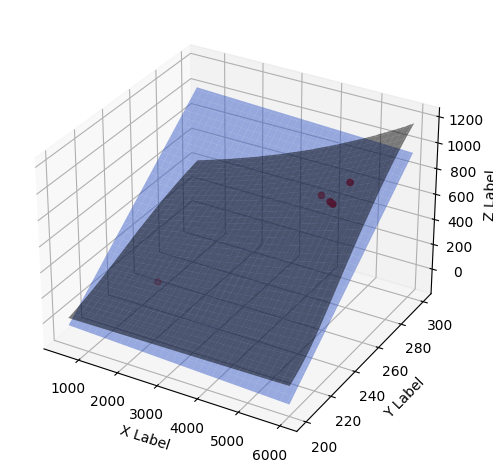

In [25]:
# Plot
add_bands = False


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# True surface
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, Z, 
                       alpha = .5, 
                       label='target function',
                       color='black'
                      )
# Mean predicted
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, mu_plot, 
                       alpha = .5, 
                       label='model', # Mean
                       color='royalblue'
                      )
# True points observed
ax.scatter(x[:,0], x[:,1], y, marker='o', color='red')

if add_bands:
    surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, mu_plot-2*var_plot, 
                           alpha = .5, 
                           label='model_ci_lb', # Confidence band lower bound
                           color='lightskyblue'
                          )
    surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, mu_plot+2*var_plot, 
                           alpha = .5, 
                           label='model_ci_ub', # Confidence band upper bound
                           color='lightskyblue' 
                          )
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.tight_layout()



# FIX from here on 

## Optimization loop

In [26]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [35]:
# help(ExperimentalDesignLoop)

In [28]:
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition = integrated_variance)
ed.run_loop(user_function=run_missile_sim, stopping_condition=10)


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 500.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  0.5425649908847033
Angle (deg h):  43.75785014371944
Range (km):  1.8168572713221445
Time (sec):  16.399999999999967
Final results: 
Range (km):  35.57198757177094
Apogee (km):  11.11430028487503
Time to target (sec):  102.69999999999844



New simulation 

fuelmass: 6000.0
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.945886852067297
Angle (deg h):  43.647633662484175
Range (km):  86.68413905931058
Time (sec):  196.19999999999314
Final results: 
Range (km):  1174.6685304335963
Apogee (km):  369.5869797180853
Time to target (sec):  739.1000000000995



New simulation 

fuelmass: 5999.999519569739
Isp0: 300.0


Stage 1 burnout
Velocity (km/s):  2.945887648308081
Angle (deg h):  43.647629858283594
Range (km):  86.68416608432477
Time (sec):  196.19999999999314
Final results: 
Range (km):  1174.6688687773521
Apogee (km):  369.58712263378226
Time to target (sec):  739.1000000000995



New simulation 

fuel

## Sensitivity Analysis

In [29]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [30]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [31]:
import pandas as pd


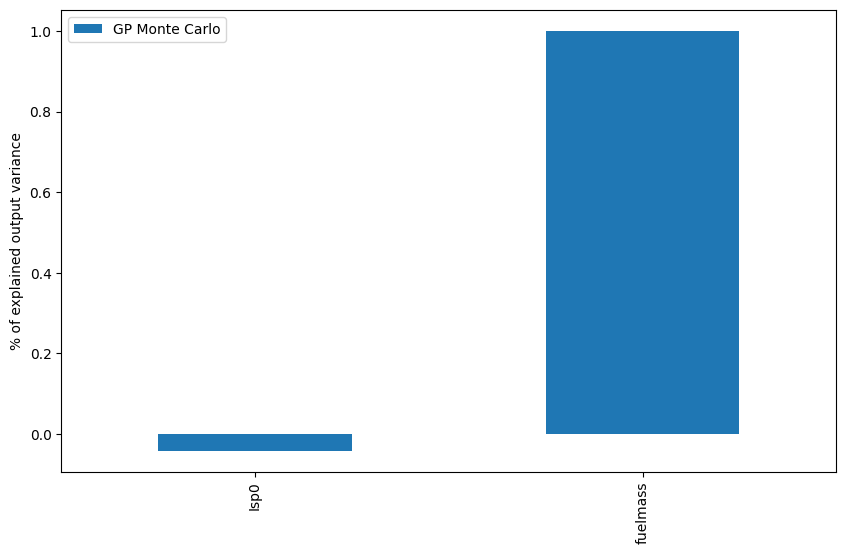

In [32]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')


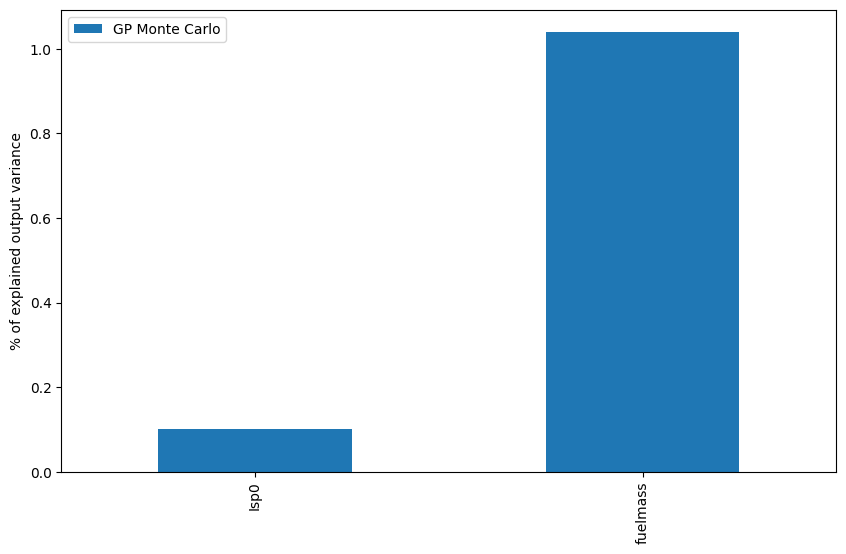

In [33]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')